In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='../../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Create loaders

In [6]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels

In [7]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

### View a batch of images

In [8]:
for images, labels in train_loader:
    break

In [9]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

Label: [3 2 0 4 9 5 1 2 4 8]
Class:    cat  bird plane  deer truck   dog   car  bird  deer  ship


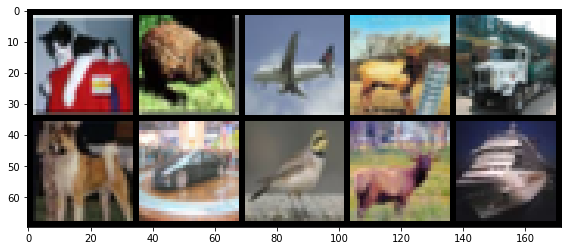

In [10]:
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

### Define the model

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)
        

In [12]:
((32-2)/2 - 2) / 2
# Pooling 2 * 2

6.5

In [13]:
images[0].shape

torch.Size([3, 32, 32])

In [14]:
torch.manual_seed(101)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'epoch: {i:2} batch: {b:4} [{10 * b:6}/50000] loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
        
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

epoch:  0 batch:    1 [    10/50000] loss: 2.28801680 accuracy:  10.000%
epoch:  0 batch:    2 [    20/50000] loss: 2.31119919 accuracy:  10.000%
epoch:  0 batch:    3 [    30/50000] loss: 2.32950354 accuracy:  10.000%
epoch:  0 batch:    4 [    40/50000] loss: 2.32197261 accuracy:   7.500%
epoch:  0 batch:    5 [    50/50000] loss: 2.26652527 accuracy:   8.000%
epoch:  0 batch:    6 [    60/50000] loss: 2.28542972 accuracy:   8.333%
epoch:  0 batch:    7 [    70/50000] loss: 2.27939987 accuracy:  10.000%
epoch:  0 batch:    8 [    80/50000] loss: 2.31481528 accuracy:  10.000%
epoch:  0 batch:    9 [    90/50000] loss: 2.31636667 accuracy:  10.000%
epoch:  0 batch:   10 [   100/50000] loss: 2.31869769 accuracy:  10.000%
epoch:  0 batch:   11 [   110/50000] loss: 2.33660841 accuracy:   9.091%
epoch:  0 batch:   12 [   120/50000] loss: 2.30640030 accuracy:   9.167%
epoch:  0 batch:   13 [   130/50000] loss: 2.25245261 accuracy:  10.000%
epoch:  0 batch:   14 [   140/50000] loss: 2.296377

epoch:  0 batch:  119 [  1190/50000] loss: 2.23234677 accuracy:  16.218%
epoch:  0 batch:  120 [  1200/50000] loss: 2.10713649 accuracy:  16.167%
epoch:  0 batch:  121 [  1210/50000] loss: 2.23286581 accuracy:  16.116%
epoch:  0 batch:  122 [  1220/50000] loss: 2.19191122 accuracy:  16.066%
epoch:  0 batch:  123 [  1230/50000] loss: 2.18722653 accuracy:  16.098%
epoch:  0 batch:  124 [  1240/50000] loss: 2.65055633 accuracy:  16.210%
epoch:  0 batch:  125 [  1250/50000] loss: 2.19425726 accuracy:  16.240%
epoch:  0 batch:  126 [  1260/50000] loss: 2.01715493 accuracy:  16.429%
epoch:  0 batch:  127 [  1270/50000] loss: 2.30732012 accuracy:  16.378%
epoch:  0 batch:  128 [  1280/50000] loss: 2.05878687 accuracy:  16.406%
epoch:  0 batch:  129 [  1290/50000] loss: 2.10129738 accuracy:  16.357%
epoch:  0 batch:  130 [  1300/50000] loss: 2.25538683 accuracy:  16.308%
epoch:  0 batch:  131 [  1310/50000] loss: 1.99053919 accuracy:  16.412%
epoch:  0 batch:  132 [  1320/50000] loss: 2.132415

epoch:  0 batch:  239 [  2390/50000] loss: 2.50820780 accuracy:  16.778%
epoch:  0 batch:  240 [  2400/50000] loss: 2.42666125 accuracy:  16.792%
epoch:  0 batch:  241 [  2410/50000] loss: 1.80550647 accuracy:  16.846%
epoch:  0 batch:  242 [  2420/50000] loss: 1.74425852 accuracy:  16.983%
epoch:  0 batch:  243 [  2430/50000] loss: 1.76887798 accuracy:  17.119%
epoch:  0 batch:  244 [  2440/50000] loss: 2.15093493 accuracy:  17.090%
epoch:  0 batch:  245 [  2450/50000] loss: 1.97605360 accuracy:  17.184%
epoch:  0 batch:  246 [  2460/50000] loss: 2.37641168 accuracy:  17.154%
epoch:  0 batch:  247 [  2470/50000] loss: 1.80385053 accuracy:  17.247%
epoch:  0 batch:  248 [  2480/50000] loss: 1.86934662 accuracy:  17.258%
epoch:  0 batch:  249 [  2490/50000] loss: 2.07451987 accuracy:  17.349%
epoch:  0 batch:  250 [  2500/50000] loss: 2.11294127 accuracy:  17.320%
epoch:  0 batch:  251 [  2510/50000] loss: 2.14953756 accuracy:  17.371%
epoch:  0 batch:  252 [  2520/50000] loss: 2.051391

epoch:  0 batch:  364 [  3640/50000] loss: 1.80700910 accuracy:  19.725%
epoch:  0 batch:  365 [  3650/50000] loss: 1.89323592 accuracy:  19.726%
epoch:  0 batch:  366 [  3660/50000] loss: 2.12474346 accuracy:  19.699%
epoch:  0 batch:  367 [  3670/50000] loss: 2.26663470 accuracy:  19.700%
epoch:  0 batch:  368 [  3680/50000] loss: 2.08917427 accuracy:  19.674%
epoch:  0 batch:  369 [  3690/50000] loss: 1.97801757 accuracy:  19.729%
epoch:  0 batch:  370 [  3700/50000] loss: 2.50376177 accuracy:  19.730%
epoch:  0 batch:  371 [  3710/50000] loss: 2.20106697 accuracy:  19.784%
epoch:  0 batch:  372 [  3720/50000] loss: 1.74061847 accuracy:  19.839%
epoch:  0 batch:  373 [  3730/50000] loss: 1.84495318 accuracy:  19.839%
epoch:  0 batch:  374 [  3740/50000] loss: 1.92112386 accuracy:  19.840%
epoch:  0 batch:  375 [  3750/50000] loss: 2.10849166 accuracy:  19.867%
epoch:  0 batch:  376 [  3760/50000] loss: 2.15222955 accuracy:  19.840%
epoch:  0 batch:  377 [  3770/50000] loss: 2.285219

epoch:  0 batch:  489 [  4890/50000] loss: 1.80918658 accuracy:  21.431%
epoch:  0 batch:  490 [  4900/50000] loss: 1.70513749 accuracy:  21.490%
epoch:  0 batch:  491 [  4910/50000] loss: 1.49065626 accuracy:  21.548%
epoch:  0 batch:  492 [  4920/50000] loss: 1.80725741 accuracy:  21.606%
epoch:  0 batch:  493 [  4930/50000] loss: 2.19458032 accuracy:  21.582%
epoch:  0 batch:  494 [  4940/50000] loss: 2.18976760 accuracy:  21.599%
epoch:  0 batch:  495 [  4950/50000] loss: 1.66701579 accuracy:  21.576%
epoch:  0 batch:  496 [  4960/50000] loss: 2.01035166 accuracy:  21.552%
epoch:  0 batch:  497 [  4970/50000] loss: 1.93543053 accuracy:  21.549%
epoch:  0 batch:  498 [  4980/50000] loss: 1.56844831 accuracy:  21.566%
epoch:  0 batch:  499 [  4990/50000] loss: 1.48670185 accuracy:  21.603%
epoch:  0 batch:  500 [  5000/50000] loss: 1.68696368 accuracy:  21.640%
epoch:  0 batch:  501 [  5010/50000] loss: 1.79077840 accuracy:  21.717%
epoch:  0 batch:  502 [  5020/50000] loss: 1.450003

epoch:  0 batch:  611 [  6110/50000] loss: 1.64654386 accuracy:  23.159%
epoch:  0 batch:  612 [  6120/50000] loss: 1.96076334 accuracy:  23.186%
epoch:  0 batch:  613 [  6130/50000] loss: 2.12247992 accuracy:  23.165%
epoch:  0 batch:  614 [  6140/50000] loss: 1.39965987 accuracy:  23.192%
epoch:  0 batch:  615 [  6150/50000] loss: 1.50989509 accuracy:  23.236%
epoch:  0 batch:  616 [  6160/50000] loss: 1.75801587 accuracy:  23.295%
epoch:  0 batch:  617 [  6170/50000] loss: 1.71351266 accuracy:  23.323%
epoch:  0 batch:  618 [  6180/50000] loss: 1.74058747 accuracy:  23.333%
epoch:  0 batch:  619 [  6190/50000] loss: 2.40171123 accuracy:  23.328%
epoch:  0 batch:  620 [  6200/50000] loss: 2.13590527 accuracy:  23.290%
epoch:  0 batch:  621 [  6210/50000] loss: 1.72238064 accuracy:  23.285%
epoch:  0 batch:  622 [  6220/50000] loss: 1.90263617 accuracy:  23.312%
epoch:  0 batch:  623 [  6230/50000] loss: 2.04995012 accuracy:  23.291%
epoch:  0 batch:  624 [  6240/50000] loss: 1.907007

epoch:  0 batch:  730 [  7300/50000] loss: 1.58101749 accuracy:  24.589%
epoch:  0 batch:  731 [  7310/50000] loss: 1.51273942 accuracy:  24.624%
epoch:  0 batch:  732 [  7320/50000] loss: 1.91289115 accuracy:  24.645%
epoch:  0 batch:  733 [  7330/50000] loss: 2.01887202 accuracy:  24.652%
epoch:  0 batch:  734 [  7340/50000] loss: 2.43021107 accuracy:  24.646%
epoch:  0 batch:  735 [  7350/50000] loss: 2.22993231 accuracy:  24.626%
epoch:  0 batch:  736 [  7360/50000] loss: 1.88052309 accuracy:  24.606%
epoch:  0 batch:  737 [  7370/50000] loss: 1.55816913 accuracy:  24.668%
epoch:  0 batch:  738 [  7380/50000] loss: 2.65662909 accuracy:  24.688%
epoch:  0 batch:  739 [  7390/50000] loss: 1.88293684 accuracy:  24.682%
epoch:  0 batch:  740 [  7400/50000] loss: 2.14399767 accuracy:  24.649%
epoch:  0 batch:  741 [  7410/50000] loss: 1.72328568 accuracy:  24.642%
epoch:  0 batch:  742 [  7420/50000] loss: 1.94913864 accuracy:  24.609%
epoch:  0 batch:  743 [  7430/50000] loss: 1.669184

epoch:  0 batch:  858 [  8580/50000] loss: 1.66325402 accuracy:  25.979%
epoch:  0 batch:  859 [  8590/50000] loss: 1.87126195 accuracy:  25.972%
epoch:  0 batch:  860 [  8600/50000] loss: 1.78527069 accuracy:  25.965%
epoch:  0 batch:  861 [  8610/50000] loss: 1.41482532 accuracy:  25.970%
epoch:  0 batch:  862 [  8620/50000] loss: 1.57796752 accuracy:  25.974%
epoch:  0 batch:  863 [  8630/50000] loss: 2.13308764 accuracy:  25.968%
epoch:  0 batch:  864 [  8640/50000] loss: 1.56087661 accuracy:  25.984%
epoch:  0 batch:  865 [  8650/50000] loss: 1.31773019 accuracy:  26.000%
epoch:  0 batch:  866 [  8660/50000] loss: 1.54582500 accuracy:  26.039%
epoch:  0 batch:  867 [  8670/50000] loss: 2.22595549 accuracy:  26.032%
epoch:  0 batch:  868 [  8680/50000] loss: 1.72630692 accuracy:  26.048%
epoch:  0 batch:  869 [  8690/50000] loss: 1.69521141 accuracy:  26.053%
epoch:  0 batch:  870 [  8700/50000] loss: 1.71976447 accuracy:  26.057%
epoch:  0 batch:  871 [  8710/50000] loss: 1.630094

epoch:  0 batch:  979 [  9790/50000] loss: 1.58829606 accuracy:  27.089%
epoch:  0 batch:  980 [  9800/50000] loss: 1.23390508 accuracy:  27.102%
epoch:  0 batch:  981 [  9810/50000] loss: 1.50475132 accuracy:  27.125%
epoch:  0 batch:  982 [  9820/50000] loss: 2.36193228 accuracy:  27.128%
epoch:  0 batch:  983 [  9830/50000] loss: 2.59033012 accuracy:  27.111%
epoch:  0 batch:  984 [  9840/50000] loss: 2.09450769 accuracy:  27.104%
epoch:  0 batch:  985 [  9850/50000] loss: 1.62743151 accuracy:  27.117%
epoch:  0 batch:  986 [  9860/50000] loss: 1.71505570 accuracy:  27.150%
epoch:  0 batch:  987 [  9870/50000] loss: 1.72457099 accuracy:  27.163%
epoch:  0 batch:  988 [  9880/50000] loss: 1.94631886 accuracy:  27.166%
epoch:  0 batch:  989 [  9890/50000] loss: 1.66075742 accuracy:  27.189%
epoch:  0 batch:  990 [  9900/50000] loss: 1.51615453 accuracy:  27.202%
epoch:  0 batch:  991 [  9910/50000] loss: 1.54239964 accuracy:  27.205%
epoch:  0 batch:  992 [  9920/50000] loss: 1.993359

epoch:  0 batch: 1101 [ 11010/50000] loss: 1.20465326 accuracy:  28.329%
epoch:  0 batch: 1102 [ 11020/50000] loss: 1.79698253 accuracy:  28.312%
epoch:  0 batch: 1103 [ 11030/50000] loss: 2.14886546 accuracy:  28.323%
epoch:  0 batch: 1104 [ 11040/50000] loss: 2.23704123 accuracy:  28.315%
epoch:  0 batch: 1105 [ 11050/50000] loss: 1.66671050 accuracy:  28.344%
epoch:  0 batch: 1106 [ 11060/50000] loss: 1.37105680 accuracy:  28.354%
epoch:  0 batch: 1107 [ 11070/50000] loss: 1.77481818 accuracy:  28.374%
epoch:  0 batch: 1108 [ 11080/50000] loss: 1.64579391 accuracy:  28.375%
epoch:  0 batch: 1109 [ 11090/50000] loss: 1.40516448 accuracy:  28.404%
epoch:  0 batch: 1110 [ 11100/50000] loss: 1.46932149 accuracy:  28.432%
epoch:  0 batch: 1111 [ 11110/50000] loss: 1.58383644 accuracy:  28.434%
epoch:  0 batch: 1112 [ 11120/50000] loss: 1.45663524 accuracy:  28.444%
epoch:  0 batch: 1113 [ 11130/50000] loss: 2.19144702 accuracy:  28.437%
epoch:  0 batch: 1114 [ 11140/50000] loss: 1.846822

epoch:  0 batch: 1214 [ 12140/50000] loss: 1.49035549 accuracy:  29.028%
epoch:  0 batch: 1215 [ 12150/50000] loss: 1.62959027 accuracy:  29.037%
epoch:  0 batch: 1216 [ 12160/50000] loss: 2.06057119 accuracy:  29.038%
epoch:  0 batch: 1217 [ 12170/50000] loss: 1.59102178 accuracy:  29.039%
epoch:  0 batch: 1218 [ 12180/50000] loss: 1.55421090 accuracy:  29.048%
epoch:  0 batch: 1219 [ 12190/50000] loss: 1.38761318 accuracy:  29.073%
epoch:  0 batch: 1220 [ 12200/50000] loss: 1.41914725 accuracy:  29.098%
epoch:  0 batch: 1221 [ 12210/50000] loss: 1.83775997 accuracy:  29.091%
epoch:  0 batch: 1222 [ 12220/50000] loss: 1.40823042 accuracy:  29.108%
epoch:  0 batch: 1223 [ 12230/50000] loss: 1.44959044 accuracy:  29.125%
epoch:  0 batch: 1224 [ 12240/50000] loss: 2.14405370 accuracy:  29.101%
epoch:  0 batch: 1225 [ 12250/50000] loss: 1.71618497 accuracy:  29.102%
epoch:  0 batch: 1226 [ 12260/50000] loss: 1.48928308 accuracy:  29.103%
epoch:  0 batch: 1227 [ 12270/50000] loss: 1.690720

epoch:  0 batch: 1333 [ 13330/50000] loss: 1.55656362 accuracy:  29.857%
epoch:  0 batch: 1334 [ 13340/50000] loss: 1.52282274 accuracy:  29.873%
epoch:  0 batch: 1335 [ 13350/50000] loss: 1.30571282 accuracy:  29.895%
epoch:  0 batch: 1336 [ 13360/50000] loss: 1.74986053 accuracy:  29.888%
epoch:  0 batch: 1337 [ 13370/50000] loss: 1.37547040 accuracy:  29.895%
epoch:  0 batch: 1338 [ 13380/50000] loss: 1.75996590 accuracy:  29.895%
epoch:  0 batch: 1339 [ 13390/50000] loss: 1.43223286 accuracy:  29.910%
epoch:  0 batch: 1340 [ 13400/50000] loss: 1.66709971 accuracy:  29.910%
epoch:  0 batch: 1341 [ 13410/50000] loss: 1.66508520 accuracy:  29.918%
epoch:  0 batch: 1342 [ 13420/50000] loss: 1.68698180 accuracy:  29.918%
epoch:  0 batch: 1343 [ 13430/50000] loss: 1.61673224 accuracy:  29.918%
epoch:  0 batch: 1344 [ 13440/50000] loss: 1.52037084 accuracy:  29.926%
epoch:  0 batch: 1345 [ 13450/50000] loss: 1.46345592 accuracy:  29.933%
epoch:  0 batch: 1346 [ 13460/50000] loss: 1.780787

epoch:  0 batch: 1448 [ 14480/50000] loss: 1.59441435 accuracy:  30.518%
epoch:  0 batch: 1449 [ 14490/50000] loss: 1.25792289 accuracy:  30.545%
epoch:  0 batch: 1450 [ 14500/50000] loss: 2.00571680 accuracy:  30.552%
epoch:  0 batch: 1451 [ 14510/50000] loss: 1.71988428 accuracy:  30.551%
epoch:  0 batch: 1452 [ 14520/50000] loss: 1.35609746 accuracy:  30.565%
epoch:  0 batch: 1453 [ 14530/50000] loss: 1.85816956 accuracy:  30.564%
epoch:  0 batch: 1454 [ 14540/50000] loss: 1.35760176 accuracy:  30.585%
epoch:  0 batch: 1455 [ 14550/50000] loss: 2.21583605 accuracy:  30.570%
epoch:  0 batch: 1456 [ 14560/50000] loss: 2.02053523 accuracy:  30.577%
epoch:  0 batch: 1457 [ 14570/50000] loss: 1.74524999 accuracy:  30.583%
epoch:  0 batch: 1458 [ 14580/50000] loss: 2.21835375 accuracy:  30.576%
epoch:  0 batch: 1459 [ 14590/50000] loss: 1.39410722 accuracy:  30.596%
epoch:  0 batch: 1460 [ 14600/50000] loss: 1.75096822 accuracy:  30.596%
epoch:  0 batch: 1461 [ 14610/50000] loss: 1.421700

epoch:  0 batch: 1565 [ 15650/50000] loss: 2.19320607 accuracy:  31.233%
epoch:  0 batch: 1566 [ 15660/50000] loss: 1.10434246 accuracy:  31.245%
epoch:  0 batch: 1567 [ 15670/50000] loss: 1.46542406 accuracy:  31.264%
epoch:  0 batch: 1568 [ 15680/50000] loss: 2.07199836 accuracy:  31.250%
epoch:  0 batch: 1569 [ 15690/50000] loss: 1.60918963 accuracy:  31.262%
epoch:  0 batch: 1570 [ 15700/50000] loss: 2.17060709 accuracy:  31.255%
epoch:  0 batch: 1571 [ 15710/50000] loss: 1.63682294 accuracy:  31.260%
epoch:  0 batch: 1572 [ 15720/50000] loss: 2.36858439 accuracy:  31.253%
epoch:  0 batch: 1573 [ 15730/50000] loss: 1.78206062 accuracy:  31.240%
epoch:  0 batch: 1574 [ 15740/50000] loss: 1.68443620 accuracy:  31.233%
epoch:  0 batch: 1575 [ 15750/50000] loss: 1.43137038 accuracy:  31.232%
epoch:  0 batch: 1576 [ 15760/50000] loss: 1.64067340 accuracy:  31.225%
epoch:  0 batch: 1577 [ 15770/50000] loss: 1.15838015 accuracy:  31.256%
epoch:  0 batch: 1578 [ 15780/50000] loss: 1.656080

epoch:  0 batch: 1691 [ 16910/50000] loss: 1.61533391 accuracy:  31.786%
epoch:  0 batch: 1692 [ 16920/50000] loss: 1.47606122 accuracy:  31.785%
epoch:  0 batch: 1693 [ 16930/50000] loss: 1.21782124 accuracy:  31.802%
epoch:  0 batch: 1694 [ 16940/50000] loss: 1.24008918 accuracy:  31.818%
epoch:  0 batch: 1695 [ 16950/50000] loss: 1.70999980 accuracy:  31.817%
epoch:  0 batch: 1696 [ 16960/50000] loss: 1.19705570 accuracy:  31.834%
epoch:  0 batch: 1697 [ 16970/50000] loss: 1.83531606 accuracy:  31.833%
epoch:  0 batch: 1698 [ 16980/50000] loss: 1.90972304 accuracy:  31.826%
epoch:  0 batch: 1699 [ 16990/50000] loss: 1.55129707 accuracy:  31.842%
epoch:  0 batch: 1700 [ 17000/50000] loss: 1.25819147 accuracy:  31.859%
epoch:  0 batch: 1701 [ 17010/50000] loss: 1.20434773 accuracy:  31.864%
epoch:  0 batch: 1702 [ 17020/50000] loss: 2.29973054 accuracy:  31.863%
epoch:  0 batch: 1703 [ 17030/50000] loss: 0.99197757 accuracy:  31.879%
epoch:  0 batch: 1704 [ 17040/50000] loss: 1.941104

epoch:  0 batch: 1811 [ 18110/50000] loss: 1.68328357 accuracy:  32.352%
epoch:  0 batch: 1812 [ 18120/50000] loss: 1.06311858 accuracy:  32.362%
epoch:  0 batch: 1813 [ 18130/50000] loss: 1.20783162 accuracy:  32.372%
epoch:  0 batch: 1814 [ 18140/50000] loss: 1.99477041 accuracy:  32.370%
epoch:  0 batch: 1815 [ 18150/50000] loss: 1.62929511 accuracy:  32.380%
epoch:  0 batch: 1816 [ 18160/50000] loss: 1.82158637 accuracy:  32.384%
epoch:  0 batch: 1817 [ 18170/50000] loss: 1.29098201 accuracy:  32.394%
epoch:  0 batch: 1818 [ 18180/50000] loss: 1.38500714 accuracy:  32.404%
epoch:  0 batch: 1819 [ 18190/50000] loss: 1.28732693 accuracy:  32.419%
epoch:  0 batch: 1820 [ 18200/50000] loss: 1.52829325 accuracy:  32.423%
epoch:  0 batch: 1821 [ 18210/50000] loss: 1.84825540 accuracy:  32.427%
epoch:  0 batch: 1822 [ 18220/50000] loss: 1.78470397 accuracy:  32.431%
epoch:  0 batch: 1823 [ 18230/50000] loss: 1.61162186 accuracy:  32.430%
epoch:  0 batch: 1824 [ 18240/50000] loss: 1.243633

epoch:  0 batch: 1925 [ 19250/50000] loss: 1.15975213 accuracy:  32.935%
epoch:  0 batch: 1926 [ 19260/50000] loss: 1.30448747 accuracy:  32.949%
epoch:  0 batch: 1927 [ 19270/50000] loss: 1.90489352 accuracy:  32.958%
epoch:  0 batch: 1928 [ 19280/50000] loss: 1.68614578 accuracy:  32.967%
epoch:  0 batch: 1929 [ 19290/50000] loss: 1.71551192 accuracy:  32.965%
epoch:  0 batch: 1930 [ 19300/50000] loss: 1.57183778 accuracy:  32.969%
epoch:  0 batch: 1931 [ 19310/50000] loss: 1.04659152 accuracy:  32.988%
epoch:  0 batch: 1932 [ 19320/50000] loss: 1.48964441 accuracy:  32.992%
epoch:  0 batch: 1933 [ 19330/50000] loss: 1.38734734 accuracy:  33.001%
epoch:  0 batch: 1934 [ 19340/50000] loss: 1.24770486 accuracy:  33.004%
epoch:  0 batch: 1935 [ 19350/50000] loss: 1.68210316 accuracy:  33.003%
epoch:  0 batch: 1936 [ 19360/50000] loss: 1.44520688 accuracy:  33.006%
epoch:  0 batch: 1937 [ 19370/50000] loss: 1.38700926 accuracy:  33.015%
epoch:  0 batch: 1938 [ 19380/50000] loss: 1.830657

epoch:  0 batch: 2038 [ 20380/50000] loss: 2.03670096 accuracy:  33.459%
epoch:  0 batch: 2039 [ 20390/50000] loss: 1.57178199 accuracy:  33.462%
epoch:  0 batch: 2040 [ 20400/50000] loss: 2.12972808 accuracy:  33.461%
epoch:  0 batch: 2041 [ 20410/50000] loss: 1.31763387 accuracy:  33.464%
epoch:  0 batch: 2042 [ 20420/50000] loss: 1.41168964 accuracy:  33.467%
epoch:  0 batch: 2043 [ 20430/50000] loss: 1.39116633 accuracy:  33.475%
epoch:  0 batch: 2044 [ 20440/50000] loss: 1.90814042 accuracy:  33.483%
epoch:  0 batch: 2045 [ 20450/50000] loss: 1.69441640 accuracy:  33.487%
epoch:  0 batch: 2046 [ 20460/50000] loss: 1.86255610 accuracy:  33.485%
epoch:  0 batch: 2047 [ 20470/50000] loss: 2.15276384 accuracy:  33.483%
epoch:  0 batch: 2048 [ 20480/50000] loss: 1.61263216 accuracy:  33.491%
epoch:  0 batch: 2049 [ 20490/50000] loss: 1.27234912 accuracy:  33.499%
epoch:  0 batch: 2050 [ 20500/50000] loss: 1.06115699 accuracy:  33.512%
epoch:  0 batch: 2051 [ 20510/50000] loss: 2.230572

epoch:  0 batch: 2153 [ 21530/50000] loss: 1.31510961 accuracy:  33.883%
epoch:  0 batch: 2154 [ 21540/50000] loss: 1.47054672 accuracy:  33.890%
epoch:  0 batch: 2155 [ 21550/50000] loss: 1.80420613 accuracy:  33.889%
epoch:  0 batch: 2156 [ 21560/50000] loss: 1.41738892 accuracy:  33.891%
epoch:  0 batch: 2157 [ 21570/50000] loss: 1.12815833 accuracy:  33.890%
epoch:  0 batch: 2158 [ 21580/50000] loss: 1.32030165 accuracy:  33.906%
epoch:  0 batch: 2159 [ 21590/50000] loss: 1.62080359 accuracy:  33.909%
epoch:  0 batch: 2160 [ 21600/50000] loss: 1.93664896 accuracy:  33.907%
epoch:  0 batch: 2161 [ 21610/50000] loss: 1.30025995 accuracy:  33.910%
epoch:  0 batch: 2162 [ 21620/50000] loss: 1.67912424 accuracy:  33.904%
epoch:  0 batch: 2163 [ 21630/50000] loss: 1.78590238 accuracy:  33.907%
epoch:  0 batch: 2164 [ 21640/50000] loss: 1.29135621 accuracy:  33.923%
epoch:  0 batch: 2165 [ 21650/50000] loss: 1.84324491 accuracy:  33.926%
epoch:  0 batch: 2166 [ 21660/50000] loss: 1.448983

epoch:  0 batch: 2267 [ 22670/50000] loss: 1.43217468 accuracy:  34.354%
epoch:  0 batch: 2268 [ 22680/50000] loss: 1.62357199 accuracy:  34.356%
epoch:  0 batch: 2269 [ 22690/50000] loss: 1.89134693 accuracy:  34.354%
epoch:  0 batch: 2270 [ 22700/50000] loss: 1.37129629 accuracy:  34.357%
epoch:  0 batch: 2271 [ 22710/50000] loss: 1.97296453 accuracy:  34.355%
epoch:  0 batch: 2272 [ 22720/50000] loss: 1.25506306 accuracy:  34.362%
epoch:  0 batch: 2273 [ 22730/50000] loss: 1.85446286 accuracy:  34.360%
epoch:  0 batch: 2274 [ 22740/50000] loss: 1.63337767 accuracy:  34.362%
epoch:  0 batch: 2275 [ 22750/50000] loss: 1.92504573 accuracy:  34.356%
epoch:  0 batch: 2276 [ 22760/50000] loss: 1.80843902 accuracy:  34.354%
epoch:  0 batch: 2277 [ 22770/50000] loss: 2.21915579 accuracy:  34.348%
epoch:  0 batch: 2278 [ 22780/50000] loss: 1.48718023 accuracy:  34.355%
epoch:  0 batch: 2279 [ 22790/50000] loss: 1.92236328 accuracy:  34.357%
epoch:  0 batch: 2280 [ 22800/50000] loss: 1.228571

epoch:  0 batch: 2390 [ 23900/50000] loss: 1.60531008 accuracy:  34.816%
epoch:  0 batch: 2391 [ 23910/50000] loss: 2.08810949 accuracy:  34.814%
epoch:  0 batch: 2392 [ 23920/50000] loss: 1.27574217 accuracy:  34.824%
epoch:  0 batch: 2393 [ 23930/50000] loss: 1.90963209 accuracy:  34.818%
epoch:  0 batch: 2394 [ 23940/50000] loss: 1.34298491 accuracy:  34.837%
epoch:  0 batch: 2395 [ 23950/50000] loss: 1.58146262 accuracy:  34.839%
epoch:  0 batch: 2396 [ 23960/50000] loss: 1.49773896 accuracy:  34.854%
epoch:  0 batch: 2397 [ 23970/50000] loss: 1.67702866 accuracy:  34.848%
epoch:  0 batch: 2398 [ 23980/50000] loss: 1.72538686 accuracy:  34.846%
epoch:  0 batch: 2399 [ 23990/50000] loss: 1.76994169 accuracy:  34.840%
epoch:  0 batch: 2400 [ 24000/50000] loss: 1.74231684 accuracy:  34.846%
epoch:  0 batch: 2401 [ 24010/50000] loss: 1.10946774 accuracy:  34.856%
epoch:  0 batch: 2402 [ 24020/50000] loss: 1.03471208 accuracy:  34.867%
epoch:  0 batch: 2403 [ 24030/50000] loss: 1.086345

epoch:  0 batch: 2511 [ 25110/50000] loss: 1.60359931 accuracy:  35.285%
epoch:  0 batch: 2512 [ 25120/50000] loss: 1.55603623 accuracy:  35.287%
epoch:  0 batch: 2513 [ 25130/50000] loss: 1.20852768 accuracy:  35.304%
epoch:  0 batch: 2514 [ 25140/50000] loss: 1.29450893 accuracy:  35.318%
epoch:  0 batch: 2515 [ 25150/50000] loss: 1.32978308 accuracy:  35.320%
epoch:  0 batch: 2516 [ 25160/50000] loss: 1.49963593 accuracy:  35.322%
epoch:  0 batch: 2517 [ 25170/50000] loss: 1.50296056 accuracy:  35.324%
epoch:  0 batch: 2518 [ 25180/50000] loss: 2.02772665 accuracy:  35.322%
epoch:  0 batch: 2519 [ 25190/50000] loss: 1.50644469 accuracy:  35.328%
epoch:  0 batch: 2520 [ 25200/50000] loss: 1.39472699 accuracy:  35.329%
epoch:  0 batch: 2521 [ 25210/50000] loss: 1.93967271 accuracy:  35.331%
epoch:  0 batch: 2522 [ 25220/50000] loss: 1.34899318 accuracy:  35.341%
epoch:  0 batch: 2523 [ 25230/50000] loss: 1.63076055 accuracy:  35.343%
epoch:  0 batch: 2524 [ 25240/50000] loss: 1.874501

epoch:  0 batch: 2630 [ 26300/50000] loss: 1.48603523 accuracy:  35.669%
epoch:  0 batch: 2631 [ 26310/50000] loss: 1.77903080 accuracy:  35.678%
epoch:  0 batch: 2632 [ 26320/50000] loss: 0.97660339 accuracy:  35.688%
epoch:  0 batch: 2633 [ 26330/50000] loss: 1.55929017 accuracy:  35.689%
epoch:  0 batch: 2634 [ 26340/50000] loss: 1.84449041 accuracy:  35.695%
epoch:  0 batch: 2635 [ 26350/50000] loss: 1.50953197 accuracy:  35.693%
epoch:  0 batch: 2636 [ 26360/50000] loss: 1.35697567 accuracy:  35.702%
epoch:  0 batch: 2637 [ 26370/50000] loss: 1.24683344 accuracy:  35.703%
epoch:  0 batch: 2638 [ 26380/50000] loss: 1.25846994 accuracy:  35.713%
epoch:  0 batch: 2639 [ 26390/50000] loss: 1.64704728 accuracy:  35.710%
epoch:  0 batch: 2640 [ 26400/50000] loss: 1.35414708 accuracy:  35.712%
epoch:  0 batch: 2641 [ 26410/50000] loss: 1.86084151 accuracy:  35.710%
epoch:  0 batch: 2642 [ 26420/50000] loss: 1.68614697 accuracy:  35.712%
epoch:  0 batch: 2643 [ 26430/50000] loss: 1.640046

epoch:  0 batch: 2748 [ 27480/50000] loss: 1.43573451 accuracy:  35.990%
epoch:  0 batch: 2749 [ 27490/50000] loss: 1.58734131 accuracy:  35.991%
epoch:  0 batch: 2750 [ 27500/50000] loss: 1.21777248 accuracy:  36.000%
epoch:  0 batch: 2751 [ 27510/50000] loss: 0.90661258 accuracy:  36.012%
epoch:  0 batch: 2752 [ 27520/50000] loss: 1.66060030 accuracy:  36.014%
epoch:  0 batch: 2753 [ 27530/50000] loss: 1.38424993 accuracy:  36.026%
epoch:  0 batch: 2754 [ 27540/50000] loss: 1.07570410 accuracy:  36.031%
epoch:  0 batch: 2755 [ 27550/50000] loss: 1.69632983 accuracy:  36.036%
epoch:  0 batch: 2756 [ 27560/50000] loss: 2.39219999 accuracy:  36.030%
epoch:  0 batch: 2757 [ 27570/50000] loss: 1.90995920 accuracy:  36.032%
epoch:  0 batch: 2758 [ 27580/50000] loss: 0.89423835 accuracy:  36.044%
epoch:  0 batch: 2759 [ 27590/50000] loss: 1.83739889 accuracy:  36.038%
epoch:  0 batch: 2760 [ 27600/50000] loss: 0.91735774 accuracy:  36.051%
epoch:  0 batch: 2761 [ 27610/50000] loss: 1.501082

epoch:  0 batch: 2861 [ 28610/50000] loss: 1.43777299 accuracy:  36.403%
epoch:  0 batch: 2862 [ 28620/50000] loss: 1.28962493 accuracy:  36.408%
epoch:  0 batch: 2863 [ 28630/50000] loss: 1.11123681 accuracy:  36.413%
epoch:  0 batch: 2864 [ 28640/50000] loss: 1.86782610 accuracy:  36.418%
epoch:  0 batch: 2865 [ 28650/50000] loss: 1.30478263 accuracy:  36.419%
epoch:  0 batch: 2866 [ 28660/50000] loss: 2.37960052 accuracy:  36.410%
epoch:  0 batch: 2867 [ 28670/50000] loss: 1.89405274 accuracy:  36.407%
epoch:  0 batch: 2868 [ 28680/50000] loss: 1.64151955 accuracy:  36.412%
epoch:  0 batch: 2869 [ 28690/50000] loss: 1.44015908 accuracy:  36.413%
epoch:  0 batch: 2870 [ 28700/50000] loss: 2.22665977 accuracy:  36.408%
epoch:  0 batch: 2871 [ 28710/50000] loss: 1.97147727 accuracy:  36.405%
epoch:  0 batch: 2872 [ 28720/50000] loss: 1.03966117 accuracy:  36.410%
epoch:  0 batch: 2873 [ 28730/50000] loss: 1.32489979 accuracy:  36.411%
epoch:  0 batch: 2874 [ 28740/50000] loss: 1.613769

epoch:  0 batch: 2985 [ 29850/50000] loss: 1.54326725 accuracy:  36.700%
epoch:  0 batch: 2986 [ 29860/50000] loss: 1.25090826 accuracy:  36.705%
epoch:  0 batch: 2987 [ 29870/50000] loss: 1.31141007 accuracy:  36.706%
epoch:  0 batch: 2988 [ 29880/50000] loss: 1.48601341 accuracy:  36.707%
epoch:  0 batch: 2989 [ 29890/50000] loss: 1.29046500 accuracy:  36.711%
epoch:  0 batch: 2990 [ 29900/50000] loss: 1.45165133 accuracy:  36.712%
epoch:  0 batch: 2991 [ 29910/50000] loss: 1.46954119 accuracy:  36.713%
epoch:  0 batch: 2992 [ 29920/50000] loss: 1.78657496 accuracy:  36.715%
epoch:  0 batch: 2993 [ 29930/50000] loss: 1.94950223 accuracy:  36.716%
epoch:  0 batch: 2994 [ 29940/50000] loss: 1.58825231 accuracy:  36.717%
epoch:  0 batch: 2995 [ 29950/50000] loss: 1.41863525 accuracy:  36.725%
epoch:  0 batch: 2996 [ 29960/50000] loss: 1.36144900 accuracy:  36.732%
epoch:  0 batch: 2997 [ 29970/50000] loss: 1.66928101 accuracy:  36.733%
epoch:  0 batch: 2998 [ 29980/50000] loss: 1.580906

epoch:  0 batch: 3100 [ 31000/50000] loss: 2.07317114 accuracy:  37.045%
epoch:  0 batch: 3101 [ 31010/50000] loss: 1.41619229 accuracy:  37.046%
epoch:  0 batch: 3102 [ 31020/50000] loss: 1.22430229 accuracy:  37.054%
epoch:  0 batch: 3103 [ 31030/50000] loss: 1.10082352 accuracy:  37.061%
epoch:  0 batch: 3104 [ 31040/50000] loss: 1.50555432 accuracy:  37.065%
epoch:  0 batch: 3105 [ 31050/50000] loss: 0.91584760 accuracy:  37.079%
epoch:  0 batch: 3106 [ 31060/50000] loss: 1.48529243 accuracy:  37.083%
epoch:  0 batch: 3107 [ 31070/50000] loss: 1.02743471 accuracy:  37.090%
epoch:  0 batch: 3108 [ 31080/50000] loss: 1.92265511 accuracy:  37.088%
epoch:  0 batch: 3109 [ 31090/50000] loss: 1.95567834 accuracy:  37.086%
epoch:  0 batch: 3110 [ 31100/50000] loss: 1.41400075 accuracy:  37.087%
epoch:  0 batch: 3111 [ 31110/50000] loss: 1.18496644 accuracy:  37.091%
epoch:  0 batch: 3112 [ 31120/50000] loss: 1.24461758 accuracy:  37.098%
epoch:  0 batch: 3113 [ 31130/50000] loss: 1.954852

epoch:  0 batch: 3226 [ 32260/50000] loss: 1.70339584 accuracy:  37.356%
epoch:  0 batch: 3227 [ 32270/50000] loss: 1.29393971 accuracy:  37.360%
epoch:  0 batch: 3228 [ 32280/50000] loss: 1.57879937 accuracy:  37.357%
epoch:  0 batch: 3229 [ 32290/50000] loss: 0.83913946 accuracy:  37.371%
epoch:  0 batch: 3230 [ 32300/50000] loss: 1.18380570 accuracy:  37.375%
epoch:  0 batch: 3231 [ 32310/50000] loss: 1.63744283 accuracy:  37.375%
epoch:  0 batch: 3232 [ 32320/50000] loss: 2.04619718 accuracy:  37.367%
epoch:  0 batch: 3233 [ 32330/50000] loss: 1.35053599 accuracy:  37.368%
epoch:  0 batch: 3234 [ 32340/50000] loss: 0.89298820 accuracy:  37.378%
epoch:  0 batch: 3235 [ 32350/50000] loss: 1.24898016 accuracy:  37.379%
epoch:  0 batch: 3236 [ 32360/50000] loss: 1.17597806 accuracy:  37.386%
epoch:  0 batch: 3237 [ 32370/50000] loss: 1.30504441 accuracy:  37.390%
epoch:  0 batch: 3238 [ 32380/50000] loss: 1.60823941 accuracy:  37.397%
epoch:  0 batch: 3239 [ 32390/50000] loss: 1.640940

epoch:  0 batch: 3357 [ 33570/50000] loss: 1.69446623 accuracy:  37.626%
epoch:  0 batch: 3358 [ 33580/50000] loss: 1.15485990 accuracy:  37.633%
epoch:  0 batch: 3359 [ 33590/50000] loss: 1.50197136 accuracy:  37.639%
epoch:  0 batch: 3360 [ 33600/50000] loss: 1.12204587 accuracy:  37.646%
epoch:  0 batch: 3361 [ 33610/50000] loss: 1.36521626 accuracy:  37.650%
epoch:  0 batch: 3362 [ 33620/50000] loss: 1.39927495 accuracy:  37.653%
epoch:  0 batch: 3363 [ 33630/50000] loss: 1.45777357 accuracy:  37.654%
epoch:  0 batch: 3364 [ 33640/50000] loss: 1.57675636 accuracy:  37.652%
epoch:  0 batch: 3365 [ 33650/50000] loss: 1.28439009 accuracy:  37.655%
epoch:  0 batch: 3366 [ 33660/50000] loss: 2.10175467 accuracy:  37.650%
epoch:  0 batch: 3367 [ 33670/50000] loss: 1.14077163 accuracy:  37.657%
epoch:  0 batch: 3368 [ 33680/50000] loss: 2.08100891 accuracy:  37.651%
epoch:  0 batch: 3369 [ 33690/50000] loss: 1.33139849 accuracy:  37.661%
epoch:  0 batch: 3370 [ 33700/50000] loss: 1.329379

epoch:  0 batch: 3481 [ 34810/50000] loss: 1.53222108 accuracy:  37.940%
epoch:  0 batch: 3482 [ 34820/50000] loss: 1.92802072 accuracy:  37.941%
epoch:  0 batch: 3483 [ 34830/50000] loss: 1.30704355 accuracy:  37.944%
epoch:  0 batch: 3484 [ 34840/50000] loss: 1.94020677 accuracy:  37.945%
epoch:  0 batch: 3485 [ 34850/50000] loss: 1.82224143 accuracy:  37.945%
epoch:  0 batch: 3486 [ 34860/50000] loss: 1.33812761 accuracy:  37.949%
epoch:  0 batch: 3487 [ 34870/50000] loss: 1.31027341 accuracy:  37.955%
epoch:  0 batch: 3488 [ 34880/50000] loss: 1.77305961 accuracy:  37.956%
epoch:  0 batch: 3489 [ 34890/50000] loss: 1.33709943 accuracy:  37.962%
epoch:  0 batch: 3490 [ 34900/50000] loss: 1.13413692 accuracy:  37.966%
epoch:  0 batch: 3491 [ 34910/50000] loss: 1.50112057 accuracy:  37.966%
epoch:  0 batch: 3492 [ 34920/50000] loss: 1.18840599 accuracy:  37.975%
epoch:  0 batch: 3493 [ 34930/50000] loss: 1.28964603 accuracy:  37.987%
epoch:  0 batch: 3494 [ 34940/50000] loss: 1.741567

epoch:  0 batch: 3598 [ 35980/50000] loss: 1.64508760 accuracy:  38.202%
epoch:  0 batch: 3599 [ 35990/50000] loss: 1.81117940 accuracy:  38.197%
epoch:  0 batch: 3600 [ 36000/50000] loss: 1.36750627 accuracy:  38.197%
epoch:  0 batch: 3601 [ 36010/50000] loss: 1.41337252 accuracy:  38.195%
epoch:  0 batch: 3602 [ 36020/50000] loss: 1.36998606 accuracy:  38.190%
epoch:  0 batch: 3603 [ 36030/50000] loss: 1.52537513 accuracy:  38.193%
epoch:  0 batch: 3604 [ 36040/50000] loss: 1.40274775 accuracy:  38.194%
epoch:  0 batch: 3605 [ 36050/50000] loss: 1.90652430 accuracy:  38.191%
epoch:  0 batch: 3606 [ 36060/50000] loss: 1.29323483 accuracy:  38.195%
epoch:  0 batch: 3607 [ 36070/50000] loss: 1.76813412 accuracy:  38.190%
epoch:  0 batch: 3608 [ 36080/50000] loss: 1.26065958 accuracy:  38.196%
epoch:  0 batch: 3609 [ 36090/50000] loss: 1.14569378 accuracy:  38.202%
epoch:  0 batch: 3610 [ 36100/50000] loss: 1.38100040 accuracy:  38.202%
epoch:  0 batch: 3611 [ 36110/50000] loss: 2.093379

epoch:  0 batch: 3722 [ 37220/50000] loss: 1.52679574 accuracy:  38.495%
epoch:  0 batch: 3723 [ 37230/50000] loss: 1.76510906 accuracy:  38.493%
epoch:  0 batch: 3724 [ 37240/50000] loss: 1.71446073 accuracy:  38.488%
epoch:  0 batch: 3725 [ 37250/50000] loss: 1.19901216 accuracy:  38.491%
epoch:  0 batch: 3726 [ 37260/50000] loss: 1.67163217 accuracy:  38.492%
epoch:  0 batch: 3727 [ 37270/50000] loss: 1.62583482 accuracy:  38.495%
epoch:  0 batch: 3728 [ 37280/50000] loss: 1.17766976 accuracy:  38.498%
epoch:  0 batch: 3729 [ 37290/50000] loss: 1.43225312 accuracy:  38.501%
epoch:  0 batch: 3730 [ 37300/50000] loss: 1.59472919 accuracy:  38.501%
epoch:  0 batch: 3731 [ 37310/50000] loss: 1.72714305 accuracy:  38.502%
epoch:  0 batch: 3732 [ 37320/50000] loss: 1.76213741 accuracy:  38.502%
epoch:  0 batch: 3733 [ 37330/50000] loss: 1.26020885 accuracy:  38.503%
epoch:  0 batch: 3734 [ 37340/50000] loss: 1.53359032 accuracy:  38.500%
epoch:  0 batch: 3735 [ 37350/50000] loss: 1.433777

epoch:  0 batch: 3841 [ 38410/50000] loss: 1.99467564 accuracy:  38.737%
epoch:  0 batch: 3842 [ 38420/50000] loss: 1.58394122 accuracy:  38.738%
epoch:  0 batch: 3843 [ 38430/50000] loss: 1.75918734 accuracy:  38.738%
epoch:  0 batch: 3844 [ 38440/50000] loss: 0.82995355 accuracy:  38.749%
epoch:  0 batch: 3845 [ 38450/50000] loss: 1.57543647 accuracy:  38.749%
epoch:  0 batch: 3846 [ 38460/50000] loss: 0.62032086 accuracy:  38.760%
epoch:  0 batch: 3847 [ 38470/50000] loss: 1.10854506 accuracy:  38.763%
epoch:  0 batch: 3848 [ 38480/50000] loss: 1.60228848 accuracy:  38.760%
epoch:  0 batch: 3849 [ 38490/50000] loss: 1.14272857 accuracy:  38.766%
epoch:  0 batch: 3850 [ 38500/50000] loss: 1.20981610 accuracy:  38.774%
epoch:  0 batch: 3851 [ 38510/50000] loss: 0.94238728 accuracy:  38.780%
epoch:  0 batch: 3852 [ 38520/50000] loss: 1.08652878 accuracy:  38.785%
epoch:  0 batch: 3853 [ 38530/50000] loss: 1.20673728 accuracy:  38.793%
epoch:  0 batch: 3854 [ 38540/50000] loss: 1.137144

epoch:  0 batch: 3964 [ 39640/50000] loss: 1.67631841 accuracy:  39.011%
epoch:  0 batch: 3965 [ 39650/50000] loss: 1.27719092 accuracy:  39.016%
epoch:  0 batch: 3966 [ 39660/50000] loss: 1.09486604 accuracy:  39.029%
epoch:  0 batch: 3967 [ 39670/50000] loss: 1.93006194 accuracy:  39.027%
epoch:  0 batch: 3968 [ 39680/50000] loss: 1.86306739 accuracy:  39.025%
epoch:  0 batch: 3969 [ 39690/50000] loss: 1.23775971 accuracy:  39.033%
epoch:  0 batch: 3970 [ 39700/50000] loss: 1.24346530 accuracy:  39.038%
epoch:  0 batch: 3971 [ 39710/50000] loss: 1.85140646 accuracy:  39.033%
epoch:  0 batch: 3972 [ 39720/50000] loss: 1.64986992 accuracy:  39.031%
epoch:  0 batch: 3973 [ 39730/50000] loss: 1.89151347 accuracy:  39.026%
epoch:  0 batch: 3974 [ 39740/50000] loss: 1.61863422 accuracy:  39.029%
epoch:  0 batch: 3975 [ 39750/50000] loss: 1.44667137 accuracy:  39.029%
epoch:  0 batch: 3976 [ 39760/50000] loss: 1.24658418 accuracy:  39.029%
epoch:  0 batch: 3977 [ 39770/50000] loss: 1.512392

epoch:  0 batch: 4084 [ 40840/50000] loss: 0.85544032 accuracy:  39.212%
epoch:  0 batch: 4085 [ 40850/50000] loss: 1.41248643 accuracy:  39.217%
epoch:  0 batch: 4086 [ 40860/50000] loss: 1.26313138 accuracy:  39.222%
epoch:  0 batch: 4087 [ 40870/50000] loss: 2.00359797 accuracy:  39.224%
epoch:  0 batch: 4088 [ 40880/50000] loss: 1.20405853 accuracy:  39.227%
epoch:  0 batch: 4089 [ 40890/50000] loss: 1.22344100 accuracy:  39.230%
epoch:  0 batch: 4090 [ 40900/50000] loss: 1.64453626 accuracy:  39.230%
epoch:  0 batch: 4091 [ 40910/50000] loss: 0.90319729 accuracy:  39.240%
epoch:  0 batch: 4092 [ 40920/50000] loss: 2.17458272 accuracy:  39.235%
epoch:  0 batch: 4093 [ 40930/50000] loss: 1.92736590 accuracy:  39.230%
epoch:  0 batch: 4094 [ 40940/50000] loss: 1.56719840 accuracy:  39.231%
epoch:  0 batch: 4095 [ 40950/50000] loss: 1.61497188 accuracy:  39.221%
epoch:  0 batch: 4096 [ 40960/50000] loss: 1.38417363 accuracy:  39.221%
epoch:  0 batch: 4097 [ 40970/50000] loss: 1.596067

epoch:  0 batch: 4204 [ 42040/50000] loss: 1.68370605 accuracy:  39.415%
epoch:  0 batch: 4205 [ 42050/50000] loss: 1.27083182 accuracy:  39.420%
epoch:  0 batch: 4206 [ 42060/50000] loss: 1.73590589 accuracy:  39.420%
epoch:  0 batch: 4207 [ 42070/50000] loss: 1.95026207 accuracy:  39.418%
epoch:  0 batch: 4208 [ 42080/50000] loss: 0.95473272 accuracy:  39.427%
epoch:  0 batch: 4209 [ 42090/50000] loss: 1.29238760 accuracy:  39.432%
epoch:  0 batch: 4210 [ 42100/50000] loss: 1.51868439 accuracy:  39.432%
epoch:  0 batch: 4211 [ 42110/50000] loss: 2.42567873 accuracy:  39.428%
epoch:  0 batch: 4212 [ 42120/50000] loss: 2.10942864 accuracy:  39.425%
epoch:  0 batch: 4213 [ 42130/50000] loss: 1.01768589 accuracy:  39.435%
epoch:  0 batch: 4214 [ 42140/50000] loss: 0.91106272 accuracy:  39.442%
epoch:  0 batch: 4215 [ 42150/50000] loss: 1.62156701 accuracy:  39.445%
epoch:  0 batch: 4216 [ 42160/50000] loss: 1.23669207 accuracy:  39.452%
epoch:  0 batch: 4217 [ 42170/50000] loss: 1.206382

epoch:  0 batch: 4322 [ 43220/50000] loss: 1.32225204 accuracy:  39.644%
epoch:  0 batch: 4323 [ 43230/50000] loss: 0.96789646 accuracy:  39.648%
epoch:  0 batch: 4324 [ 43240/50000] loss: 1.32632065 accuracy:  39.653%
epoch:  0 batch: 4325 [ 43250/50000] loss: 1.19586813 accuracy:  39.655%
epoch:  0 batch: 4326 [ 43260/50000] loss: 1.77440000 accuracy:  39.656%
epoch:  0 batch: 4327 [ 43270/50000] loss: 1.70121729 accuracy:  39.656%
epoch:  0 batch: 4328 [ 43280/50000] loss: 2.05250859 accuracy:  39.651%
epoch:  0 batch: 4329 [ 43290/50000] loss: 1.39990199 accuracy:  39.651%
epoch:  0 batch: 4330 [ 43300/50000] loss: 1.26126730 accuracy:  39.658%
epoch:  0 batch: 4331 [ 43310/50000] loss: 1.47405553 accuracy:  39.661%
epoch:  0 batch: 4332 [ 43320/50000] loss: 1.77807009 accuracy:  39.663%
epoch:  0 batch: 4333 [ 43330/50000] loss: 1.48522639 accuracy:  39.665%
epoch:  0 batch: 4334 [ 43340/50000] loss: 1.44411528 accuracy:  39.668%
epoch:  0 batch: 4335 [ 43350/50000] loss: 1.437761

epoch:  0 batch: 4444 [ 44440/50000] loss: 1.05824149 accuracy:  39.932%
epoch:  0 batch: 4445 [ 44450/50000] loss: 0.84469968 accuracy:  39.939%
epoch:  0 batch: 4446 [ 44460/50000] loss: 1.65626740 accuracy:  39.939%
epoch:  0 batch: 4447 [ 44470/50000] loss: 1.86060941 accuracy:  39.937%
epoch:  0 batch: 4448 [ 44480/50000] loss: 1.22985351 accuracy:  39.939%
epoch:  0 batch: 4449 [ 44490/50000] loss: 1.58278215 accuracy:  39.939%
epoch:  0 batch: 4450 [ 44500/50000] loss: 1.54712081 accuracy:  39.939%
epoch:  0 batch: 4451 [ 44510/50000] loss: 1.07744646 accuracy:  39.948%
epoch:  0 batch: 4452 [ 44520/50000] loss: 1.55581748 accuracy:  39.953%
epoch:  0 batch: 4453 [ 44530/50000] loss: 2.04038715 accuracy:  39.944%
epoch:  0 batch: 4454 [ 44540/50000] loss: 1.48520911 accuracy:  39.942%
epoch:  0 batch: 4455 [ 44550/50000] loss: 1.13034666 accuracy:  39.944%
epoch:  0 batch: 4456 [ 44560/50000] loss: 1.70661569 accuracy:  39.944%
epoch:  0 batch: 4457 [ 44570/50000] loss: 1.845202

epoch:  0 batch: 4563 [ 45630/50000] loss: 1.72038770 accuracy:  40.055%
epoch:  0 batch: 4564 [ 45640/50000] loss: 1.79439712 accuracy:  40.055%
epoch:  0 batch: 4565 [ 45650/50000] loss: 1.20833671 accuracy:  40.055%
epoch:  0 batch: 4566 [ 45660/50000] loss: 1.76090455 accuracy:  40.053%
epoch:  0 batch: 4567 [ 45670/50000] loss: 2.02204466 accuracy:  40.053%
epoch:  0 batch: 4568 [ 45680/50000] loss: 1.19125521 accuracy:  40.057%
epoch:  0 batch: 4569 [ 45690/50000] loss: 1.75394034 accuracy:  40.055%
epoch:  0 batch: 4570 [ 45700/50000] loss: 1.98582518 accuracy:  40.050%
epoch:  0 batch: 4571 [ 45710/50000] loss: 1.46152973 accuracy:  40.053%
epoch:  0 batch: 4572 [ 45720/50000] loss: 1.63525069 accuracy:  40.055%
epoch:  0 batch: 4573 [ 45730/50000] loss: 0.97678566 accuracy:  40.061%
epoch:  0 batch: 4574 [ 45740/50000] loss: 1.44510007 accuracy:  40.061%
epoch:  0 batch: 4575 [ 45750/50000] loss: 1.48596537 accuracy:  40.061%
epoch:  0 batch: 4576 [ 45760/50000] loss: 1.212039

epoch:  0 batch: 4685 [ 46850/50000] loss: 1.25288892 accuracy:  40.199%
epoch:  0 batch: 4686 [ 46860/50000] loss: 1.68960321 accuracy:  40.192%
epoch:  0 batch: 4687 [ 46870/50000] loss: 1.39833772 accuracy:  40.194%
epoch:  0 batch: 4688 [ 46880/50000] loss: 0.66489476 accuracy:  40.205%
epoch:  0 batch: 4689 [ 46890/50000] loss: 1.41419566 accuracy:  40.207%
epoch:  0 batch: 4690 [ 46900/50000] loss: 1.93866277 accuracy:  40.205%
epoch:  0 batch: 4691 [ 46910/50000] loss: 1.48513746 accuracy:  40.209%
epoch:  0 batch: 4692 [ 46920/50000] loss: 1.57263064 accuracy:  40.211%
epoch:  0 batch: 4693 [ 46930/50000] loss: 1.54065561 accuracy:  40.211%
epoch:  0 batch: 4694 [ 46940/50000] loss: 1.50214314 accuracy:  40.209%
epoch:  0 batch: 4695 [ 46950/50000] loss: 1.16179669 accuracy:  40.209%
epoch:  0 batch: 4696 [ 46960/50000] loss: 1.68248785 accuracy:  40.211%
epoch:  0 batch: 4697 [ 46970/50000] loss: 1.63081837 accuracy:  40.213%
epoch:  0 batch: 4698 [ 46980/50000] loss: 1.444637

epoch:  0 batch: 4803 [ 48030/50000] loss: 1.84983730 accuracy:  40.389%
epoch:  0 batch: 4804 [ 48040/50000] loss: 1.86626816 accuracy:  40.391%
epoch:  0 batch: 4805 [ 48050/50000] loss: 1.23112524 accuracy:  40.393%
epoch:  0 batch: 4806 [ 48060/50000] loss: 0.89712989 accuracy:  40.400%
epoch:  0 batch: 4807 [ 48070/50000] loss: 1.98119664 accuracy:  40.395%
epoch:  0 batch: 4808 [ 48080/50000] loss: 1.54975915 accuracy:  40.395%
epoch:  0 batch: 4809 [ 48090/50000] loss: 1.63291967 accuracy:  40.397%
epoch:  0 batch: 4810 [ 48100/50000] loss: 1.36070728 accuracy:  40.401%
epoch:  0 batch: 4811 [ 48110/50000] loss: 1.79469454 accuracy:  40.397%
epoch:  0 batch: 4812 [ 48120/50000] loss: 1.40425205 accuracy:  40.397%
epoch:  0 batch: 4813 [ 48130/50000] loss: 1.86222363 accuracy:  40.397%
epoch:  0 batch: 4814 [ 48140/50000] loss: 1.27944088 accuracy:  40.399%
epoch:  0 batch: 4815 [ 48150/50000] loss: 1.74564624 accuracy:  40.395%
epoch:  0 batch: 4816 [ 48160/50000] loss: 1.776699

epoch:  0 batch: 4925 [ 49250/50000] loss: 0.68421459 accuracy:  40.638%
epoch:  0 batch: 4926 [ 49260/50000] loss: 1.26683235 accuracy:  40.644%
epoch:  0 batch: 4927 [ 49270/50000] loss: 1.32678354 accuracy:  40.645%
epoch:  0 batch: 4928 [ 49280/50000] loss: 1.54325616 accuracy:  40.643%
epoch:  0 batch: 4929 [ 49290/50000] loss: 1.27696860 accuracy:  40.647%
epoch:  0 batch: 4930 [ 49300/50000] loss: 1.03469920 accuracy:  40.651%
epoch:  0 batch: 4931 [ 49310/50000] loss: 1.11470735 accuracy:  40.653%
epoch:  0 batch: 4932 [ 49320/50000] loss: 1.76732945 accuracy:  40.655%
epoch:  0 batch: 4933 [ 49330/50000] loss: 1.15142417 accuracy:  40.659%
epoch:  0 batch: 4934 [ 49340/50000] loss: 1.65461600 accuracy:  40.661%
epoch:  0 batch: 4935 [ 49350/50000] loss: 1.52023757 accuracy:  40.663%
epoch:  0 batch: 4936 [ 49360/50000] loss: 1.41992116 accuracy:  40.662%
epoch:  0 batch: 4937 [ 49370/50000] loss: 1.52806211 accuracy:  40.664%
epoch:  0 batch: 4938 [ 49380/50000] loss: 1.382153

epoch:  1 batch:   54 [   540/50000] loss: 1.33297503 accuracy:  48.148%
epoch:  1 batch:   55 [   550/50000] loss: 1.42391121 accuracy:  48.000%
epoch:  1 batch:   56 [   560/50000] loss: 0.87379110 accuracy:  48.393%
epoch:  1 batch:   57 [   570/50000] loss: 1.20239615 accuracy:  48.596%
epoch:  1 batch:   58 [   580/50000] loss: 2.04686594 accuracy:  48.621%
epoch:  1 batch:   59 [   590/50000] loss: 1.31887853 accuracy:  48.305%
epoch:  1 batch:   60 [   600/50000] loss: 1.54439878 accuracy:  48.167%
epoch:  1 batch:   61 [   610/50000] loss: 1.50676370 accuracy:  48.197%
epoch:  1 batch:   62 [   620/50000] loss: 1.06073892 accuracy:  48.387%
epoch:  1 batch:   63 [   630/50000] loss: 1.26824486 accuracy:  48.413%
epoch:  1 batch:   64 [   640/50000] loss: 0.76435268 accuracy:  48.750%
epoch:  1 batch:   65 [   650/50000] loss: 1.15968025 accuracy:  48.769%
epoch:  1 batch:   66 [   660/50000] loss: 1.14064741 accuracy:  48.939%
epoch:  1 batch:   67 [   670/50000] loss: 1.645258

epoch:  1 batch:  174 [  1740/50000] loss: 1.23532319 accuracy:  49.253%
epoch:  1 batch:  175 [  1750/50000] loss: 1.53640115 accuracy:  49.314%
epoch:  1 batch:  176 [  1760/50000] loss: 1.92856824 accuracy:  49.318%
epoch:  1 batch:  177 [  1770/50000] loss: 1.39094663 accuracy:  49.379%
epoch:  1 batch:  178 [  1780/50000] loss: 1.18128419 accuracy:  49.382%
epoch:  1 batch:  179 [  1790/50000] loss: 0.96485120 accuracy:  49.441%
epoch:  1 batch:  180 [  1800/50000] loss: 2.15954304 accuracy:  49.278%
epoch:  1 batch:  181 [  1810/50000] loss: 0.73024207 accuracy:  49.448%
epoch:  1 batch:  182 [  1820/50000] loss: 1.63900304 accuracy:  49.396%
epoch:  1 batch:  183 [  1830/50000] loss: 1.29231668 accuracy:  49.454%
epoch:  1 batch:  184 [  1840/50000] loss: 0.75903147 accuracy:  49.565%
epoch:  1 batch:  185 [  1850/50000] loss: 1.27043712 accuracy:  49.568%
epoch:  1 batch:  186 [  1860/50000] loss: 1.38503635 accuracy:  49.570%
epoch:  1 batch:  187 [  1870/50000] loss: 1.561470

epoch:  1 batch:  296 [  2960/50000] loss: 1.65461421 accuracy:  49.088%
epoch:  1 batch:  297 [  2970/50000] loss: 1.66790032 accuracy:  49.024%
epoch:  1 batch:  298 [  2980/50000] loss: 1.50640082 accuracy:  48.960%
epoch:  1 batch:  299 [  2990/50000] loss: 1.37401474 accuracy:  48.963%
epoch:  1 batch:  300 [  3000/50000] loss: 1.90173686 accuracy:  48.933%
epoch:  1 batch:  301 [  3010/50000] loss: 1.27357864 accuracy:  48.870%
epoch:  1 batch:  302 [  3020/50000] loss: 1.64380431 accuracy:  48.841%
epoch:  1 batch:  303 [  3030/50000] loss: 1.24969542 accuracy:  48.878%
epoch:  1 batch:  304 [  3040/50000] loss: 1.76895833 accuracy:  48.816%
epoch:  1 batch:  305 [  3050/50000] loss: 1.95605624 accuracy:  48.787%
epoch:  1 batch:  306 [  3060/50000] loss: 1.52891695 accuracy:  48.791%
epoch:  1 batch:  307 [  3070/50000] loss: 1.65274358 accuracy:  48.697%
epoch:  1 batch:  308 [  3080/50000] loss: 1.28819704 accuracy:  48.799%
epoch:  1 batch:  309 [  3090/50000] loss: 1.224442

epoch:  1 batch:  426 [  4260/50000] loss: 1.41202903 accuracy:  49.131%
epoch:  1 batch:  427 [  4270/50000] loss: 0.88015616 accuracy:  49.204%
epoch:  1 batch:  428 [  4280/50000] loss: 1.06036162 accuracy:  49.276%
epoch:  1 batch:  429 [  4290/50000] loss: 1.43582654 accuracy:  49.277%
epoch:  1 batch:  430 [  4300/50000] loss: 1.92904758 accuracy:  49.209%
epoch:  1 batch:  431 [  4310/50000] loss: 1.08696914 accuracy:  49.211%
epoch:  1 batch:  432 [  4320/50000] loss: 1.34181511 accuracy:  49.213%
epoch:  1 batch:  433 [  4330/50000] loss: 1.63130224 accuracy:  49.192%
epoch:  1 batch:  434 [  4340/50000] loss: 1.24523282 accuracy:  49.217%
epoch:  1 batch:  435 [  4350/50000] loss: 1.09874940 accuracy:  49.241%
epoch:  1 batch:  436 [  4360/50000] loss: 0.85612738 accuracy:  49.289%
epoch:  1 batch:  437 [  4370/50000] loss: 1.32333732 accuracy:  49.268%
epoch:  1 batch:  438 [  4380/50000] loss: 0.65642363 accuracy:  49.338%
epoch:  1 batch:  439 [  4390/50000] loss: 1.591133

epoch:  1 batch:  548 [  5480/50000] loss: 1.59989107 accuracy:  49.380%
epoch:  1 batch:  549 [  5490/50000] loss: 0.94365442 accuracy:  49.417%
epoch:  1 batch:  550 [  5500/50000] loss: 1.18844843 accuracy:  49.418%
epoch:  1 batch:  551 [  5510/50000] loss: 1.38126588 accuracy:  49.437%
epoch:  1 batch:  552 [  5520/50000] loss: 1.21860337 accuracy:  49.402%
epoch:  1 batch:  553 [  5530/50000] loss: 1.11621320 accuracy:  49.439%
epoch:  1 batch:  554 [  5540/50000] loss: 1.41767538 accuracy:  49.404%
epoch:  1 batch:  555 [  5550/50000] loss: 1.63793504 accuracy:  49.423%
epoch:  1 batch:  556 [  5560/50000] loss: 1.71498549 accuracy:  49.388%
epoch:  1 batch:  557 [  5570/50000] loss: 1.52385831 accuracy:  49.390%
epoch:  1 batch:  558 [  5580/50000] loss: 0.97592795 accuracy:  49.444%
epoch:  1 batch:  559 [  5590/50000] loss: 1.44504380 accuracy:  49.428%
epoch:  1 batch:  560 [  5600/50000] loss: 1.09661567 accuracy:  49.429%
epoch:  1 batch:  561 [  5610/50000] loss: 1.599296

epoch:  1 batch:  671 [  6710/50000] loss: 1.40798664 accuracy:  49.419%
epoch:  1 batch:  672 [  6720/50000] loss: 1.63323712 accuracy:  49.420%
epoch:  1 batch:  673 [  6730/50000] loss: 1.83930230 accuracy:  49.376%
epoch:  1 batch:  674 [  6740/50000] loss: 1.89231324 accuracy:  49.332%
epoch:  1 batch:  675 [  6750/50000] loss: 1.87476313 accuracy:  49.304%
epoch:  1 batch:  676 [  6760/50000] loss: 1.23414099 accuracy:  49.290%
epoch:  1 batch:  677 [  6770/50000] loss: 1.89623237 accuracy:  49.261%
epoch:  1 batch:  678 [  6780/50000] loss: 1.36044216 accuracy:  49.277%
epoch:  1 batch:  679 [  6790/50000] loss: 0.96254766 accuracy:  49.308%
epoch:  1 batch:  680 [  6800/50000] loss: 0.96753567 accuracy:  49.353%
epoch:  1 batch:  681 [  6810/50000] loss: 1.29224706 accuracy:  49.354%
epoch:  1 batch:  682 [  6820/50000] loss: 1.33225584 accuracy:  49.355%
epoch:  1 batch:  683 [  6830/50000] loss: 1.19668698 accuracy:  49.341%
epoch:  1 batch:  684 [  6840/50000] loss: 1.345087

epoch:  1 batch:  800 [  8000/50000] loss: 1.60874999 accuracy:  49.487%
epoch:  1 batch:  801 [  8010/50000] loss: 1.62167776 accuracy:  49.476%
epoch:  1 batch:  802 [  8020/50000] loss: 1.24590838 accuracy:  49.501%
epoch:  1 batch:  803 [  8030/50000] loss: 1.19744372 accuracy:  49.514%
epoch:  1 batch:  804 [  8040/50000] loss: 1.96580255 accuracy:  49.502%
epoch:  1 batch:  805 [  8050/50000] loss: 1.94917417 accuracy:  49.466%
epoch:  1 batch:  806 [  8060/50000] loss: 1.10323882 accuracy:  49.479%
epoch:  1 batch:  807 [  8070/50000] loss: 1.08018947 accuracy:  49.492%
epoch:  1 batch:  808 [  8080/50000] loss: 2.32836485 accuracy:  49.455%
epoch:  1 batch:  809 [  8090/50000] loss: 1.33207858 accuracy:  49.444%
epoch:  1 batch:  810 [  8100/50000] loss: 1.23435521 accuracy:  49.457%
epoch:  1 batch:  811 [  8110/50000] loss: 1.82467330 accuracy:  49.433%
epoch:  1 batch:  812 [  8120/50000] loss: 1.82222581 accuracy:  49.446%
epoch:  1 batch:  813 [  8130/50000] loss: 1.330604

epoch:  1 batch:  931 [  9310/50000] loss: 1.33183312 accuracy:  49.506%
epoch:  1 batch:  932 [  9320/50000] loss: 1.47616756 accuracy:  49.517%
epoch:  1 batch:  933 [  9330/50000] loss: 1.19320989 accuracy:  49.518%
epoch:  1 batch:  934 [  9340/50000] loss: 1.38979876 accuracy:  49.507%
epoch:  1 batch:  935 [  9350/50000] loss: 1.41476321 accuracy:  49.487%
epoch:  1 batch:  936 [  9360/50000] loss: 1.11554980 accuracy:  49.509%
epoch:  1 batch:  937 [  9370/50000] loss: 1.44744575 accuracy:  49.498%
epoch:  1 batch:  938 [  9380/50000] loss: 1.14098704 accuracy:  49.499%
epoch:  1 batch:  939 [  9390/50000] loss: 1.31159663 accuracy:  49.521%
epoch:  1 batch:  940 [  9400/50000] loss: 1.66280973 accuracy:  49.500%
epoch:  1 batch:  941 [  9410/50000] loss: 1.00867534 accuracy:  49.490%
epoch:  1 batch:  942 [  9420/50000] loss: 1.14940906 accuracy:  49.501%
epoch:  1 batch:  943 [  9430/50000] loss: 1.78427279 accuracy:  49.491%
epoch:  1 batch:  944 [  9440/50000] loss: 1.463928

epoch:  1 batch: 1062 [ 10620/50000] loss: 1.07169294 accuracy:  49.661%
epoch:  1 batch: 1063 [ 10630/50000] loss: 2.05008316 accuracy:  49.652%
epoch:  1 batch: 1064 [ 10640/50000] loss: 1.88462007 accuracy:  49.633%
epoch:  1 batch: 1065 [ 10650/50000] loss: 1.65205741 accuracy:  49.643%
epoch:  1 batch: 1066 [ 10660/50000] loss: 1.02127945 accuracy:  49.672%
epoch:  1 batch: 1067 [ 10670/50000] loss: 0.99031657 accuracy:  49.691%
epoch:  1 batch: 1068 [ 10680/50000] loss: 1.78233552 accuracy:  49.682%
epoch:  1 batch: 1069 [ 10690/50000] loss: 1.66569901 accuracy:  49.673%
epoch:  1 batch: 1070 [ 10700/50000] loss: 1.04648852 accuracy:  49.682%
epoch:  1 batch: 1071 [ 10710/50000] loss: 1.43128610 accuracy:  49.692%
epoch:  1 batch: 1072 [ 10720/50000] loss: 0.98031360 accuracy:  49.711%
epoch:  1 batch: 1073 [ 10730/50000] loss: 1.35500407 accuracy:  49.702%
epoch:  1 batch: 1074 [ 10740/50000] loss: 1.72460914 accuracy:  49.702%
epoch:  1 batch: 1075 [ 10750/50000] loss: 1.413422

epoch:  1 batch: 1192 [ 11920/50000] loss: 1.06287694 accuracy:  49.950%
epoch:  1 batch: 1193 [ 11930/50000] loss: 1.70529878 accuracy:  49.925%
epoch:  1 batch: 1194 [ 11940/50000] loss: 1.52104211 accuracy:  49.925%
epoch:  1 batch: 1195 [ 11950/50000] loss: 1.93946874 accuracy:  49.891%
epoch:  1 batch: 1196 [ 11960/50000] loss: 1.34031463 accuracy:  49.900%
epoch:  1 batch: 1197 [ 11970/50000] loss: 1.32917058 accuracy:  49.908%
epoch:  1 batch: 1198 [ 11980/50000] loss: 1.36245060 accuracy:  49.891%
epoch:  1 batch: 1199 [ 11990/50000] loss: 1.01944530 accuracy:  49.900%
epoch:  1 batch: 1200 [ 12000/50000] loss: 1.72025371 accuracy:  49.900%
epoch:  1 batch: 1201 [ 12010/50000] loss: 1.31387687 accuracy:  49.908%
epoch:  1 batch: 1202 [ 12020/50000] loss: 1.15361762 accuracy:  49.925%
epoch:  1 batch: 1203 [ 12030/50000] loss: 0.84322625 accuracy:  49.942%
epoch:  1 batch: 1204 [ 12040/50000] loss: 1.71585560 accuracy:  49.925%
epoch:  1 batch: 1205 [ 12050/50000] loss: 1.315474

epoch:  1 batch: 1326 [ 13260/50000] loss: 0.89990485 accuracy:  49.985%
epoch:  1 batch: 1327 [ 13270/50000] loss: 0.85331964 accuracy:  50.008%
epoch:  1 batch: 1328 [ 13280/50000] loss: 1.66992891 accuracy:  50.000%
epoch:  1 batch: 1329 [ 13290/50000] loss: 1.12088239 accuracy:  50.015%
epoch:  1 batch: 1330 [ 13300/50000] loss: 0.70882416 accuracy:  50.045%
epoch:  1 batch: 1331 [ 13310/50000] loss: 1.29021335 accuracy:  50.045%
epoch:  1 batch: 1332 [ 13320/50000] loss: 0.94410181 accuracy:  50.053%
epoch:  1 batch: 1333 [ 13330/50000] loss: 1.45355475 accuracy:  50.053%
epoch:  1 batch: 1334 [ 13340/50000] loss: 1.42231238 accuracy:  50.052%
epoch:  1 batch: 1335 [ 13350/50000] loss: 1.26922882 accuracy:  50.037%
epoch:  1 batch: 1336 [ 13360/50000] loss: 1.25191629 accuracy:  50.045%
epoch:  1 batch: 1337 [ 13370/50000] loss: 1.12409329 accuracy:  50.045%
epoch:  1 batch: 1338 [ 13380/50000] loss: 1.76191866 accuracy:  50.045%
epoch:  1 batch: 1339 [ 13390/50000] loss: 1.444233

epoch:  1 batch: 1458 [ 14580/50000] loss: 0.74223453 accuracy:  50.069%
epoch:  1 batch: 1459 [ 14590/50000] loss: 1.90698206 accuracy:  50.055%
epoch:  1 batch: 1460 [ 14600/50000] loss: 1.67649531 accuracy:  50.041%
epoch:  1 batch: 1461 [ 14610/50000] loss: 0.63907802 accuracy:  50.062%
epoch:  1 batch: 1462 [ 14620/50000] loss: 1.07747197 accuracy:  50.068%
epoch:  1 batch: 1463 [ 14630/50000] loss: 1.60680962 accuracy:  50.055%
epoch:  1 batch: 1464 [ 14640/50000] loss: 1.31614769 accuracy:  50.048%
epoch:  1 batch: 1465 [ 14650/50000] loss: 1.24477053 accuracy:  50.061%
epoch:  1 batch: 1466 [ 14660/50000] loss: 1.50126004 accuracy:  50.048%
epoch:  1 batch: 1467 [ 14670/50000] loss: 0.98499012 accuracy:  50.061%
epoch:  1 batch: 1468 [ 14680/50000] loss: 1.15493095 accuracy:  50.068%
epoch:  1 batch: 1469 [ 14690/50000] loss: 1.38404715 accuracy:  50.061%
epoch:  1 batch: 1470 [ 14700/50000] loss: 1.76067710 accuracy:  50.054%
epoch:  1 batch: 1471 [ 14710/50000] loss: 1.481168

epoch:  1 batch: 1583 [ 15830/50000] loss: 1.12087893 accuracy:  50.114%
epoch:  1 batch: 1584 [ 15840/50000] loss: 1.55872571 accuracy:  50.107%
epoch:  1 batch: 1585 [ 15850/50000] loss: 0.67524201 accuracy:  50.120%
epoch:  1 batch: 1586 [ 15860/50000] loss: 1.17765129 accuracy:  50.126%
epoch:  1 batch: 1587 [ 15870/50000] loss: 1.05120730 accuracy:  50.139%
epoch:  1 batch: 1588 [ 15880/50000] loss: 1.62943864 accuracy:  50.139%
epoch:  1 batch: 1589 [ 15890/50000] loss: 0.87067443 accuracy:  50.157%
epoch:  1 batch: 1590 [ 15900/50000] loss: 1.33364153 accuracy:  50.164%
epoch:  1 batch: 1591 [ 15910/50000] loss: 1.10508609 accuracy:  50.176%
epoch:  1 batch: 1592 [ 15920/50000] loss: 2.19156265 accuracy:  50.163%
epoch:  1 batch: 1593 [ 15930/50000] loss: 1.76752913 accuracy:  50.163%
epoch:  1 batch: 1594 [ 15940/50000] loss: 0.94967586 accuracy:  50.176%
epoch:  1 batch: 1595 [ 15950/50000] loss: 1.71667516 accuracy:  50.176%
epoch:  1 batch: 1596 [ 15960/50000] loss: 1.484537

epoch:  1 batch: 1696 [ 16960/50000] loss: 1.67467952 accuracy:  50.307%
epoch:  1 batch: 1697 [ 16970/50000] loss: 0.78591132 accuracy:  50.318%
epoch:  1 batch: 1698 [ 16980/50000] loss: 0.88711703 accuracy:  50.330%
epoch:  1 batch: 1699 [ 16990/50000] loss: 1.42214572 accuracy:  50.330%
epoch:  1 batch: 1700 [ 17000/50000] loss: 1.67135310 accuracy:  50.329%
epoch:  1 batch: 1701 [ 17010/50000] loss: 1.30110788 accuracy:  50.323%
epoch:  1 batch: 1702 [ 17020/50000] loss: 1.17080462 accuracy:  50.323%
epoch:  1 batch: 1703 [ 17030/50000] loss: 1.77048528 accuracy:  50.317%
epoch:  1 batch: 1704 [ 17040/50000] loss: 1.56650364 accuracy:  50.317%
epoch:  1 batch: 1705 [ 17050/50000] loss: 1.58583474 accuracy:  50.323%
epoch:  1 batch: 1706 [ 17060/50000] loss: 1.32293856 accuracy:  50.317%
epoch:  1 batch: 1707 [ 17070/50000] loss: 2.08939123 accuracy:  50.299%
epoch:  1 batch: 1708 [ 17080/50000] loss: 1.55516124 accuracy:  50.304%
epoch:  1 batch: 1709 [ 17090/50000] loss: 1.607536

epoch:  1 batch: 1812 [ 18120/50000] loss: 1.19338834 accuracy:  50.270%
epoch:  1 batch: 1813 [ 18130/50000] loss: 1.83641219 accuracy:  50.265%
epoch:  1 batch: 1814 [ 18140/50000] loss: 0.93239653 accuracy:  50.270%
epoch:  1 batch: 1815 [ 18150/50000] loss: 0.82005012 accuracy:  50.292%
epoch:  1 batch: 1816 [ 18160/50000] loss: 1.64033544 accuracy:  50.292%
epoch:  1 batch: 1817 [ 18170/50000] loss: 1.21486270 accuracy:  50.303%
epoch:  1 batch: 1818 [ 18180/50000] loss: 1.53310859 accuracy:  50.297%
epoch:  1 batch: 1819 [ 18190/50000] loss: 1.42780590 accuracy:  50.302%
epoch:  1 batch: 1820 [ 18200/50000] loss: 1.16215265 accuracy:  50.297%
epoch:  1 batch: 1821 [ 18210/50000] loss: 1.55259478 accuracy:  50.291%
epoch:  1 batch: 1822 [ 18220/50000] loss: 1.06641459 accuracy:  50.302%
epoch:  1 batch: 1823 [ 18230/50000] loss: 1.28060663 accuracy:  50.307%
epoch:  1 batch: 1824 [ 18240/50000] loss: 1.76366925 accuracy:  50.291%
epoch:  1 batch: 1825 [ 18250/50000] loss: 1.432768

epoch:  1 batch: 1937 [ 19370/50000] loss: 1.61338484 accuracy:  50.408%
epoch:  1 batch: 1938 [ 19380/50000] loss: 1.44748247 accuracy:  50.413%
epoch:  1 batch: 1939 [ 19390/50000] loss: 0.99236333 accuracy:  50.428%
epoch:  1 batch: 1940 [ 19400/50000] loss: 1.07893181 accuracy:  50.443%
epoch:  1 batch: 1941 [ 19410/50000] loss: 1.47315586 accuracy:  50.438%
epoch:  1 batch: 1942 [ 19420/50000] loss: 1.19726014 accuracy:  50.438%
epoch:  1 batch: 1943 [ 19430/50000] loss: 1.36300492 accuracy:  50.432%
epoch:  1 batch: 1944 [ 19440/50000] loss: 1.15304518 accuracy:  50.442%
epoch:  1 batch: 1945 [ 19450/50000] loss: 0.74850094 accuracy:  50.458%
epoch:  1 batch: 1946 [ 19460/50000] loss: 1.01514614 accuracy:  50.473%
epoch:  1 batch: 1947 [ 19470/50000] loss: 1.53588367 accuracy:  50.467%
epoch:  1 batch: 1948 [ 19480/50000] loss: 1.09230912 accuracy:  50.472%
epoch:  1 batch: 1949 [ 19490/50000] loss: 1.14043915 accuracy:  50.472%
epoch:  1 batch: 1950 [ 19500/50000] loss: 1.596647

epoch:  1 batch: 2066 [ 20660/50000] loss: 1.25197387 accuracy:  50.416%
epoch:  1 batch: 2067 [ 20670/50000] loss: 1.18120527 accuracy:  50.416%
epoch:  1 batch: 2068 [ 20680/50000] loss: 1.42856908 accuracy:  50.406%
epoch:  1 batch: 2069 [ 20690/50000] loss: 1.22777247 accuracy:  50.406%
epoch:  1 batch: 2070 [ 20700/50000] loss: 1.73031831 accuracy:  50.396%
epoch:  1 batch: 2071 [ 20710/50000] loss: 1.24585342 accuracy:  50.391%
epoch:  1 batch: 2072 [ 20720/50000] loss: 0.79361612 accuracy:  50.396%
epoch:  1 batch: 2073 [ 20730/50000] loss: 1.05988765 accuracy:  50.396%
epoch:  1 batch: 2074 [ 20740/50000] loss: 1.76099932 accuracy:  50.386%
epoch:  1 batch: 2075 [ 20750/50000] loss: 1.09671474 accuracy:  50.395%
epoch:  1 batch: 2076 [ 20760/50000] loss: 1.38818097 accuracy:  50.395%
epoch:  1 batch: 2077 [ 20770/50000] loss: 1.20582736 accuracy:  50.390%
epoch:  1 batch: 2078 [ 20780/50000] loss: 1.12988961 accuracy:  50.399%
epoch:  1 batch: 2079 [ 20790/50000] loss: 1.407935

epoch:  1 batch: 2191 [ 21910/50000] loss: 1.74470937 accuracy:  50.456%
epoch:  1 batch: 2192 [ 21920/50000] loss: 1.68145597 accuracy:  50.461%
epoch:  1 batch: 2193 [ 21930/50000] loss: 1.89032388 accuracy:  50.442%
epoch:  1 batch: 2194 [ 21940/50000] loss: 1.03572059 accuracy:  50.451%
epoch:  1 batch: 2195 [ 21950/50000] loss: 1.21909988 accuracy:  50.456%
epoch:  1 batch: 2196 [ 21960/50000] loss: 1.16950321 accuracy:  50.455%
epoch:  1 batch: 2197 [ 21970/50000] loss: 1.02614152 accuracy:  50.455%
epoch:  1 batch: 2198 [ 21980/50000] loss: 1.28986251 accuracy:  50.464%
epoch:  1 batch: 2199 [ 21990/50000] loss: 1.40873504 accuracy:  50.464%
epoch:  1 batch: 2200 [ 22000/50000] loss: 1.70959687 accuracy:  50.464%
epoch:  1 batch: 2201 [ 22010/50000] loss: 0.98407114 accuracy:  50.468%
epoch:  1 batch: 2202 [ 22020/50000] loss: 1.32577586 accuracy:  50.468%
epoch:  1 batch: 2203 [ 22030/50000] loss: 1.40819347 accuracy:  50.472%
epoch:  1 batch: 2204 [ 22040/50000] loss: 1.558505

epoch:  1 batch: 2306 [ 23060/50000] loss: 1.23525679 accuracy:  50.655%
epoch:  1 batch: 2307 [ 23070/50000] loss: 1.24677277 accuracy:  50.655%
epoch:  1 batch: 2308 [ 23080/50000] loss: 1.05105495 accuracy:  50.663%
epoch:  1 batch: 2309 [ 23090/50000] loss: 1.24855828 accuracy:  50.658%
epoch:  1 batch: 2310 [ 23100/50000] loss: 0.86133748 accuracy:  50.667%
epoch:  1 batch: 2311 [ 23110/50000] loss: 1.42285323 accuracy:  50.666%
epoch:  1 batch: 2312 [ 23120/50000] loss: 0.87456352 accuracy:  50.675%
epoch:  1 batch: 2313 [ 23130/50000] loss: 1.04453790 accuracy:  50.683%
epoch:  1 batch: 2314 [ 23140/50000] loss: 1.41355848 accuracy:  50.683%
epoch:  1 batch: 2315 [ 23150/50000] loss: 0.82245654 accuracy:  50.695%
epoch:  1 batch: 2316 [ 23160/50000] loss: 0.90062523 accuracy:  50.695%
epoch:  1 batch: 2317 [ 23170/50000] loss: 0.83814782 accuracy:  50.708%
epoch:  1 batch: 2318 [ 23180/50000] loss: 1.21833491 accuracy:  50.712%
epoch:  1 batch: 2319 [ 23190/50000] loss: 1.406524

epoch:  1 batch: 2426 [ 24260/50000] loss: 1.54762030 accuracy:  50.697%
epoch:  1 batch: 2427 [ 24270/50000] loss: 1.28890133 accuracy:  50.696%
epoch:  1 batch: 2428 [ 24280/50000] loss: 1.05452490 accuracy:  50.704%
epoch:  1 batch: 2429 [ 24290/50000] loss: 1.57744789 accuracy:  50.700%
epoch:  1 batch: 2430 [ 24300/50000] loss: 1.81906378 accuracy:  50.695%
epoch:  1 batch: 2431 [ 24310/50000] loss: 1.40273595 accuracy:  50.691%
epoch:  1 batch: 2432 [ 24320/50000] loss: 1.51460397 accuracy:  50.691%
epoch:  1 batch: 2433 [ 24330/50000] loss: 1.71330810 accuracy:  50.686%
epoch:  1 batch: 2434 [ 24340/50000] loss: 1.30130351 accuracy:  50.686%
epoch:  1 batch: 2435 [ 24350/50000] loss: 1.31037235 accuracy:  50.690%
epoch:  1 batch: 2436 [ 24360/50000] loss: 1.51924288 accuracy:  50.677%
epoch:  1 batch: 2437 [ 24370/50000] loss: 0.59927350 accuracy:  50.693%
epoch:  1 batch: 2438 [ 24380/50000] loss: 1.57411098 accuracy:  50.689%
epoch:  1 batch: 2439 [ 24390/50000] loss: 1.222143

epoch:  1 batch: 2551 [ 25510/50000] loss: 1.21593308 accuracy:  50.702%
epoch:  1 batch: 2552 [ 25520/50000] loss: 1.23973799 accuracy:  50.697%
epoch:  1 batch: 2553 [ 25530/50000] loss: 1.49433005 accuracy:  50.693%
epoch:  1 batch: 2554 [ 25540/50000] loss: 1.39830756 accuracy:  50.689%
epoch:  1 batch: 2555 [ 25550/50000] loss: 1.52293229 accuracy:  50.689%
epoch:  1 batch: 2556 [ 25560/50000] loss: 0.88844717 accuracy:  50.700%
epoch:  1 batch: 2557 [ 25570/50000] loss: 1.01570809 accuracy:  50.708%
epoch:  1 batch: 2558 [ 25580/50000] loss: 1.12422454 accuracy:  50.711%
epoch:  1 batch: 2559 [ 25590/50000] loss: 1.46732926 accuracy:  50.699%
epoch:  1 batch: 2560 [ 25600/50000] loss: 1.47147000 accuracy:  50.695%
epoch:  1 batch: 2561 [ 25610/50000] loss: 1.16923201 accuracy:  50.703%
epoch:  1 batch: 2562 [ 25620/50000] loss: 1.34475207 accuracy:  50.706%
epoch:  1 batch: 2563 [ 25630/50000] loss: 1.40584028 accuracy:  50.698%
epoch:  1 batch: 2564 [ 25640/50000] loss: 1.467659

epoch:  1 batch: 2682 [ 26820/50000] loss: 0.87659150 accuracy:  50.749%
epoch:  1 batch: 2683 [ 26830/50000] loss: 1.16995549 accuracy:  50.757%
epoch:  1 batch: 2684 [ 26840/50000] loss: 1.39508653 accuracy:  50.756%
epoch:  1 batch: 2685 [ 26850/50000] loss: 1.60780966 accuracy:  50.752%
epoch:  1 batch: 2686 [ 26860/50000] loss: 1.87440586 accuracy:  50.733%
epoch:  1 batch: 2687 [ 26870/50000] loss: 1.53765655 accuracy:  50.729%
epoch:  1 batch: 2688 [ 26880/50000] loss: 1.24791801 accuracy:  50.733%
epoch:  1 batch: 2689 [ 26890/50000] loss: 0.99176395 accuracy:  50.740%
epoch:  1 batch: 2690 [ 26900/50000] loss: 0.98450983 accuracy:  50.747%
epoch:  1 batch: 2691 [ 26910/50000] loss: 1.11989117 accuracy:  50.754%
epoch:  1 batch: 2692 [ 26920/50000] loss: 1.03194249 accuracy:  50.758%
epoch:  1 batch: 2693 [ 26930/50000] loss: 1.85283351 accuracy:  50.754%
epoch:  1 batch: 2694 [ 26940/50000] loss: 1.44819152 accuracy:  50.746%
epoch:  1 batch: 2695 [ 26950/50000] loss: 0.951207

epoch:  1 batch: 2810 [ 28100/50000] loss: 1.66458035 accuracy:  50.779%
epoch:  1 batch: 2811 [ 28110/50000] loss: 1.16217470 accuracy:  50.783%
epoch:  1 batch: 2812 [ 28120/50000] loss: 0.70958716 accuracy:  50.786%
epoch:  1 batch: 2813 [ 28130/50000] loss: 1.26736569 accuracy:  50.779%
epoch:  1 batch: 2814 [ 28140/50000] loss: 1.11911964 accuracy:  50.778%
epoch:  1 batch: 2815 [ 28150/50000] loss: 2.43365192 accuracy:  50.764%
epoch:  1 batch: 2816 [ 28160/50000] loss: 1.29295576 accuracy:  50.763%
epoch:  1 batch: 2817 [ 28170/50000] loss: 1.65371227 accuracy:  50.760%
epoch:  1 batch: 2818 [ 28180/50000] loss: 0.88611090 accuracy:  50.767%
epoch:  1 batch: 2819 [ 28190/50000] loss: 1.19524503 accuracy:  50.770%
epoch:  1 batch: 2820 [ 28200/50000] loss: 1.49267793 accuracy:  50.762%
epoch:  1 batch: 2821 [ 28210/50000] loss: 1.68863297 accuracy:  50.762%
epoch:  1 batch: 2822 [ 28220/50000] loss: 0.67676008 accuracy:  50.773%
epoch:  1 batch: 2823 [ 28230/50000] loss: 1.658409

epoch:  1 batch: 2932 [ 29320/50000] loss: 1.42876303 accuracy:  50.716%
epoch:  1 batch: 2933 [ 29330/50000] loss: 1.26914907 accuracy:  50.716%
epoch:  1 batch: 2934 [ 29340/50000] loss: 1.01953268 accuracy:  50.719%
epoch:  1 batch: 2935 [ 29350/50000] loss: 1.06439018 accuracy:  50.719%
epoch:  1 batch: 2936 [ 29360/50000] loss: 1.69219744 accuracy:  50.719%
epoch:  1 batch: 2937 [ 29370/50000] loss: 0.91449416 accuracy:  50.725%
epoch:  1 batch: 2938 [ 29380/50000] loss: 1.52942634 accuracy:  50.722%
epoch:  1 batch: 2939 [ 29390/50000] loss: 1.72678590 accuracy:  50.711%
epoch:  1 batch: 2940 [ 29400/50000] loss: 0.70543265 accuracy:  50.721%
epoch:  1 batch: 2941 [ 29410/50000] loss: 1.77100623 accuracy:  50.717%
epoch:  1 batch: 2942 [ 29420/50000] loss: 1.64677465 accuracy:  50.717%
epoch:  1 batch: 2943 [ 29430/50000] loss: 1.13340354 accuracy:  50.720%
epoch:  1 batch: 2944 [ 29440/50000] loss: 1.36455071 accuracy:  50.713%
epoch:  1 batch: 2945 [ 29450/50000] loss: 1.273879

epoch:  1 batch: 3053 [ 30530/50000] loss: 1.18378925 accuracy:  50.802%
epoch:  1 batch: 3054 [ 30540/50000] loss: 0.71124589 accuracy:  50.812%
epoch:  1 batch: 3055 [ 30550/50000] loss: 1.51082921 accuracy:  50.812%
epoch:  1 batch: 3056 [ 30560/50000] loss: 0.94006002 accuracy:  50.818%
epoch:  1 batch: 3057 [ 30570/50000] loss: 1.21439135 accuracy:  50.828%
epoch:  1 batch: 3058 [ 30580/50000] loss: 1.22612464 accuracy:  50.824%
epoch:  1 batch: 3059 [ 30590/50000] loss: 1.56596076 accuracy:  50.821%
epoch:  1 batch: 3060 [ 30600/50000] loss: 1.39392877 accuracy:  50.814%
epoch:  1 batch: 3061 [ 30610/50000] loss: 1.80818439 accuracy:  50.807%
epoch:  1 batch: 3062 [ 30620/50000] loss: 1.42455935 accuracy:  50.800%
epoch:  1 batch: 3063 [ 30630/50000] loss: 1.35269725 accuracy:  50.793%
epoch:  1 batch: 3064 [ 30640/50000] loss: 1.05124795 accuracy:  50.793%
epoch:  1 batch: 3065 [ 30650/50000] loss: 1.40602553 accuracy:  50.790%
epoch:  1 batch: 3066 [ 30660/50000] loss: 1.397009

epoch:  1 batch: 3175 [ 31750/50000] loss: 1.80816400 accuracy:  50.800%
epoch:  1 batch: 3176 [ 31760/50000] loss: 1.38271928 accuracy:  50.797%
epoch:  1 batch: 3177 [ 31770/50000] loss: 1.24911726 accuracy:  50.799%
epoch:  1 batch: 3178 [ 31780/50000] loss: 0.88714516 accuracy:  50.806%
epoch:  1 batch: 3179 [ 31790/50000] loss: 0.82544577 accuracy:  50.812%
epoch:  1 batch: 3180 [ 31800/50000] loss: 1.19420016 accuracy:  50.818%
epoch:  1 batch: 3181 [ 31810/50000] loss: 1.07630432 accuracy:  50.827%
epoch:  1 batch: 3182 [ 31820/50000] loss: 0.87843287 accuracy:  50.833%
epoch:  1 batch: 3183 [ 31830/50000] loss: 1.09783483 accuracy:  50.829%
epoch:  1 batch: 3184 [ 31840/50000] loss: 1.47252941 accuracy:  50.826%
epoch:  1 batch: 3185 [ 31850/50000] loss: 0.61670238 accuracy:  50.838%
epoch:  1 batch: 3186 [ 31860/50000] loss: 1.21991241 accuracy:  50.832%
epoch:  1 batch: 3187 [ 31870/50000] loss: 1.31122303 accuracy:  50.835%
epoch:  1 batch: 3188 [ 31880/50000] loss: 1.016807

epoch:  1 batch: 3300 [ 33000/50000] loss: 1.55481780 accuracy:  50.855%
epoch:  1 batch: 3301 [ 33010/50000] loss: 1.22045708 accuracy:  50.857%
epoch:  1 batch: 3302 [ 33020/50000] loss: 1.49616909 accuracy:  50.854%
epoch:  1 batch: 3303 [ 33030/50000] loss: 1.66469598 accuracy:  50.848%
epoch:  1 batch: 3304 [ 33040/50000] loss: 1.66471708 accuracy:  50.847%
epoch:  1 batch: 3305 [ 33050/50000] loss: 1.92359853 accuracy:  50.838%
epoch:  1 batch: 3306 [ 33060/50000] loss: 0.74300605 accuracy:  50.850%
epoch:  1 batch: 3307 [ 33070/50000] loss: 1.78472674 accuracy:  50.844%
epoch:  1 batch: 3308 [ 33080/50000] loss: 1.68146741 accuracy:  50.843%
epoch:  1 batch: 3309 [ 33090/50000] loss: 1.02970600 accuracy:  50.843%
epoch:  1 batch: 3310 [ 33100/50000] loss: 0.93129885 accuracy:  50.855%
epoch:  1 batch: 3311 [ 33110/50000] loss: 1.36810565 accuracy:  50.852%
epoch:  1 batch: 3312 [ 33120/50000] loss: 1.00968206 accuracy:  50.861%
epoch:  1 batch: 3313 [ 33130/50000] loss: 1.644495

epoch:  1 batch: 3431 [ 34310/50000] loss: 1.79635501 accuracy:  50.828%
epoch:  1 batch: 3432 [ 34320/50000] loss: 1.45843768 accuracy:  50.819%
epoch:  1 batch: 3433 [ 34330/50000] loss: 0.94409466 accuracy:  50.824%
epoch:  1 batch: 3434 [ 34340/50000] loss: 1.53771198 accuracy:  50.821%
epoch:  1 batch: 3435 [ 34350/50000] loss: 1.51001930 accuracy:  50.824%
epoch:  1 batch: 3436 [ 34360/50000] loss: 1.60346675 accuracy:  50.821%
epoch:  1 batch: 3437 [ 34370/50000] loss: 0.99352247 accuracy:  50.826%
epoch:  1 batch: 3438 [ 34380/50000] loss: 1.17356658 accuracy:  50.829%
epoch:  1 batch: 3439 [ 34390/50000] loss: 1.52666473 accuracy:  50.829%
epoch:  1 batch: 3440 [ 34400/50000] loss: 1.10108852 accuracy:  50.831%
epoch:  1 batch: 3441 [ 34410/50000] loss: 1.13166118 accuracy:  50.834%
epoch:  1 batch: 3442 [ 34420/50000] loss: 1.65674174 accuracy:  50.831%
epoch:  1 batch: 3443 [ 34430/50000] loss: 1.06705618 accuracy:  50.831%
epoch:  1 batch: 3444 [ 34440/50000] loss: 1.069743

epoch:  1 batch: 3566 [ 35660/50000] loss: 1.27364039 accuracy:  50.931%
epoch:  1 batch: 3567 [ 35670/50000] loss: 1.12586498 accuracy:  50.936%
epoch:  1 batch: 3568 [ 35680/50000] loss: 1.22596240 accuracy:  50.942%
epoch:  1 batch: 3569 [ 35690/50000] loss: 1.42259502 accuracy:  50.941%
epoch:  1 batch: 3570 [ 35700/50000] loss: 1.02051306 accuracy:  50.950%
epoch:  1 batch: 3571 [ 35710/50000] loss: 0.98111534 accuracy:  50.947%
epoch:  1 batch: 3572 [ 35720/50000] loss: 1.62572694 accuracy:  50.949%
epoch:  1 batch: 3573 [ 35730/50000] loss: 1.78993797 accuracy:  50.943%
epoch:  1 batch: 3574 [ 35740/50000] loss: 1.46787572 accuracy:  50.940%
epoch:  1 batch: 3575 [ 35750/50000] loss: 0.88221979 accuracy:  50.945%
epoch:  1 batch: 3576 [ 35760/50000] loss: 1.85617483 accuracy:  50.942%
epoch:  1 batch: 3577 [ 35770/50000] loss: 1.29765534 accuracy:  50.939%
epoch:  1 batch: 3578 [ 35780/50000] loss: 0.91671383 accuracy:  50.947%
epoch:  1 batch: 3579 [ 35790/50000] loss: 2.186468

epoch:  1 batch: 3684 [ 36840/50000] loss: 1.17867696 accuracy:  50.988%
epoch:  1 batch: 3685 [ 36850/50000] loss: 1.36763418 accuracy:  50.988%
epoch:  1 batch: 3686 [ 36860/50000] loss: 1.79974937 accuracy:  50.979%
epoch:  1 batch: 3687 [ 36870/50000] loss: 1.70837462 accuracy:  50.982%
epoch:  1 batch: 3688 [ 36880/50000] loss: 1.21394801 accuracy:  50.984%
epoch:  1 batch: 3689 [ 36890/50000] loss: 1.27347898 accuracy:  50.984%
epoch:  1 batch: 3690 [ 36900/50000] loss: 1.11883843 accuracy:  50.986%
epoch:  1 batch: 3691 [ 36910/50000] loss: 0.94095421 accuracy:  50.992%
epoch:  1 batch: 3692 [ 36920/50000] loss: 1.27234650 accuracy:  50.991%
epoch:  1 batch: 3693 [ 36930/50000] loss: 1.35514188 accuracy:  50.994%
epoch:  1 batch: 3694 [ 36940/50000] loss: 0.91895354 accuracy:  50.999%
epoch:  1 batch: 3695 [ 36950/50000] loss: 1.15200782 accuracy:  51.004%
epoch:  1 batch: 3696 [ 36960/50000] loss: 0.93266833 accuracy:  51.006%
epoch:  1 batch: 3697 [ 36970/50000] loss: 0.939491

epoch:  1 batch: 3811 [ 38110/50000] loss: 1.49716055 accuracy:  51.107%
epoch:  1 batch: 3812 [ 38120/50000] loss: 1.41779876 accuracy:  51.107%
epoch:  1 batch: 3813 [ 38130/50000] loss: 2.43455625 accuracy:  51.099%
epoch:  1 batch: 3814 [ 38140/50000] loss: 1.86582017 accuracy:  51.096%
epoch:  1 batch: 3815 [ 38150/50000] loss: 1.88564909 accuracy:  51.090%
epoch:  1 batch: 3816 [ 38160/50000] loss: 1.02883363 accuracy:  51.095%
epoch:  1 batch: 3817 [ 38170/50000] loss: 1.46616530 accuracy:  51.095%
epoch:  1 batch: 3818 [ 38180/50000] loss: 1.37287462 accuracy:  51.097%
epoch:  1 batch: 3819 [ 38190/50000] loss: 1.38732958 accuracy:  51.095%
epoch:  1 batch: 3820 [ 38200/50000] loss: 1.28808379 accuracy:  51.094%
epoch:  1 batch: 3821 [ 38210/50000] loss: 1.27515793 accuracy:  51.091%
epoch:  1 batch: 3822 [ 38220/50000] loss: 1.46650600 accuracy:  51.088%
epoch:  1 batch: 3823 [ 38230/50000] loss: 1.28133631 accuracy:  51.093%
epoch:  1 batch: 3824 [ 38240/50000] loss: 1.014472

epoch:  1 batch: 3945 [ 39450/50000] loss: 1.36239767 accuracy:  51.207%
epoch:  1 batch: 3946 [ 39460/50000] loss: 1.13790083 accuracy:  51.211%
epoch:  1 batch: 3947 [ 39470/50000] loss: 1.19529819 accuracy:  51.211%
epoch:  1 batch: 3948 [ 39480/50000] loss: 1.57118750 accuracy:  51.206%
epoch:  1 batch: 3949 [ 39490/50000] loss: 1.50800967 accuracy:  51.205%
epoch:  1 batch: 3950 [ 39500/50000] loss: 0.88240063 accuracy:  51.208%
epoch:  1 batch: 3951 [ 39510/50000] loss: 1.46240163 accuracy:  51.207%
epoch:  1 batch: 3952 [ 39520/50000] loss: 1.17593312 accuracy:  51.215%
epoch:  1 batch: 3953 [ 39530/50000] loss: 0.82817811 accuracy:  51.219%
epoch:  1 batch: 3954 [ 39540/50000] loss: 0.95404655 accuracy:  51.224%
epoch:  1 batch: 3955 [ 39550/50000] loss: 1.30473208 accuracy:  51.224%
epoch:  1 batch: 3956 [ 39560/50000] loss: 0.83029222 accuracy:  51.231%
epoch:  1 batch: 3957 [ 39570/50000] loss: 0.90556192 accuracy:  51.236%
epoch:  1 batch: 3958 [ 39580/50000] loss: 1.733683

epoch:  1 batch: 4077 [ 40770/50000] loss: 0.95200473 accuracy:  51.258%
epoch:  1 batch: 4078 [ 40780/50000] loss: 1.31961465 accuracy:  51.258%
epoch:  1 batch: 4079 [ 40790/50000] loss: 1.48583698 accuracy:  51.258%
epoch:  1 batch: 4080 [ 40800/50000] loss: 0.67488587 accuracy:  51.267%
epoch:  1 batch: 4081 [ 40810/50000] loss: 2.06478524 accuracy:  51.264%
epoch:  1 batch: 4082 [ 40820/50000] loss: 1.01505530 accuracy:  51.267%
epoch:  1 batch: 4083 [ 40830/50000] loss: 1.49200726 accuracy:  51.264%
epoch:  1 batch: 4084 [ 40840/50000] loss: 1.31734788 accuracy:  51.266%
epoch:  1 batch: 4085 [ 40850/50000] loss: 1.86169851 accuracy:  51.258%
epoch:  1 batch: 4086 [ 40860/50000] loss: 0.72202468 accuracy:  51.263%
epoch:  1 batch: 4087 [ 40870/50000] loss: 2.65933108 accuracy:  51.255%
epoch:  1 batch: 4088 [ 40880/50000] loss: 1.22873724 accuracy:  51.257%
epoch:  1 batch: 4089 [ 40890/50000] loss: 1.58141005 accuracy:  51.259%
epoch:  1 batch: 4090 [ 40900/50000] loss: 1.108328

epoch:  1 batch: 4196 [ 41960/50000] loss: 1.24296522 accuracy:  51.337%
epoch:  1 batch: 4197 [ 41970/50000] loss: 0.73004758 accuracy:  51.344%
epoch:  1 batch: 4198 [ 41980/50000] loss: 1.03782809 accuracy:  51.348%
epoch:  1 batch: 4199 [ 41990/50000] loss: 1.30873990 accuracy:  51.346%
epoch:  1 batch: 4200 [ 42000/50000] loss: 0.95836413 accuracy:  51.350%
epoch:  1 batch: 4201 [ 42010/50000] loss: 1.40462708 accuracy:  51.347%
epoch:  1 batch: 4202 [ 42020/50000] loss: 1.68551278 accuracy:  51.347%
epoch:  1 batch: 4203 [ 42030/50000] loss: 1.19087207 accuracy:  51.347%
epoch:  1 batch: 4204 [ 42040/50000] loss: 1.49591053 accuracy:  51.344%
epoch:  1 batch: 4205 [ 42050/50000] loss: 1.26841223 accuracy:  51.346%
epoch:  1 batch: 4206 [ 42060/50000] loss: 1.43944275 accuracy:  51.343%
epoch:  1 batch: 4207 [ 42070/50000] loss: 1.44780660 accuracy:  51.343%
epoch:  1 batch: 4208 [ 42080/50000] loss: 1.37885678 accuracy:  51.340%
epoch:  1 batch: 4209 [ 42090/50000] loss: 1.188916

epoch:  1 batch: 4311 [ 43110/50000] loss: 0.91905040 accuracy:  51.403%
epoch:  1 batch: 4312 [ 43120/50000] loss: 1.47587657 accuracy:  51.408%
epoch:  1 batch: 4313 [ 43130/50000] loss: 0.95105827 accuracy:  51.412%
epoch:  1 batch: 4314 [ 43140/50000] loss: 1.48428655 accuracy:  51.412%
epoch:  1 batch: 4315 [ 43150/50000] loss: 1.59633183 accuracy:  51.411%
epoch:  1 batch: 4316 [ 43160/50000] loss: 1.17386699 accuracy:  51.413%
epoch:  1 batch: 4317 [ 43170/50000] loss: 1.39156735 accuracy:  51.411%
epoch:  1 batch: 4318 [ 43180/50000] loss: 1.03685498 accuracy:  51.415%
epoch:  1 batch: 4319 [ 43190/50000] loss: 0.99683410 accuracy:  51.419%
epoch:  1 batch: 4320 [ 43200/50000] loss: 1.16629910 accuracy:  51.421%
epoch:  1 batch: 4321 [ 43210/50000] loss: 1.46653414 accuracy:  51.416%
epoch:  1 batch: 4322 [ 43220/50000] loss: 1.07493985 accuracy:  51.418%
epoch:  1 batch: 4323 [ 43230/50000] loss: 1.86058462 accuracy:  51.416%
epoch:  1 batch: 4324 [ 43240/50000] loss: 1.061304

epoch:  1 batch: 4439 [ 44390/50000] loss: 0.78173530 accuracy:  51.446%
epoch:  1 batch: 4440 [ 44400/50000] loss: 0.81121379 accuracy:  51.448%
epoch:  1 batch: 4441 [ 44410/50000] loss: 1.16251779 accuracy:  51.450%
epoch:  1 batch: 4442 [ 44420/50000] loss: 1.22012019 accuracy:  51.454%
epoch:  1 batch: 4443 [ 44430/50000] loss: 1.49417520 accuracy:  51.454%
epoch:  1 batch: 4444 [ 44440/50000] loss: 1.21479523 accuracy:  51.454%
epoch:  1 batch: 4445 [ 44450/50000] loss: 1.64129615 accuracy:  51.453%
epoch:  1 batch: 4446 [ 44460/50000] loss: 1.75787318 accuracy:  51.453%
epoch:  1 batch: 4447 [ 44470/50000] loss: 1.56603992 accuracy:  51.453%
epoch:  1 batch: 4448 [ 44480/50000] loss: 0.86044407 accuracy:  51.461%
epoch:  1 batch: 4449 [ 44490/50000] loss: 1.04034042 accuracy:  51.463%
epoch:  1 batch: 4450 [ 44500/50000] loss: 1.40227318 accuracy:  51.463%
epoch:  1 batch: 4451 [ 44510/50000] loss: 1.44893432 accuracy:  51.463%
epoch:  1 batch: 4452 [ 44520/50000] loss: 1.588859

epoch:  1 batch: 4567 [ 45670/50000] loss: 0.96940148 accuracy:  51.460%
epoch:  1 batch: 4568 [ 45680/50000] loss: 1.58450007 accuracy:  51.460%
epoch:  1 batch: 4569 [ 45690/50000] loss: 1.33472514 accuracy:  51.458%
epoch:  1 batch: 4570 [ 45700/50000] loss: 0.82172710 accuracy:  51.462%
epoch:  1 batch: 4571 [ 45710/50000] loss: 1.62728786 accuracy:  51.459%
epoch:  1 batch: 4572 [ 45720/50000] loss: 0.85496444 accuracy:  51.465%
epoch:  1 batch: 4573 [ 45730/50000] loss: 1.54791248 accuracy:  51.465%
epoch:  1 batch: 4574 [ 45740/50000] loss: 1.26052356 accuracy:  51.467%
epoch:  1 batch: 4575 [ 45750/50000] loss: 1.08693564 accuracy:  51.471%
epoch:  1 batch: 4576 [ 45760/50000] loss: 1.04438233 accuracy:  51.473%
epoch:  1 batch: 4577 [ 45770/50000] loss: 1.59940803 accuracy:  51.468%
epoch:  1 batch: 4578 [ 45780/50000] loss: 1.21179640 accuracy:  51.472%
epoch:  1 batch: 4579 [ 45790/50000] loss: 0.94985980 accuracy:  51.474%
epoch:  1 batch: 4580 [ 45800/50000] loss: 1.784141

epoch:  1 batch: 4701 [ 47010/50000] loss: 0.81665480 accuracy:  51.525%
epoch:  1 batch: 4702 [ 47020/50000] loss: 2.42162299 accuracy:  51.514%
epoch:  1 batch: 4703 [ 47030/50000] loss: 1.11720026 accuracy:  51.514%
epoch:  1 batch: 4704 [ 47040/50000] loss: 0.94748676 accuracy:  51.516%
epoch:  1 batch: 4705 [ 47050/50000] loss: 1.20127797 accuracy:  51.520%
epoch:  1 batch: 4706 [ 47060/50000] loss: 1.76475394 accuracy:  51.517%
epoch:  1 batch: 4707 [ 47070/50000] loss: 1.38158584 accuracy:  51.511%
epoch:  1 batch: 4708 [ 47080/50000] loss: 1.34013200 accuracy:  51.512%
epoch:  1 batch: 4709 [ 47090/50000] loss: 1.12900364 accuracy:  51.516%
epoch:  1 batch: 4710 [ 47100/50000] loss: 1.80861497 accuracy:  51.514%
epoch:  1 batch: 4711 [ 47110/50000] loss: 1.30659795 accuracy:  51.509%
epoch:  1 batch: 4712 [ 47120/50000] loss: 1.17955518 accuracy:  51.511%
epoch:  1 batch: 4713 [ 47130/50000] loss: 1.12128317 accuracy:  51.513%
epoch:  1 batch: 4714 [ 47140/50000] loss: 1.330120

epoch:  1 batch: 4832 [ 48320/50000] loss: 1.71351492 accuracy:  51.534%
epoch:  1 batch: 4833 [ 48330/50000] loss: 1.34375405 accuracy:  51.533%
epoch:  1 batch: 4834 [ 48340/50000] loss: 0.85543168 accuracy:  51.537%
epoch:  1 batch: 4835 [ 48350/50000] loss: 1.52098238 accuracy:  51.533%
epoch:  1 batch: 4836 [ 48360/50000] loss: 0.89625633 accuracy:  51.534%
epoch:  1 batch: 4837 [ 48370/50000] loss: 1.64390445 accuracy:  51.532%
epoch:  1 batch: 4838 [ 48380/50000] loss: 1.05762649 accuracy:  51.534%
epoch:  1 batch: 4839 [ 48390/50000] loss: 0.96964681 accuracy:  51.538%
epoch:  1 batch: 4840 [ 48400/50000] loss: 0.83681929 accuracy:  51.543%
epoch:  1 batch: 4841 [ 48410/50000] loss: 1.37540603 accuracy:  51.543%
epoch:  1 batch: 4842 [ 48420/50000] loss: 1.17933631 accuracy:  51.543%
epoch:  1 batch: 4843 [ 48430/50000] loss: 1.56247866 accuracy:  51.542%
epoch:  1 batch: 4844 [ 48440/50000] loss: 1.49852800 accuracy:  51.538%
epoch:  1 batch: 4845 [ 48450/50000] loss: 1.631520

epoch:  1 batch: 4965 [ 49650/50000] loss: 0.98645878 accuracy:  51.571%
epoch:  1 batch: 4966 [ 49660/50000] loss: 0.79940808 accuracy:  51.577%
epoch:  1 batch: 4967 [ 49670/50000] loss: 1.72886682 accuracy:  51.578%
epoch:  1 batch: 4968 [ 49680/50000] loss: 1.41916382 accuracy:  51.578%
epoch:  1 batch: 4969 [ 49690/50000] loss: 1.31147647 accuracy:  51.578%
epoch:  1 batch: 4970 [ 49700/50000] loss: 1.16765678 accuracy:  51.577%
epoch:  1 batch: 4971 [ 49710/50000] loss: 0.71818364 accuracy:  51.585%
epoch:  1 batch: 4972 [ 49720/50000] loss: 1.34029078 accuracy:  51.583%
epoch:  1 batch: 4973 [ 49730/50000] loss: 1.38149154 accuracy:  51.581%
epoch:  1 batch: 4974 [ 49740/50000] loss: 1.58668590 accuracy:  51.576%
epoch:  1 batch: 4975 [ 49750/50000] loss: 1.28662992 accuracy:  51.576%
epoch:  1 batch: 4976 [ 49760/50000] loss: 2.03977466 accuracy:  51.574%
epoch:  1 batch: 4977 [ 49770/50000] loss: 0.92812431 accuracy:  51.575%
epoch:  1 batch: 4978 [ 49780/50000] loss: 1.158520

epoch:  2 batch:   82 [   820/50000] loss: 2.16604614 accuracy:  56.098%
epoch:  2 batch:   83 [   830/50000] loss: 1.38109934 accuracy:  56.145%
epoch:  2 batch:   84 [   840/50000] loss: 1.33662915 accuracy:  56.071%
epoch:  2 batch:   85 [   850/50000] loss: 1.18445134 accuracy:  55.882%
epoch:  2 batch:   86 [   860/50000] loss: 1.10970032 accuracy:  55.814%
epoch:  2 batch:   87 [   870/50000] loss: 1.47719789 accuracy:  55.747%
epoch:  2 batch:   88 [   880/50000] loss: 1.28887296 accuracy:  55.455%
epoch:  2 batch:   89 [   890/50000] loss: 1.01539779 accuracy:  55.618%
epoch:  2 batch:   90 [   900/50000] loss: 1.73629451 accuracy:  55.222%
epoch:  2 batch:   91 [   910/50000] loss: 0.85726643 accuracy:  55.495%
epoch:  2 batch:   92 [   920/50000] loss: 1.13547611 accuracy:  55.652%
epoch:  2 batch:   93 [   930/50000] loss: 1.48568523 accuracy:  55.591%
epoch:  2 batch:   94 [   940/50000] loss: 1.26429248 accuracy:  55.426%
epoch:  2 batch:   95 [   950/50000] loss: 1.534608

epoch:  2 batch:  198 [  1980/50000] loss: 1.12962472 accuracy:  56.010%
epoch:  2 batch:  199 [  1990/50000] loss: 1.36813188 accuracy:  55.980%
epoch:  2 batch:  200 [  2000/50000] loss: 0.87949717 accuracy:  55.950%
epoch:  2 batch:  201 [  2010/50000] loss: 1.16921866 accuracy:  55.871%
epoch:  2 batch:  202 [  2020/50000] loss: 0.85197592 accuracy:  55.990%
epoch:  2 batch:  203 [  2030/50000] loss: 1.56012654 accuracy:  56.010%
epoch:  2 batch:  204 [  2040/50000] loss: 1.43738043 accuracy:  55.980%
epoch:  2 batch:  205 [  2050/50000] loss: 1.07883298 accuracy:  55.951%
epoch:  2 batch:  206 [  2060/50000] loss: 1.58839381 accuracy:  55.922%
epoch:  2 batch:  207 [  2070/50000] loss: 0.79954720 accuracy:  55.990%
epoch:  2 batch:  208 [  2080/50000] loss: 0.82063997 accuracy:  56.106%
epoch:  2 batch:  209 [  2090/50000] loss: 0.66793811 accuracy:  56.172%
epoch:  2 batch:  210 [  2100/50000] loss: 0.99435395 accuracy:  56.238%
epoch:  2 batch:  211 [  2110/50000] loss: 1.419571

epoch:  2 batch:  333 [  3330/50000] loss: 1.12635446 accuracy:  55.946%
epoch:  2 batch:  334 [  3340/50000] loss: 1.34729183 accuracy:  55.898%
epoch:  2 batch:  335 [  3350/50000] loss: 2.23587561 accuracy:  55.791%
epoch:  2 batch:  336 [  3360/50000] loss: 1.98413110 accuracy:  55.774%
epoch:  2 batch:  337 [  3370/50000] loss: 1.10263896 accuracy:  55.757%
epoch:  2 batch:  338 [  3380/50000] loss: 0.89322031 accuracy:  55.769%
epoch:  2 batch:  339 [  3390/50000] loss: 1.56738186 accuracy:  55.723%
epoch:  2 batch:  340 [  3400/50000] loss: 1.45352888 accuracy:  55.706%
epoch:  2 batch:  341 [  3410/50000] loss: 0.85781848 accuracy:  55.718%
epoch:  2 batch:  342 [  3420/50000] loss: 1.23181379 accuracy:  55.702%
epoch:  2 batch:  343 [  3430/50000] loss: 1.00916290 accuracy:  55.685%
epoch:  2 batch:  344 [  3440/50000] loss: 0.91565037 accuracy:  55.756%
epoch:  2 batch:  345 [  3450/50000] loss: 1.04003167 accuracy:  55.797%
epoch:  2 batch:  346 [  3460/50000] loss: 1.187487

epoch:  2 batch:  459 [  4590/50000] loss: 1.47951317 accuracy:  56.449%
epoch:  2 batch:  460 [  4600/50000] loss: 0.87701291 accuracy:  56.457%
epoch:  2 batch:  461 [  4610/50000] loss: 1.27718139 accuracy:  56.443%
epoch:  2 batch:  462 [  4620/50000] loss: 1.60293031 accuracy:  56.407%
epoch:  2 batch:  463 [  4630/50000] loss: 1.79540610 accuracy:  56.371%
epoch:  2 batch:  464 [  4640/50000] loss: 1.23706985 accuracy:  56.336%
epoch:  2 batch:  465 [  4650/50000] loss: 1.17748189 accuracy:  56.323%
epoch:  2 batch:  466 [  4660/50000] loss: 1.74166512 accuracy:  56.288%
epoch:  2 batch:  467 [  4670/50000] loss: 1.36205065 accuracy:  56.296%
epoch:  2 batch:  468 [  4680/50000] loss: 0.89003575 accuracy:  56.346%
epoch:  2 batch:  469 [  4690/50000] loss: 1.68348181 accuracy:  56.290%
epoch:  2 batch:  470 [  4700/50000] loss: 0.80213946 accuracy:  56.319%
epoch:  2 batch:  471 [  4710/50000] loss: 1.14439845 accuracy:  56.327%
epoch:  2 batch:  472 [  4720/50000] loss: 2.374423

epoch:  2 batch:  581 [  5810/50000] loss: 1.47455525 accuracy:  56.110%
epoch:  2 batch:  582 [  5820/50000] loss: 1.74525476 accuracy:  56.065%
epoch:  2 batch:  583 [  5830/50000] loss: 1.74113631 accuracy:  56.021%
epoch:  2 batch:  584 [  5840/50000] loss: 1.27640116 accuracy:  56.045%
epoch:  2 batch:  585 [  5850/50000] loss: 0.89774811 accuracy:  56.051%
epoch:  2 batch:  586 [  5860/50000] loss: 1.32917988 accuracy:  56.058%
epoch:  2 batch:  587 [  5870/50000] loss: 1.24813938 accuracy:  56.048%
epoch:  2 batch:  588 [  5880/50000] loss: 1.73578906 accuracy:  56.020%
epoch:  2 batch:  589 [  5890/50000] loss: 1.00995135 accuracy:  56.061%
epoch:  2 batch:  590 [  5900/50000] loss: 0.89091045 accuracy:  56.085%
epoch:  2 batch:  591 [  5910/50000] loss: 1.04602873 accuracy:  56.074%
epoch:  2 batch:  592 [  5920/50000] loss: 1.28474963 accuracy:  56.047%
epoch:  2 batch:  593 [  5930/50000] loss: 1.29685235 accuracy:  56.020%
epoch:  2 batch:  594 [  5940/50000] loss: 1.246518

epoch:  2 batch:  702 [  7020/50000] loss: 1.41489863 accuracy:  55.812%
epoch:  2 batch:  703 [  7030/50000] loss: 1.08613467 accuracy:  55.804%
epoch:  2 batch:  704 [  7040/50000] loss: 1.07495070 accuracy:  55.781%
epoch:  2 batch:  705 [  7050/50000] loss: 1.12166691 accuracy:  55.801%
epoch:  2 batch:  706 [  7060/50000] loss: 1.28736663 accuracy:  55.793%
epoch:  2 batch:  707 [  7070/50000] loss: 0.93750346 accuracy:  55.827%
epoch:  2 batch:  708 [  7080/50000] loss: 1.63615108 accuracy:  55.819%
epoch:  2 batch:  709 [  7090/50000] loss: 1.50805926 accuracy:  55.811%
epoch:  2 batch:  710 [  7100/50000] loss: 1.63857329 accuracy:  55.803%
epoch:  2 batch:  711 [  7110/50000] loss: 1.13233864 accuracy:  55.809%
epoch:  2 batch:  712 [  7120/50000] loss: 1.15113151 accuracy:  55.829%
epoch:  2 batch:  713 [  7130/50000] loss: 1.19369972 accuracy:  55.849%
epoch:  2 batch:  714 [  7140/50000] loss: 1.66737711 accuracy:  55.854%
epoch:  2 batch:  715 [  7150/50000] loss: 1.258838

epoch:  2 batch:  821 [  8210/50000] loss: 0.97089309 accuracy:  55.822%
epoch:  2 batch:  822 [  8220/50000] loss: 0.82943356 accuracy:  55.827%
epoch:  2 batch:  823 [  8230/50000] loss: 0.86549920 accuracy:  55.832%
epoch:  2 batch:  824 [  8240/50000] loss: 1.36432695 accuracy:  55.837%
epoch:  2 batch:  825 [  8250/50000] loss: 1.09455132 accuracy:  55.855%
epoch:  2 batch:  826 [  8260/50000] loss: 1.15286541 accuracy:  55.872%
epoch:  2 batch:  827 [  8270/50000] loss: 2.20809388 accuracy:  55.828%
epoch:  2 batch:  828 [  8280/50000] loss: 0.74180073 accuracy:  55.845%
epoch:  2 batch:  829 [  8290/50000] loss: 0.62472773 accuracy:  55.887%
epoch:  2 batch:  830 [  8300/50000] loss: 1.95259821 accuracy:  55.867%
epoch:  2 batch:  831 [  8310/50000] loss: 1.96278381 accuracy:  55.860%
epoch:  2 batch:  832 [  8320/50000] loss: 0.87047446 accuracy:  55.853%
epoch:  2 batch:  833 [  8330/50000] loss: 1.36209428 accuracy:  55.846%
epoch:  2 batch:  834 [  8340/50000] loss: 2.250276

epoch:  2 batch:  956 [  9560/50000] loss: 1.16708565 accuracy:  55.753%
epoch:  2 batch:  957 [  9570/50000] loss: 1.67326903 accuracy:  55.747%
epoch:  2 batch:  958 [  9580/50000] loss: 1.47972429 accuracy:  55.741%
epoch:  2 batch:  959 [  9590/50000] loss: 1.46863401 accuracy:  55.725%
epoch:  2 batch:  960 [  9600/50000] loss: 1.07580149 accuracy:  55.750%
epoch:  2 batch:  961 [  9610/50000] loss: 1.21260583 accuracy:  55.765%
epoch:  2 batch:  962 [  9620/50000] loss: 1.70658433 accuracy:  55.759%
epoch:  2 batch:  963 [  9630/50000] loss: 1.14211261 accuracy:  55.763%
epoch:  2 batch:  964 [  9640/50000] loss: 0.80153573 accuracy:  55.788%
epoch:  2 batch:  965 [  9650/50000] loss: 1.32182586 accuracy:  55.782%
epoch:  2 batch:  966 [  9660/50000] loss: 1.42064297 accuracy:  55.766%
epoch:  2 batch:  967 [  9670/50000] loss: 1.00576723 accuracy:  55.781%
epoch:  2 batch:  968 [  9680/50000] loss: 1.36193371 accuracy:  55.754%
epoch:  2 batch:  969 [  9690/50000] loss: 1.009050

epoch:  2 batch: 1075 [ 10750/50000] loss: 1.54652584 accuracy:  55.740%
epoch:  2 batch: 1076 [ 10760/50000] loss: 1.65536153 accuracy:  55.716%
epoch:  2 batch: 1077 [ 10770/50000] loss: 1.59113002 accuracy:  55.692%
epoch:  2 batch: 1078 [ 10780/50000] loss: 1.52230453 accuracy:  55.705%
epoch:  2 batch: 1079 [ 10790/50000] loss: 1.30741191 accuracy:  55.700%
epoch:  2 batch: 1080 [ 10800/50000] loss: 1.44802773 accuracy:  55.694%
epoch:  2 batch: 1081 [ 10810/50000] loss: 1.25787377 accuracy:  55.698%
epoch:  2 batch: 1082 [ 10820/50000] loss: 1.09059501 accuracy:  55.702%
epoch:  2 batch: 1083 [ 10830/50000] loss: 1.24598682 accuracy:  55.706%
epoch:  2 batch: 1084 [ 10840/50000] loss: 1.16736960 accuracy:  55.710%
epoch:  2 batch: 1085 [ 10850/50000] loss: 0.88378870 accuracy:  55.724%
epoch:  2 batch: 1086 [ 10860/50000] loss: 1.12840819 accuracy:  55.718%
epoch:  2 batch: 1087 [ 10870/50000] loss: 1.84679472 accuracy:  55.713%
epoch:  2 batch: 1088 [ 10880/50000] loss: 0.424828

epoch:  2 batch: 1200 [ 12000/50000] loss: 0.55606931 accuracy:  55.667%
epoch:  2 batch: 1201 [ 12010/50000] loss: 1.51476705 accuracy:  55.662%
epoch:  2 batch: 1202 [ 12020/50000] loss: 0.45144778 accuracy:  55.691%
epoch:  2 batch: 1203 [ 12030/50000] loss: 1.47572327 accuracy:  55.669%
epoch:  2 batch: 1204 [ 12040/50000] loss: 0.92957050 accuracy:  55.673%
epoch:  2 batch: 1205 [ 12050/50000] loss: 1.03413129 accuracy:  55.668%
epoch:  2 batch: 1206 [ 12060/50000] loss: 1.17923951 accuracy:  55.672%
epoch:  2 batch: 1207 [ 12070/50000] loss: 1.14342809 accuracy:  55.667%
epoch:  2 batch: 1208 [ 12080/50000] loss: 1.07273602 accuracy:  55.671%
epoch:  2 batch: 1209 [ 12090/50000] loss: 1.50778174 accuracy:  55.682%
epoch:  2 batch: 1210 [ 12100/50000] loss: 1.19358706 accuracy:  55.694%
epoch:  2 batch: 1211 [ 12110/50000] loss: 1.28615737 accuracy:  55.690%
epoch:  2 batch: 1212 [ 12120/50000] loss: 1.08365405 accuracy:  55.693%
epoch:  2 batch: 1213 [ 12130/50000] loss: 1.223047

epoch:  2 batch: 1322 [ 13220/50000] loss: 1.79710555 accuracy:  55.809%
epoch:  2 batch: 1323 [ 13230/50000] loss: 1.37758231 accuracy:  55.805%
epoch:  2 batch: 1324 [ 13240/50000] loss: 1.21593511 accuracy:  55.793%
epoch:  2 batch: 1325 [ 13250/50000] loss: 1.40889513 accuracy:  55.789%
epoch:  2 batch: 1326 [ 13260/50000] loss: 0.99123669 accuracy:  55.792%
epoch:  2 batch: 1327 [ 13270/50000] loss: 1.67601049 accuracy:  55.787%
epoch:  2 batch: 1328 [ 13280/50000] loss: 1.35889745 accuracy:  55.783%
epoch:  2 batch: 1329 [ 13290/50000] loss: 1.45339930 accuracy:  55.779%
epoch:  2 batch: 1330 [ 13300/50000] loss: 0.47815198 accuracy:  55.805%
epoch:  2 batch: 1331 [ 13310/50000] loss: 0.95065641 accuracy:  55.823%
epoch:  2 batch: 1332 [ 13320/50000] loss: 1.47450817 accuracy:  55.826%
epoch:  2 batch: 1333 [ 13330/50000] loss: 2.14227319 accuracy:  55.814%
epoch:  2 batch: 1334 [ 13340/50000] loss: 1.68918002 accuracy:  55.787%
epoch:  2 batch: 1335 [ 13350/50000] loss: 1.434381

epoch:  2 batch: 1446 [ 14460/50000] loss: 1.46089053 accuracy:  55.788%
epoch:  2 batch: 1447 [ 14470/50000] loss: 0.60531753 accuracy:  55.812%
epoch:  2 batch: 1448 [ 14480/50000] loss: 2.20549417 accuracy:  55.801%
epoch:  2 batch: 1449 [ 14490/50000] loss: 1.50029397 accuracy:  55.811%
epoch:  2 batch: 1450 [ 14500/50000] loss: 1.30088925 accuracy:  55.800%
epoch:  2 batch: 1451 [ 14510/50000] loss: 1.33849466 accuracy:  55.782%
epoch:  2 batch: 1452 [ 14520/50000] loss: 1.05344021 accuracy:  55.799%
epoch:  2 batch: 1453 [ 14530/50000] loss: 1.02609384 accuracy:  55.802%
epoch:  2 batch: 1454 [ 14540/50000] loss: 0.71988183 accuracy:  55.825%
epoch:  2 batch: 1455 [ 14550/50000] loss: 0.94835693 accuracy:  55.828%
epoch:  2 batch: 1456 [ 14560/50000] loss: 1.65829968 accuracy:  55.817%
epoch:  2 batch: 1457 [ 14570/50000] loss: 1.05161738 accuracy:  55.820%
epoch:  2 batch: 1458 [ 14580/50000] loss: 0.77653265 accuracy:  55.830%
epoch:  2 batch: 1459 [ 14590/50000] loss: 1.412494

epoch:  2 batch: 1560 [ 15600/50000] loss: 1.45539141 accuracy:  55.981%
epoch:  2 batch: 1561 [ 15610/50000] loss: 1.07033217 accuracy:  55.983%
epoch:  2 batch: 1562 [ 15620/50000] loss: 1.29260409 accuracy:  55.980%
epoch:  2 batch: 1563 [ 15630/50000] loss: 1.05327618 accuracy:  55.976%
epoch:  2 batch: 1564 [ 15640/50000] loss: 0.99753857 accuracy:  55.985%
epoch:  2 batch: 1565 [ 15650/50000] loss: 1.67379951 accuracy:  55.981%
epoch:  2 batch: 1566 [ 15660/50000] loss: 1.15972149 accuracy:  55.977%
epoch:  2 batch: 1567 [ 15670/50000] loss: 1.21787179 accuracy:  55.973%
epoch:  2 batch: 1568 [ 15680/50000] loss: 1.62858891 accuracy:  55.963%
epoch:  2 batch: 1569 [ 15690/50000] loss: 0.55286396 accuracy:  55.985%
epoch:  2 batch: 1570 [ 15700/50000] loss: 0.99652350 accuracy:  56.000%
epoch:  2 batch: 1571 [ 15710/50000] loss: 1.09868646 accuracy:  55.996%
epoch:  2 batch: 1572 [ 15720/50000] loss: 1.53474796 accuracy:  55.992%
epoch:  2 batch: 1573 [ 15730/50000] loss: 2.078504

epoch:  2 batch: 1695 [ 16950/50000] loss: 1.52651334 accuracy:  56.024%
epoch:  2 batch: 1696 [ 16960/50000] loss: 0.86690128 accuracy:  56.032%
epoch:  2 batch: 1697 [ 16970/50000] loss: 0.96732712 accuracy:  56.040%
epoch:  2 batch: 1698 [ 16980/50000] loss: 1.11237872 accuracy:  56.042%
epoch:  2 batch: 1699 [ 16990/50000] loss: 0.88529938 accuracy:  56.045%
epoch:  2 batch: 1700 [ 17000/50000] loss: 1.06412566 accuracy:  56.047%
epoch:  2 batch: 1701 [ 17010/50000] loss: 1.95672679 accuracy:  56.026%
epoch:  2 batch: 1702 [ 17020/50000] loss: 1.59205687 accuracy:  56.022%
epoch:  2 batch: 1703 [ 17030/50000] loss: 1.08316660 accuracy:  56.025%
epoch:  2 batch: 1704 [ 17040/50000] loss: 1.48204553 accuracy:  56.015%
epoch:  2 batch: 1705 [ 17050/50000] loss: 0.99411952 accuracy:  56.018%
epoch:  2 batch: 1706 [ 17060/50000] loss: 1.65713811 accuracy:  56.014%
epoch:  2 batch: 1707 [ 17070/50000] loss: 1.41042948 accuracy:  56.011%
epoch:  2 batch: 1708 [ 17080/50000] loss: 0.651128

epoch:  2 batch: 1822 [ 18220/50000] loss: 1.17278171 accuracy:  56.043%
epoch:  2 batch: 1823 [ 18230/50000] loss: 1.26797462 accuracy:  56.045%
epoch:  2 batch: 1824 [ 18240/50000] loss: 1.24664426 accuracy:  56.053%
epoch:  2 batch: 1825 [ 18250/50000] loss: 1.13450408 accuracy:  56.049%
epoch:  2 batch: 1826 [ 18260/50000] loss: 1.51799786 accuracy:  56.041%
epoch:  2 batch: 1827 [ 18270/50000] loss: 1.55110955 accuracy:  56.032%
epoch:  2 batch: 1828 [ 18280/50000] loss: 0.46772677 accuracy:  56.050%
epoch:  2 batch: 1829 [ 18290/50000] loss: 1.27337718 accuracy:  56.042%
epoch:  2 batch: 1830 [ 18300/50000] loss: 0.96144217 accuracy:  56.044%
epoch:  2 batch: 1831 [ 18310/50000] loss: 1.25003242 accuracy:  56.040%
epoch:  2 batch: 1832 [ 18320/50000] loss: 1.05111718 accuracy:  56.043%
epoch:  2 batch: 1833 [ 18330/50000] loss: 1.32714319 accuracy:  56.039%
epoch:  2 batch: 1834 [ 18340/50000] loss: 0.96863872 accuracy:  56.041%
epoch:  2 batch: 1835 [ 18350/50000] loss: 0.957471

epoch:  2 batch: 1940 [ 19400/50000] loss: 1.15121257 accuracy:  55.912%
epoch:  2 batch: 1941 [ 19410/50000] loss: 1.13063979 accuracy:  55.909%
epoch:  2 batch: 1942 [ 19420/50000] loss: 1.29355681 accuracy:  55.911%
epoch:  2 batch: 1943 [ 19430/50000] loss: 0.98670542 accuracy:  55.919%
epoch:  2 batch: 1944 [ 19440/50000] loss: 1.77956736 accuracy:  55.910%
epoch:  2 batch: 1945 [ 19450/50000] loss: 1.49614024 accuracy:  55.907%
epoch:  2 batch: 1946 [ 19460/50000] loss: 1.25578368 accuracy:  55.899%
epoch:  2 batch: 1947 [ 19470/50000] loss: 1.24664330 accuracy:  55.896%
epoch:  2 batch: 1948 [ 19480/50000] loss: 1.74932158 accuracy:  55.888%
epoch:  2 batch: 1949 [ 19490/50000] loss: 1.34667015 accuracy:  55.880%
epoch:  2 batch: 1950 [ 19500/50000] loss: 1.63779449 accuracy:  55.877%
epoch:  2 batch: 1951 [ 19510/50000] loss: 1.42863524 accuracy:  55.859%
epoch:  2 batch: 1952 [ 19520/50000] loss: 0.64671493 accuracy:  55.876%
epoch:  2 batch: 1953 [ 19530/50000] loss: 1.429822

epoch:  2 batch: 2063 [ 20630/50000] loss: 0.91924810 accuracy:  55.870%
epoch:  2 batch: 2064 [ 20640/50000] loss: 0.75058961 accuracy:  55.882%
epoch:  2 batch: 2065 [ 20650/50000] loss: 1.51439822 accuracy:  55.884%
epoch:  2 batch: 2066 [ 20660/50000] loss: 1.02315164 accuracy:  55.886%
epoch:  2 batch: 2067 [ 20670/50000] loss: 1.06504989 accuracy:  55.888%
epoch:  2 batch: 2068 [ 20680/50000] loss: 1.03054082 accuracy:  55.885%
epoch:  2 batch: 2069 [ 20690/50000] loss: 1.84463179 accuracy:  55.863%
epoch:  2 batch: 2070 [ 20700/50000] loss: 1.00815415 accuracy:  55.860%
epoch:  2 batch: 2071 [ 20710/50000] loss: 1.96354902 accuracy:  55.852%
epoch:  2 batch: 2072 [ 20720/50000] loss: 0.81614715 accuracy:  55.859%
epoch:  2 batch: 2073 [ 20730/50000] loss: 0.66554511 accuracy:  55.871%
epoch:  2 batch: 2074 [ 20740/50000] loss: 1.41367304 accuracy:  55.873%
epoch:  2 batch: 2075 [ 20750/50000] loss: 2.00591302 accuracy:  55.870%
epoch:  2 batch: 2076 [ 20760/50000] loss: 0.683472

epoch:  2 batch: 2192 [ 21920/50000] loss: 1.29747176 accuracy:  55.908%
epoch:  2 batch: 2193 [ 21930/50000] loss: 1.38266277 accuracy:  55.901%
epoch:  2 batch: 2194 [ 21940/50000] loss: 1.32806230 accuracy:  55.907%
epoch:  2 batch: 2195 [ 21950/50000] loss: 1.04776073 accuracy:  55.909%
epoch:  2 batch: 2196 [ 21960/50000] loss: 1.14551330 accuracy:  55.906%
epoch:  2 batch: 2197 [ 21970/50000] loss: 1.54469943 accuracy:  55.904%
epoch:  2 batch: 2198 [ 21980/50000] loss: 1.09833097 accuracy:  55.896%
epoch:  2 batch: 2199 [ 21990/50000] loss: 1.12161732 accuracy:  55.898%
epoch:  2 batch: 2200 [ 22000/50000] loss: 0.91532421 accuracy:  55.905%
epoch:  2 batch: 2201 [ 22010/50000] loss: 0.98110515 accuracy:  55.911%
epoch:  2 batch: 2202 [ 22020/50000] loss: 1.01450205 accuracy:  55.908%
epoch:  2 batch: 2203 [ 22030/50000] loss: 0.90532655 accuracy:  55.919%
epoch:  2 batch: 2204 [ 22040/50000] loss: 1.46503520 accuracy:  55.907%
epoch:  2 batch: 2205 [ 22050/50000] loss: 1.354269

epoch:  2 batch: 2316 [ 23160/50000] loss: 1.02236009 accuracy:  56.015%
epoch:  2 batch: 2317 [ 23170/50000] loss: 0.58264482 accuracy:  56.029%
epoch:  2 batch: 2318 [ 23180/50000] loss: 1.01118398 accuracy:  56.035%
epoch:  2 batch: 2319 [ 23190/50000] loss: 0.82195938 accuracy:  56.050%
epoch:  2 batch: 2320 [ 23200/50000] loss: 1.46573448 accuracy:  56.047%
epoch:  2 batch: 2321 [ 23210/50000] loss: 1.62226617 accuracy:  56.045%
epoch:  2 batch: 2322 [ 23220/50000] loss: 1.01605737 accuracy:  56.051%
epoch:  2 batch: 2323 [ 23230/50000] loss: 0.79672110 accuracy:  56.061%
epoch:  2 batch: 2324 [ 23240/50000] loss: 0.90330857 accuracy:  56.067%
epoch:  2 batch: 2325 [ 23250/50000] loss: 0.54020607 accuracy:  56.077%
epoch:  2 batch: 2326 [ 23260/50000] loss: 0.72440654 accuracy:  56.083%
epoch:  2 batch: 2327 [ 23270/50000] loss: 1.67947137 accuracy:  56.072%
epoch:  2 batch: 2328 [ 23280/50000] loss: 0.99026477 accuracy:  56.078%
epoch:  2 batch: 2329 [ 23290/50000] loss: 0.875724

epoch:  2 batch: 2438 [ 24380/50000] loss: 1.42426085 accuracy:  56.017%
epoch:  2 batch: 2439 [ 24390/50000] loss: 1.57275009 accuracy:  56.015%
epoch:  2 batch: 2440 [ 24400/50000] loss: 0.88195246 accuracy:  56.025%
epoch:  2 batch: 2441 [ 24410/50000] loss: 1.37776399 accuracy:  56.018%
epoch:  2 batch: 2442 [ 24420/50000] loss: 2.41925693 accuracy:  56.003%
epoch:  2 batch: 2443 [ 24430/50000] loss: 0.97292817 accuracy:  56.009%
epoch:  2 batch: 2444 [ 24440/50000] loss: 1.57157350 accuracy:  55.998%
epoch:  2 batch: 2445 [ 24450/50000] loss: 1.40139568 accuracy:  56.000%
epoch:  2 batch: 2446 [ 24460/50000] loss: 1.10751414 accuracy:  55.993%
epoch:  2 batch: 2447 [ 24470/50000] loss: 1.26831698 accuracy:  55.995%
epoch:  2 batch: 2448 [ 24480/50000] loss: 0.73470777 accuracy:  56.001%
epoch:  2 batch: 2449 [ 24490/50000] loss: 0.97796899 accuracy:  56.002%
epoch:  2 batch: 2450 [ 24500/50000] loss: 0.88749564 accuracy:  56.008%
epoch:  2 batch: 2451 [ 24510/50000] loss: 0.677486

epoch:  2 batch: 2563 [ 25630/50000] loss: 1.16475761 accuracy:  55.989%
epoch:  2 batch: 2564 [ 25640/50000] loss: 1.43630815 accuracy:  55.983%
epoch:  2 batch: 2565 [ 25650/50000] loss: 1.99298263 accuracy:  55.977%
epoch:  2 batch: 2566 [ 25660/50000] loss: 1.58454990 accuracy:  55.974%
epoch:  2 batch: 2567 [ 25670/50000] loss: 1.56857717 accuracy:  55.972%
epoch:  2 batch: 2568 [ 25680/50000] loss: 1.14386141 accuracy:  55.977%
epoch:  2 batch: 2569 [ 25690/50000] loss: 0.90317249 accuracy:  55.979%
epoch:  2 batch: 2570 [ 25700/50000] loss: 1.23677802 accuracy:  55.981%
epoch:  2 batch: 2571 [ 25710/50000] loss: 0.82291520 accuracy:  55.994%
epoch:  2 batch: 2572 [ 25720/50000] loss: 1.30939293 accuracy:  55.991%
epoch:  2 batch: 2573 [ 25730/50000] loss: 1.44967735 accuracy:  55.985%
epoch:  2 batch: 2574 [ 25740/50000] loss: 1.75990832 accuracy:  55.983%
epoch:  2 batch: 2575 [ 25750/50000] loss: 1.77948093 accuracy:  55.977%
epoch:  2 batch: 2576 [ 25760/50000] loss: 1.004010

epoch:  2 batch: 2692 [ 26920/50000] loss: 1.05884385 accuracy:  56.096%
epoch:  2 batch: 2693 [ 26930/50000] loss: 1.03104472 accuracy:  56.097%
epoch:  2 batch: 2694 [ 26940/50000] loss: 1.08411527 accuracy:  56.099%
epoch:  2 batch: 2695 [ 26950/50000] loss: 1.11593413 accuracy:  56.096%
epoch:  2 batch: 2696 [ 26960/50000] loss: 1.51536107 accuracy:  56.091%
epoch:  2 batch: 2697 [ 26970/50000] loss: 1.57600844 accuracy:  56.085%
epoch:  2 batch: 2698 [ 26980/50000] loss: 0.74762309 accuracy:  56.093%
epoch:  2 batch: 2699 [ 26990/50000] loss: 1.33001423 accuracy:  56.091%
epoch:  2 batch: 2700 [ 27000/50000] loss: 1.36528516 accuracy:  56.085%
epoch:  2 batch: 2701 [ 27010/50000] loss: 1.19633472 accuracy:  56.079%
epoch:  2 batch: 2702 [ 27020/50000] loss: 2.30431604 accuracy:  56.066%
epoch:  2 batch: 2703 [ 27030/50000] loss: 0.84201354 accuracy:  56.067%
epoch:  2 batch: 2704 [ 27040/50000] loss: 1.25643861 accuracy:  56.069%
epoch:  2 batch: 2705 [ 27050/50000] loss: 0.867984

epoch:  2 batch: 2818 [ 28180/50000] loss: 1.15007842 accuracy:  55.987%
epoch:  2 batch: 2819 [ 28190/50000] loss: 0.91308194 accuracy:  55.991%
epoch:  2 batch: 2820 [ 28200/50000] loss: 1.24357033 accuracy:  55.989%
epoch:  2 batch: 2821 [ 28210/50000] loss: 0.81778634 accuracy:  55.998%
epoch:  2 batch: 2822 [ 28220/50000] loss: 1.22885954 accuracy:  55.992%
epoch:  2 batch: 2823 [ 28230/50000] loss: 1.86071515 accuracy:  55.990%
epoch:  2 batch: 2824 [ 28240/50000] loss: 1.22317874 accuracy:  55.988%
epoch:  2 batch: 2825 [ 28250/50000] loss: 1.35863054 accuracy:  55.986%
epoch:  2 batch: 2826 [ 28260/50000] loss: 0.91987193 accuracy:  55.991%
epoch:  2 batch: 2827 [ 28270/50000] loss: 0.81746924 accuracy:  55.992%
epoch:  2 batch: 2828 [ 28280/50000] loss: 1.40575361 accuracy:  55.990%
epoch:  2 batch: 2829 [ 28290/50000] loss: 0.91902238 accuracy:  55.992%
epoch:  2 batch: 2830 [ 28300/50000] loss: 1.33449101 accuracy:  55.989%
epoch:  2 batch: 2831 [ 28310/50000] loss: 1.361682

epoch:  2 batch: 2945 [ 29450/50000] loss: 1.35082936 accuracy:  56.061%
epoch:  2 batch: 2946 [ 29460/50000] loss: 0.82420194 accuracy:  56.062%
epoch:  2 batch: 2947 [ 29470/50000] loss: 0.45383328 accuracy:  56.074%
epoch:  2 batch: 2948 [ 29480/50000] loss: 0.93881810 accuracy:  56.075%
epoch:  2 batch: 2949 [ 29490/50000] loss: 0.95561659 accuracy:  56.083%
epoch:  2 batch: 2950 [ 29500/50000] loss: 0.96717805 accuracy:  56.088%
epoch:  2 batch: 2951 [ 29510/50000] loss: 1.03147149 accuracy:  56.100%
epoch:  2 batch: 2952 [ 29520/50000] loss: 1.23002756 accuracy:  56.094%
epoch:  2 batch: 2953 [ 29530/50000] loss: 1.40966713 accuracy:  56.095%
epoch:  2 batch: 2954 [ 29540/50000] loss: 0.96858215 accuracy:  56.100%
epoch:  2 batch: 2955 [ 29550/50000] loss: 2.17358041 accuracy:  56.091%
epoch:  2 batch: 2956 [ 29560/50000] loss: 1.54088759 accuracy:  56.089%
epoch:  2 batch: 2957 [ 29570/50000] loss: 1.23982334 accuracy:  56.087%
epoch:  2 batch: 2958 [ 29580/50000] loss: 1.080727

epoch:  2 batch: 3073 [ 30730/50000] loss: 1.17959833 accuracy:  56.082%
epoch:  2 batch: 3074 [ 30740/50000] loss: 1.40698695 accuracy:  56.077%
epoch:  2 batch: 3075 [ 30750/50000] loss: 1.10285830 accuracy:  56.078%
epoch:  2 batch: 3076 [ 30760/50000] loss: 1.09797394 accuracy:  56.083%
epoch:  2 batch: 3077 [ 30770/50000] loss: 1.43074763 accuracy:  56.081%
epoch:  2 batch: 3078 [ 30780/50000] loss: 1.03567576 accuracy:  56.085%
epoch:  2 batch: 3079 [ 30790/50000] loss: 1.07412302 accuracy:  56.083%
epoch:  2 batch: 3080 [ 30800/50000] loss: 0.93398827 accuracy:  56.078%
epoch:  2 batch: 3081 [ 30810/50000] loss: 0.97574866 accuracy:  56.076%
epoch:  2 batch: 3082 [ 30820/50000] loss: 1.54493642 accuracy:  56.071%
epoch:  2 batch: 3083 [ 30830/50000] loss: 2.31331110 accuracy:  56.059%
epoch:  2 batch: 3084 [ 30840/50000] loss: 1.63564265 accuracy:  56.051%
epoch:  2 batch: 3085 [ 30850/50000] loss: 1.04462588 accuracy:  56.052%
epoch:  2 batch: 3086 [ 30860/50000] loss: 0.766503

epoch:  2 batch: 3199 [ 31990/50000] loss: 1.62083983 accuracy:  56.018%
epoch:  2 batch: 3200 [ 32000/50000] loss: 1.43885922 accuracy:  56.013%
epoch:  2 batch: 3201 [ 32010/50000] loss: 1.18541753 accuracy:  56.017%
epoch:  2 batch: 3202 [ 32020/50000] loss: 0.94321573 accuracy:  56.018%
epoch:  2 batch: 3203 [ 32030/50000] loss: 1.17549860 accuracy:  56.026%
epoch:  2 batch: 3204 [ 32040/50000] loss: 1.29668069 accuracy:  56.024%
epoch:  2 batch: 3205 [ 32050/50000] loss: 1.39262462 accuracy:  56.025%
epoch:  2 batch: 3206 [ 32060/50000] loss: 0.74701512 accuracy:  56.026%
epoch:  2 batch: 3207 [ 32070/50000] loss: 1.18603611 accuracy:  56.031%
epoch:  2 batch: 3208 [ 32080/50000] loss: 1.80198836 accuracy:  56.022%
epoch:  2 batch: 3209 [ 32090/50000] loss: 0.78279734 accuracy:  56.033%
epoch:  2 batch: 3210 [ 32100/50000] loss: 1.21336532 accuracy:  56.034%
epoch:  2 batch: 3211 [ 32110/50000] loss: 1.00804043 accuracy:  56.039%
epoch:  2 batch: 3212 [ 32120/50000] loss: 1.120165

epoch:  2 batch: 3322 [ 33220/50000] loss: 1.43537831 accuracy:  56.171%
epoch:  2 batch: 3323 [ 33230/50000] loss: 1.74825346 accuracy:  56.169%
epoch:  2 batch: 3324 [ 33240/50000] loss: 1.43043065 accuracy:  56.164%
epoch:  2 batch: 3325 [ 33250/50000] loss: 1.19346881 accuracy:  56.162%
epoch:  2 batch: 3326 [ 33260/50000] loss: 1.60253108 accuracy:  56.161%
epoch:  2 batch: 3327 [ 33270/50000] loss: 1.06709445 accuracy:  56.162%
epoch:  2 batch: 3328 [ 33280/50000] loss: 0.89613235 accuracy:  56.166%
epoch:  2 batch: 3329 [ 33290/50000] loss: 1.52669168 accuracy:  56.167%
epoch:  2 batch: 3330 [ 33300/50000] loss: 1.28630185 accuracy:  56.171%
epoch:  2 batch: 3331 [ 33310/50000] loss: 1.58180404 accuracy:  56.163%
epoch:  2 batch: 3332 [ 33320/50000] loss: 0.98278856 accuracy:  56.161%
epoch:  2 batch: 3333 [ 33330/50000] loss: 1.12857485 accuracy:  56.166%
epoch:  2 batch: 3334 [ 33340/50000] loss: 0.63980883 accuracy:  56.176%
epoch:  2 batch: 3335 [ 33350/50000] loss: 1.320059

epoch:  2 batch: 3449 [ 34490/50000] loss: 0.91558361 accuracy:  56.164%
epoch:  2 batch: 3450 [ 34500/50000] loss: 1.44966817 accuracy:  56.162%
epoch:  2 batch: 3451 [ 34510/50000] loss: 0.78935975 accuracy:  56.163%
epoch:  2 batch: 3452 [ 34520/50000] loss: 1.20476604 accuracy:  56.165%
epoch:  2 batch: 3453 [ 34530/50000] loss: 0.90995085 accuracy:  56.171%
epoch:  2 batch: 3454 [ 34540/50000] loss: 1.12580824 accuracy:  56.170%
epoch:  2 batch: 3455 [ 34550/50000] loss: 0.83040416 accuracy:  56.171%
epoch:  2 batch: 3456 [ 34560/50000] loss: 0.97830141 accuracy:  56.178%
epoch:  2 batch: 3457 [ 34570/50000] loss: 1.27717555 accuracy:  56.179%
epoch:  2 batch: 3458 [ 34580/50000] loss: 1.42182374 accuracy:  56.180%
epoch:  2 batch: 3459 [ 34590/50000] loss: 1.14215374 accuracy:  56.178%
epoch:  2 batch: 3460 [ 34600/50000] loss: 1.82650661 accuracy:  56.171%
epoch:  2 batch: 3461 [ 34610/50000] loss: 1.15364313 accuracy:  56.175%
epoch:  2 batch: 3462 [ 34620/50000] loss: 1.678182

epoch:  2 batch: 3578 [ 35780/50000] loss: 1.28242135 accuracy:  56.154%
epoch:  2 batch: 3579 [ 35790/50000] loss: 1.04001760 accuracy:  56.164%
epoch:  2 batch: 3580 [ 35800/50000] loss: 1.41444814 accuracy:  56.162%
epoch:  2 batch: 3581 [ 35810/50000] loss: 0.83975822 accuracy:  56.160%
epoch:  2 batch: 3582 [ 35820/50000] loss: 1.60670209 accuracy:  56.161%
epoch:  2 batch: 3583 [ 35830/50000] loss: 1.02128828 accuracy:  56.162%
epoch:  2 batch: 3584 [ 35840/50000] loss: 1.20983410 accuracy:  56.164%
epoch:  2 batch: 3585 [ 35850/50000] loss: 1.21690285 accuracy:  56.162%
epoch:  2 batch: 3586 [ 35860/50000] loss: 1.55109596 accuracy:  56.157%
epoch:  2 batch: 3587 [ 35870/50000] loss: 1.00643468 accuracy:  56.164%
epoch:  2 batch: 3588 [ 35880/50000] loss: 1.37760746 accuracy:  56.159%
epoch:  2 batch: 3589 [ 35890/50000] loss: 0.92478120 accuracy:  56.163%
epoch:  2 batch: 3590 [ 35900/50000] loss: 1.23517537 accuracy:  56.164%
epoch:  2 batch: 3591 [ 35910/50000] loss: 1.460577

epoch:  2 batch: 3702 [ 37020/50000] loss: 1.35969043 accuracy:  56.164%
epoch:  2 batch: 3703 [ 37030/50000] loss: 1.04666221 accuracy:  56.168%
epoch:  2 batch: 3704 [ 37040/50000] loss: 1.36395860 accuracy:  56.166%
epoch:  2 batch: 3705 [ 37050/50000] loss: 1.23513842 accuracy:  56.165%
epoch:  2 batch: 3706 [ 37060/50000] loss: 1.10274315 accuracy:  56.168%
epoch:  2 batch: 3707 [ 37070/50000] loss: 0.99371946 accuracy:  56.169%
epoch:  2 batch: 3708 [ 37080/50000] loss: 1.33988619 accuracy:  56.168%
epoch:  2 batch: 3709 [ 37090/50000] loss: 1.51191974 accuracy:  56.163%
epoch:  2 batch: 3710 [ 37100/50000] loss: 1.16805768 accuracy:  56.162%
epoch:  2 batch: 3711 [ 37110/50000] loss: 0.84262466 accuracy:  56.160%
epoch:  2 batch: 3712 [ 37120/50000] loss: 1.02611256 accuracy:  56.164%
epoch:  2 batch: 3713 [ 37130/50000] loss: 1.13103867 accuracy:  56.165%
epoch:  2 batch: 3714 [ 37140/50000] loss: 1.02993357 accuracy:  56.163%
epoch:  2 batch: 3715 [ 37150/50000] loss: 1.106468

epoch:  2 batch: 3821 [ 38210/50000] loss: 0.88191634 accuracy:  56.239%
epoch:  2 batch: 3822 [ 38220/50000] loss: 1.56559646 accuracy:  56.240%
epoch:  2 batch: 3823 [ 38230/50000] loss: 0.72579169 accuracy:  56.246%
epoch:  2 batch: 3824 [ 38240/50000] loss: 1.20496738 accuracy:  56.247%
epoch:  2 batch: 3825 [ 38250/50000] loss: 1.35228479 accuracy:  56.243%
epoch:  2 batch: 3826 [ 38260/50000] loss: 0.98270452 accuracy:  56.244%
epoch:  2 batch: 3827 [ 38270/50000] loss: 1.37789261 accuracy:  56.245%
epoch:  2 batch: 3828 [ 38280/50000] loss: 1.41999269 accuracy:  56.241%
epoch:  2 batch: 3829 [ 38290/50000] loss: 1.43899977 accuracy:  56.237%
epoch:  2 batch: 3830 [ 38300/50000] loss: 1.32421327 accuracy:  56.238%
epoch:  2 batch: 3831 [ 38310/50000] loss: 1.51697123 accuracy:  56.236%
epoch:  2 batch: 3832 [ 38320/50000] loss: 0.90051478 accuracy:  56.240%
epoch:  2 batch: 3833 [ 38330/50000] loss: 1.20674360 accuracy:  56.241%
epoch:  2 batch: 3834 [ 38340/50000] loss: 2.021217

epoch:  2 batch: 3946 [ 39460/50000] loss: 0.77077556 accuracy:  56.148%
epoch:  2 batch: 3947 [ 39470/50000] loss: 1.93241370 accuracy:  56.144%
epoch:  2 batch: 3948 [ 39480/50000] loss: 1.32086301 accuracy:  56.145%
epoch:  2 batch: 3949 [ 39490/50000] loss: 1.23821235 accuracy:  56.146%
epoch:  2 batch: 3950 [ 39500/50000] loss: 1.08990324 accuracy:  56.144%
epoch:  2 batch: 3951 [ 39510/50000] loss: 1.44151628 accuracy:  56.143%
epoch:  2 batch: 3952 [ 39520/50000] loss: 0.85746080 accuracy:  56.149%
epoch:  2 batch: 3953 [ 39530/50000] loss: 1.44636178 accuracy:  56.145%
epoch:  2 batch: 3954 [ 39540/50000] loss: 0.94069976 accuracy:  56.148%
epoch:  2 batch: 3955 [ 39550/50000] loss: 1.10809505 accuracy:  56.152%
epoch:  2 batch: 3956 [ 39560/50000] loss: 1.67130089 accuracy:  56.148%
epoch:  2 batch: 3957 [ 39570/50000] loss: 0.90325677 accuracy:  56.149%
epoch:  2 batch: 3958 [ 39580/50000] loss: 0.94141549 accuracy:  56.152%
epoch:  2 batch: 3959 [ 39590/50000] loss: 1.118747

epoch:  2 batch: 4073 [ 40730/50000] loss: 0.89482152 accuracy:  56.172%
epoch:  2 batch: 4074 [ 40740/50000] loss: 1.38685584 accuracy:  56.171%
epoch:  2 batch: 4075 [ 40750/50000] loss: 2.02854252 accuracy:  56.164%
epoch:  2 batch: 4076 [ 40760/50000] loss: 1.03519118 accuracy:  56.163%
epoch:  2 batch: 4077 [ 40770/50000] loss: 1.48000515 accuracy:  56.159%
epoch:  2 batch: 4078 [ 40780/50000] loss: 1.28951478 accuracy:  56.160%
epoch:  2 batch: 4079 [ 40790/50000] loss: 1.25879860 accuracy:  56.158%
epoch:  2 batch: 4080 [ 40800/50000] loss: 1.93305743 accuracy:  56.150%
epoch:  2 batch: 4081 [ 40810/50000] loss: 0.90017796 accuracy:  56.158%
epoch:  2 batch: 4082 [ 40820/50000] loss: 1.11076391 accuracy:  56.156%
epoch:  2 batch: 4083 [ 40830/50000] loss: 1.36959660 accuracy:  56.155%
epoch:  2 batch: 4084 [ 40840/50000] loss: 1.67802310 accuracy:  56.156%
epoch:  2 batch: 4085 [ 40850/50000] loss: 1.10263956 accuracy:  56.157%
epoch:  2 batch: 4086 [ 40860/50000] loss: 1.164881

epoch:  2 batch: 4200 [ 42000/50000] loss: 1.82115233 accuracy:  56.219%
epoch:  2 batch: 4201 [ 42010/50000] loss: 1.45731294 accuracy:  56.218%
epoch:  2 batch: 4202 [ 42020/50000] loss: 1.04102159 accuracy:  56.216%
epoch:  2 batch: 4203 [ 42030/50000] loss: 0.66761142 accuracy:  56.222%
epoch:  2 batch: 4204 [ 42040/50000] loss: 0.58714199 accuracy:  56.230%
epoch:  2 batch: 4205 [ 42050/50000] loss: 1.24370408 accuracy:  56.226%
epoch:  2 batch: 4206 [ 42060/50000] loss: 1.29457808 accuracy:  56.224%
epoch:  2 batch: 4207 [ 42070/50000] loss: 1.10597348 accuracy:  56.225%
epoch:  2 batch: 4208 [ 42080/50000] loss: 1.82232285 accuracy:  56.219%
epoch:  2 batch: 4209 [ 42090/50000] loss: 1.09705746 accuracy:  56.220%
epoch:  2 batch: 4210 [ 42100/50000] loss: 1.55156243 accuracy:  56.216%
epoch:  2 batch: 4211 [ 42110/50000] loss: 1.47504842 accuracy:  56.210%
epoch:  2 batch: 4212 [ 42120/50000] loss: 1.29928315 accuracy:  56.208%
epoch:  2 batch: 4213 [ 42130/50000] loss: 0.713336

epoch:  2 batch: 4328 [ 43280/50000] loss: 1.32192481 accuracy:  56.225%
epoch:  2 batch: 4329 [ 43290/50000] loss: 1.15832031 accuracy:  56.225%
epoch:  2 batch: 4330 [ 43300/50000] loss: 1.40378058 accuracy:  56.226%
epoch:  2 batch: 4331 [ 43310/50000] loss: 1.18183112 accuracy:  56.225%
epoch:  2 batch: 4332 [ 43320/50000] loss: 1.39804876 accuracy:  56.223%
epoch:  2 batch: 4333 [ 43330/50000] loss: 1.05150259 accuracy:  56.227%
epoch:  2 batch: 4334 [ 43340/50000] loss: 0.81732351 accuracy:  56.228%
epoch:  2 batch: 4335 [ 43350/50000] loss: 1.07982659 accuracy:  56.231%
epoch:  2 batch: 4336 [ 43360/50000] loss: 1.34773874 accuracy:  56.229%
epoch:  2 batch: 4337 [ 43370/50000] loss: 1.21555412 accuracy:  56.230%
epoch:  2 batch: 4338 [ 43380/50000] loss: 1.13063800 accuracy:  56.229%
epoch:  2 batch: 4339 [ 43390/50000] loss: 0.95647001 accuracy:  56.232%
epoch:  2 batch: 4340 [ 43400/50000] loss: 0.88651073 accuracy:  56.235%
epoch:  2 batch: 4341 [ 43410/50000] loss: 1.501743

epoch:  2 batch: 4452 [ 44520/50000] loss: 1.08933902 accuracy:  56.307%
epoch:  2 batch: 4453 [ 44530/50000] loss: 1.44492209 accuracy:  56.304%
epoch:  2 batch: 4454 [ 44540/50000] loss: 1.51151514 accuracy:  56.298%
epoch:  2 batch: 4455 [ 44550/50000] loss: 1.04733777 accuracy:  56.299%
epoch:  2 batch: 4456 [ 44560/50000] loss: 1.15558136 accuracy:  56.302%
epoch:  2 batch: 4457 [ 44570/50000] loss: 0.90837651 accuracy:  56.300%
epoch:  2 batch: 4458 [ 44580/50000] loss: 1.23203814 accuracy:  56.299%
epoch:  2 batch: 4459 [ 44590/50000] loss: 1.50057256 accuracy:  56.295%
epoch:  2 batch: 4460 [ 44600/50000] loss: 1.06959271 accuracy:  56.298%
epoch:  2 batch: 4461 [ 44610/50000] loss: 1.04431725 accuracy:  56.299%
epoch:  2 batch: 4462 [ 44620/50000] loss: 1.05495524 accuracy:  56.302%
epoch:  2 batch: 4463 [ 44630/50000] loss: 1.18808055 accuracy:  56.298%
epoch:  2 batch: 4464 [ 44640/50000] loss: 1.38000655 accuracy:  56.295%
epoch:  2 batch: 4465 [ 44650/50000] loss: 1.549605

epoch:  2 batch: 4578 [ 45780/50000] loss: 1.25633073 accuracy:  56.315%
epoch:  2 batch: 4579 [ 45790/50000] loss: 1.16161203 accuracy:  56.320%
epoch:  2 batch: 4580 [ 45800/50000] loss: 1.17121959 accuracy:  56.321%
epoch:  2 batch: 4581 [ 45810/50000] loss: 1.14557672 accuracy:  56.324%
epoch:  2 batch: 4582 [ 45820/50000] loss: 1.35668540 accuracy:  56.323%
epoch:  2 batch: 4583 [ 45830/50000] loss: 0.77077287 accuracy:  56.328%
epoch:  2 batch: 4584 [ 45840/50000] loss: 1.24332583 accuracy:  56.324%
epoch:  2 batch: 4585 [ 45850/50000] loss: 1.31442010 accuracy:  56.323%
epoch:  2 batch: 4586 [ 45860/50000] loss: 0.90055621 accuracy:  56.324%
epoch:  2 batch: 4587 [ 45870/50000] loss: 1.57606983 accuracy:  56.316%
epoch:  2 batch: 4588 [ 45880/50000] loss: 1.13296711 accuracy:  56.316%
epoch:  2 batch: 4589 [ 45890/50000] loss: 1.32931066 accuracy:  56.317%
epoch:  2 batch: 4590 [ 45900/50000] loss: 1.18421996 accuracy:  56.316%
epoch:  2 batch: 4591 [ 45910/50000] loss: 1.231317

epoch:  2 batch: 4705 [ 47050/50000] loss: 0.90902245 accuracy:  56.295%
epoch:  2 batch: 4706 [ 47060/50000] loss: 1.01742685 accuracy:  56.296%
epoch:  2 batch: 4707 [ 47070/50000] loss: 0.71668261 accuracy:  56.299%
epoch:  2 batch: 4708 [ 47080/50000] loss: 1.50723267 accuracy:  56.296%
epoch:  2 batch: 4709 [ 47090/50000] loss: 1.09985435 accuracy:  56.294%
epoch:  2 batch: 4710 [ 47100/50000] loss: 2.02225423 accuracy:  56.293%
epoch:  2 batch: 4711 [ 47110/50000] loss: 0.78063655 accuracy:  56.300%
epoch:  2 batch: 4712 [ 47120/50000] loss: 1.70018029 accuracy:  56.295%
epoch:  2 batch: 4713 [ 47130/50000] loss: 0.87419748 accuracy:  56.300%
epoch:  2 batch: 4714 [ 47140/50000] loss: 1.26277518 accuracy:  56.303%
epoch:  2 batch: 4715 [ 47150/50000] loss: 1.81889117 accuracy:  56.299%
epoch:  2 batch: 4716 [ 47160/50000] loss: 1.47602677 accuracy:  56.296%
epoch:  2 batch: 4717 [ 47170/50000] loss: 0.59975445 accuracy:  56.301%
epoch:  2 batch: 4718 [ 47180/50000] loss: 1.300389

epoch:  2 batch: 4819 [ 48190/50000] loss: 0.88162553 accuracy:  56.296%
epoch:  2 batch: 4820 [ 48200/50000] loss: 0.96491230 accuracy:  56.299%
epoch:  2 batch: 4821 [ 48210/50000] loss: 1.48271811 accuracy:  56.297%
epoch:  2 batch: 4822 [ 48220/50000] loss: 0.81241131 accuracy:  56.300%
epoch:  2 batch: 4823 [ 48230/50000] loss: 1.20692682 accuracy:  56.295%
epoch:  2 batch: 4824 [ 48240/50000] loss: 1.41086662 accuracy:  56.298%
epoch:  2 batch: 4825 [ 48250/50000] loss: 0.91554248 accuracy:  56.301%
epoch:  2 batch: 4826 [ 48260/50000] loss: 1.34377253 accuracy:  56.299%
epoch:  2 batch: 4827 [ 48270/50000] loss: 1.19699848 accuracy:  56.298%
epoch:  2 batch: 4828 [ 48280/50000] loss: 1.42748392 accuracy:  56.297%
epoch:  2 batch: 4829 [ 48290/50000] loss: 1.62329865 accuracy:  56.295%
epoch:  2 batch: 4830 [ 48300/50000] loss: 1.42974210 accuracy:  56.294%
epoch:  2 batch: 4831 [ 48310/50000] loss: 1.36252534 accuracy:  56.291%
epoch:  2 batch: 4832 [ 48320/50000] loss: 0.983339

epoch:  2 batch: 4933 [ 49330/50000] loss: 1.05714941 accuracy:  56.302%
epoch:  2 batch: 4934 [ 49340/50000] loss: 0.97032630 accuracy:  56.305%
epoch:  2 batch: 4935 [ 49350/50000] loss: 0.83055007 accuracy:  56.308%
epoch:  2 batch: 4936 [ 49360/50000] loss: 1.32269311 accuracy:  56.307%
epoch:  2 batch: 4937 [ 49370/50000] loss: 1.49150896 accuracy:  56.303%
epoch:  2 batch: 4938 [ 49380/50000] loss: 1.86827111 accuracy:  56.300%
epoch:  2 batch: 4939 [ 49390/50000] loss: 0.86513424 accuracy:  56.303%
epoch:  2 batch: 4940 [ 49400/50000] loss: 1.57248425 accuracy:  56.298%
epoch:  2 batch: 4941 [ 49410/50000] loss: 0.83072698 accuracy:  56.300%
epoch:  2 batch: 4942 [ 49420/50000] loss: 1.30720925 accuracy:  56.297%
epoch:  2 batch: 4943 [ 49430/50000] loss: 0.93080169 accuracy:  56.302%
epoch:  2 batch: 4944 [ 49440/50000] loss: 1.29852903 accuracy:  56.301%
epoch:  2 batch: 4945 [ 49450/50000] loss: 1.60424876 accuracy:  56.301%
epoch:  2 batch: 4946 [ 49460/50000] loss: 1.116356

epoch:  3 batch:   48 [   480/50000] loss: 0.99967784 accuracy:  58.125%
epoch:  3 batch:   49 [   490/50000] loss: 1.07876062 accuracy:  58.571%
epoch:  3 batch:   50 [   500/50000] loss: 0.91075057 accuracy:  58.600%
epoch:  3 batch:   51 [   510/50000] loss: 1.54518104 accuracy:  58.235%
epoch:  3 batch:   52 [   520/50000] loss: 0.91224498 accuracy:  58.654%
epoch:  3 batch:   53 [   530/50000] loss: 1.64787805 accuracy:  58.491%
epoch:  3 batch:   54 [   540/50000] loss: 1.33289361 accuracy:  58.333%
epoch:  3 batch:   55 [   550/50000] loss: 0.95456088 accuracy:  58.545%
epoch:  3 batch:   56 [   560/50000] loss: 1.53863966 accuracy:  58.571%
epoch:  3 batch:   57 [   570/50000] loss: 0.61323279 accuracy:  58.772%
epoch:  3 batch:   58 [   580/50000] loss: 0.82751578 accuracy:  58.793%
epoch:  3 batch:   59 [   590/50000] loss: 0.89985359 accuracy:  59.153%
epoch:  3 batch:   60 [   600/50000] loss: 1.17987311 accuracy:  59.333%
epoch:  3 batch:   61 [   610/50000] loss: 1.519949

epoch:  3 batch:  163 [  1630/50000] loss: 1.36659694 accuracy:  57.178%
epoch:  3 batch:  164 [  1640/50000] loss: 1.60363734 accuracy:  57.195%
epoch:  3 batch:  165 [  1650/50000] loss: 1.07191586 accuracy:  57.212%
epoch:  3 batch:  166 [  1660/50000] loss: 1.32324076 accuracy:  57.289%
epoch:  3 batch:  167 [  1670/50000] loss: 1.54284251 accuracy:  57.126%
epoch:  3 batch:  168 [  1680/50000] loss: 1.52445352 accuracy:  57.024%
epoch:  3 batch:  169 [  1690/50000] loss: 1.35026515 accuracy:  57.041%
epoch:  3 batch:  170 [  1700/50000] loss: 0.54158175 accuracy:  57.176%
epoch:  3 batch:  171 [  1710/50000] loss: 2.14667344 accuracy:  57.018%
epoch:  3 batch:  172 [  1720/50000] loss: 0.93735868 accuracy:  57.035%
epoch:  3 batch:  173 [  1730/50000] loss: 1.09549665 accuracy:  57.052%
epoch:  3 batch:  174 [  1740/50000] loss: 0.55842078 accuracy:  57.126%
epoch:  3 batch:  175 [  1750/50000] loss: 1.98960137 accuracy:  56.971%
epoch:  3 batch:  176 [  1760/50000] loss: 1.067306

epoch:  3 batch:  283 [  2830/50000] loss: 1.32903790 accuracy:  58.269%
epoch:  3 batch:  284 [  2840/50000] loss: 1.29335332 accuracy:  58.310%
epoch:  3 batch:  285 [  2850/50000] loss: 1.96822298 accuracy:  58.246%
epoch:  3 batch:  286 [  2860/50000] loss: 1.68493438 accuracy:  58.182%
epoch:  3 batch:  287 [  2870/50000] loss: 1.13298154 accuracy:  58.188%
epoch:  3 batch:  288 [  2880/50000] loss: 1.01696694 accuracy:  58.194%
epoch:  3 batch:  289 [  2890/50000] loss: 1.03162503 accuracy:  58.166%
epoch:  3 batch:  290 [  2900/50000] loss: 1.36590600 accuracy:  58.138%
epoch:  3 batch:  291 [  2910/50000] loss: 0.92238367 accuracy:  58.179%
epoch:  3 batch:  292 [  2920/50000] loss: 1.35138595 accuracy:  58.185%
epoch:  3 batch:  293 [  2930/50000] loss: 0.97152865 accuracy:  58.191%
epoch:  3 batch:  294 [  2940/50000] loss: 1.15210164 accuracy:  58.197%
epoch:  3 batch:  295 [  2950/50000] loss: 0.93283147 accuracy:  58.237%
epoch:  3 batch:  296 [  2960/50000] loss: 1.186286

epoch:  3 batch:  403 [  4030/50000] loss: 1.18590486 accuracy:  58.164%
epoch:  3 batch:  404 [  4040/50000] loss: 1.85562479 accuracy:  58.144%
epoch:  3 batch:  405 [  4050/50000] loss: 1.07565331 accuracy:  58.173%
epoch:  3 batch:  406 [  4060/50000] loss: 1.71113276 accuracy:  58.103%
epoch:  3 batch:  407 [  4070/50000] loss: 2.54675817 accuracy:  58.010%
epoch:  3 batch:  408 [  4080/50000] loss: 1.01754010 accuracy:  58.015%
epoch:  3 batch:  409 [  4090/50000] loss: 1.07936144 accuracy:  57.995%
epoch:  3 batch:  410 [  4100/50000] loss: 0.93335760 accuracy:  57.976%
epoch:  3 batch:  411 [  4110/50000] loss: 0.94480878 accuracy:  58.005%
epoch:  3 batch:  412 [  4120/50000] loss: 0.90803564 accuracy:  58.010%
epoch:  3 batch:  413 [  4130/50000] loss: 0.94167280 accuracy:  58.015%
epoch:  3 batch:  414 [  4140/50000] loss: 0.61768311 accuracy:  58.092%
epoch:  3 batch:  415 [  4150/50000] loss: 1.56973982 accuracy:  58.072%
epoch:  3 batch:  416 [  4160/50000] loss: 0.741963

epoch:  3 batch:  528 [  5280/50000] loss: 0.77125037 accuracy:  58.485%
epoch:  3 batch:  529 [  5290/50000] loss: 1.00798321 accuracy:  58.507%
epoch:  3 batch:  530 [  5300/50000] loss: 1.04053855 accuracy:  58.509%
epoch:  3 batch:  531 [  5310/50000] loss: 0.64760554 accuracy:  58.550%
epoch:  3 batch:  532 [  5320/50000] loss: 1.17460656 accuracy:  58.571%
epoch:  3 batch:  533 [  5330/50000] loss: 0.94603282 accuracy:  58.574%
epoch:  3 batch:  534 [  5340/50000] loss: 0.73078287 accuracy:  58.614%
epoch:  3 batch:  535 [  5350/50000] loss: 0.90473926 accuracy:  58.617%
epoch:  3 batch:  536 [  5360/50000] loss: 0.74553502 accuracy:  58.657%
epoch:  3 batch:  537 [  5370/50000] loss: 1.16729033 accuracy:  58.641%
epoch:  3 batch:  538 [  5380/50000] loss: 1.15230119 accuracy:  58.625%
epoch:  3 batch:  539 [  5390/50000] loss: 0.87253839 accuracy:  58.646%
epoch:  3 batch:  540 [  5400/50000] loss: 1.10335362 accuracy:  58.630%
epoch:  3 batch:  541 [  5410/50000] loss: 0.587454

epoch:  3 batch:  655 [  6550/50000] loss: 0.79136127 accuracy:  58.321%
epoch:  3 batch:  656 [  6560/50000] loss: 0.89314443 accuracy:  58.354%
epoch:  3 batch:  657 [  6570/50000] loss: 1.75458980 accuracy:  58.341%
epoch:  3 batch:  658 [  6580/50000] loss: 0.78852314 accuracy:  58.359%
epoch:  3 batch:  659 [  6590/50000] loss: 0.98224247 accuracy:  58.376%
epoch:  3 batch:  660 [  6600/50000] loss: 1.39929867 accuracy:  58.318%
epoch:  3 batch:  661 [  6610/50000] loss: 1.63024592 accuracy:  58.306%
epoch:  3 batch:  662 [  6620/50000] loss: 1.34446931 accuracy:  58.293%
epoch:  3 batch:  663 [  6630/50000] loss: 0.88038623 accuracy:  58.296%
epoch:  3 batch:  664 [  6640/50000] loss: 0.61993366 accuracy:  58.313%
epoch:  3 batch:  665 [  6650/50000] loss: 1.23073733 accuracy:  58.316%
epoch:  3 batch:  666 [  6660/50000] loss: 0.72558939 accuracy:  58.333%
epoch:  3 batch:  667 [  6670/50000] loss: 1.29255474 accuracy:  58.321%
epoch:  3 batch:  668 [  6680/50000] loss: 1.154072

epoch:  3 batch:  780 [  7800/50000] loss: 1.26036525 accuracy:  58.026%
epoch:  3 batch:  781 [  7810/50000] loss: 1.32614768 accuracy:  57.990%
epoch:  3 batch:  782 [  7820/50000] loss: 1.14927363 accuracy:  57.992%
epoch:  3 batch:  783 [  7830/50000] loss: 0.97974414 accuracy:  58.008%
epoch:  3 batch:  784 [  7840/50000] loss: 1.20785749 accuracy:  58.023%
epoch:  3 batch:  785 [  7850/50000] loss: 0.82954627 accuracy:  58.025%
epoch:  3 batch:  786 [  7860/50000] loss: 1.85659194 accuracy:  58.028%
epoch:  3 batch:  787 [  7870/50000] loss: 0.92488587 accuracy:  58.030%
epoch:  3 batch:  788 [  7880/50000] loss: 1.16985893 accuracy:  58.020%
epoch:  3 batch:  789 [  7890/50000] loss: 1.23964131 accuracy:  58.010%
epoch:  3 batch:  790 [  7900/50000] loss: 1.29649889 accuracy:  58.013%
epoch:  3 batch:  791 [  7910/50000] loss: 1.46303785 accuracy:  58.003%
epoch:  3 batch:  792 [  7920/50000] loss: 0.95982426 accuracy:  58.030%
epoch:  3 batch:  793 [  7930/50000] loss: 1.511999

epoch:  3 batch:  898 [  8980/50000] loss: 1.00032628 accuracy:  58.229%
epoch:  3 batch:  899 [  8990/50000] loss: 1.34780550 accuracy:  58.209%
epoch:  3 batch:  900 [  9000/50000] loss: 1.72950482 accuracy:  58.189%
epoch:  3 batch:  901 [  9010/50000] loss: 1.66432929 accuracy:  58.191%
epoch:  3 batch:  902 [  9020/50000] loss: 0.91162157 accuracy:  58.215%
epoch:  3 batch:  903 [  9030/50000] loss: 1.58383715 accuracy:  58.206%
epoch:  3 batch:  904 [  9040/50000] loss: 0.77235186 accuracy:  58.230%
epoch:  3 batch:  905 [  9050/50000] loss: 1.33580852 accuracy:  58.221%
epoch:  3 batch:  906 [  9060/50000] loss: 1.35810292 accuracy:  58.201%
epoch:  3 batch:  907 [  9070/50000] loss: 1.02394581 accuracy:  58.214%
epoch:  3 batch:  908 [  9080/50000] loss: 1.86002290 accuracy:  58.172%
epoch:  3 batch:  909 [  9090/50000] loss: 1.14639568 accuracy:  58.163%
epoch:  3 batch:  910 [  9100/50000] loss: 0.65920311 accuracy:  58.176%
epoch:  3 batch:  911 [  9110/50000] loss: 1.464293

epoch:  3 batch: 1021 [ 10210/50000] loss: 1.39041972 accuracy:  58.051%
epoch:  3 batch: 1022 [ 10220/50000] loss: 1.13478720 accuracy:  58.053%
epoch:  3 batch: 1023 [ 10230/50000] loss: 0.69451249 accuracy:  58.074%
epoch:  3 batch: 1024 [ 10240/50000] loss: 1.12713933 accuracy:  58.066%
epoch:  3 batch: 1025 [ 10250/50000] loss: 1.59025180 accuracy:  58.059%
epoch:  3 batch: 1026 [ 10260/50000] loss: 1.82214320 accuracy:  58.041%
epoch:  3 batch: 1027 [ 10270/50000] loss: 1.40739214 accuracy:  58.023%
epoch:  3 batch: 1028 [ 10280/50000] loss: 1.64425778 accuracy:  58.006%
epoch:  3 batch: 1029 [ 10290/50000] loss: 1.18068886 accuracy:  58.017%
epoch:  3 batch: 1030 [ 10300/50000] loss: 1.32095778 accuracy:  58.010%
epoch:  3 batch: 1031 [ 10310/50000] loss: 0.43975338 accuracy:  58.031%
epoch:  3 batch: 1032 [ 10320/50000] loss: 1.08480883 accuracy:  58.023%
epoch:  3 batch: 1033 [ 10330/50000] loss: 0.64344907 accuracy:  58.035%
epoch:  3 batch: 1034 [ 10340/50000] loss: 1.149195

epoch:  3 batch: 1146 [ 11460/50000] loss: 0.86287498 accuracy:  58.316%
epoch:  3 batch: 1147 [ 11470/50000] loss: 1.57987523 accuracy:  58.317%
epoch:  3 batch: 1148 [ 11480/50000] loss: 0.95693952 accuracy:  58.328%
epoch:  3 batch: 1149 [ 11490/50000] loss: 1.16374421 accuracy:  58.320%
epoch:  3 batch: 1150 [ 11500/50000] loss: 1.09190786 accuracy:  58.322%
epoch:  3 batch: 1151 [ 11510/50000] loss: 1.69964886 accuracy:  58.306%
epoch:  3 batch: 1152 [ 11520/50000] loss: 1.27882838 accuracy:  58.307%
epoch:  3 batch: 1153 [ 11530/50000] loss: 0.82801485 accuracy:  58.317%
epoch:  3 batch: 1154 [ 11540/50000] loss: 1.60159528 accuracy:  58.302%
epoch:  3 batch: 1155 [ 11550/50000] loss: 1.90773582 accuracy:  58.286%
epoch:  3 batch: 1156 [ 11560/50000] loss: 0.69523937 accuracy:  58.304%
epoch:  3 batch: 1157 [ 11570/50000] loss: 1.14017880 accuracy:  58.306%
epoch:  3 batch: 1158 [ 11580/50000] loss: 0.82652462 accuracy:  58.316%
epoch:  3 batch: 1159 [ 11590/50000] loss: 1.087816

epoch:  3 batch: 1275 [ 12750/50000] loss: 1.15467131 accuracy:  58.533%
epoch:  3 batch: 1276 [ 12760/50000] loss: 0.89532435 accuracy:  58.534%
epoch:  3 batch: 1277 [ 12770/50000] loss: 1.21031153 accuracy:  58.543%
epoch:  3 batch: 1278 [ 12780/50000] loss: 1.23406219 accuracy:  58.537%
epoch:  3 batch: 1279 [ 12790/50000] loss: 1.61899221 accuracy:  58.499%
epoch:  3 batch: 1280 [ 12800/50000] loss: 1.69964182 accuracy:  58.492%
epoch:  3 batch: 1281 [ 12810/50000] loss: 1.27876925 accuracy:  58.493%
epoch:  3 batch: 1282 [ 12820/50000] loss: 1.06732118 accuracy:  58.487%
epoch:  3 batch: 1283 [ 12830/50000] loss: 1.63848269 accuracy:  58.496%
epoch:  3 batch: 1284 [ 12840/50000] loss: 1.48491120 accuracy:  58.489%
epoch:  3 batch: 1285 [ 12850/50000] loss: 0.96601439 accuracy:  58.490%
epoch:  3 batch: 1286 [ 12860/50000] loss: 0.66992396 accuracy:  58.507%
epoch:  3 batch: 1287 [ 12870/50000] loss: 0.87550002 accuracy:  58.516%
epoch:  3 batch: 1288 [ 12880/50000] loss: 0.672438

epoch:  3 batch: 1401 [ 14010/50000] loss: 1.03604221 accuracy:  58.508%
epoch:  3 batch: 1402 [ 14020/50000] loss: 1.32766914 accuracy:  58.516%
epoch:  3 batch: 1403 [ 14030/50000] loss: 1.08996308 accuracy:  58.503%
epoch:  3 batch: 1404 [ 14040/50000] loss: 1.53438020 accuracy:  58.490%
epoch:  3 batch: 1405 [ 14050/50000] loss: 1.02001417 accuracy:  58.491%
epoch:  3 batch: 1406 [ 14060/50000] loss: 1.10653090 accuracy:  58.492%
epoch:  3 batch: 1407 [ 14070/50000] loss: 1.12581480 accuracy:  58.500%
epoch:  3 batch: 1408 [ 14080/50000] loss: 1.61987340 accuracy:  58.494%
epoch:  3 batch: 1409 [ 14090/50000] loss: 0.86939704 accuracy:  58.510%
epoch:  3 batch: 1410 [ 14100/50000] loss: 1.19361496 accuracy:  58.496%
epoch:  3 batch: 1411 [ 14110/50000] loss: 1.38186383 accuracy:  58.498%
epoch:  3 batch: 1412 [ 14120/50000] loss: 1.34640634 accuracy:  58.484%
epoch:  3 batch: 1413 [ 14130/50000] loss: 1.51714921 accuracy:  58.464%
epoch:  3 batch: 1414 [ 14140/50000] loss: 0.903439

epoch:  3 batch: 1527 [ 15270/50000] loss: 1.27569401 accuracy:  58.415%
epoch:  3 batch: 1528 [ 15280/50000] loss: 1.38940108 accuracy:  58.410%
epoch:  3 batch: 1529 [ 15290/50000] loss: 1.23719347 accuracy:  58.411%
epoch:  3 batch: 1530 [ 15300/50000] loss: 1.66968060 accuracy:  58.399%
epoch:  3 batch: 1531 [ 15310/50000] loss: 1.32307744 accuracy:  58.406%
epoch:  3 batch: 1532 [ 15320/50000] loss: 1.53006160 accuracy:  58.394%
epoch:  3 batch: 1533 [ 15330/50000] loss: 0.77939641 accuracy:  58.402%
epoch:  3 batch: 1534 [ 15340/50000] loss: 2.05530667 accuracy:  58.364%
epoch:  3 batch: 1535 [ 15350/50000] loss: 0.85679883 accuracy:  58.371%
epoch:  3 batch: 1536 [ 15360/50000] loss: 0.50870132 accuracy:  58.385%
epoch:  3 batch: 1537 [ 15370/50000] loss: 0.67779809 accuracy:  58.386%
epoch:  3 batch: 1538 [ 15380/50000] loss: 0.69146413 accuracy:  58.407%
epoch:  3 batch: 1539 [ 15390/50000] loss: 0.89213294 accuracy:  58.421%
epoch:  3 batch: 1540 [ 15400/50000] loss: 0.652519

epoch:  3 batch: 1654 [ 16540/50000] loss: 0.71657425 accuracy:  58.416%
epoch:  3 batch: 1655 [ 16550/50000] loss: 0.96644318 accuracy:  58.411%
epoch:  3 batch: 1656 [ 16560/50000] loss: 0.87905371 accuracy:  58.424%
epoch:  3 batch: 1657 [ 16570/50000] loss: 1.11691046 accuracy:  58.419%
epoch:  3 batch: 1658 [ 16580/50000] loss: 1.34632611 accuracy:  58.420%
epoch:  3 batch: 1659 [ 16590/50000] loss: 0.85113162 accuracy:  58.427%
epoch:  3 batch: 1660 [ 16600/50000] loss: 1.07090926 accuracy:  58.428%
epoch:  3 batch: 1661 [ 16610/50000] loss: 0.94427073 accuracy:  58.435%
epoch:  3 batch: 1662 [ 16620/50000] loss: 0.60815096 accuracy:  58.442%
epoch:  3 batch: 1663 [ 16630/50000] loss: 0.51499641 accuracy:  58.461%
epoch:  3 batch: 1664 [ 16640/50000] loss: 1.15769935 accuracy:  58.468%
epoch:  3 batch: 1665 [ 16650/50000] loss: 1.53932226 accuracy:  58.450%
epoch:  3 batch: 1666 [ 16660/50000] loss: 1.16789818 accuracy:  58.445%
epoch:  3 batch: 1667 [ 16670/50000] loss: 0.679811

epoch:  3 batch: 1782 [ 17820/50000] loss: 1.19425142 accuracy:  58.642%
epoch:  3 batch: 1783 [ 17830/50000] loss: 1.13199592 accuracy:  58.637%
epoch:  3 batch: 1784 [ 17840/50000] loss: 1.23660839 accuracy:  58.632%
epoch:  3 batch: 1785 [ 17850/50000] loss: 1.87277603 accuracy:  58.616%
epoch:  3 batch: 1786 [ 17860/50000] loss: 1.11701798 accuracy:  58.611%
epoch:  3 batch: 1787 [ 17870/50000] loss: 0.54299372 accuracy:  58.629%
epoch:  3 batch: 1788 [ 17880/50000] loss: 1.31056762 accuracy:  58.624%
epoch:  3 batch: 1789 [ 17890/50000] loss: 1.02821517 accuracy:  58.619%
epoch:  3 batch: 1790 [ 17900/50000] loss: 1.30230379 accuracy:  58.620%
epoch:  3 batch: 1791 [ 17910/50000] loss: 1.06607938 accuracy:  58.626%
epoch:  3 batch: 1792 [ 17920/50000] loss: 1.39844286 accuracy:  58.616%
epoch:  3 batch: 1793 [ 17930/50000] loss: 1.50248218 accuracy:  58.611%
epoch:  3 batch: 1794 [ 17940/50000] loss: 0.74517184 accuracy:  58.618%
epoch:  3 batch: 1795 [ 17950/50000] loss: 2.024057

epoch:  3 batch: 1908 [ 19080/50000] loss: 1.01808190 accuracy:  58.480%
epoch:  3 batch: 1909 [ 19090/50000] loss: 0.89634484 accuracy:  58.476%
epoch:  3 batch: 1910 [ 19100/50000] loss: 1.37473798 accuracy:  58.482%
epoch:  3 batch: 1911 [ 19110/50000] loss: 0.65026349 accuracy:  58.493%
epoch:  3 batch: 1912 [ 19120/50000] loss: 1.48951793 accuracy:  58.483%
epoch:  3 batch: 1913 [ 19130/50000] loss: 0.36212331 accuracy:  58.500%
epoch:  3 batch: 1914 [ 19140/50000] loss: 0.44589362 accuracy:  58.521%
epoch:  3 batch: 1915 [ 19150/50000] loss: 1.92221570 accuracy:  58.517%
epoch:  3 batch: 1916 [ 19160/50000] loss: 1.81238842 accuracy:  58.502%
epoch:  3 batch: 1917 [ 19170/50000] loss: 0.90349591 accuracy:  58.513%
epoch:  3 batch: 1918 [ 19180/50000] loss: 0.87425673 accuracy:  58.525%
epoch:  3 batch: 1919 [ 19190/50000] loss: 0.70366192 accuracy:  58.536%
epoch:  3 batch: 1920 [ 19200/50000] loss: 1.13782132 accuracy:  58.531%
epoch:  3 batch: 1921 [ 19210/50000] loss: 0.894352

epoch:  3 batch: 2025 [ 20250/50000] loss: 0.94068700 accuracy:  58.370%
epoch:  3 batch: 2026 [ 20260/50000] loss: 0.99334371 accuracy:  58.376%
epoch:  3 batch: 2027 [ 20270/50000] loss: 0.56220233 accuracy:  58.392%
epoch:  3 batch: 2028 [ 20280/50000] loss: 1.00846660 accuracy:  58.388%
epoch:  3 batch: 2029 [ 20290/50000] loss: 0.52551782 accuracy:  58.398%
epoch:  3 batch: 2030 [ 20300/50000] loss: 0.86780679 accuracy:  58.404%
epoch:  3 batch: 2031 [ 20310/50000] loss: 1.55939603 accuracy:  58.405%
epoch:  3 batch: 2032 [ 20320/50000] loss: 1.36184907 accuracy:  58.410%
epoch:  3 batch: 2033 [ 20330/50000] loss: 1.56402767 accuracy:  58.401%
epoch:  3 batch: 2034 [ 20340/50000] loss: 1.02568686 accuracy:  58.397%
epoch:  3 batch: 2035 [ 20350/50000] loss: 1.72223020 accuracy:  58.393%
epoch:  3 batch: 2036 [ 20360/50000] loss: 0.77713376 accuracy:  58.394%
epoch:  3 batch: 2037 [ 20370/50000] loss: 1.37156177 accuracy:  58.400%
epoch:  3 batch: 2038 [ 20380/50000] loss: 0.793010

epoch:  3 batch: 2147 [ 21470/50000] loss: 0.75775272 accuracy:  58.486%
epoch:  3 batch: 2148 [ 21480/50000] loss: 0.80897874 accuracy:  58.496%
epoch:  3 batch: 2149 [ 21490/50000] loss: 0.72551119 accuracy:  58.511%
epoch:  3 batch: 2150 [ 21500/50000] loss: 0.80929106 accuracy:  58.512%
epoch:  3 batch: 2151 [ 21510/50000] loss: 0.77073735 accuracy:  58.522%
epoch:  3 batch: 2152 [ 21520/50000] loss: 0.87713110 accuracy:  58.527%
epoch:  3 batch: 2153 [ 21530/50000] loss: 0.56721675 accuracy:  58.537%
epoch:  3 batch: 2154 [ 21540/50000] loss: 0.42565203 accuracy:  58.552%
epoch:  3 batch: 2155 [ 21550/50000] loss: 2.09186769 accuracy:  58.543%
epoch:  3 batch: 2156 [ 21560/50000] loss: 0.72138119 accuracy:  58.544%
epoch:  3 batch: 2157 [ 21570/50000] loss: 0.95036542 accuracy:  58.544%
epoch:  3 batch: 2158 [ 21580/50000] loss: 1.06757808 accuracy:  58.550%
epoch:  3 batch: 2159 [ 21590/50000] loss: 1.58135366 accuracy:  58.546%
epoch:  3 batch: 2160 [ 21600/50000] loss: 0.569566

epoch:  3 batch: 2272 [ 22720/50000] loss: 1.17944407 accuracy:  58.530%
epoch:  3 batch: 2273 [ 22730/50000] loss: 0.92975682 accuracy:  58.531%
epoch:  3 batch: 2274 [ 22740/50000] loss: 1.17613077 accuracy:  58.531%
epoch:  3 batch: 2275 [ 22750/50000] loss: 1.22845340 accuracy:  58.523%
epoch:  3 batch: 2276 [ 22760/50000] loss: 1.06623375 accuracy:  58.524%
epoch:  3 batch: 2277 [ 22770/50000] loss: 0.92938232 accuracy:  58.524%
epoch:  3 batch: 2278 [ 22780/50000] loss: 1.30487168 accuracy:  58.525%
epoch:  3 batch: 2279 [ 22790/50000] loss: 0.96543026 accuracy:  58.530%
epoch:  3 batch: 2280 [ 22800/50000] loss: 0.97754180 accuracy:  58.531%
epoch:  3 batch: 2281 [ 22810/50000] loss: 1.07096124 accuracy:  58.540%
epoch:  3 batch: 2282 [ 22820/50000] loss: 1.28250730 accuracy:  58.541%
epoch:  3 batch: 2283 [ 22830/50000] loss: 1.46339130 accuracy:  58.533%
epoch:  3 batch: 2284 [ 22840/50000] loss: 0.88814545 accuracy:  58.533%
epoch:  3 batch: 2285 [ 22850/50000] loss: 1.111562

epoch:  3 batch: 2400 [ 24000/50000] loss: 1.24787688 accuracy:  58.479%
epoch:  3 batch: 2401 [ 24010/50000] loss: 1.12381411 accuracy:  58.480%
epoch:  3 batch: 2402 [ 24020/50000] loss: 1.54338944 accuracy:  58.472%
epoch:  3 batch: 2403 [ 24030/50000] loss: 0.58157742 accuracy:  58.473%
epoch:  3 batch: 2404 [ 24040/50000] loss: 1.28383207 accuracy:  58.469%
epoch:  3 batch: 2405 [ 24050/50000] loss: 0.84326476 accuracy:  58.474%
epoch:  3 batch: 2406 [ 24060/50000] loss: 1.14628327 accuracy:  58.470%
epoch:  3 batch: 2407 [ 24070/50000] loss: 0.49272266 accuracy:  58.479%
epoch:  3 batch: 2408 [ 24080/50000] loss: 1.14215398 accuracy:  58.480%
epoch:  3 batch: 2409 [ 24090/50000] loss: 0.63924378 accuracy:  58.493%
epoch:  3 batch: 2410 [ 24100/50000] loss: 1.07007504 accuracy:  58.498%
epoch:  3 batch: 2411 [ 24110/50000] loss: 1.39430451 accuracy:  58.490%
epoch:  3 batch: 2412 [ 24120/50000] loss: 0.68074834 accuracy:  58.499%
epoch:  3 batch: 2413 [ 24130/50000] loss: 1.264213

epoch:  3 batch: 2528 [ 25280/50000] loss: 0.64216995 accuracy:  58.588%
epoch:  3 batch: 2529 [ 25290/50000] loss: 1.33922124 accuracy:  58.588%
epoch:  3 batch: 2530 [ 25300/50000] loss: 0.95310670 accuracy:  58.593%
epoch:  3 batch: 2531 [ 25310/50000] loss: 0.69991153 accuracy:  58.601%
epoch:  3 batch: 2532 [ 25320/50000] loss: 0.86587697 accuracy:  58.602%
epoch:  3 batch: 2533 [ 25330/50000] loss: 1.19263542 accuracy:  58.598%
epoch:  3 batch: 2534 [ 25340/50000] loss: 1.33185840 accuracy:  58.599%
epoch:  3 batch: 2535 [ 25350/50000] loss: 1.57373238 accuracy:  58.592%
epoch:  3 batch: 2536 [ 25360/50000] loss: 1.58626139 accuracy:  58.592%
epoch:  3 batch: 2537 [ 25370/50000] loss: 1.30812907 accuracy:  58.589%
epoch:  3 batch: 2538 [ 25380/50000] loss: 1.27819133 accuracy:  58.586%
epoch:  3 batch: 2539 [ 25390/50000] loss: 0.91610652 accuracy:  58.586%
epoch:  3 batch: 2540 [ 25400/50000] loss: 0.88433707 accuracy:  58.591%
epoch:  3 batch: 2541 [ 25410/50000] loss: 0.813831

epoch:  3 batch: 2653 [ 26530/50000] loss: 1.68879259 accuracy:  58.549%
epoch:  3 batch: 2654 [ 26540/50000] loss: 0.89172238 accuracy:  58.549%
epoch:  3 batch: 2655 [ 26550/50000] loss: 0.74082148 accuracy:  58.557%
epoch:  3 batch: 2656 [ 26560/50000] loss: 1.28897071 accuracy:  58.554%
epoch:  3 batch: 2657 [ 26570/50000] loss: 1.08763671 accuracy:  58.559%
epoch:  3 batch: 2658 [ 26580/50000] loss: 1.85504174 accuracy:  58.555%
epoch:  3 batch: 2659 [ 26590/50000] loss: 1.92066479 accuracy:  58.545%
epoch:  3 batch: 2660 [ 26600/50000] loss: 1.11045253 accuracy:  58.541%
epoch:  3 batch: 2661 [ 26610/50000] loss: 0.83113325 accuracy:  58.542%
epoch:  3 batch: 2662 [ 26620/50000] loss: 0.91442001 accuracy:  58.542%
epoch:  3 batch: 2663 [ 26630/50000] loss: 1.16186643 accuracy:  58.547%
epoch:  3 batch: 2664 [ 26640/50000] loss: 0.81278181 accuracy:  58.555%
epoch:  3 batch: 2665 [ 26650/50000] loss: 1.77489531 accuracy:  58.548%
epoch:  3 batch: 2666 [ 26660/50000] loss: 0.814424

epoch:  3 batch: 2780 [ 27800/50000] loss: 0.83058500 accuracy:  58.572%
epoch:  3 batch: 2781 [ 27810/50000] loss: 1.08052039 accuracy:  58.572%
epoch:  3 batch: 2782 [ 27820/50000] loss: 1.17891812 accuracy:  58.577%
epoch:  3 batch: 2783 [ 27830/50000] loss: 1.09330404 accuracy:  58.577%
epoch:  3 batch: 2784 [ 27840/50000] loss: 1.14829743 accuracy:  58.574%
epoch:  3 batch: 2785 [ 27850/50000] loss: 1.15031886 accuracy:  58.571%
epoch:  3 batch: 2786 [ 27860/50000] loss: 0.99592388 accuracy:  58.575%
epoch:  3 batch: 2787 [ 27870/50000] loss: 1.30105293 accuracy:  58.576%
epoch:  3 batch: 2788 [ 27880/50000] loss: 1.06854844 accuracy:  58.569%
epoch:  3 batch: 2789 [ 27890/50000] loss: 1.05986750 accuracy:  58.569%
epoch:  3 batch: 2790 [ 27900/50000] loss: 1.13470101 accuracy:  58.570%
epoch:  3 batch: 2791 [ 27910/50000] loss: 1.16822314 accuracy:  58.567%
epoch:  3 batch: 2792 [ 27920/50000] loss: 0.91414481 accuracy:  58.567%
epoch:  3 batch: 2793 [ 27930/50000] loss: 0.759921

epoch:  3 batch: 2908 [ 29080/50000] loss: 0.72910488 accuracy:  58.545%
epoch:  3 batch: 2909 [ 29090/50000] loss: 0.93558633 accuracy:  58.542%
epoch:  3 batch: 2910 [ 29100/50000] loss: 1.09339058 accuracy:  58.546%
epoch:  3 batch: 2911 [ 29110/50000] loss: 0.70673686 accuracy:  58.550%
epoch:  3 batch: 2912 [ 29120/50000] loss: 1.31303322 accuracy:  58.547%
epoch:  3 batch: 2913 [ 29130/50000] loss: 0.85218287 accuracy:  58.548%
epoch:  3 batch: 2914 [ 29140/50000] loss: 1.25948179 accuracy:  58.545%
epoch:  3 batch: 2915 [ 29150/50000] loss: 1.26891863 accuracy:  58.539%
epoch:  3 batch: 2916 [ 29160/50000] loss: 1.22676265 accuracy:  58.539%
epoch:  3 batch: 2917 [ 29170/50000] loss: 1.24169993 accuracy:  58.540%
epoch:  3 batch: 2918 [ 29180/50000] loss: 1.03691268 accuracy:  58.540%
epoch:  3 batch: 2919 [ 29190/50000] loss: 1.17897034 accuracy:  58.541%
epoch:  3 batch: 2920 [ 29200/50000] loss: 0.60646743 accuracy:  58.545%
epoch:  3 batch: 2921 [ 29210/50000] loss: 1.679160

epoch:  3 batch: 3028 [ 30280/50000] loss: 0.96034563 accuracy:  58.580%
epoch:  3 batch: 3029 [ 30290/50000] loss: 1.65806460 accuracy:  58.577%
epoch:  3 batch: 3030 [ 30300/50000] loss: 1.33353722 accuracy:  58.574%
epoch:  3 batch: 3031 [ 30310/50000] loss: 1.44900846 accuracy:  58.565%
epoch:  3 batch: 3032 [ 30320/50000] loss: 0.78136528 accuracy:  58.572%
epoch:  3 batch: 3033 [ 30330/50000] loss: 1.12334275 accuracy:  58.572%
epoch:  3 batch: 3034 [ 30340/50000] loss: 0.45605022 accuracy:  58.579%
epoch:  3 batch: 3035 [ 30350/50000] loss: 1.03208637 accuracy:  58.583%
epoch:  3 batch: 3036 [ 30360/50000] loss: 1.02981937 accuracy:  58.580%
epoch:  3 batch: 3037 [ 30370/50000] loss: 1.43098187 accuracy:  58.578%
epoch:  3 batch: 3038 [ 30380/50000] loss: 1.40613222 accuracy:  58.575%
epoch:  3 batch: 3039 [ 30390/50000] loss: 0.91417760 accuracy:  58.575%
epoch:  3 batch: 3040 [ 30400/50000] loss: 0.41603741 accuracy:  58.586%
epoch:  3 batch: 3041 [ 30410/50000] loss: 0.822360

epoch:  3 batch: 3162 [ 31620/50000] loss: 1.21021414 accuracy:  58.580%
epoch:  3 batch: 3163 [ 31630/50000] loss: 1.53204370 accuracy:  58.568%
epoch:  3 batch: 3164 [ 31640/50000] loss: 1.43440497 accuracy:  58.565%
epoch:  3 batch: 3165 [ 31650/50000] loss: 0.85117781 accuracy:  58.562%
epoch:  3 batch: 3166 [ 31660/50000] loss: 1.26016164 accuracy:  58.560%
epoch:  3 batch: 3167 [ 31670/50000] loss: 1.77428031 accuracy:  58.554%
epoch:  3 batch: 3168 [ 31680/50000] loss: 1.65421367 accuracy:  58.545%
epoch:  3 batch: 3169 [ 31690/50000] loss: 1.11549139 accuracy:  58.542%
epoch:  3 batch: 3170 [ 31700/50000] loss: 1.00622535 accuracy:  58.546%
epoch:  3 batch: 3171 [ 31710/50000] loss: 1.59756970 accuracy:  58.537%
epoch:  3 batch: 3172 [ 31720/50000] loss: 0.72874826 accuracy:  58.544%
epoch:  3 batch: 3173 [ 31730/50000] loss: 1.09475684 accuracy:  58.541%
epoch:  3 batch: 3174 [ 31740/50000] loss: 0.68339837 accuracy:  58.544%
epoch:  3 batch: 3175 [ 31750/50000] loss: 0.925352

epoch:  3 batch: 3280 [ 32800/50000] loss: 1.92906725 accuracy:  58.473%
epoch:  3 batch: 3281 [ 32810/50000] loss: 0.97707528 accuracy:  58.476%
epoch:  3 batch: 3282 [ 32820/50000] loss: 1.06178498 accuracy:  58.480%
epoch:  3 batch: 3283 [ 32830/50000] loss: 1.53858829 accuracy:  58.480%
epoch:  3 batch: 3284 [ 32840/50000] loss: 0.88405782 accuracy:  58.484%
epoch:  3 batch: 3285 [ 32850/50000] loss: 0.87887132 accuracy:  58.484%
epoch:  3 batch: 3286 [ 32860/50000] loss: 0.54618704 accuracy:  58.497%
epoch:  3 batch: 3287 [ 32870/50000] loss: 1.42853582 accuracy:  58.491%
epoch:  3 batch: 3288 [ 32880/50000] loss: 1.83472466 accuracy:  58.482%
epoch:  3 batch: 3289 [ 32890/50000] loss: 1.04190326 accuracy:  58.486%
epoch:  3 batch: 3290 [ 32900/50000] loss: 0.74059868 accuracy:  58.492%
epoch:  3 batch: 3291 [ 32910/50000] loss: 1.35960126 accuracy:  58.490%
epoch:  3 batch: 3292 [ 32920/50000] loss: 1.38889432 accuracy:  58.487%
epoch:  3 batch: 3293 [ 32930/50000] loss: 1.260269

epoch:  3 batch: 3415 [ 34150/50000] loss: 0.95869577 accuracy:  58.533%
epoch:  3 batch: 3416 [ 34160/50000] loss: 1.04045165 accuracy:  58.536%
epoch:  3 batch: 3417 [ 34170/50000] loss: 1.69416332 accuracy:  58.534%
epoch:  3 batch: 3418 [ 34180/50000] loss: 0.69857848 accuracy:  58.540%
epoch:  3 batch: 3419 [ 34190/50000] loss: 1.66148663 accuracy:  58.538%
epoch:  3 batch: 3420 [ 34200/50000] loss: 1.06841910 accuracy:  58.544%
epoch:  3 batch: 3421 [ 34210/50000] loss: 1.35521197 accuracy:  58.538%
epoch:  3 batch: 3422 [ 34220/50000] loss: 1.23661911 accuracy:  58.536%
epoch:  3 batch: 3423 [ 34230/50000] loss: 1.31714320 accuracy:  58.533%
epoch:  3 batch: 3424 [ 34240/50000] loss: 1.03127694 accuracy:  58.528%
epoch:  3 batch: 3425 [ 34250/50000] loss: 0.93621528 accuracy:  58.531%
epoch:  3 batch: 3426 [ 34260/50000] loss: 0.83308583 accuracy:  58.535%
epoch:  3 batch: 3427 [ 34270/50000] loss: 1.22020698 accuracy:  58.529%
epoch:  3 batch: 3428 [ 34280/50000] loss: 1.597601

epoch:  3 batch: 3535 [ 35350/50000] loss: 1.18703663 accuracy:  58.617%
epoch:  3 batch: 3536 [ 35360/50000] loss: 0.97699678 accuracy:  58.620%
epoch:  3 batch: 3537 [ 35370/50000] loss: 0.82482928 accuracy:  58.620%
epoch:  3 batch: 3538 [ 35380/50000] loss: 1.10502923 accuracy:  58.618%
epoch:  3 batch: 3539 [ 35390/50000] loss: 1.35878396 accuracy:  58.618%
epoch:  3 batch: 3540 [ 35400/50000] loss: 0.52073562 accuracy:  58.624%
epoch:  3 batch: 3541 [ 35410/50000] loss: 1.16561675 accuracy:  58.619%
epoch:  3 batch: 3542 [ 35420/50000] loss: 0.62974775 accuracy:  58.625%
epoch:  3 batch: 3543 [ 35430/50000] loss: 1.38911772 accuracy:  58.623%
epoch:  3 batch: 3544 [ 35440/50000] loss: 0.78785533 accuracy:  58.626%
epoch:  3 batch: 3545 [ 35450/50000] loss: 1.11342657 accuracy:  58.629%
epoch:  3 batch: 3546 [ 35460/50000] loss: 0.90395772 accuracy:  58.635%
epoch:  3 batch: 3547 [ 35470/50000] loss: 0.39551467 accuracy:  58.644%
epoch:  3 batch: 3548 [ 35480/50000] loss: 0.705915

epoch:  3 batch: 3654 [ 36540/50000] loss: 1.05282474 accuracy:  58.632%
epoch:  3 batch: 3655 [ 36550/50000] loss: 1.16918206 accuracy:  58.635%
epoch:  3 batch: 3656 [ 36560/50000] loss: 1.09629846 accuracy:  58.632%
epoch:  3 batch: 3657 [ 36570/50000] loss: 1.33900833 accuracy:  58.630%
epoch:  3 batch: 3658 [ 36580/50000] loss: 1.20864153 accuracy:  58.625%
epoch:  3 batch: 3659 [ 36590/50000] loss: 1.20828950 accuracy:  58.628%
epoch:  3 batch: 3660 [ 36600/50000] loss: 1.34670031 accuracy:  58.626%
epoch:  3 batch: 3661 [ 36610/50000] loss: 0.79460078 accuracy:  58.629%
epoch:  3 batch: 3662 [ 36620/50000] loss: 1.11800754 accuracy:  58.621%
epoch:  3 batch: 3663 [ 36630/50000] loss: 1.08369434 accuracy:  58.621%
epoch:  3 batch: 3664 [ 36640/50000] loss: 1.54014075 accuracy:  58.622%
epoch:  3 batch: 3665 [ 36650/50000] loss: 1.18315053 accuracy:  58.622%
epoch:  3 batch: 3666 [ 36660/50000] loss: 0.99352521 accuracy:  58.622%
epoch:  3 batch: 3667 [ 36670/50000] loss: 1.519494

epoch:  3 batch: 3767 [ 37670/50000] loss: 1.15115523 accuracy:  58.643%
epoch:  3 batch: 3768 [ 37680/50000] loss: 0.84979427 accuracy:  58.646%
epoch:  3 batch: 3769 [ 37690/50000] loss: 1.00106895 accuracy:  58.652%
epoch:  3 batch: 3770 [ 37700/50000] loss: 1.65194440 accuracy:  58.645%
epoch:  3 batch: 3771 [ 37710/50000] loss: 1.82668757 accuracy:  58.642%
epoch:  3 batch: 3772 [ 37720/50000] loss: 0.97011405 accuracy:  58.645%
epoch:  3 batch: 3773 [ 37730/50000] loss: 1.84906101 accuracy:  58.635%
epoch:  3 batch: 3774 [ 37740/50000] loss: 1.88642657 accuracy:  58.633%
epoch:  3 batch: 3775 [ 37750/50000] loss: 1.54892802 accuracy:  58.630%
epoch:  3 batch: 3776 [ 37760/50000] loss: 0.70676678 accuracy:  58.631%
epoch:  3 batch: 3777 [ 37770/50000] loss: 1.54610944 accuracy:  58.629%
epoch:  3 batch: 3778 [ 37780/50000] loss: 0.86128557 accuracy:  58.632%
epoch:  3 batch: 3779 [ 37790/50000] loss: 1.03171599 accuracy:  58.635%
epoch:  3 batch: 3780 [ 37800/50000] loss: 1.234207

epoch:  3 batch: 3888 [ 38880/50000] loss: 1.20038855 accuracy:  58.601%
epoch:  3 batch: 3889 [ 38890/50000] loss: 1.38427806 accuracy:  58.604%
epoch:  3 batch: 3890 [ 38900/50000] loss: 1.47703350 accuracy:  58.602%
epoch:  3 batch: 3891 [ 38910/50000] loss: 1.37228680 accuracy:  58.602%
epoch:  3 batch: 3892 [ 38920/50000] loss: 1.12721694 accuracy:  58.605%
epoch:  3 batch: 3893 [ 38930/50000] loss: 0.74223554 accuracy:  58.610%
epoch:  3 batch: 3894 [ 38940/50000] loss: 1.07978332 accuracy:  58.611%
epoch:  3 batch: 3895 [ 38950/50000] loss: 0.50473988 accuracy:  58.616%
epoch:  3 batch: 3896 [ 38960/50000] loss: 1.42369604 accuracy:  58.609%
epoch:  3 batch: 3897 [ 38970/50000] loss: 1.29527628 accuracy:  58.609%
epoch:  3 batch: 3898 [ 38980/50000] loss: 1.87253976 accuracy:  58.607%
epoch:  3 batch: 3899 [ 38990/50000] loss: 1.30849493 accuracy:  58.610%
epoch:  3 batch: 3900 [ 39000/50000] loss: 1.76167834 accuracy:  58.605%
epoch:  3 batch: 3901 [ 39010/50000] loss: 1.285484

epoch:  3 batch: 4020 [ 40200/50000] loss: 0.76166832 accuracy:  58.644%
epoch:  3 batch: 4021 [ 40210/50000] loss: 1.26394498 accuracy:  58.642%
epoch:  3 batch: 4022 [ 40220/50000] loss: 1.75805700 accuracy:  58.635%
epoch:  3 batch: 4023 [ 40230/50000] loss: 1.06872547 accuracy:  58.635%
epoch:  3 batch: 4024 [ 40240/50000] loss: 1.33767664 accuracy:  58.636%
epoch:  3 batch: 4025 [ 40250/50000] loss: 1.18916726 accuracy:  58.639%
epoch:  3 batch: 4026 [ 40260/50000] loss: 0.65208423 accuracy:  58.644%
epoch:  3 batch: 4027 [ 40270/50000] loss: 1.07103062 accuracy:  58.642%
epoch:  3 batch: 4028 [ 40280/50000] loss: 1.19997740 accuracy:  58.640%
epoch:  3 batch: 4029 [ 40290/50000] loss: 0.51514030 accuracy:  58.647%
epoch:  3 batch: 4030 [ 40300/50000] loss: 1.05814159 accuracy:  58.653%
epoch:  3 batch: 4031 [ 40310/50000] loss: 1.30207503 accuracy:  58.648%
epoch:  3 batch: 4032 [ 40320/50000] loss: 1.88775289 accuracy:  58.646%
epoch:  3 batch: 4033 [ 40330/50000] loss: 1.347801

epoch:  3 batch: 4150 [ 41500/50000] loss: 1.62150192 accuracy:  58.598%
epoch:  3 batch: 4151 [ 41510/50000] loss: 0.78666073 accuracy:  58.603%
epoch:  3 batch: 4152 [ 41520/50000] loss: 0.75359952 accuracy:  58.608%
epoch:  3 batch: 4153 [ 41530/50000] loss: 0.72347414 accuracy:  58.613%
epoch:  3 batch: 4154 [ 41540/50000] loss: 1.31836069 accuracy:  58.613%
epoch:  3 batch: 4155 [ 41550/50000] loss: 1.82914329 accuracy:  58.609%
epoch:  3 batch: 4156 [ 41560/50000] loss: 1.52663982 accuracy:  58.607%
epoch:  3 batch: 4157 [ 41570/50000] loss: 1.65782952 accuracy:  58.605%
epoch:  3 batch: 4158 [ 41580/50000] loss: 1.03851449 accuracy:  58.603%
epoch:  3 batch: 4159 [ 41590/50000] loss: 0.88366878 accuracy:  58.605%
epoch:  3 batch: 4160 [ 41600/50000] loss: 1.50974202 accuracy:  58.599%
epoch:  3 batch: 4161 [ 41610/50000] loss: 0.94776523 accuracy:  58.604%
epoch:  3 batch: 4162 [ 41620/50000] loss: 1.09651303 accuracy:  58.604%
epoch:  3 batch: 4163 [ 41630/50000] loss: 1.517822

epoch:  3 batch: 4266 [ 42660/50000] loss: 1.32588077 accuracy:  58.617%
epoch:  3 batch: 4267 [ 42670/50000] loss: 1.28954053 accuracy:  58.610%
epoch:  3 batch: 4268 [ 42680/50000] loss: 1.27243304 accuracy:  58.606%
epoch:  3 batch: 4269 [ 42690/50000] loss: 1.00135493 accuracy:  58.606%
epoch:  3 batch: 4270 [ 42700/50000] loss: 1.06660390 accuracy:  58.609%
epoch:  3 batch: 4271 [ 42710/50000] loss: 0.75877446 accuracy:  58.609%
epoch:  3 batch: 4272 [ 42720/50000] loss: 1.21678948 accuracy:  58.612%
epoch:  3 batch: 4273 [ 42730/50000] loss: 0.83984011 accuracy:  58.615%
epoch:  3 batch: 4274 [ 42740/50000] loss: 1.27679706 accuracy:  58.615%
epoch:  3 batch: 4275 [ 42750/50000] loss: 1.09816158 accuracy:  58.611%
epoch:  3 batch: 4276 [ 42760/50000] loss: 0.60213244 accuracy:  58.616%
epoch:  3 batch: 4277 [ 42770/50000] loss: 1.04882836 accuracy:  58.618%
epoch:  3 batch: 4278 [ 42780/50000] loss: 0.74068195 accuracy:  58.626%
epoch:  3 batch: 4279 [ 42790/50000] loss: 0.592927

epoch:  3 batch: 4385 [ 43850/50000] loss: 0.99169570 accuracy:  58.643%
epoch:  3 batch: 4386 [ 43860/50000] loss: 1.39227784 accuracy:  58.643%
epoch:  3 batch: 4387 [ 43870/50000] loss: 0.90277469 accuracy:  58.646%
epoch:  3 batch: 4388 [ 43880/50000] loss: 1.10639691 accuracy:  58.651%
epoch:  3 batch: 4389 [ 43890/50000] loss: 1.38651216 accuracy:  58.653%
epoch:  3 batch: 4390 [ 43900/50000] loss: 1.65965152 accuracy:  58.649%
epoch:  3 batch: 4391 [ 43910/50000] loss: 1.22801650 accuracy:  58.647%
epoch:  3 batch: 4392 [ 43920/50000] loss: 1.63509750 accuracy:  58.645%
epoch:  3 batch: 4393 [ 43930/50000] loss: 1.04239380 accuracy:  58.643%
epoch:  3 batch: 4394 [ 43940/50000] loss: 1.10154557 accuracy:  58.646%
epoch:  3 batch: 4395 [ 43950/50000] loss: 1.37279820 accuracy:  58.644%
epoch:  3 batch: 4396 [ 43960/50000] loss: 1.19178450 accuracy:  58.644%
epoch:  3 batch: 4397 [ 43970/50000] loss: 0.89851618 accuracy:  58.647%
epoch:  3 batch: 4398 [ 43980/50000] loss: 1.529186

epoch:  3 batch: 4503 [ 45030/50000] loss: 0.68278044 accuracy:  58.663%
epoch:  3 batch: 4504 [ 45040/50000] loss: 1.34357476 accuracy:  58.661%
epoch:  3 batch: 4505 [ 45050/50000] loss: 0.89158458 accuracy:  58.664%
epoch:  3 batch: 4506 [ 45060/50000] loss: 0.67801654 accuracy:  58.668%
epoch:  3 batch: 4507 [ 45070/50000] loss: 0.28409454 accuracy:  58.675%
epoch:  3 batch: 4508 [ 45080/50000] loss: 0.78536844 accuracy:  58.680%
epoch:  3 batch: 4509 [ 45090/50000] loss: 0.62051642 accuracy:  58.685%
epoch:  3 batch: 4510 [ 45100/50000] loss: 2.00198555 accuracy:  58.681%
epoch:  3 batch: 4511 [ 45110/50000] loss: 0.88410771 accuracy:  58.681%
epoch:  3 batch: 4512 [ 45120/50000] loss: 0.73849046 accuracy:  58.686%
epoch:  3 batch: 4513 [ 45130/50000] loss: 1.00750446 accuracy:  58.686%
epoch:  3 batch: 4514 [ 45140/50000] loss: 1.01717556 accuracy:  58.691%
epoch:  3 batch: 4515 [ 45150/50000] loss: 1.53164458 accuracy:  58.689%
epoch:  3 batch: 4516 [ 45160/50000] loss: 0.617913

epoch:  3 batch: 4636 [ 46360/50000] loss: 0.90316355 accuracy:  58.719%
epoch:  3 batch: 4637 [ 46370/50000] loss: 0.97461814 accuracy:  58.721%
epoch:  3 batch: 4638 [ 46380/50000] loss: 1.60254443 accuracy:  58.719%
epoch:  3 batch: 4639 [ 46390/50000] loss: 1.88956642 accuracy:  58.713%
epoch:  3 batch: 4640 [ 46400/50000] loss: 1.00790727 accuracy:  58.711%
epoch:  3 batch: 4641 [ 46410/50000] loss: 1.07981551 accuracy:  58.711%
epoch:  3 batch: 4642 [ 46420/50000] loss: 1.75160122 accuracy:  58.707%
epoch:  3 batch: 4643 [ 46430/50000] loss: 0.80502623 accuracy:  58.710%
epoch:  3 batch: 4644 [ 46440/50000] loss: 0.78104091 accuracy:  58.712%
epoch:  3 batch: 4645 [ 46450/50000] loss: 1.59787595 accuracy:  58.710%
epoch:  3 batch: 4646 [ 46460/50000] loss: 1.46435547 accuracy:  58.709%
epoch:  3 batch: 4647 [ 46470/50000] loss: 1.47450900 accuracy:  58.709%
epoch:  3 batch: 4648 [ 46480/50000] loss: 1.11202598 accuracy:  58.707%
epoch:  3 batch: 4649 [ 46490/50000] loss: 1.510755

epoch:  3 batch: 4767 [ 47670/50000] loss: 1.04836774 accuracy:  58.775%
epoch:  3 batch: 4768 [ 47680/50000] loss: 1.59378695 accuracy:  58.771%
epoch:  3 batch: 4769 [ 47690/50000] loss: 1.00141275 accuracy:  58.771%
epoch:  3 batch: 4770 [ 47700/50000] loss: 1.11329949 accuracy:  58.774%
epoch:  3 batch: 4771 [ 47710/50000] loss: 1.00062895 accuracy:  58.772%
epoch:  3 batch: 4772 [ 47720/50000] loss: 2.06866860 accuracy:  58.766%
epoch:  3 batch: 4773 [ 47730/50000] loss: 1.19755673 accuracy:  58.764%
epoch:  3 batch: 4774 [ 47740/50000] loss: 1.24169660 accuracy:  58.758%
epoch:  3 batch: 4775 [ 47750/50000] loss: 0.77845281 accuracy:  58.760%
epoch:  3 batch: 4776 [ 47760/50000] loss: 1.10370517 accuracy:  58.756%
epoch:  3 batch: 4777 [ 47770/50000] loss: 1.20554197 accuracy:  58.761%
epoch:  3 batch: 4778 [ 47780/50000] loss: 1.71840191 accuracy:  58.755%
epoch:  3 batch: 4779 [ 47790/50000] loss: 0.36052454 accuracy:  58.761%
epoch:  3 batch: 4780 [ 47800/50000] loss: 1.578958

epoch:  3 batch: 4887 [ 48870/50000] loss: 0.54515356 accuracy:  58.762%
epoch:  3 batch: 4888 [ 48880/50000] loss: 0.91818362 accuracy:  58.764%
epoch:  3 batch: 4889 [ 48890/50000] loss: 1.83330631 accuracy:  58.765%
epoch:  3 batch: 4890 [ 48900/50000] loss: 0.96985400 accuracy:  58.765%
epoch:  3 batch: 4891 [ 48910/50000] loss: 1.11171854 accuracy:  58.763%
epoch:  3 batch: 4892 [ 48920/50000] loss: 0.62709403 accuracy:  58.767%
epoch:  3 batch: 4893 [ 48930/50000] loss: 1.28974140 accuracy:  58.761%
epoch:  3 batch: 4894 [ 48940/50000] loss: 1.06702399 accuracy:  58.764%
epoch:  3 batch: 4895 [ 48950/50000] loss: 2.05064154 accuracy:  58.760%
epoch:  3 batch: 4896 [ 48960/50000] loss: 0.79419750 accuracy:  58.762%
epoch:  3 batch: 4897 [ 48970/50000] loss: 1.20937872 accuracy:  58.758%
epoch:  3 batch: 4898 [ 48980/50000] loss: 0.83665383 accuracy:  58.761%
epoch:  3 batch: 4899 [ 48990/50000] loss: 0.83565313 accuracy:  58.761%
epoch:  3 batch: 4900 [ 49000/50000] loss: 1.686693

epoch:  4 batch:    1 [    10/50000] loss: 0.74966824 accuracy:  70.000%
epoch:  4 batch:    2 [    20/50000] loss: 0.94707823 accuracy:  70.000%
epoch:  4 batch:    3 [    30/50000] loss: 0.94359809 accuracy:  66.667%
epoch:  4 batch:    4 [    40/50000] loss: 0.77056932 accuracy:  70.000%
epoch:  4 batch:    5 [    50/50000] loss: 1.16881347 accuracy:  68.000%
epoch:  4 batch:    6 [    60/50000] loss: 1.03423238 accuracy:  65.000%
epoch:  4 batch:    7 [    70/50000] loss: 1.12802505 accuracy:  61.429%
epoch:  4 batch:    8 [    80/50000] loss: 1.24856544 accuracy:  58.750%
epoch:  4 batch:    9 [    90/50000] loss: 1.07901144 accuracy:  58.889%
epoch:  4 batch:   10 [   100/50000] loss: 1.17501211 accuracy:  58.000%
epoch:  4 batch:   11 [   110/50000] loss: 1.00601268 accuracy:  57.273%
epoch:  4 batch:   12 [   120/50000] loss: 1.71403193 accuracy:  56.667%
epoch:  4 batch:   13 [   130/50000] loss: 1.11623335 accuracy:  57.692%
epoch:  4 batch:   14 [   140/50000] loss: 1.313509

epoch:  4 batch:  131 [  1310/50000] loss: 1.32691073 accuracy:  58.550%
epoch:  4 batch:  132 [  1320/50000] loss: 0.44285217 accuracy:  58.788%
epoch:  4 batch:  133 [  1330/50000] loss: 0.93294984 accuracy:  58.797%
epoch:  4 batch:  134 [  1340/50000] loss: 1.47773993 accuracy:  58.806%
epoch:  4 batch:  135 [  1350/50000] loss: 1.15175164 accuracy:  58.741%
epoch:  4 batch:  136 [  1360/50000] loss: 0.80127037 accuracy:  58.897%
epoch:  4 batch:  137 [  1370/50000] loss: 1.10623229 accuracy:  58.978%
epoch:  4 batch:  138 [  1380/50000] loss: 0.92061311 accuracy:  58.986%
epoch:  4 batch:  139 [  1390/50000] loss: 1.30009878 accuracy:  58.921%
epoch:  4 batch:  140 [  1400/50000] loss: 1.27804017 accuracy:  58.929%
epoch:  4 batch:  141 [  1410/50000] loss: 0.81161654 accuracy:  59.078%
epoch:  4 batch:  142 [  1420/50000] loss: 0.79846412 accuracy:  59.155%
epoch:  4 batch:  143 [  1430/50000] loss: 1.16384292 accuracy:  58.951%
epoch:  4 batch:  144 [  1440/50000] loss: 1.228695

epoch:  4 batch:  259 [  2590/50000] loss: 0.60996717 accuracy:  59.807%
epoch:  4 batch:  260 [  2600/50000] loss: 1.27369928 accuracy:  59.808%
epoch:  4 batch:  261 [  2610/50000] loss: 1.14777446 accuracy:  59.732%
epoch:  4 batch:  262 [  2620/50000] loss: 0.54318446 accuracy:  59.809%
epoch:  4 batch:  263 [  2630/50000] loss: 1.48551810 accuracy:  59.696%
epoch:  4 batch:  264 [  2640/50000] loss: 0.87343967 accuracy:  59.735%
epoch:  4 batch:  265 [  2650/50000] loss: 1.06395555 accuracy:  59.698%
epoch:  4 batch:  266 [  2660/50000] loss: 0.52071661 accuracy:  59.774%
epoch:  4 batch:  267 [  2670/50000] loss: 0.79673183 accuracy:  59.775%
epoch:  4 batch:  268 [  2680/50000] loss: 1.13538742 accuracy:  59.739%
epoch:  4 batch:  269 [  2690/50000] loss: 0.83009255 accuracy:  59.777%
epoch:  4 batch:  270 [  2700/50000] loss: 2.02266359 accuracy:  59.667%
epoch:  4 batch:  271 [  2710/50000] loss: 0.99485427 accuracy:  59.594%
epoch:  4 batch:  272 [  2720/50000] loss: 1.207803

epoch:  4 batch:  382 [  3820/50000] loss: 0.65443367 accuracy:  60.105%
epoch:  4 batch:  383 [  3830/50000] loss: 0.87135237 accuracy:  60.157%
epoch:  4 batch:  384 [  3840/50000] loss: 1.25382102 accuracy:  60.156%
epoch:  4 batch:  385 [  3850/50000] loss: 1.01938605 accuracy:  60.156%
epoch:  4 batch:  386 [  3860/50000] loss: 1.26385713 accuracy:  60.181%
epoch:  4 batch:  387 [  3870/50000] loss: 1.63289416 accuracy:  60.129%
epoch:  4 batch:  388 [  3880/50000] loss: 1.44330680 accuracy:  60.077%
epoch:  4 batch:  389 [  3890/50000] loss: 1.04050767 accuracy:  60.103%
epoch:  4 batch:  390 [  3900/50000] loss: 1.42289078 accuracy:  60.103%
epoch:  4 batch:  391 [  3910/50000] loss: 1.04922748 accuracy:  60.128%
epoch:  4 batch:  392 [  3920/50000] loss: 0.74820673 accuracy:  60.153%
epoch:  4 batch:  393 [  3930/50000] loss: 0.88186580 accuracy:  60.153%
epoch:  4 batch:  394 [  3940/50000] loss: 0.66177684 accuracy:  60.228%
epoch:  4 batch:  395 [  3950/50000] loss: 1.254710

epoch:  4 batch:  502 [  5020/50000] loss: 1.60225892 accuracy:  60.677%
epoch:  4 batch:  503 [  5030/50000] loss: 1.05583560 accuracy:  60.676%
epoch:  4 batch:  504 [  5040/50000] loss: 0.96038520 accuracy:  60.714%
epoch:  4 batch:  505 [  5050/50000] loss: 0.88875598 accuracy:  60.713%
epoch:  4 batch:  506 [  5060/50000] loss: 0.84256154 accuracy:  60.731%
epoch:  4 batch:  507 [  5070/50000] loss: 0.73158628 accuracy:  60.769%
epoch:  4 batch:  508 [  5080/50000] loss: 0.80752629 accuracy:  60.787%
epoch:  4 batch:  509 [  5090/50000] loss: 1.16615450 accuracy:  60.786%
epoch:  4 batch:  510 [  5100/50000] loss: 0.94741333 accuracy:  60.784%
epoch:  4 batch:  511 [  5110/50000] loss: 1.68335629 accuracy:  60.783%
epoch:  4 batch:  512 [  5120/50000] loss: 1.04155564 accuracy:  60.762%
epoch:  4 batch:  513 [  5130/50000] loss: 1.10345721 accuracy:  60.741%
epoch:  4 batch:  514 [  5140/50000] loss: 0.98818004 accuracy:  60.759%
epoch:  4 batch:  515 [  5150/50000] loss: 1.180470

epoch:  4 batch:  638 [  6380/50000] loss: 0.66037345 accuracy:  60.752%
epoch:  4 batch:  639 [  6390/50000] loss: 0.89674222 accuracy:  60.751%
epoch:  4 batch:  640 [  6400/50000] loss: 0.82905215 accuracy:  60.766%
epoch:  4 batch:  641 [  6410/50000] loss: 1.39780307 accuracy:  60.764%
epoch:  4 batch:  642 [  6420/50000] loss: 0.99261361 accuracy:  60.779%
epoch:  4 batch:  643 [  6430/50000] loss: 1.00424016 accuracy:  60.809%
epoch:  4 batch:  644 [  6440/50000] loss: 1.66165292 accuracy:  60.792%
epoch:  4 batch:  645 [  6450/50000] loss: 0.60776764 accuracy:  60.822%
epoch:  4 batch:  646 [  6460/50000] loss: 0.83644378 accuracy:  60.851%
epoch:  4 batch:  647 [  6470/50000] loss: 1.11807179 accuracy:  60.850%
epoch:  4 batch:  648 [  6480/50000] loss: 0.84179449 accuracy:  60.833%
epoch:  4 batch:  649 [  6490/50000] loss: 2.62398648 accuracy:  60.755%
epoch:  4 batch:  650 [  6500/50000] loss: 1.44089532 accuracy:  60.754%
epoch:  4 batch:  651 [  6510/50000] loss: 1.324276

epoch:  4 batch:  766 [  7660/50000] loss: 1.34192300 accuracy:  60.640%
epoch:  4 batch:  767 [  7670/50000] loss: 0.95968086 accuracy:  60.639%
epoch:  4 batch:  768 [  7680/50000] loss: 0.75047839 accuracy:  60.677%
epoch:  4 batch:  769 [  7690/50000] loss: 0.63333702 accuracy:  60.715%
epoch:  4 batch:  770 [  7700/50000] loss: 0.67141831 accuracy:  60.727%
epoch:  4 batch:  771 [  7710/50000] loss: 1.04596758 accuracy:  60.739%
epoch:  4 batch:  772 [  7720/50000] loss: 0.72743523 accuracy:  60.751%
epoch:  4 batch:  773 [  7730/50000] loss: 1.68806672 accuracy:  60.699%
epoch:  4 batch:  774 [  7740/50000] loss: 0.56394732 accuracy:  60.736%
epoch:  4 batch:  775 [  7750/50000] loss: 1.15692258 accuracy:  60.710%
epoch:  4 batch:  776 [  7760/50000] loss: 0.91255790 accuracy:  60.722%
epoch:  4 batch:  777 [  7770/50000] loss: 0.85168153 accuracy:  60.734%
epoch:  4 batch:  778 [  7780/50000] loss: 1.08857036 accuracy:  60.720%
epoch:  4 batch:  779 [  7790/50000] loss: 0.700240

epoch:  4 batch:  887 [  8870/50000] loss: 1.28653884 accuracy:  60.665%
epoch:  4 batch:  888 [  8880/50000] loss: 1.31179786 accuracy:  60.653%
epoch:  4 batch:  889 [  8890/50000] loss: 1.08703136 accuracy:  60.652%
epoch:  4 batch:  890 [  8900/50000] loss: 1.02216399 accuracy:  60.629%
epoch:  4 batch:  891 [  8910/50000] loss: 1.30695689 accuracy:  60.617%
epoch:  4 batch:  892 [  8920/50000] loss: 1.21025681 accuracy:  60.617%
epoch:  4 batch:  893 [  8930/50000] loss: 1.01883435 accuracy:  60.616%
epoch:  4 batch:  894 [  8940/50000] loss: 1.08662915 accuracy:  60.582%
epoch:  4 batch:  895 [  8950/50000] loss: 2.08919978 accuracy:  60.547%
epoch:  4 batch:  896 [  8960/50000] loss: 0.83337164 accuracy:  60.558%
epoch:  4 batch:  897 [  8970/50000] loss: 0.77777916 accuracy:  60.557%
epoch:  4 batch:  898 [  8980/50000] loss: 1.07514513 accuracy:  60.568%
epoch:  4 batch:  899 [  8990/50000] loss: 1.17269289 accuracy:  60.578%
epoch:  4 batch:  900 [  9000/50000] loss: 0.804036

epoch:  4 batch: 1011 [ 10110/50000] loss: 1.14743781 accuracy:  60.524%
epoch:  4 batch: 1012 [ 10120/50000] loss: 1.94575822 accuracy:  60.494%
epoch:  4 batch: 1013 [ 10130/50000] loss: 0.93481171 accuracy:  60.503%
epoch:  4 batch: 1014 [ 10140/50000] loss: 0.97653151 accuracy:  60.503%
epoch:  4 batch: 1015 [ 10150/50000] loss: 1.03417516 accuracy:  60.502%
epoch:  4 batch: 1016 [ 10160/50000] loss: 1.21179593 accuracy:  60.482%
epoch:  4 batch: 1017 [ 10170/50000] loss: 0.78159153 accuracy:  60.492%
epoch:  4 batch: 1018 [ 10180/50000] loss: 1.56702089 accuracy:  60.472%
epoch:  4 batch: 1019 [ 10190/50000] loss: 1.57645237 accuracy:  60.451%
epoch:  4 batch: 1020 [ 10200/50000] loss: 0.52618128 accuracy:  60.480%
epoch:  4 batch: 1021 [ 10210/50000] loss: 1.16301322 accuracy:  60.480%
epoch:  4 batch: 1022 [ 10220/50000] loss: 1.41662860 accuracy:  60.460%
epoch:  4 batch: 1023 [ 10230/50000] loss: 0.46530437 accuracy:  60.479%
epoch:  4 batch: 1024 [ 10240/50000] loss: 1.263664

epoch:  4 batch: 1132 [ 11320/50000] loss: 1.38167250 accuracy:  60.433%
epoch:  4 batch: 1133 [ 11330/50000] loss: 1.03879035 accuracy:  60.441%
epoch:  4 batch: 1134 [ 11340/50000] loss: 0.76007783 accuracy:  60.450%
epoch:  4 batch: 1135 [ 11350/50000] loss: 1.28065276 accuracy:  60.449%
epoch:  4 batch: 1136 [ 11360/50000] loss: 1.00206542 accuracy:  60.458%
epoch:  4 batch: 1137 [ 11370/50000] loss: 1.29579949 accuracy:  60.449%
epoch:  4 batch: 1138 [ 11380/50000] loss: 0.83477288 accuracy:  60.475%
epoch:  4 batch: 1139 [ 11390/50000] loss: 0.84752876 accuracy:  60.492%
epoch:  4 batch: 1140 [ 11400/50000] loss: 0.75572109 accuracy:  60.491%
epoch:  4 batch: 1141 [ 11410/50000] loss: 1.28209496 accuracy:  60.491%
epoch:  4 batch: 1142 [ 11420/50000] loss: 0.68637395 accuracy:  60.499%
epoch:  4 batch: 1143 [ 11430/50000] loss: 0.89319468 accuracy:  60.490%
epoch:  4 batch: 1144 [ 11440/50000] loss: 0.50572395 accuracy:  60.524%
epoch:  4 batch: 1145 [ 11450/50000] loss: 1.013255

epoch:  4 batch: 1256 [ 12560/50000] loss: 1.01457036 accuracy:  60.502%
epoch:  4 batch: 1257 [ 12570/50000] loss: 1.19112051 accuracy:  60.493%
epoch:  4 batch: 1258 [ 12580/50000] loss: 0.99767625 accuracy:  60.477%
epoch:  4 batch: 1259 [ 12590/50000] loss: 1.14033377 accuracy:  60.477%
epoch:  4 batch: 1260 [ 12600/50000] loss: 1.29588497 accuracy:  60.468%
epoch:  4 batch: 1261 [ 12610/50000] loss: 1.45805955 accuracy:  60.476%
epoch:  4 batch: 1262 [ 12620/50000] loss: 0.96282530 accuracy:  60.475%
epoch:  4 batch: 1263 [ 12630/50000] loss: 0.55649596 accuracy:  60.483%
epoch:  4 batch: 1264 [ 12640/50000] loss: 0.94339979 accuracy:  60.483%
epoch:  4 batch: 1265 [ 12650/50000] loss: 1.12588096 accuracy:  60.482%
epoch:  4 batch: 1266 [ 12660/50000] loss: 1.22853243 accuracy:  60.490%
epoch:  4 batch: 1267 [ 12670/50000] loss: 1.40652108 accuracy:  60.489%
epoch:  4 batch: 1268 [ 12680/50000] loss: 0.37661022 accuracy:  60.513%
epoch:  4 batch: 1269 [ 12690/50000] loss: 1.485101

epoch:  4 batch: 1378 [ 13780/50000] loss: 0.54981875 accuracy:  60.552%
epoch:  4 batch: 1379 [ 13790/50000] loss: 0.85536671 accuracy:  60.558%
epoch:  4 batch: 1380 [ 13800/50000] loss: 0.45939961 accuracy:  60.580%
epoch:  4 batch: 1381 [ 13810/50000] loss: 0.89919436 accuracy:  60.579%
epoch:  4 batch: 1382 [ 13820/50000] loss: 1.44129086 accuracy:  60.564%
epoch:  4 batch: 1383 [ 13830/50000] loss: 0.88294870 accuracy:  60.564%
epoch:  4 batch: 1384 [ 13840/50000] loss: 1.09437823 accuracy:  60.556%
epoch:  4 batch: 1385 [ 13850/50000] loss: 1.00995660 accuracy:  60.556%
epoch:  4 batch: 1386 [ 13860/50000] loss: 0.93889636 accuracy:  60.548%
epoch:  4 batch: 1387 [ 13870/50000] loss: 0.59529990 accuracy:  60.570%
epoch:  4 batch: 1388 [ 13880/50000] loss: 0.83725387 accuracy:  60.569%
epoch:  4 batch: 1389 [ 13890/50000] loss: 1.09108698 accuracy:  60.576%
epoch:  4 batch: 1390 [ 13900/50000] loss: 1.17185533 accuracy:  60.583%
epoch:  4 batch: 1391 [ 13910/50000] loss: 1.480565

epoch:  4 batch: 1495 [ 14950/50000] loss: 1.14404273 accuracy:  60.421%
epoch:  4 batch: 1496 [ 14960/50000] loss: 1.05929375 accuracy:  60.421%
epoch:  4 batch: 1497 [ 14970/50000] loss: 1.34574926 accuracy:  60.414%
epoch:  4 batch: 1498 [ 14980/50000] loss: 0.71230555 accuracy:  60.421%
epoch:  4 batch: 1499 [ 14990/50000] loss: 1.13306332 accuracy:  60.420%
epoch:  4 batch: 1500 [ 15000/50000] loss: 1.21042037 accuracy:  60.413%
epoch:  4 batch: 1501 [ 15010/50000] loss: 0.73346311 accuracy:  60.420%
epoch:  4 batch: 1502 [ 15020/50000] loss: 0.75992554 accuracy:  60.426%
epoch:  4 batch: 1503 [ 15030/50000] loss: 1.14747643 accuracy:  60.413%
epoch:  4 batch: 1504 [ 15040/50000] loss: 0.96936464 accuracy:  60.419%
epoch:  4 batch: 1505 [ 15050/50000] loss: 1.09138894 accuracy:  60.425%
epoch:  4 batch: 1506 [ 15060/50000] loss: 1.42607069 accuracy:  60.412%
epoch:  4 batch: 1507 [ 15070/50000] loss: 0.58555591 accuracy:  60.425%
epoch:  4 batch: 1508 [ 15080/50000] loss: 1.284050

epoch:  4 batch: 1621 [ 16210/50000] loss: 0.64181328 accuracy:  60.660%
epoch:  4 batch: 1622 [ 16220/50000] loss: 1.15576124 accuracy:  60.660%
epoch:  4 batch: 1623 [ 16230/50000] loss: 0.88673007 accuracy:  60.653%
epoch:  4 batch: 1624 [ 16240/50000] loss: 0.60011119 accuracy:  60.665%
epoch:  4 batch: 1625 [ 16250/50000] loss: 1.61356390 accuracy:  60.640%
epoch:  4 batch: 1626 [ 16260/50000] loss: 0.82267237 accuracy:  60.652%
epoch:  4 batch: 1627 [ 16270/50000] loss: 1.37894726 accuracy:  60.652%
epoch:  4 batch: 1628 [ 16280/50000] loss: 1.05016804 accuracy:  60.645%
epoch:  4 batch: 1629 [ 16290/50000] loss: 0.70050007 accuracy:  60.645%
epoch:  4 batch: 1630 [ 16300/50000] loss: 1.30634391 accuracy:  60.644%
epoch:  4 batch: 1631 [ 16310/50000] loss: 0.43039137 accuracy:  60.668%
epoch:  4 batch: 1632 [ 16320/50000] loss: 0.65035355 accuracy:  60.680%
epoch:  4 batch: 1633 [ 16330/50000] loss: 0.73748249 accuracy:  60.686%
epoch:  4 batch: 1634 [ 16340/50000] loss: 1.736087

epoch:  4 batch: 1754 [ 17540/50000] loss: 1.65361309 accuracy:  60.530%
epoch:  4 batch: 1755 [ 17550/50000] loss: 1.18931150 accuracy:  60.530%
epoch:  4 batch: 1756 [ 17560/50000] loss: 1.07243645 accuracy:  60.530%
epoch:  4 batch: 1757 [ 17570/50000] loss: 0.92488796 accuracy:  60.541%
epoch:  4 batch: 1758 [ 17580/50000] loss: 1.04021752 accuracy:  60.535%
epoch:  4 batch: 1759 [ 17590/50000] loss: 0.99421024 accuracy:  60.540%
epoch:  4 batch: 1760 [ 17600/50000] loss: 0.80340528 accuracy:  60.540%
epoch:  4 batch: 1761 [ 17610/50000] loss: 0.96586907 accuracy:  60.545%
epoch:  4 batch: 1762 [ 17620/50000] loss: 0.97371387 accuracy:  60.551%
epoch:  4 batch: 1763 [ 17630/50000] loss: 1.58550417 accuracy:  60.533%
epoch:  4 batch: 1764 [ 17640/50000] loss: 0.87580603 accuracy:  60.544%
epoch:  4 batch: 1765 [ 17650/50000] loss: 1.32372713 accuracy:  60.538%
epoch:  4 batch: 1766 [ 17660/50000] loss: 1.31504822 accuracy:  60.527%
epoch:  4 batch: 1767 [ 17670/50000] loss: 1.272486

epoch:  4 batch: 1877 [ 18770/50000] loss: 1.18503022 accuracy:  60.682%
epoch:  4 batch: 1878 [ 18780/50000] loss: 0.76760900 accuracy:  60.687%
epoch:  4 batch: 1879 [ 18790/50000] loss: 1.84389687 accuracy:  60.676%
epoch:  4 batch: 1880 [ 18800/50000] loss: 1.49106741 accuracy:  60.676%
epoch:  4 batch: 1881 [ 18810/50000] loss: 0.93729037 accuracy:  60.680%
epoch:  4 batch: 1882 [ 18820/50000] loss: 0.90129375 accuracy:  60.685%
epoch:  4 batch: 1883 [ 18830/50000] loss: 0.84831285 accuracy:  60.696%
epoch:  4 batch: 1884 [ 18840/50000] loss: 0.95615703 accuracy:  60.690%
epoch:  4 batch: 1885 [ 18850/50000] loss: 1.29524112 accuracy:  60.695%
epoch:  4 batch: 1886 [ 18860/50000] loss: 1.08893454 accuracy:  60.710%
epoch:  4 batch: 1887 [ 18870/50000] loss: 0.92183125 accuracy:  60.710%
epoch:  4 batch: 1888 [ 18880/50000] loss: 1.20522857 accuracy:  60.710%
epoch:  4 batch: 1889 [ 18890/50000] loss: 0.85576010 accuracy:  60.704%
epoch:  4 batch: 1890 [ 18900/50000] loss: 1.067198

epoch:  4 batch: 2003 [ 20030/50000] loss: 1.99264336 accuracy:  60.819%
epoch:  4 batch: 2004 [ 20040/50000] loss: 1.32737970 accuracy:  60.808%
epoch:  4 batch: 2005 [ 20050/50000] loss: 1.11851370 accuracy:  60.808%
epoch:  4 batch: 2006 [ 20060/50000] loss: 0.64265072 accuracy:  60.813%
epoch:  4 batch: 2007 [ 20070/50000] loss: 1.20341837 accuracy:  60.822%
epoch:  4 batch: 2008 [ 20080/50000] loss: 1.08874416 accuracy:  60.827%
epoch:  4 batch: 2009 [ 20090/50000] loss: 1.01718080 accuracy:  60.826%
epoch:  4 batch: 2010 [ 20100/50000] loss: 1.27844667 accuracy:  60.821%
epoch:  4 batch: 2011 [ 20110/50000] loss: 1.52334118 accuracy:  60.811%
epoch:  4 batch: 2012 [ 20120/50000] loss: 0.79323143 accuracy:  60.820%
epoch:  4 batch: 2013 [ 20130/50000] loss: 0.81505930 accuracy:  60.830%
epoch:  4 batch: 2014 [ 20140/50000] loss: 1.09257150 accuracy:  60.824%
epoch:  4 batch: 2015 [ 20150/50000] loss: 0.86930740 accuracy:  60.829%
epoch:  4 batch: 2016 [ 20160/50000] loss: 0.880569

epoch:  4 batch: 2116 [ 21160/50000] loss: 1.58894575 accuracy:  60.751%
epoch:  4 batch: 2117 [ 21170/50000] loss: 1.25538814 accuracy:  60.751%
epoch:  4 batch: 2118 [ 21180/50000] loss: 1.24858546 accuracy:  60.751%
epoch:  4 batch: 2119 [ 21190/50000] loss: 1.80165458 accuracy:  60.746%
epoch:  4 batch: 2120 [ 21200/50000] loss: 0.98550195 accuracy:  60.745%
epoch:  4 batch: 2121 [ 21210/50000] loss: 1.10455585 accuracy:  60.745%
epoch:  4 batch: 2122 [ 21220/50000] loss: 0.83337992 accuracy:  60.749%
epoch:  4 batch: 2123 [ 21230/50000] loss: 0.85017300 accuracy:  60.758%
epoch:  4 batch: 2124 [ 21240/50000] loss: 1.23782670 accuracy:  60.758%
epoch:  4 batch: 2125 [ 21250/50000] loss: 1.42896116 accuracy:  60.758%
epoch:  4 batch: 2126 [ 21260/50000] loss: 1.87363684 accuracy:  60.753%
epoch:  4 batch: 2127 [ 21270/50000] loss: 1.51245284 accuracy:  60.748%
epoch:  4 batch: 2128 [ 21280/50000] loss: 0.94714355 accuracy:  60.752%
epoch:  4 batch: 2129 [ 21290/50000] loss: 1.598691

epoch:  4 batch: 2242 [ 22420/50000] loss: 1.25667918 accuracy:  60.709%
epoch:  4 batch: 2243 [ 22430/50000] loss: 1.06917524 accuracy:  60.704%
epoch:  4 batch: 2244 [ 22440/50000] loss: 0.91731632 accuracy:  60.709%
epoch:  4 batch: 2245 [ 22450/50000] loss: 1.05415273 accuracy:  60.713%
epoch:  4 batch: 2246 [ 22460/50000] loss: 1.38384354 accuracy:  60.708%
epoch:  4 batch: 2247 [ 22470/50000] loss: 1.14502001 accuracy:  60.708%
epoch:  4 batch: 2248 [ 22480/50000] loss: 1.44725156 accuracy:  60.694%
epoch:  4 batch: 2249 [ 22490/50000] loss: 1.51797855 accuracy:  60.689%
epoch:  4 batch: 2250 [ 22500/50000] loss: 1.13963616 accuracy:  60.698%
epoch:  4 batch: 2251 [ 22510/50000] loss: 0.66323102 accuracy:  60.702%
epoch:  4 batch: 2252 [ 22520/50000] loss: 0.81910592 accuracy:  60.710%
epoch:  4 batch: 2253 [ 22530/50000] loss: 1.19065273 accuracy:  60.710%
epoch:  4 batch: 2254 [ 22540/50000] loss: 0.96988595 accuracy:  60.710%
epoch:  4 batch: 2255 [ 22550/50000] loss: 1.105214

epoch:  4 batch: 2371 [ 23710/50000] loss: 1.27590632 accuracy:  60.654%
epoch:  4 batch: 2372 [ 23720/50000] loss: 1.02318227 accuracy:  60.658%
epoch:  4 batch: 2373 [ 23730/50000] loss: 0.96904153 accuracy:  60.653%
epoch:  4 batch: 2374 [ 23740/50000] loss: 1.05805433 accuracy:  60.653%
epoch:  4 batch: 2375 [ 23750/50000] loss: 1.24590802 accuracy:  60.653%
epoch:  4 batch: 2376 [ 23760/50000] loss: 1.24085152 accuracy:  60.652%
epoch:  4 batch: 2377 [ 23770/50000] loss: 0.59318221 accuracy:  60.660%
epoch:  4 batch: 2378 [ 23780/50000] loss: 0.79796904 accuracy:  60.664%
epoch:  4 batch: 2379 [ 23790/50000] loss: 1.16359305 accuracy:  60.668%
epoch:  4 batch: 2380 [ 23800/50000] loss: 1.24418497 accuracy:  60.660%
epoch:  4 batch: 2381 [ 23810/50000] loss: 1.06417584 accuracy:  60.659%
epoch:  4 batch: 2382 [ 23820/50000] loss: 1.34211218 accuracy:  60.659%
epoch:  4 batch: 2383 [ 23830/50000] loss: 0.84992802 accuracy:  60.663%
epoch:  4 batch: 2384 [ 23840/50000] loss: 1.639652

epoch:  4 batch: 2498 [ 24980/50000] loss: 0.87319261 accuracy:  60.669%
epoch:  4 batch: 2499 [ 24990/50000] loss: 0.70200938 accuracy:  60.672%
epoch:  4 batch: 2500 [ 25000/50000] loss: 1.64954162 accuracy:  60.668%
epoch:  4 batch: 2501 [ 25010/50000] loss: 0.83923161 accuracy:  60.676%
epoch:  4 batch: 2502 [ 25020/50000] loss: 1.04788017 accuracy:  60.675%
epoch:  4 batch: 2503 [ 25030/50000] loss: 0.86692762 accuracy:  60.679%
epoch:  4 batch: 2504 [ 25040/50000] loss: 1.21515107 accuracy:  60.679%
epoch:  4 batch: 2505 [ 25050/50000] loss: 0.88948023 accuracy:  60.679%
epoch:  4 batch: 2506 [ 25060/50000] loss: 1.37746990 accuracy:  60.674%
epoch:  4 batch: 2507 [ 25070/50000] loss: 0.28186515 accuracy:  60.690%
epoch:  4 batch: 2508 [ 25080/50000] loss: 0.57529092 accuracy:  60.698%
epoch:  4 batch: 2509 [ 25090/50000] loss: 1.09053349 accuracy:  60.701%
epoch:  4 batch: 2510 [ 25100/50000] loss: 0.58891433 accuracy:  60.713%
epoch:  4 batch: 2511 [ 25110/50000] loss: 1.109147

epoch:  4 batch: 2623 [ 26230/50000] loss: 1.07824564 accuracy:  60.785%
epoch:  4 batch: 2624 [ 26240/50000] loss: 0.74439365 accuracy:  60.789%
epoch:  4 batch: 2625 [ 26250/50000] loss: 1.28349578 accuracy:  60.792%
epoch:  4 batch: 2626 [ 26260/50000] loss: 1.12164986 accuracy:  60.792%
epoch:  4 batch: 2627 [ 26270/50000] loss: 1.02733934 accuracy:  60.792%
epoch:  4 batch: 2628 [ 26280/50000] loss: 0.88659477 accuracy:  60.791%
epoch:  4 batch: 2629 [ 26290/50000] loss: 1.13582611 accuracy:  60.787%
epoch:  4 batch: 2630 [ 26300/50000] loss: 1.64849973 accuracy:  60.783%
epoch:  4 batch: 2631 [ 26310/50000] loss: 0.59443986 accuracy:  60.791%
epoch:  4 batch: 2632 [ 26320/50000] loss: 0.85335577 accuracy:  60.790%
epoch:  4 batch: 2633 [ 26330/50000] loss: 1.20494199 accuracy:  60.786%
epoch:  4 batch: 2634 [ 26340/50000] loss: 0.99840784 accuracy:  60.786%
epoch:  4 batch: 2635 [ 26350/50000] loss: 0.63217276 accuracy:  60.793%
epoch:  4 batch: 2636 [ 26360/50000] loss: 1.231394

epoch:  4 batch: 2742 [ 27420/50000] loss: 1.84588647 accuracy:  60.780%
epoch:  4 batch: 2743 [ 27430/50000] loss: 0.95134115 accuracy:  60.784%
epoch:  4 batch: 2744 [ 27440/50000] loss: 1.13857651 accuracy:  60.780%
epoch:  4 batch: 2745 [ 27450/50000] loss: 1.06693459 accuracy:  60.783%
epoch:  4 batch: 2746 [ 27460/50000] loss: 1.38100529 accuracy:  60.787%
epoch:  4 batch: 2747 [ 27470/50000] loss: 1.01482368 accuracy:  60.790%
epoch:  4 batch: 2748 [ 27480/50000] loss: 1.32227850 accuracy:  60.786%
epoch:  4 batch: 2749 [ 27490/50000] loss: 1.33307338 accuracy:  60.786%
epoch:  4 batch: 2750 [ 27500/50000] loss: 1.21741688 accuracy:  60.782%
epoch:  4 batch: 2751 [ 27510/50000] loss: 0.82661426 accuracy:  60.789%
epoch:  4 batch: 2752 [ 27520/50000] loss: 1.43345547 accuracy:  60.785%
epoch:  4 batch: 2753 [ 27530/50000] loss: 0.90400791 accuracy:  60.788%
epoch:  4 batch: 2754 [ 27540/50000] loss: 0.99725074 accuracy:  60.788%
epoch:  4 batch: 2755 [ 27550/50000] loss: 0.740249

epoch:  4 batch: 2867 [ 28670/50000] loss: 1.09233928 accuracy:  60.827%
epoch:  4 batch: 2868 [ 28680/50000] loss: 1.18642175 accuracy:  60.826%
epoch:  4 batch: 2869 [ 28690/50000] loss: 0.86253726 accuracy:  60.830%
epoch:  4 batch: 2870 [ 28700/50000] loss: 1.13550758 accuracy:  60.833%
epoch:  4 batch: 2871 [ 28710/50000] loss: 0.97505951 accuracy:  60.832%
epoch:  4 batch: 2872 [ 28720/50000] loss: 0.80549544 accuracy:  60.832%
epoch:  4 batch: 2873 [ 28730/50000] loss: 1.34456801 accuracy:  60.832%
epoch:  4 batch: 2874 [ 28740/50000] loss: 1.30264938 accuracy:  60.832%
epoch:  4 batch: 2875 [ 28750/50000] loss: 0.71506482 accuracy:  60.838%
epoch:  4 batch: 2876 [ 28760/50000] loss: 1.41265869 accuracy:  60.834%
epoch:  4 batch: 2877 [ 28770/50000] loss: 1.25716853 accuracy:  60.838%
epoch:  4 batch: 2878 [ 28780/50000] loss: 1.04869282 accuracy:  60.841%
epoch:  4 batch: 2879 [ 28790/50000] loss: 0.97584140 accuracy:  60.841%
epoch:  4 batch: 2880 [ 28800/50000] loss: 1.705155

epoch:  4 batch: 3005 [ 30050/50000] loss: 1.35246360 accuracy:  60.745%
epoch:  4 batch: 3006 [ 30060/50000] loss: 1.43822610 accuracy:  60.735%
epoch:  4 batch: 3007 [ 30070/50000] loss: 0.85953265 accuracy:  60.738%
epoch:  4 batch: 3008 [ 30080/50000] loss: 0.88777268 accuracy:  60.738%
epoch:  4 batch: 3009 [ 30090/50000] loss: 1.09480321 accuracy:  60.738%
epoch:  4 batch: 3010 [ 30100/50000] loss: 0.83376980 accuracy:  60.738%
epoch:  4 batch: 3011 [ 30110/50000] loss: 0.71450424 accuracy:  60.741%
epoch:  4 batch: 3012 [ 30120/50000] loss: 0.74847913 accuracy:  60.744%
epoch:  4 batch: 3013 [ 30130/50000] loss: 0.94487381 accuracy:  60.750%
epoch:  4 batch: 3014 [ 30140/50000] loss: 1.22735429 accuracy:  60.753%
epoch:  4 batch: 3015 [ 30150/50000] loss: 0.90533751 accuracy:  60.753%
epoch:  4 batch: 3016 [ 30160/50000] loss: 0.73238719 accuracy:  60.759%
epoch:  4 batch: 3017 [ 30170/50000] loss: 1.08970046 accuracy:  60.756%
epoch:  4 batch: 3018 [ 30180/50000] loss: 1.440958

epoch:  4 batch: 3118 [ 31180/50000] loss: 0.56634200 accuracy:  60.827%
epoch:  4 batch: 3119 [ 31190/50000] loss: 1.03835535 accuracy:  60.824%
epoch:  4 batch: 3120 [ 31200/50000] loss: 1.38641155 accuracy:  60.827%
epoch:  4 batch: 3121 [ 31210/50000] loss: 1.05188036 accuracy:  60.830%
epoch:  4 batch: 3122 [ 31220/50000] loss: 1.20043206 accuracy:  60.830%
epoch:  4 batch: 3123 [ 31230/50000] loss: 1.10911918 accuracy:  60.829%
epoch:  4 batch: 3124 [ 31240/50000] loss: 0.74934846 accuracy:  60.835%
epoch:  4 batch: 3125 [ 31250/50000] loss: 1.29291928 accuracy:  60.835%
epoch:  4 batch: 3126 [ 31260/50000] loss: 1.25858665 accuracy:  60.835%
epoch:  4 batch: 3127 [ 31270/50000] loss: 0.53200805 accuracy:  60.838%
epoch:  4 batch: 3128 [ 31280/50000] loss: 1.20085835 accuracy:  60.834%
epoch:  4 batch: 3129 [ 31290/50000] loss: 1.35942423 accuracy:  60.834%
epoch:  4 batch: 3130 [ 31300/50000] loss: 0.88779986 accuracy:  60.843%
epoch:  4 batch: 3131 [ 31310/50000] loss: 1.871647

epoch:  4 batch: 3236 [ 32360/50000] loss: 1.38087535 accuracy:  60.837%
epoch:  4 batch: 3237 [ 32370/50000] loss: 1.21423793 accuracy:  60.831%
epoch:  4 batch: 3238 [ 32380/50000] loss: 1.31915975 accuracy:  60.828%
epoch:  4 batch: 3239 [ 32390/50000] loss: 0.80124980 accuracy:  60.831%
epoch:  4 batch: 3240 [ 32400/50000] loss: 0.89580119 accuracy:  60.836%
epoch:  4 batch: 3241 [ 32410/50000] loss: 1.35159016 accuracy:  60.833%
epoch:  4 batch: 3242 [ 32420/50000] loss: 0.86769068 accuracy:  60.842%
epoch:  4 batch: 3243 [ 32430/50000] loss: 0.99977428 accuracy:  60.842%
epoch:  4 batch: 3244 [ 32440/50000] loss: 1.06404150 accuracy:  60.842%
epoch:  4 batch: 3245 [ 32450/50000] loss: 0.92197341 accuracy:  60.844%
epoch:  4 batch: 3246 [ 32460/50000] loss: 1.30436516 accuracy:  60.844%
epoch:  4 batch: 3247 [ 32470/50000] loss: 1.40038157 accuracy:  60.841%
epoch:  4 batch: 3248 [ 32480/50000] loss: 0.86354285 accuracy:  60.847%
epoch:  4 batch: 3249 [ 32490/50000] loss: 1.097522

epoch:  4 batch: 3356 [ 33560/50000] loss: 1.17799163 accuracy:  60.775%
epoch:  4 batch: 3357 [ 33570/50000] loss: 1.18756926 accuracy:  60.775%
epoch:  4 batch: 3358 [ 33580/50000] loss: 1.96517587 accuracy:  60.762%
epoch:  4 batch: 3359 [ 33590/50000] loss: 0.81608409 accuracy:  60.768%
epoch:  4 batch: 3360 [ 33600/50000] loss: 0.64123166 accuracy:  60.774%
epoch:  4 batch: 3361 [ 33610/50000] loss: 0.72562706 accuracy:  60.780%
epoch:  4 batch: 3362 [ 33620/50000] loss: 1.46266282 accuracy:  60.779%
epoch:  4 batch: 3363 [ 33630/50000] loss: 1.81774175 accuracy:  60.779%
epoch:  4 batch: 3364 [ 33640/50000] loss: 1.17910051 accuracy:  60.779%
epoch:  4 batch: 3365 [ 33650/50000] loss: 1.33150733 accuracy:  60.773%
epoch:  4 batch: 3366 [ 33660/50000] loss: 1.21721590 accuracy:  60.766%
epoch:  4 batch: 3367 [ 33670/50000] loss: 0.85785067 accuracy:  60.772%
epoch:  4 batch: 3368 [ 33680/50000] loss: 1.53108811 accuracy:  60.766%
epoch:  4 batch: 3369 [ 33690/50000] loss: 1.085669

epoch:  4 batch: 3481 [ 34810/50000] loss: 0.98068535 accuracy:  60.721%
epoch:  4 batch: 3482 [ 34820/50000] loss: 0.67119586 accuracy:  60.724%
epoch:  4 batch: 3483 [ 34830/50000] loss: 1.32980621 accuracy:  60.721%
epoch:  4 batch: 3484 [ 34840/50000] loss: 1.22140169 accuracy:  60.720%
epoch:  4 batch: 3485 [ 34850/50000] loss: 1.11958420 accuracy:  60.723%
epoch:  4 batch: 3486 [ 34860/50000] loss: 0.51278394 accuracy:  60.731%
epoch:  4 batch: 3487 [ 34870/50000] loss: 1.14958882 accuracy:  60.734%
epoch:  4 batch: 3488 [ 34880/50000] loss: 1.27033484 accuracy:  60.734%
epoch:  4 batch: 3489 [ 34890/50000] loss: 1.57785869 accuracy:  60.725%
epoch:  4 batch: 3490 [ 34900/50000] loss: 0.58983278 accuracy:  60.734%
epoch:  4 batch: 3491 [ 34910/50000] loss: 0.84090185 accuracy:  60.736%
epoch:  4 batch: 3492 [ 34920/50000] loss: 1.32400870 accuracy:  60.733%
epoch:  4 batch: 3493 [ 34930/50000] loss: 1.31032085 accuracy:  60.727%
epoch:  4 batch: 3494 [ 34940/50000] loss: 0.483776

epoch:  4 batch: 3610 [ 36100/50000] loss: 0.93471384 accuracy:  60.767%
epoch:  4 batch: 3611 [ 36110/50000] loss: 1.53803670 accuracy:  60.767%
epoch:  4 batch: 3612 [ 36120/50000] loss: 1.44865966 accuracy:  60.770%
epoch:  4 batch: 3613 [ 36130/50000] loss: 0.74039841 accuracy:  60.772%
epoch:  4 batch: 3614 [ 36140/50000] loss: 1.27017283 accuracy:  60.766%
epoch:  4 batch: 3615 [ 36150/50000] loss: 0.83646107 accuracy:  60.766%
epoch:  4 batch: 3616 [ 36160/50000] loss: 1.77148318 accuracy:  60.758%
epoch:  4 batch: 3617 [ 36170/50000] loss: 1.53377008 accuracy:  60.752%
epoch:  4 batch: 3618 [ 36180/50000] loss: 0.80962962 accuracy:  60.760%
epoch:  4 batch: 3619 [ 36190/50000] loss: 0.88318855 accuracy:  60.760%
epoch:  4 batch: 3620 [ 36200/50000] loss: 1.06987822 accuracy:  60.760%
epoch:  4 batch: 3621 [ 36210/50000] loss: 1.06994200 accuracy:  60.759%
epoch:  4 batch: 3622 [ 36220/50000] loss: 0.66278094 accuracy:  60.762%
epoch:  4 batch: 3623 [ 36230/50000] loss: 1.405685

epoch:  4 batch: 3745 [ 37450/50000] loss: 1.84075809 accuracy:  60.766%
epoch:  4 batch: 3746 [ 37460/50000] loss: 0.83100998 accuracy:  60.769%
epoch:  4 batch: 3747 [ 37470/50000] loss: 1.35218787 accuracy:  60.766%
epoch:  4 batch: 3748 [ 37480/50000] loss: 1.05917013 accuracy:  60.768%
epoch:  4 batch: 3749 [ 37490/50000] loss: 0.59110963 accuracy:  60.774%
epoch:  4 batch: 3750 [ 37500/50000] loss: 2.02930784 accuracy:  60.765%
epoch:  4 batch: 3751 [ 37510/50000] loss: 1.03594065 accuracy:  60.770%
epoch:  4 batch: 3752 [ 37520/50000] loss: 0.82838088 accuracy:  60.770%
epoch:  4 batch: 3753 [ 37530/50000] loss: 2.12572551 accuracy:  60.765%
epoch:  4 batch: 3754 [ 37540/50000] loss: 2.07195330 accuracy:  60.757%
epoch:  4 batch: 3755 [ 37550/50000] loss: 0.86445016 accuracy:  60.762%
epoch:  4 batch: 3756 [ 37560/50000] loss: 1.30859125 accuracy:  60.756%
epoch:  4 batch: 3757 [ 37570/50000] loss: 0.85366201 accuracy:  60.761%
epoch:  4 batch: 3758 [ 37580/50000] loss: 0.780069

epoch:  4 batch: 3872 [ 38720/50000] loss: 1.30177522 accuracy:  60.723%
epoch:  4 batch: 3873 [ 38730/50000] loss: 1.47793078 accuracy:  60.718%
epoch:  4 batch: 3874 [ 38740/50000] loss: 0.95049155 accuracy:  60.720%
epoch:  4 batch: 3875 [ 38750/50000] loss: 0.89092052 accuracy:  60.723%
epoch:  4 batch: 3876 [ 38760/50000] loss: 1.70815754 accuracy:  60.720%
epoch:  4 batch: 3877 [ 38770/50000] loss: 1.26473773 accuracy:  60.717%
epoch:  4 batch: 3878 [ 38780/50000] loss: 1.31047356 accuracy:  60.714%
epoch:  4 batch: 3879 [ 38790/50000] loss: 0.82101250 accuracy:  60.717%
epoch:  4 batch: 3880 [ 38800/50000] loss: 1.07117796 accuracy:  60.716%
epoch:  4 batch: 3881 [ 38810/50000] loss: 1.12316585 accuracy:  60.721%
epoch:  4 batch: 3882 [ 38820/50000] loss: 0.94004965 accuracy:  60.729%
epoch:  4 batch: 3883 [ 38830/50000] loss: 0.38090983 accuracy:  60.739%
epoch:  4 batch: 3884 [ 38840/50000] loss: 0.61265773 accuracy:  60.747%
epoch:  4 batch: 3885 [ 38850/50000] loss: 0.674698

epoch:  4 batch: 3998 [ 39980/50000] loss: 1.14642310 accuracy:  60.793%
epoch:  4 batch: 3999 [ 39990/50000] loss: 1.17826247 accuracy:  60.788%
epoch:  4 batch: 4000 [ 40000/50000] loss: 0.70611173 accuracy:  60.792%
epoch:  4 batch: 4001 [ 40010/50000] loss: 0.79747552 accuracy:  60.795%
epoch:  4 batch: 4002 [ 40020/50000] loss: 1.35699201 accuracy:  60.790%
epoch:  4 batch: 4003 [ 40030/50000] loss: 0.73471421 accuracy:  60.792%
epoch:  4 batch: 4004 [ 40040/50000] loss: 1.04531300 accuracy:  60.794%
epoch:  4 batch: 4005 [ 40050/50000] loss: 1.79509163 accuracy:  60.789%
epoch:  4 batch: 4006 [ 40060/50000] loss: 1.60277486 accuracy:  60.784%
epoch:  4 batch: 4007 [ 40070/50000] loss: 1.35056186 accuracy:  60.784%
epoch:  4 batch: 4008 [ 40080/50000] loss: 0.78419554 accuracy:  60.788%
epoch:  4 batch: 4009 [ 40090/50000] loss: 0.74674881 accuracy:  60.793%
epoch:  4 batch: 4010 [ 40100/50000] loss: 1.24139166 accuracy:  60.791%
epoch:  4 batch: 4011 [ 40110/50000] loss: 1.147332

epoch:  4 batch: 4123 [ 41230/50000] loss: 1.54624033 accuracy:  60.759%
epoch:  4 batch: 4124 [ 41240/50000] loss: 1.32615447 accuracy:  60.759%
epoch:  4 batch: 4125 [ 41250/50000] loss: 1.29950237 accuracy:  60.761%
epoch:  4 batch: 4126 [ 41260/50000] loss: 0.88123417 accuracy:  60.761%
epoch:  4 batch: 4127 [ 41270/50000] loss: 0.98528671 accuracy:  60.758%
epoch:  4 batch: 4128 [ 41280/50000] loss: 0.99342763 accuracy:  60.758%
epoch:  4 batch: 4129 [ 41290/50000] loss: 0.82448757 accuracy:  60.765%
epoch:  4 batch: 4130 [ 41300/50000] loss: 0.87067664 accuracy:  60.765%
epoch:  4 batch: 4131 [ 41310/50000] loss: 0.68820560 accuracy:  60.770%
epoch:  4 batch: 4132 [ 41320/50000] loss: 1.05290401 accuracy:  60.774%
epoch:  4 batch: 4133 [ 41330/50000] loss: 1.27912962 accuracy:  60.772%
epoch:  4 batch: 4134 [ 41340/50000] loss: 1.73375773 accuracy:  60.767%
epoch:  4 batch: 4135 [ 41350/50000] loss: 0.55567706 accuracy:  60.771%
epoch:  4 batch: 4136 [ 41360/50000] loss: 1.160266

epoch:  4 batch: 4243 [ 42430/50000] loss: 0.93682116 accuracy:  60.754%
epoch:  4 batch: 4244 [ 42440/50000] loss: 1.04130256 accuracy:  60.756%
epoch:  4 batch: 4245 [ 42450/50000] loss: 1.33069253 accuracy:  60.751%
epoch:  4 batch: 4246 [ 42460/50000] loss: 1.22252321 accuracy:  60.754%
epoch:  4 batch: 4247 [ 42470/50000] loss: 1.39415431 accuracy:  60.749%
epoch:  4 batch: 4248 [ 42480/50000] loss: 1.13229728 accuracy:  60.749%
epoch:  4 batch: 4249 [ 42490/50000] loss: 1.43940687 accuracy:  60.748%
epoch:  4 batch: 4250 [ 42500/50000] loss: 0.68756801 accuracy:  60.753%
epoch:  4 batch: 4251 [ 42510/50000] loss: 0.61607271 accuracy:  60.757%
epoch:  4 batch: 4252 [ 42520/50000] loss: 1.48553014 accuracy:  60.755%
epoch:  4 batch: 4253 [ 42530/50000] loss: 1.02445316 accuracy:  60.755%
epoch:  4 batch: 4254 [ 42540/50000] loss: 1.74249971 accuracy:  60.745%
epoch:  4 batch: 4255 [ 42550/50000] loss: 1.00285101 accuracy:  60.747%
epoch:  4 batch: 4256 [ 42560/50000] loss: 0.751735

epoch:  4 batch: 4365 [ 43650/50000] loss: 1.30276835 accuracy:  60.735%
epoch:  4 batch: 4366 [ 43660/50000] loss: 1.05648494 accuracy:  60.738%
epoch:  4 batch: 4367 [ 43670/50000] loss: 1.01106679 accuracy:  60.737%
epoch:  4 batch: 4368 [ 43680/50000] loss: 1.06979537 accuracy:  60.737%
epoch:  4 batch: 4369 [ 43690/50000] loss: 1.25141418 accuracy:  60.737%
epoch:  4 batch: 4370 [ 43700/50000] loss: 1.00724757 accuracy:  60.739%
epoch:  4 batch: 4371 [ 43710/50000] loss: 1.21807599 accuracy:  60.734%
epoch:  4 batch: 4372 [ 43720/50000] loss: 0.81785214 accuracy:  60.739%
epoch:  4 batch: 4373 [ 43730/50000] loss: 1.58695960 accuracy:  60.732%
epoch:  4 batch: 4374 [ 43740/50000] loss: 1.09494495 accuracy:  60.734%
epoch:  4 batch: 4375 [ 43750/50000] loss: 1.77637136 accuracy:  60.731%
epoch:  4 batch: 4376 [ 43760/50000] loss: 1.65968478 accuracy:  60.729%
epoch:  4 batch: 4377 [ 43770/50000] loss: 1.35347557 accuracy:  60.729%
epoch:  4 batch: 4378 [ 43780/50000] loss: 0.770164

epoch:  4 batch: 4491 [ 44910/50000] loss: 1.24539196 accuracy:  60.744%
epoch:  4 batch: 4492 [ 44920/50000] loss: 1.02034938 accuracy:  60.744%
epoch:  4 batch: 4493 [ 44930/50000] loss: 0.48536190 accuracy:  60.748%
epoch:  4 batch: 4494 [ 44940/50000] loss: 1.12461650 accuracy:  60.750%
epoch:  4 batch: 4495 [ 44950/50000] loss: 0.89144486 accuracy:  60.752%
epoch:  4 batch: 4496 [ 44960/50000] loss: 1.36547470 accuracy:  60.752%
epoch:  4 batch: 4497 [ 44970/50000] loss: 0.79289281 accuracy:  60.754%
epoch:  4 batch: 4498 [ 44980/50000] loss: 0.95764762 accuracy:  60.756%
epoch:  4 batch: 4499 [ 44990/50000] loss: 0.72447449 accuracy:  60.760%
epoch:  4 batch: 4500 [ 45000/50000] loss: 0.88636571 accuracy:  60.760%
epoch:  4 batch: 4501 [ 45010/50000] loss: 0.67052978 accuracy:  60.764%
epoch:  4 batch: 4502 [ 45020/50000] loss: 0.85829592 accuracy:  60.766%
epoch:  4 batch: 4503 [ 45030/50000] loss: 1.16679251 accuracy:  60.764%
epoch:  4 batch: 4504 [ 45040/50000] loss: 0.549739

epoch:  4 batch: 4623 [ 46230/50000] loss: 1.24839437 accuracy:  60.731%
epoch:  4 batch: 4624 [ 46240/50000] loss: 1.12287974 accuracy:  60.731%
epoch:  4 batch: 4625 [ 46250/50000] loss: 0.74041253 accuracy:  60.735%
epoch:  4 batch: 4626 [ 46260/50000] loss: 1.44236624 accuracy:  60.735%
epoch:  4 batch: 4627 [ 46270/50000] loss: 1.70033836 accuracy:  60.735%
epoch:  4 batch: 4628 [ 46280/50000] loss: 0.89769888 accuracy:  60.737%
epoch:  4 batch: 4629 [ 46290/50000] loss: 1.76065731 accuracy:  60.732%
epoch:  4 batch: 4630 [ 46300/50000] loss: 1.02155614 accuracy:  60.732%
epoch:  4 batch: 4631 [ 46310/50000] loss: 1.22194552 accuracy:  60.734%
epoch:  4 batch: 4632 [ 46320/50000] loss: 0.87801600 accuracy:  60.738%
epoch:  4 batch: 4633 [ 46330/50000] loss: 1.15950990 accuracy:  60.734%
epoch:  4 batch: 4634 [ 46340/50000] loss: 1.70320916 accuracy:  60.729%
epoch:  4 batch: 4635 [ 46350/50000] loss: 1.43814039 accuracy:  60.729%
epoch:  4 batch: 4636 [ 46360/50000] loss: 1.363230

epoch:  4 batch: 4753 [ 47530/50000] loss: 0.51701951 accuracy:  60.743%
epoch:  4 batch: 4754 [ 47540/50000] loss: 0.73322332 accuracy:  60.747%
epoch:  4 batch: 4755 [ 47550/50000] loss: 1.48004365 accuracy:  60.747%
epoch:  4 batch: 4756 [ 47560/50000] loss: 1.06769788 accuracy:  60.746%
epoch:  4 batch: 4757 [ 47570/50000] loss: 1.19245291 accuracy:  60.746%
epoch:  4 batch: 4758 [ 47580/50000] loss: 1.02430487 accuracy:  60.746%
epoch:  4 batch: 4759 [ 47590/50000] loss: 1.55816591 accuracy:  60.740%
epoch:  4 batch: 4760 [ 47600/50000] loss: 1.28062701 accuracy:  60.737%
epoch:  4 batch: 4761 [ 47610/50000] loss: 1.38313985 accuracy:  60.737%
epoch:  4 batch: 4762 [ 47620/50000] loss: 1.28762650 accuracy:  60.735%
epoch:  4 batch: 4763 [ 47630/50000] loss: 1.05284929 accuracy:  60.735%
epoch:  4 batch: 4764 [ 47640/50000] loss: 1.26967943 accuracy:  60.730%
epoch:  4 batch: 4765 [ 47650/50000] loss: 0.80715287 accuracy:  60.732%
epoch:  4 batch: 4766 [ 47660/50000] loss: 0.785434

epoch:  4 batch: 4890 [ 48900/50000] loss: 1.23031831 accuracy:  60.753%
epoch:  4 batch: 4891 [ 48910/50000] loss: 1.35332084 accuracy:  60.750%
epoch:  4 batch: 4892 [ 48920/50000] loss: 1.71822739 accuracy:  60.744%
epoch:  4 batch: 4893 [ 48930/50000] loss: 1.17170393 accuracy:  60.742%
epoch:  4 batch: 4894 [ 48940/50000] loss: 0.68301404 accuracy:  60.744%
epoch:  4 batch: 4895 [ 48950/50000] loss: 0.57944524 accuracy:  60.752%
epoch:  4 batch: 4896 [ 48960/50000] loss: 0.75137985 accuracy:  60.756%
epoch:  4 batch: 4897 [ 48970/50000] loss: 1.46176469 accuracy:  60.754%
epoch:  4 batch: 4898 [ 48980/50000] loss: 1.57219923 accuracy:  60.755%
epoch:  4 batch: 4899 [ 48990/50000] loss: 1.09484315 accuracy:  60.755%
epoch:  4 batch: 4900 [ 49000/50000] loss: 1.16824114 accuracy:  60.755%
epoch:  4 batch: 4901 [ 49010/50000] loss: 0.92401439 accuracy:  60.755%
epoch:  4 batch: 4902 [ 49020/50000] loss: 1.22372317 accuracy:  60.755%
epoch:  4 batch: 4903 [ 49030/50000] loss: 0.823534

epoch:  5 batch:   25 [   250/50000] loss: 0.71754324 accuracy:  63.200%
epoch:  5 batch:   26 [   260/50000] loss: 0.82861835 accuracy:  63.462%
epoch:  5 batch:   27 [   270/50000] loss: 0.91423017 accuracy:  63.704%
epoch:  5 batch:   28 [   280/50000] loss: 1.51787186 accuracy:  63.571%
epoch:  5 batch:   29 [   290/50000] loss: 1.03773522 accuracy:  64.138%
epoch:  5 batch:   30 [   300/50000] loss: 1.44221258 accuracy:  64.000%
epoch:  5 batch:   31 [   310/50000] loss: 0.96408617 accuracy:  64.194%
epoch:  5 batch:   32 [   320/50000] loss: 0.47125992 accuracy:  64.688%
epoch:  5 batch:   33 [   330/50000] loss: 1.10104358 accuracy:  64.848%
epoch:  5 batch:   34 [   340/50000] loss: 0.49020988 accuracy:  65.588%
epoch:  5 batch:   35 [   350/50000] loss: 0.97787797 accuracy:  66.000%
epoch:  5 batch:   36 [   360/50000] loss: 1.40459275 accuracy:  65.556%
epoch:  5 batch:   37 [   370/50000] loss: 0.99616796 accuracy:  65.405%
epoch:  5 batch:   38 [   380/50000] loss: 0.672762

epoch:  5 batch:  161 [  1610/50000] loss: 1.08413148 accuracy:  64.037%
epoch:  5 batch:  162 [  1620/50000] loss: 0.63332224 accuracy:  64.074%
epoch:  5 batch:  163 [  1630/50000] loss: 0.88668251 accuracy:  64.233%
epoch:  5 batch:  164 [  1640/50000] loss: 1.37668264 accuracy:  64.146%
epoch:  5 batch:  165 [  1650/50000] loss: 0.89575320 accuracy:  64.182%
epoch:  5 batch:  166 [  1660/50000] loss: 0.95146227 accuracy:  64.157%
epoch:  5 batch:  167 [  1670/50000] loss: 1.19286084 accuracy:  64.072%
epoch:  5 batch:  168 [  1680/50000] loss: 1.03200114 accuracy:  64.107%
epoch:  5 batch:  169 [  1690/50000] loss: 0.98546714 accuracy:  64.142%
epoch:  5 batch:  170 [  1700/50000] loss: 1.06892037 accuracy:  64.118%
epoch:  5 batch:  171 [  1710/50000] loss: 0.84408271 accuracy:  64.211%
epoch:  5 batch:  172 [  1720/50000] loss: 1.12981570 accuracy:  64.244%
epoch:  5 batch:  173 [  1730/50000] loss: 1.62532997 accuracy:  64.104%
epoch:  5 batch:  174 [  1740/50000] loss: 1.033349

epoch:  5 batch:  299 [  2990/50000] loss: 0.89146280 accuracy:  63.445%
epoch:  5 batch:  300 [  3000/50000] loss: 0.98557788 accuracy:  63.500%
epoch:  5 batch:  301 [  3010/50000] loss: 0.98128355 accuracy:  63.455%
epoch:  5 batch:  302 [  3020/50000] loss: 1.30137002 accuracy:  63.411%
epoch:  5 batch:  303 [  3030/50000] loss: 1.05329061 accuracy:  63.399%
epoch:  5 batch:  304 [  3040/50000] loss: 1.52816653 accuracy:  63.388%
epoch:  5 batch:  305 [  3050/50000] loss: 1.01942706 accuracy:  63.344%
epoch:  5 batch:  306 [  3060/50000] loss: 1.36139202 accuracy:  63.301%
epoch:  5 batch:  307 [  3070/50000] loss: 0.99675596 accuracy:  63.225%
epoch:  5 batch:  308 [  3080/50000] loss: 1.18835104 accuracy:  63.149%
epoch:  5 batch:  309 [  3090/50000] loss: 1.14171481 accuracy:  63.172%
epoch:  5 batch:  310 [  3100/50000] loss: 1.39326155 accuracy:  63.129%
epoch:  5 batch:  311 [  3110/50000] loss: 1.59971392 accuracy:  63.119%
epoch:  5 batch:  312 [  3120/50000] loss: 1.400635

epoch:  5 batch:  426 [  4260/50000] loss: 0.73599541 accuracy:  62.676%
epoch:  5 batch:  427 [  4270/50000] loss: 1.46969819 accuracy:  62.623%
epoch:  5 batch:  428 [  4280/50000] loss: 0.82050145 accuracy:  62.593%
epoch:  5 batch:  429 [  4290/50000] loss: 1.07828593 accuracy:  62.634%
epoch:  5 batch:  430 [  4300/50000] loss: 1.08288574 accuracy:  62.628%
epoch:  5 batch:  431 [  4310/50000] loss: 1.10650980 accuracy:  62.575%
epoch:  5 batch:  432 [  4320/50000] loss: 1.25699401 accuracy:  62.593%
epoch:  5 batch:  433 [  4330/50000] loss: 0.77891344 accuracy:  62.610%
epoch:  5 batch:  434 [  4340/50000] loss: 1.79251802 accuracy:  62.581%
epoch:  5 batch:  435 [  4350/50000] loss: 0.90055847 accuracy:  62.575%
epoch:  5 batch:  436 [  4360/50000] loss: 1.26398373 accuracy:  62.523%
epoch:  5 batch:  437 [  4370/50000] loss: 0.71645033 accuracy:  62.563%
epoch:  5 batch:  438 [  4380/50000] loss: 0.72217309 accuracy:  62.557%
epoch:  5 batch:  439 [  4390/50000] loss: 1.071321

epoch:  5 batch:  548 [  5480/50000] loss: 1.02923489 accuracy:  62.372%
epoch:  5 batch:  549 [  5490/50000] loss: 1.43493795 accuracy:  62.368%
epoch:  5 batch:  550 [  5500/50000] loss: 1.66657770 accuracy:  62.327%
epoch:  5 batch:  551 [  5510/50000] loss: 0.49230355 accuracy:  62.377%
epoch:  5 batch:  552 [  5520/50000] loss: 1.66858268 accuracy:  62.337%
epoch:  5 batch:  553 [  5530/50000] loss: 0.31436825 accuracy:  62.387%
epoch:  5 batch:  554 [  5540/50000] loss: 0.65502661 accuracy:  62.419%
epoch:  5 batch:  555 [  5550/50000] loss: 1.37825739 accuracy:  62.396%
epoch:  5 batch:  556 [  5560/50000] loss: 0.44321281 accuracy:  62.446%
epoch:  5 batch:  557 [  5570/50000] loss: 0.91566306 accuracy:  62.460%
epoch:  5 batch:  558 [  5580/50000] loss: 0.88809377 accuracy:  62.491%
epoch:  5 batch:  559 [  5590/50000] loss: 0.88689882 accuracy:  62.504%
epoch:  5 batch:  560 [  5600/50000] loss: 0.88108462 accuracy:  62.518%
epoch:  5 batch:  561 [  5610/50000] loss: 1.496140

epoch:  5 batch:  672 [  6720/50000] loss: 0.83630216 accuracy:  62.589%
epoch:  5 batch:  673 [  6730/50000] loss: 0.60728395 accuracy:  62.630%
epoch:  5 batch:  674 [  6740/50000] loss: 1.08040476 accuracy:  62.611%
epoch:  5 batch:  675 [  6750/50000] loss: 1.42411768 accuracy:  62.563%
epoch:  5 batch:  676 [  6760/50000] loss: 1.03549922 accuracy:  62.559%
epoch:  5 batch:  677 [  6770/50000] loss: 1.44535804 accuracy:  62.541%
epoch:  5 batch:  678 [  6780/50000] loss: 0.70826471 accuracy:  62.552%
epoch:  5 batch:  679 [  6790/50000] loss: 2.10089564 accuracy:  62.504%
epoch:  5 batch:  680 [  6800/50000] loss: 0.89407635 accuracy:  62.500%
epoch:  5 batch:  681 [  6810/50000] loss: 0.91928625 accuracy:  62.482%
epoch:  5 batch:  682 [  6820/50000] loss: 0.45398155 accuracy:  62.522%
epoch:  5 batch:  683 [  6830/50000] loss: 1.07954097 accuracy:  62.533%
epoch:  5 batch:  684 [  6840/50000] loss: 1.13381231 accuracy:  62.515%
epoch:  5 batch:  685 [  6850/50000] loss: 0.967677

epoch:  5 batch:  795 [  7950/50000] loss: 0.88757199 accuracy:  62.742%
epoch:  5 batch:  796 [  7960/50000] loss: 1.10801351 accuracy:  62.739%
epoch:  5 batch:  797 [  7970/50000] loss: 1.51931071 accuracy:  62.710%
epoch:  5 batch:  798 [  7980/50000] loss: 0.72827363 accuracy:  62.719%
epoch:  5 batch:  799 [  7990/50000] loss: 0.82817447 accuracy:  62.728%
epoch:  5 batch:  800 [  8000/50000] loss: 0.67648906 accuracy:  62.737%
epoch:  5 batch:  801 [  8010/50000] loss: 0.97066581 accuracy:  62.734%
epoch:  5 batch:  802 [  8020/50000] loss: 1.09937644 accuracy:  62.706%
epoch:  5 batch:  803 [  8030/50000] loss: 1.66522157 accuracy:  62.677%
epoch:  5 batch:  804 [  8040/50000] loss: 1.01453292 accuracy:  62.662%
epoch:  5 batch:  805 [  8050/50000] loss: 0.72263783 accuracy:  62.671%
epoch:  5 batch:  806 [  8060/50000] loss: 0.85136652 accuracy:  62.680%
epoch:  5 batch:  807 [  8070/50000] loss: 0.44008908 accuracy:  62.701%
epoch:  5 batch:  808 [  8080/50000] loss: 1.524657

epoch:  5 batch:  916 [  9160/50000] loss: 1.58779454 accuracy:  62.904%
epoch:  5 batch:  917 [  9170/50000] loss: 1.00196540 accuracy:  62.923%
epoch:  5 batch:  918 [  9180/50000] loss: 0.93036777 accuracy:  62.930%
epoch:  5 batch:  919 [  9190/50000] loss: 1.10161281 accuracy:  62.927%
epoch:  5 batch:  920 [  9200/50000] loss: 1.10568821 accuracy:  62.924%
epoch:  5 batch:  921 [  9210/50000] loss: 0.32080537 accuracy:  62.964%
epoch:  5 batch:  922 [  9220/50000] loss: 1.03640842 accuracy:  62.972%
epoch:  5 batch:  923 [  9230/50000] loss: 0.84639090 accuracy:  62.979%
epoch:  5 batch:  924 [  9240/50000] loss: 1.34048438 accuracy:  62.987%
epoch:  5 batch:  925 [  9250/50000] loss: 1.38199079 accuracy:  62.984%
epoch:  5 batch:  926 [  9260/50000] loss: 1.12124932 accuracy:  63.002%
epoch:  5 batch:  927 [  9270/50000] loss: 0.74417633 accuracy:  62.999%
epoch:  5 batch:  928 [  9280/50000] loss: 1.06046748 accuracy:  63.006%
epoch:  5 batch:  929 [  9290/50000] loss: 0.869918

epoch:  5 batch: 1045 [ 10450/50000] loss: 0.78383726 accuracy:  62.938%
epoch:  5 batch: 1046 [ 10460/50000] loss: 0.94086218 accuracy:  62.945%
epoch:  5 batch: 1047 [ 10470/50000] loss: 0.48009270 accuracy:  62.970%
epoch:  5 batch: 1048 [ 10480/50000] loss: 0.74177337 accuracy:  62.977%
epoch:  5 batch: 1049 [ 10490/50000] loss: 0.99779999 accuracy:  62.984%
epoch:  5 batch: 1050 [ 10500/50000] loss: 1.08050382 accuracy:  62.981%
epoch:  5 batch: 1051 [ 10510/50000] loss: 0.73922503 accuracy:  62.988%
epoch:  5 batch: 1052 [ 10520/50000] loss: 0.68090242 accuracy:  63.004%
epoch:  5 batch: 1053 [ 10530/50000] loss: 0.89790028 accuracy:  63.010%
epoch:  5 batch: 1054 [ 10540/50000] loss: 1.43547952 accuracy:  62.979%
epoch:  5 batch: 1055 [ 10550/50000] loss: 1.18264866 accuracy:  62.976%
epoch:  5 batch: 1056 [ 10560/50000] loss: 1.00285017 accuracy:  62.983%
epoch:  5 batch: 1057 [ 10570/50000] loss: 0.66315287 accuracy:  62.990%
epoch:  5 batch: 1058 [ 10580/50000] loss: 0.735965

epoch:  5 batch: 1181 [ 11810/50000] loss: 1.20498812 accuracy:  62.870%
epoch:  5 batch: 1182 [ 11820/50000] loss: 1.74234700 accuracy:  62.843%
epoch:  5 batch: 1183 [ 11830/50000] loss: 0.49648100 accuracy:  62.866%
epoch:  5 batch: 1184 [ 11840/50000] loss: 0.72699821 accuracy:  62.880%
epoch:  5 batch: 1185 [ 11850/50000] loss: 0.50438160 accuracy:  62.895%
epoch:  5 batch: 1186 [ 11860/50000] loss: 1.32323503 accuracy:  62.875%
epoch:  5 batch: 1187 [ 11870/50000] loss: 0.47999540 accuracy:  62.898%
epoch:  5 batch: 1188 [ 11880/50000] loss: 0.90167081 accuracy:  62.904%
epoch:  5 batch: 1189 [ 11890/50000] loss: 1.23002481 accuracy:  62.893%
epoch:  5 batch: 1190 [ 11900/50000] loss: 1.02367449 accuracy:  62.908%
epoch:  5 batch: 1191 [ 11910/50000] loss: 0.65624440 accuracy:  62.930%
epoch:  5 batch: 1192 [ 11920/50000] loss: 0.61977088 accuracy:  62.936%
epoch:  5 batch: 1193 [ 11930/50000] loss: 1.11205029 accuracy:  62.925%
epoch:  5 batch: 1194 [ 11940/50000] loss: 1.467834

epoch:  5 batch: 1307 [ 13070/50000] loss: 0.77491802 accuracy:  62.808%
epoch:  5 batch: 1308 [ 13080/50000] loss: 0.83006650 accuracy:  62.813%
epoch:  5 batch: 1309 [ 13090/50000] loss: 0.50257677 accuracy:  62.834%
epoch:  5 batch: 1310 [ 13100/50000] loss: 0.61466062 accuracy:  62.847%
epoch:  5 batch: 1311 [ 13110/50000] loss: 1.23347700 accuracy:  62.838%
epoch:  5 batch: 1312 [ 13120/50000] loss: 0.51845145 accuracy:  62.858%
epoch:  5 batch: 1313 [ 13130/50000] loss: 0.76417553 accuracy:  62.864%
epoch:  5 batch: 1314 [ 13140/50000] loss: 0.70696867 accuracy:  62.869%
epoch:  5 batch: 1315 [ 13150/50000] loss: 0.53030837 accuracy:  62.882%
epoch:  5 batch: 1316 [ 13160/50000] loss: 1.80920255 accuracy:  62.872%
epoch:  5 batch: 1317 [ 13170/50000] loss: 1.82190478 accuracy:  62.855%
epoch:  5 batch: 1318 [ 13180/50000] loss: 0.95540941 accuracy:  62.860%
epoch:  5 batch: 1319 [ 13190/50000] loss: 0.66719294 accuracy:  62.866%
epoch:  5 batch: 1320 [ 13200/50000] loss: 0.896903

epoch:  5 batch: 1434 [ 14340/50000] loss: 0.86383331 accuracy:  62.706%
epoch:  5 batch: 1435 [ 14350/50000] loss: 0.83672315 accuracy:  62.711%
epoch:  5 batch: 1436 [ 14360/50000] loss: 0.87079442 accuracy:  62.716%
epoch:  5 batch: 1437 [ 14370/50000] loss: 0.50141966 accuracy:  62.728%
epoch:  5 batch: 1438 [ 14380/50000] loss: 0.71653903 accuracy:  62.740%
epoch:  5 batch: 1439 [ 14390/50000] loss: 0.97156668 accuracy:  62.738%
epoch:  5 batch: 1440 [ 14400/50000] loss: 1.64242959 accuracy:  62.722%
epoch:  5 batch: 1441 [ 14410/50000] loss: 1.87023044 accuracy:  62.700%
epoch:  5 batch: 1442 [ 14420/50000] loss: 1.08279300 accuracy:  62.698%
epoch:  5 batch: 1443 [ 14430/50000] loss: 1.12147367 accuracy:  62.689%
epoch:  5 batch: 1444 [ 14440/50000] loss: 0.50119305 accuracy:  62.701%
epoch:  5 batch: 1445 [ 14450/50000] loss: 0.97562468 accuracy:  62.706%
epoch:  5 batch: 1446 [ 14460/50000] loss: 0.86199486 accuracy:  62.704%
epoch:  5 batch: 1447 [ 14470/50000] loss: 0.543019

epoch:  5 batch: 1560 [ 15600/50000] loss: 1.68007219 accuracy:  62.603%
epoch:  5 batch: 1561 [ 15610/50000] loss: 1.24771953 accuracy:  62.594%
epoch:  5 batch: 1562 [ 15620/50000] loss: 1.22691572 accuracy:  62.586%
epoch:  5 batch: 1563 [ 15630/50000] loss: 1.68517816 accuracy:  62.585%
epoch:  5 batch: 1564 [ 15640/50000] loss: 0.87218875 accuracy:  62.590%
epoch:  5 batch: 1565 [ 15650/50000] loss: 1.23550737 accuracy:  62.581%
epoch:  5 batch: 1566 [ 15660/50000] loss: 0.81478518 accuracy:  62.580%
epoch:  5 batch: 1567 [ 15670/50000] loss: 0.34745920 accuracy:  62.597%
epoch:  5 batch: 1568 [ 15680/50000] loss: 1.16942286 accuracy:  62.589%
epoch:  5 batch: 1569 [ 15690/50000] loss: 0.85067576 accuracy:  62.581%
epoch:  5 batch: 1570 [ 15700/50000] loss: 1.20080018 accuracy:  62.567%
epoch:  5 batch: 1571 [ 15710/50000] loss: 0.70786339 accuracy:  62.578%
epoch:  5 batch: 1572 [ 15720/50000] loss: 1.04240775 accuracy:  62.583%
epoch:  5 batch: 1573 [ 15730/50000] loss: 1.207627

epoch:  5 batch: 1677 [ 16770/50000] loss: 1.42269897 accuracy:  62.642%
epoch:  5 batch: 1678 [ 16780/50000] loss: 1.31444347 accuracy:  62.640%
epoch:  5 batch: 1679 [ 16790/50000] loss: 1.24337375 accuracy:  62.638%
epoch:  5 batch: 1680 [ 16800/50000] loss: 1.20518744 accuracy:  62.619%
epoch:  5 batch: 1681 [ 16810/50000] loss: 0.76338863 accuracy:  62.623%
epoch:  5 batch: 1682 [ 16820/50000] loss: 0.55988944 accuracy:  62.646%
epoch:  5 batch: 1683 [ 16830/50000] loss: 0.88832462 accuracy:  62.650%
epoch:  5 batch: 1684 [ 16840/50000] loss: 0.82522231 accuracy:  62.643%
epoch:  5 batch: 1685 [ 16850/50000] loss: 0.44403672 accuracy:  62.659%
epoch:  5 batch: 1686 [ 16860/50000] loss: 1.12945712 accuracy:  62.657%
epoch:  5 batch: 1687 [ 16870/50000] loss: 1.49640095 accuracy:  62.650%
epoch:  5 batch: 1688 [ 16880/50000] loss: 0.35377848 accuracy:  62.672%
epoch:  5 batch: 1689 [ 16890/50000] loss: 1.02797687 accuracy:  62.664%
epoch:  5 batch: 1690 [ 16900/50000] loss: 0.899047

epoch:  5 batch: 1797 [ 17970/50000] loss: 1.20396137 accuracy:  62.654%
epoch:  5 batch: 1798 [ 17980/50000] loss: 0.77084440 accuracy:  62.653%
epoch:  5 batch: 1799 [ 17990/50000] loss: 1.05512476 accuracy:  62.646%
epoch:  5 batch: 1800 [ 18000/50000] loss: 1.66030252 accuracy:  62.639%
epoch:  5 batch: 1801 [ 18010/50000] loss: 0.66316569 accuracy:  62.649%
epoch:  5 batch: 1802 [ 18020/50000] loss: 1.00041437 accuracy:  62.642%
epoch:  5 batch: 1803 [ 18030/50000] loss: 1.04952085 accuracy:  62.634%
epoch:  5 batch: 1804 [ 18040/50000] loss: 1.15786886 accuracy:  62.627%
epoch:  5 batch: 1805 [ 18050/50000] loss: 1.28784609 accuracy:  62.632%
epoch:  5 batch: 1806 [ 18060/50000] loss: 1.01623619 accuracy:  62.636%
epoch:  5 batch: 1807 [ 18070/50000] loss: 1.27220297 accuracy:  62.629%
epoch:  5 batch: 1808 [ 18080/50000] loss: 0.52051342 accuracy:  62.638%
epoch:  5 batch: 1809 [ 18090/50000] loss: 1.02090216 accuracy:  62.631%
epoch:  5 batch: 1810 [ 18100/50000] loss: 0.539593

epoch:  5 batch: 1928 [ 19280/50000] loss: 1.22696149 accuracy:  62.801%
epoch:  5 batch: 1929 [ 19290/50000] loss: 0.55407226 accuracy:  62.815%
epoch:  5 batch: 1930 [ 19300/50000] loss: 1.14840782 accuracy:  62.808%
epoch:  5 batch: 1931 [ 19310/50000] loss: 2.00415111 accuracy:  62.802%
epoch:  5 batch: 1932 [ 19320/50000] loss: 0.90867412 accuracy:  62.800%
epoch:  5 batch: 1933 [ 19330/50000] loss: 0.57675630 accuracy:  62.814%
epoch:  5 batch: 1934 [ 19340/50000] loss: 1.01973033 accuracy:  62.808%
epoch:  5 batch: 1935 [ 19350/50000] loss: 0.59447563 accuracy:  62.817%
epoch:  5 batch: 1936 [ 19360/50000] loss: 1.37151694 accuracy:  62.820%
epoch:  5 batch: 1937 [ 19370/50000] loss: 1.15576792 accuracy:  62.819%
epoch:  5 batch: 1938 [ 19380/50000] loss: 0.86275017 accuracy:  62.822%
epoch:  5 batch: 1939 [ 19390/50000] loss: 0.78681177 accuracy:  62.837%
epoch:  5 batch: 1940 [ 19400/50000] loss: 1.02652848 accuracy:  62.835%
epoch:  5 batch: 1941 [ 19410/50000] loss: 1.347079

epoch:  5 batch: 2053 [ 20530/50000] loss: 0.91275692 accuracy:  62.669%
epoch:  5 batch: 2054 [ 20540/50000] loss: 0.82642376 accuracy:  62.678%
epoch:  5 batch: 2055 [ 20550/50000] loss: 1.26756227 accuracy:  62.676%
epoch:  5 batch: 2056 [ 20560/50000] loss: 0.98847979 accuracy:  62.680%
epoch:  5 batch: 2057 [ 20570/50000] loss: 1.08103538 accuracy:  62.664%
epoch:  5 batch: 2058 [ 20580/50000] loss: 0.51904070 accuracy:  62.682%
epoch:  5 batch: 2059 [ 20590/50000] loss: 1.16002297 accuracy:  62.676%
epoch:  5 batch: 2060 [ 20600/50000] loss: 0.98135728 accuracy:  62.680%
epoch:  5 batch: 2061 [ 20610/50000] loss: 0.54082721 accuracy:  62.688%
epoch:  5 batch: 2062 [ 20620/50000] loss: 0.86258209 accuracy:  62.687%
epoch:  5 batch: 2063 [ 20630/50000] loss: 0.81093425 accuracy:  62.700%
epoch:  5 batch: 2064 [ 20640/50000] loss: 0.65947503 accuracy:  62.703%
epoch:  5 batch: 2065 [ 20650/50000] loss: 1.19461083 accuracy:  62.697%
epoch:  5 batch: 2066 [ 20660/50000] loss: 1.688854

epoch:  5 batch: 2177 [ 21770/50000] loss: 0.91700459 accuracy:  62.820%
epoch:  5 batch: 2178 [ 21780/50000] loss: 0.72783744 accuracy:  62.824%
epoch:  5 batch: 2179 [ 21790/50000] loss: 1.30225205 accuracy:  62.822%
epoch:  5 batch: 2180 [ 21800/50000] loss: 0.53958815 accuracy:  62.830%
epoch:  5 batch: 2181 [ 21810/50000] loss: 1.04042566 accuracy:  62.838%
epoch:  5 batch: 2182 [ 21820/50000] loss: 1.02715492 accuracy:  62.841%
epoch:  5 batch: 2183 [ 21830/50000] loss: 1.00295377 accuracy:  62.849%
epoch:  5 batch: 2184 [ 21840/50000] loss: 1.13230598 accuracy:  62.848%
epoch:  5 batch: 2185 [ 21850/50000] loss: 1.33790207 accuracy:  62.847%
epoch:  5 batch: 2186 [ 21860/50000] loss: 0.61175048 accuracy:  62.855%
epoch:  5 batch: 2187 [ 21870/50000] loss: 1.01060903 accuracy:  62.853%
epoch:  5 batch: 2188 [ 21880/50000] loss: 0.84316909 accuracy:  62.856%
epoch:  5 batch: 2189 [ 21890/50000] loss: 1.17970991 accuracy:  62.851%
epoch:  5 batch: 2190 [ 21900/50000] loss: 0.521238

epoch:  5 batch: 2303 [ 23030/50000] loss: 1.49318349 accuracy:  62.753%
epoch:  5 batch: 2304 [ 23040/50000] loss: 1.72642517 accuracy:  62.747%
epoch:  5 batch: 2305 [ 23050/50000] loss: 0.99003220 accuracy:  62.746%
epoch:  5 batch: 2306 [ 23060/50000] loss: 0.51176757 accuracy:  62.754%
epoch:  5 batch: 2307 [ 23070/50000] loss: 1.27728677 accuracy:  62.757%
epoch:  5 batch: 2308 [ 23080/50000] loss: 1.13520837 accuracy:  62.760%
epoch:  5 batch: 2309 [ 23090/50000] loss: 1.23991549 accuracy:  62.759%
epoch:  5 batch: 2310 [ 23100/50000] loss: 1.54885554 accuracy:  62.749%
epoch:  5 batch: 2311 [ 23110/50000] loss: 1.23148751 accuracy:  62.748%
epoch:  5 batch: 2312 [ 23120/50000] loss: 0.68724447 accuracy:  62.747%
epoch:  5 batch: 2313 [ 23130/50000] loss: 0.64624393 accuracy:  62.754%
epoch:  5 batch: 2314 [ 23140/50000] loss: 1.26666188 accuracy:  62.748%
epoch:  5 batch: 2315 [ 23150/50000] loss: 0.71935982 accuracy:  62.743%
epoch:  5 batch: 2316 [ 23160/50000] loss: 1.164386

epoch:  5 batch: 2432 [ 24320/50000] loss: 1.06975031 accuracy:  62.771%
epoch:  5 batch: 2433 [ 24330/50000] loss: 1.73496568 accuracy:  62.762%
epoch:  5 batch: 2434 [ 24340/50000] loss: 1.79340458 accuracy:  62.761%
epoch:  5 batch: 2435 [ 24350/50000] loss: 1.47217727 accuracy:  62.756%
epoch:  5 batch: 2436 [ 24360/50000] loss: 1.77437854 accuracy:  62.746%
epoch:  5 batch: 2437 [ 24370/50000] loss: 0.86174881 accuracy:  62.749%
epoch:  5 batch: 2438 [ 24380/50000] loss: 1.02063155 accuracy:  62.756%
epoch:  5 batch: 2439 [ 24390/50000] loss: 0.73101872 accuracy:  62.759%
epoch:  5 batch: 2440 [ 24400/50000] loss: 0.86083555 accuracy:  62.766%
epoch:  5 batch: 2441 [ 24410/50000] loss: 0.79700768 accuracy:  62.773%
epoch:  5 batch: 2442 [ 24420/50000] loss: 1.29412365 accuracy:  62.768%
epoch:  5 batch: 2443 [ 24430/50000] loss: 0.55952203 accuracy:  62.779%
epoch:  5 batch: 2444 [ 24440/50000] loss: 0.82381564 accuracy:  62.778%
epoch:  5 batch: 2445 [ 24450/50000] loss: 1.622650

epoch:  5 batch: 2557 [ 25570/50000] loss: 1.38677859 accuracy:  62.788%
epoch:  5 batch: 2558 [ 25580/50000] loss: 0.54650456 accuracy:  62.795%
epoch:  5 batch: 2559 [ 25590/50000] loss: 1.48397911 accuracy:  62.790%
epoch:  5 batch: 2560 [ 25600/50000] loss: 1.12452698 accuracy:  62.793%
epoch:  5 batch: 2561 [ 25610/50000] loss: 0.91633159 accuracy:  62.796%
epoch:  5 batch: 2562 [ 25620/50000] loss: 0.81179076 accuracy:  62.802%
epoch:  5 batch: 2563 [ 25630/50000] loss: 1.07660615 accuracy:  62.801%
epoch:  5 batch: 2564 [ 25640/50000] loss: 1.21020305 accuracy:  62.800%
epoch:  5 batch: 2565 [ 25650/50000] loss: 1.04424119 accuracy:  62.803%
epoch:  5 batch: 2566 [ 25660/50000] loss: 0.15453483 accuracy:  62.818%
epoch:  5 batch: 2567 [ 25670/50000] loss: 1.74741149 accuracy:  62.813%
epoch:  5 batch: 2568 [ 25680/50000] loss: 0.64621770 accuracy:  62.819%
epoch:  5 batch: 2569 [ 25690/50000] loss: 1.07418132 accuracy:  62.822%
epoch:  5 batch: 2570 [ 25700/50000] loss: 1.213823

epoch:  5 batch: 2682 [ 26820/50000] loss: 0.93052799 accuracy:  62.878%
epoch:  5 batch: 2683 [ 26830/50000] loss: 0.59257871 accuracy:  62.881%
epoch:  5 batch: 2684 [ 26840/50000] loss: 1.16663623 accuracy:  62.884%
epoch:  5 batch: 2685 [ 26850/50000] loss: 1.49455559 accuracy:  62.879%
epoch:  5 batch: 2686 [ 26860/50000] loss: 1.05723166 accuracy:  62.882%
epoch:  5 batch: 2687 [ 26870/50000] loss: 1.17894256 accuracy:  62.881%
epoch:  5 batch: 2688 [ 26880/50000] loss: 1.87059903 accuracy:  62.865%
epoch:  5 batch: 2689 [ 26890/50000] loss: 1.59001207 accuracy:  62.864%
epoch:  5 batch: 2690 [ 26900/50000] loss: 0.79178721 accuracy:  62.870%
epoch:  5 batch: 2691 [ 26910/50000] loss: 0.88705540 accuracy:  62.880%
epoch:  5 batch: 2692 [ 26920/50000] loss: 1.86982286 accuracy:  62.871%
epoch:  5 batch: 2693 [ 26930/50000] loss: 1.05363345 accuracy:  62.874%
epoch:  5 batch: 2694 [ 26940/50000] loss: 0.43533438 accuracy:  62.880%
epoch:  5 batch: 2695 [ 26950/50000] loss: 1.169404

epoch:  5 batch: 2806 [ 28060/50000] loss: 0.75888503 accuracy:  62.819%
epoch:  5 batch: 2807 [ 28070/50000] loss: 1.25084496 accuracy:  62.818%
epoch:  5 batch: 2808 [ 28080/50000] loss: 1.00836790 accuracy:  62.821%
epoch:  5 batch: 2809 [ 28090/50000] loss: 1.64979303 accuracy:  62.809%
epoch:  5 batch: 2810 [ 28100/50000] loss: 0.84113389 accuracy:  62.808%
epoch:  5 batch: 2811 [ 28110/50000] loss: 1.39824283 accuracy:  62.807%
epoch:  5 batch: 2812 [ 28120/50000] loss: 1.38988233 accuracy:  62.802%
epoch:  5 batch: 2813 [ 28130/50000] loss: 1.17414498 accuracy:  62.798%
epoch:  5 batch: 2814 [ 28140/50000] loss: 1.64238453 accuracy:  62.793%
epoch:  5 batch: 2815 [ 28150/50000] loss: 0.66835046 accuracy:  62.799%
epoch:  5 batch: 2816 [ 28160/50000] loss: 0.58722103 accuracy:  62.802%
epoch:  5 batch: 2817 [ 28170/50000] loss: 1.16870809 accuracy:  62.801%
epoch:  5 batch: 2818 [ 28180/50000] loss: 1.15356743 accuracy:  62.803%
epoch:  5 batch: 2819 [ 28190/50000] loss: 1.968592

epoch:  5 batch: 2927 [ 29270/50000] loss: 0.75772524 accuracy:  62.791%
epoch:  5 batch: 2928 [ 29280/50000] loss: 1.03643513 accuracy:  62.801%
epoch:  5 batch: 2929 [ 29290/50000] loss: 1.03301048 accuracy:  62.803%
epoch:  5 batch: 2930 [ 29300/50000] loss: 0.67321056 accuracy:  62.809%
epoch:  5 batch: 2931 [ 29310/50000] loss: 1.00525117 accuracy:  62.808%
epoch:  5 batch: 2932 [ 29320/50000] loss: 1.86295509 accuracy:  62.800%
epoch:  5 batch: 2933 [ 29330/50000] loss: 0.84368962 accuracy:  62.799%
epoch:  5 batch: 2934 [ 29340/50000] loss: 1.84150672 accuracy:  62.785%
epoch:  5 batch: 2935 [ 29350/50000] loss: 0.91782570 accuracy:  62.784%
epoch:  5 batch: 2936 [ 29360/50000] loss: 1.19091165 accuracy:  62.783%
epoch:  5 batch: 2937 [ 29370/50000] loss: 1.05303550 accuracy:  62.785%
epoch:  5 batch: 2938 [ 29380/50000] loss: 1.08195770 accuracy:  62.788%
epoch:  5 batch: 2939 [ 29390/50000] loss: 0.50941348 accuracy:  62.797%
epoch:  5 batch: 2940 [ 29400/50000] loss: 1.738740

epoch:  5 batch: 3041 [ 30410/50000] loss: 0.91649848 accuracy:  62.802%
epoch:  5 batch: 3042 [ 30420/50000] loss: 1.19681096 accuracy:  62.794%
epoch:  5 batch: 3043 [ 30430/50000] loss: 1.40330946 accuracy:  62.790%
epoch:  5 batch: 3044 [ 30440/50000] loss: 0.43708229 accuracy:  62.796%
epoch:  5 batch: 3045 [ 30450/50000] loss: 1.15010679 accuracy:  62.795%
epoch:  5 batch: 3046 [ 30460/50000] loss: 1.84242952 accuracy:  62.784%
epoch:  5 batch: 3047 [ 30470/50000] loss: 0.62273717 accuracy:  62.790%
epoch:  5 batch: 3048 [ 30480/50000] loss: 1.06636560 accuracy:  62.789%
epoch:  5 batch: 3049 [ 30490/50000] loss: 0.75178856 accuracy:  62.791%
epoch:  5 batch: 3050 [ 30500/50000] loss: 0.82267314 accuracy:  62.793%
epoch:  5 batch: 3051 [ 30510/50000] loss: 0.68520814 accuracy:  62.799%
epoch:  5 batch: 3052 [ 30520/50000] loss: 1.26997757 accuracy:  62.801%
epoch:  5 batch: 3053 [ 30530/50000] loss: 0.71169376 accuracy:  62.804%
epoch:  5 batch: 3054 [ 30540/50000] loss: 1.308407

epoch:  5 batch: 3176 [ 31760/50000] loss: 0.69365966 accuracy:  62.727%
epoch:  5 batch: 3177 [ 31770/50000] loss: 1.37068963 accuracy:  62.726%
epoch:  5 batch: 3178 [ 31780/50000] loss: 0.95372581 accuracy:  62.728%
epoch:  5 batch: 3179 [ 31790/50000] loss: 0.90691882 accuracy:  62.730%
epoch:  5 batch: 3180 [ 31800/50000] loss: 1.26649320 accuracy:  62.730%
epoch:  5 batch: 3181 [ 31810/50000] loss: 0.76541322 accuracy:  62.729%
epoch:  5 batch: 3182 [ 31820/50000] loss: 0.89618427 accuracy:  62.731%
epoch:  5 batch: 3183 [ 31830/50000] loss: 1.17393589 accuracy:  62.727%
epoch:  5 batch: 3184 [ 31840/50000] loss: 0.55768299 accuracy:  62.732%
epoch:  5 batch: 3185 [ 31850/50000] loss: 1.10807872 accuracy:  62.732%
epoch:  5 batch: 3186 [ 31860/50000] loss: 1.24810123 accuracy:  62.728%
epoch:  5 batch: 3187 [ 31870/50000] loss: 0.37368813 accuracy:  62.736%
epoch:  5 batch: 3188 [ 31880/50000] loss: 0.78663760 accuracy:  62.742%
epoch:  5 batch: 3189 [ 31890/50000] loss: 0.825023

epoch:  5 batch: 3307 [ 33070/50000] loss: 1.01720893 accuracy:  62.718%
epoch:  5 batch: 3308 [ 33080/50000] loss: 1.55821586 accuracy:  62.712%
epoch:  5 batch: 3309 [ 33090/50000] loss: 0.62679356 accuracy:  62.717%
epoch:  5 batch: 3310 [ 33100/50000] loss: 2.03915787 accuracy:  62.701%
epoch:  5 batch: 3311 [ 33110/50000] loss: 0.57406110 accuracy:  62.703%
epoch:  5 batch: 3312 [ 33120/50000] loss: 1.00192809 accuracy:  62.699%
epoch:  5 batch: 3313 [ 33130/50000] loss: 0.66233826 accuracy:  62.701%
epoch:  5 batch: 3314 [ 33140/50000] loss: 0.97386581 accuracy:  62.704%
epoch:  5 batch: 3315 [ 33150/50000] loss: 0.63931644 accuracy:  62.709%
epoch:  5 batch: 3316 [ 33160/50000] loss: 1.11974669 accuracy:  62.711%
epoch:  5 batch: 3317 [ 33170/50000] loss: 1.83750463 accuracy:  62.707%
epoch:  5 batch: 3318 [ 33180/50000] loss: 1.00823641 accuracy:  62.706%
epoch:  5 batch: 3319 [ 33190/50000] loss: 1.04599357 accuracy:  62.709%
epoch:  5 batch: 3320 [ 33200/50000] loss: 1.016681

epoch:  5 batch: 3434 [ 34340/50000] loss: 1.07066631 accuracy:  62.688%
epoch:  5 batch: 3435 [ 34350/50000] loss: 0.95669329 accuracy:  62.690%
epoch:  5 batch: 3436 [ 34360/50000] loss: 0.92340553 accuracy:  62.695%
epoch:  5 batch: 3437 [ 34370/50000] loss: 0.78469670 accuracy:  62.697%
epoch:  5 batch: 3438 [ 34380/50000] loss: 0.60916913 accuracy:  62.702%
epoch:  5 batch: 3439 [ 34390/50000] loss: 0.95731306 accuracy:  62.701%
epoch:  5 batch: 3440 [ 34400/50000] loss: 0.98666382 accuracy:  62.703%
epoch:  5 batch: 3441 [ 34410/50000] loss: 0.95976937 accuracy:  62.703%
epoch:  5 batch: 3442 [ 34420/50000] loss: 0.63393939 accuracy:  62.702%
epoch:  5 batch: 3443 [ 34430/50000] loss: 0.92970240 accuracy:  62.704%
epoch:  5 batch: 3444 [ 34440/50000] loss: 1.32766807 accuracy:  62.700%
epoch:  5 batch: 3445 [ 34450/50000] loss: 0.95375776 accuracy:  62.700%
epoch:  5 batch: 3446 [ 34460/50000] loss: 0.56929046 accuracy:  62.707%
epoch:  5 batch: 3447 [ 34470/50000] loss: 0.982945

epoch:  5 batch: 3548 [ 35480/50000] loss: 1.13435245 accuracy:  62.754%
epoch:  5 batch: 3549 [ 35490/50000] loss: 1.03702366 accuracy:  62.753%
epoch:  5 batch: 3550 [ 35500/50000] loss: 1.50931299 accuracy:  62.752%
epoch:  5 batch: 3551 [ 35510/50000] loss: 1.19163930 accuracy:  62.751%
epoch:  5 batch: 3552 [ 35520/50000] loss: 0.48080683 accuracy:  62.759%
epoch:  5 batch: 3553 [ 35530/50000] loss: 1.23033834 accuracy:  62.755%
epoch:  5 batch: 3554 [ 35540/50000] loss: 1.20371461 accuracy:  62.752%
epoch:  5 batch: 3555 [ 35550/50000] loss: 1.19711745 accuracy:  62.748%
epoch:  5 batch: 3556 [ 35560/50000] loss: 0.79430872 accuracy:  62.753%
epoch:  5 batch: 3557 [ 35570/50000] loss: 1.49815547 accuracy:  62.750%
epoch:  5 batch: 3558 [ 35580/50000] loss: 1.30209839 accuracy:  62.746%
epoch:  5 batch: 3559 [ 35590/50000] loss: 1.07095897 accuracy:  62.748%
epoch:  5 batch: 3560 [ 35600/50000] loss: 0.85738438 accuracy:  62.750%
epoch:  5 batch: 3561 [ 35610/50000] loss: 0.566088

epoch:  5 batch: 3677 [ 36770/50000] loss: 1.46463585 accuracy:  62.747%
epoch:  5 batch: 3678 [ 36780/50000] loss: 0.71998519 accuracy:  62.751%
epoch:  5 batch: 3679 [ 36790/50000] loss: 1.56393039 accuracy:  62.751%
epoch:  5 batch: 3680 [ 36800/50000] loss: 1.47408009 accuracy:  62.745%
epoch:  5 batch: 3681 [ 36810/50000] loss: 1.98533368 accuracy:  62.741%
epoch:  5 batch: 3682 [ 36820/50000] loss: 1.91613269 accuracy:  62.735%
epoch:  5 batch: 3683 [ 36830/50000] loss: 1.38854349 accuracy:  62.729%
epoch:  5 batch: 3684 [ 36840/50000] loss: 0.85657120 accuracy:  62.728%
epoch:  5 batch: 3685 [ 36850/50000] loss: 1.12191296 accuracy:  62.730%
epoch:  5 batch: 3686 [ 36860/50000] loss: 1.07106352 accuracy:  62.724%
epoch:  5 batch: 3687 [ 36870/50000] loss: 0.89404631 accuracy:  62.729%
epoch:  5 batch: 3688 [ 36880/50000] loss: 1.15513027 accuracy:  62.725%
epoch:  5 batch: 3689 [ 36890/50000] loss: 0.75145829 accuracy:  62.730%
epoch:  5 batch: 3690 [ 36900/50000] loss: 1.216762

epoch:  5 batch: 3798 [ 37980/50000] loss: 0.61538005 accuracy:  62.672%
epoch:  5 batch: 3799 [ 37990/50000] loss: 1.31414330 accuracy:  62.666%
epoch:  5 batch: 3800 [ 38000/50000] loss: 0.57819617 accuracy:  62.668%
epoch:  5 batch: 3801 [ 38010/50000] loss: 1.26511204 accuracy:  62.665%
epoch:  5 batch: 3802 [ 38020/50000] loss: 1.20260715 accuracy:  62.659%
epoch:  5 batch: 3803 [ 38030/50000] loss: 0.82477653 accuracy:  62.664%
epoch:  5 batch: 3804 [ 38040/50000] loss: 0.64556289 accuracy:  62.671%
epoch:  5 batch: 3805 [ 38050/50000] loss: 0.97615921 accuracy:  62.675%
epoch:  5 batch: 3806 [ 38060/50000] loss: 1.17689538 accuracy:  62.677%
epoch:  5 batch: 3807 [ 38070/50000] loss: 0.88148868 accuracy:  62.677%
epoch:  5 batch: 3808 [ 38080/50000] loss: 1.03461015 accuracy:  62.681%
epoch:  5 batch: 3809 [ 38090/50000] loss: 0.66540039 accuracy:  62.683%
epoch:  5 batch: 3810 [ 38100/50000] loss: 0.92995244 accuracy:  62.685%
epoch:  5 batch: 3811 [ 38110/50000] loss: 0.636268

epoch:  5 batch: 3918 [ 39180/50000] loss: 1.88629758 accuracy:  62.711%
epoch:  5 batch: 3919 [ 39190/50000] loss: 1.18876815 accuracy:  62.710%
epoch:  5 batch: 3920 [ 39200/50000] loss: 1.20659566 accuracy:  62.709%
epoch:  5 batch: 3921 [ 39210/50000] loss: 1.28820550 accuracy:  62.706%
epoch:  5 batch: 3922 [ 39220/50000] loss: 0.79647261 accuracy:  62.705%
epoch:  5 batch: 3923 [ 39230/50000] loss: 1.20793509 accuracy:  62.702%
epoch:  5 batch: 3924 [ 39240/50000] loss: 1.30243707 accuracy:  62.696%
epoch:  5 batch: 3925 [ 39250/50000] loss: 0.77307856 accuracy:  62.698%
epoch:  5 batch: 3926 [ 39260/50000] loss: 1.38522065 accuracy:  62.700%
epoch:  5 batch: 3927 [ 39270/50000] loss: 0.64898229 accuracy:  62.704%
epoch:  5 batch: 3928 [ 39280/50000] loss: 1.38881600 accuracy:  62.706%
epoch:  5 batch: 3929 [ 39290/50000] loss: 1.27084506 accuracy:  62.700%
epoch:  5 batch: 3930 [ 39300/50000] loss: 1.02616632 accuracy:  62.700%
epoch:  5 batch: 3931 [ 39310/50000] loss: 1.313773

epoch:  5 batch: 4044 [ 40440/50000] loss: 1.28045106 accuracy:  62.718%
epoch:  5 batch: 4045 [ 40450/50000] loss: 1.02087915 accuracy:  62.717%
epoch:  5 batch: 4046 [ 40460/50000] loss: 1.23131371 accuracy:  62.714%
epoch:  5 batch: 4047 [ 40470/50000] loss: 0.96894139 accuracy:  62.716%
epoch:  5 batch: 4048 [ 40480/50000] loss: 0.80909204 accuracy:  62.717%
epoch:  5 batch: 4049 [ 40490/50000] loss: 1.36454844 accuracy:  62.719%
epoch:  5 batch: 4050 [ 40500/50000] loss: 0.65902317 accuracy:  62.723%
epoch:  5 batch: 4051 [ 40510/50000] loss: 0.47529468 accuracy:  62.730%
epoch:  5 batch: 4052 [ 40520/50000] loss: 1.75142610 accuracy:  62.727%
epoch:  5 batch: 4053 [ 40530/50000] loss: 1.79459262 accuracy:  62.721%
epoch:  5 batch: 4054 [ 40540/50000] loss: 0.97855270 accuracy:  62.723%
epoch:  5 batch: 4055 [ 40550/50000] loss: 0.89762527 accuracy:  62.720%
epoch:  5 batch: 4056 [ 40560/50000] loss: 0.62813187 accuracy:  62.724%
epoch:  5 batch: 4057 [ 40570/50000] loss: 1.292927

epoch:  5 batch: 4177 [ 41770/50000] loss: 0.48734432 accuracy:  62.689%
epoch:  5 batch: 4178 [ 41780/50000] loss: 1.53978169 accuracy:  62.683%
epoch:  5 batch: 4179 [ 41790/50000] loss: 1.04457462 accuracy:  62.680%
epoch:  5 batch: 4180 [ 41800/50000] loss: 1.52270365 accuracy:  62.672%
epoch:  5 batch: 4181 [ 41810/50000] loss: 1.08424592 accuracy:  62.672%
epoch:  5 batch: 4182 [ 41820/50000] loss: 1.08151114 accuracy:  62.671%
epoch:  5 batch: 4183 [ 41830/50000] loss: 0.58502889 accuracy:  62.675%
epoch:  5 batch: 4184 [ 41840/50000] loss: 0.91256601 accuracy:  62.679%
epoch:  5 batch: 4185 [ 41850/50000] loss: 0.76518166 accuracy:  62.683%
epoch:  5 batch: 4186 [ 41860/50000] loss: 1.11998653 accuracy:  62.683%
epoch:  5 batch: 4187 [ 41870/50000] loss: 1.26927221 accuracy:  62.682%
epoch:  5 batch: 4188 [ 41880/50000] loss: 1.19465816 accuracy:  62.677%
epoch:  5 batch: 4189 [ 41890/50000] loss: 1.36435080 accuracy:  62.671%
epoch:  5 batch: 4190 [ 41900/50000] loss: 2.094621

epoch:  5 batch: 4300 [ 43000/50000] loss: 1.39585233 accuracy:  62.665%
epoch:  5 batch: 4301 [ 43010/50000] loss: 1.23641324 accuracy:  62.662%
epoch:  5 batch: 4302 [ 43020/50000] loss: 1.25091386 accuracy:  62.662%
epoch:  5 batch: 4303 [ 43030/50000] loss: 1.11639154 accuracy:  62.659%
epoch:  5 batch: 4304 [ 43040/50000] loss: 0.65748417 accuracy:  62.665%
epoch:  5 batch: 4305 [ 43050/50000] loss: 1.12146151 accuracy:  62.664%
epoch:  5 batch: 4306 [ 43060/50000] loss: 0.75349855 accuracy:  62.666%
epoch:  5 batch: 4307 [ 43070/50000] loss: 0.90614188 accuracy:  62.663%
epoch:  5 batch: 4308 [ 43080/50000] loss: 0.74477506 accuracy:  62.667%
epoch:  5 batch: 4309 [ 43090/50000] loss: 1.48144948 accuracy:  62.662%
epoch:  5 batch: 4310 [ 43100/50000] loss: 0.78946936 accuracy:  62.666%
epoch:  5 batch: 4311 [ 43110/50000] loss: 0.72295320 accuracy:  62.670%
epoch:  5 batch: 4312 [ 43120/50000] loss: 1.07042289 accuracy:  62.672%
epoch:  5 batch: 4313 [ 43130/50000] loss: 0.697790

epoch:  5 batch: 4421 [ 44210/50000] loss: 1.41289163 accuracy:  62.628%
epoch:  5 batch: 4422 [ 44220/50000] loss: 1.28163838 accuracy:  62.623%
epoch:  5 batch: 4423 [ 44230/50000] loss: 0.97545928 accuracy:  62.620%
epoch:  5 batch: 4424 [ 44240/50000] loss: 0.93749046 accuracy:  62.620%
epoch:  5 batch: 4425 [ 44250/50000] loss: 1.15329957 accuracy:  62.619%
epoch:  5 batch: 4426 [ 44260/50000] loss: 1.22934449 accuracy:  62.616%
epoch:  5 batch: 4427 [ 44270/50000] loss: 0.69864982 accuracy:  62.623%
epoch:  5 batch: 4428 [ 44280/50000] loss: 1.16945040 accuracy:  62.624%
epoch:  5 batch: 4429 [ 44290/50000] loss: 1.15884995 accuracy:  62.624%
epoch:  5 batch: 4430 [ 44300/50000] loss: 0.96817130 accuracy:  62.621%
epoch:  5 batch: 4431 [ 44310/50000] loss: 0.67918932 accuracy:  62.625%
epoch:  5 batch: 4432 [ 44320/50000] loss: 0.50995278 accuracy:  62.633%
epoch:  5 batch: 4433 [ 44330/50000] loss: 1.85303712 accuracy:  62.633%
epoch:  5 batch: 4434 [ 44340/50000] loss: 2.589499

epoch:  5 batch: 4544 [ 45440/50000] loss: 0.83501464 accuracy:  62.608%
epoch:  5 batch: 4545 [ 45450/50000] loss: 1.18694687 accuracy:  62.607%
epoch:  5 batch: 4546 [ 45460/50000] loss: 0.74405050 accuracy:  62.611%
epoch:  5 batch: 4547 [ 45470/50000] loss: 1.46919084 accuracy:  62.611%
epoch:  5 batch: 4548 [ 45480/50000] loss: 0.87671649 accuracy:  62.610%
epoch:  5 batch: 4549 [ 45490/50000] loss: 1.55515945 accuracy:  62.609%
epoch:  5 batch: 4550 [ 45500/50000] loss: 0.51136953 accuracy:  62.613%
epoch:  5 batch: 4551 [ 45510/50000] loss: 1.16066420 accuracy:  62.613%
epoch:  5 batch: 4552 [ 45520/50000] loss: 1.19638216 accuracy:  62.612%
epoch:  5 batch: 4553 [ 45530/50000] loss: 0.84275228 accuracy:  62.611%
epoch:  5 batch: 4554 [ 45540/50000] loss: 0.87466335 accuracy:  62.613%
epoch:  5 batch: 4555 [ 45550/50000] loss: 0.94637978 accuracy:  62.615%
epoch:  5 batch: 4556 [ 45560/50000] loss: 1.38221467 accuracy:  62.614%
epoch:  5 batch: 4557 [ 45570/50000] loss: 0.597138

epoch:  5 batch: 4670 [ 46700/50000] loss: 1.45234609 accuracy:  62.715%
epoch:  5 batch: 4671 [ 46710/50000] loss: 1.54622757 accuracy:  62.710%
epoch:  5 batch: 4672 [ 46720/50000] loss: 1.10436034 accuracy:  62.710%
epoch:  5 batch: 4673 [ 46730/50000] loss: 1.73701262 accuracy:  62.705%
epoch:  5 batch: 4674 [ 46740/50000] loss: 0.91096658 accuracy:  62.702%
epoch:  5 batch: 4675 [ 46750/50000] loss: 0.80853510 accuracy:  62.704%
epoch:  5 batch: 4676 [ 46760/50000] loss: 1.22608018 accuracy:  62.703%
epoch:  5 batch: 4677 [ 46770/50000] loss: 0.41508859 accuracy:  62.711%
epoch:  5 batch: 4678 [ 46780/50000] loss: 0.97870511 accuracy:  62.711%
epoch:  5 batch: 4679 [ 46790/50000] loss: 0.80876064 accuracy:  62.714%
epoch:  5 batch: 4680 [ 46800/50000] loss: 0.89004707 accuracy:  62.718%
epoch:  5 batch: 4681 [ 46810/50000] loss: 1.30685616 accuracy:  62.717%
epoch:  5 batch: 4682 [ 46820/50000] loss: 1.32083523 accuracy:  62.713%
epoch:  5 batch: 4683 [ 46830/50000] loss: 0.455189

epoch:  5 batch: 4799 [ 47990/50000] loss: 1.00678515 accuracy:  62.692%
epoch:  5 batch: 4800 [ 48000/50000] loss: 0.93972933 accuracy:  62.690%
epoch:  5 batch: 4801 [ 48010/50000] loss: 1.31572700 accuracy:  62.685%
epoch:  5 batch: 4802 [ 48020/50000] loss: 1.37767792 accuracy:  62.682%
epoch:  5 batch: 4803 [ 48030/50000] loss: 0.74212635 accuracy:  62.686%
epoch:  5 batch: 4804 [ 48040/50000] loss: 1.03140390 accuracy:  62.683%
epoch:  5 batch: 4805 [ 48050/50000] loss: 1.00032711 accuracy:  62.683%
epoch:  5 batch: 4806 [ 48060/50000] loss: 0.77395654 accuracy:  62.684%
epoch:  5 batch: 4807 [ 48070/50000] loss: 0.66861188 accuracy:  62.690%
epoch:  5 batch: 4808 [ 48080/50000] loss: 0.71691692 accuracy:  62.691%
epoch:  5 batch: 4809 [ 48090/50000] loss: 1.06888843 accuracy:  62.689%
epoch:  5 batch: 4810 [ 48100/50000] loss: 0.53279483 accuracy:  62.694%
epoch:  5 batch: 4811 [ 48110/50000] loss: 0.98413765 accuracy:  62.694%
epoch:  5 batch: 4812 [ 48120/50000] loss: 1.765845

epoch:  5 batch: 4923 [ 49230/50000] loss: 1.18508613 accuracy:  62.689%
epoch:  5 batch: 4924 [ 49240/50000] loss: 1.43466592 accuracy:  62.685%
epoch:  5 batch: 4925 [ 49250/50000] loss: 1.03038192 accuracy:  62.682%
epoch:  5 batch: 4926 [ 49260/50000] loss: 1.56978393 accuracy:  62.682%
epoch:  5 batch: 4927 [ 49270/50000] loss: 1.15811038 accuracy:  62.679%
epoch:  5 batch: 4928 [ 49280/50000] loss: 1.50286222 accuracy:  62.672%
epoch:  5 batch: 4929 [ 49290/50000] loss: 0.89636564 accuracy:  62.672%
epoch:  5 batch: 4930 [ 49300/50000] loss: 0.95451993 accuracy:  62.671%
epoch:  5 batch: 4931 [ 49310/50000] loss: 0.79501045 accuracy:  62.671%
epoch:  5 batch: 4932 [ 49320/50000] loss: 1.14773083 accuracy:  62.668%
epoch:  5 batch: 4933 [ 49330/50000] loss: 0.97360766 accuracy:  62.668%
epoch:  5 batch: 4934 [ 49340/50000] loss: 1.54956853 accuracy:  62.665%
epoch:  5 batch: 4935 [ 49350/50000] loss: 0.77540576 accuracy:  62.667%
epoch:  5 batch: 4936 [ 49360/50000] loss: 0.969431

epoch:  6 batch:   56 [   560/50000] loss: 1.05836749 accuracy:  61.964%
epoch:  6 batch:   57 [   570/50000] loss: 0.46641237 accuracy:  62.456%
epoch:  6 batch:   58 [   580/50000] loss: 0.72794223 accuracy:  62.414%
epoch:  6 batch:   59 [   590/50000] loss: 1.51238048 accuracy:  62.203%
epoch:  6 batch:   60 [   600/50000] loss: 1.30279326 accuracy:  62.167%
epoch:  6 batch:   61 [   610/50000] loss: 0.99060029 accuracy:  62.131%
epoch:  6 batch:   62 [   620/50000] loss: 1.67003596 accuracy:  62.097%
epoch:  6 batch:   63 [   630/50000] loss: 0.61009693 accuracy:  62.381%
epoch:  6 batch:   64 [   640/50000] loss: 0.83815098 accuracy:  62.344%
epoch:  6 batch:   65 [   650/50000] loss: 0.89106911 accuracy:  62.462%
epoch:  6 batch:   66 [   660/50000] loss: 1.08262002 accuracy:  62.273%
epoch:  6 batch:   67 [   670/50000] loss: 0.89911717 accuracy:  62.388%
epoch:  6 batch:   68 [   680/50000] loss: 0.89388704 accuracy:  62.647%
epoch:  6 batch:   69 [   690/50000] loss: 1.272109

epoch:  6 batch:  192 [  1920/50000] loss: 1.04580426 accuracy:  64.792%
epoch:  6 batch:  193 [  1930/50000] loss: 0.98514110 accuracy:  64.870%
epoch:  6 batch:  194 [  1940/50000] loss: 1.10505104 accuracy:  64.742%
epoch:  6 batch:  195 [  1950/50000] loss: 0.42510146 accuracy:  64.821%
epoch:  6 batch:  196 [  1960/50000] loss: 1.76738298 accuracy:  64.694%
epoch:  6 batch:  197 [  1970/50000] loss: 0.83923501 accuracy:  64.670%
epoch:  6 batch:  198 [  1980/50000] loss: 0.78236425 accuracy:  64.646%
epoch:  6 batch:  199 [  1990/50000] loss: 0.96836817 accuracy:  64.673%
epoch:  6 batch:  200 [  2000/50000] loss: 0.37495580 accuracy:  64.800%
epoch:  6 batch:  201 [  2010/50000] loss: 0.75067389 accuracy:  64.826%
epoch:  6 batch:  202 [  2020/50000] loss: 1.27031028 accuracy:  64.802%
epoch:  6 batch:  203 [  2030/50000] loss: 0.81438410 accuracy:  64.877%
epoch:  6 batch:  204 [  2040/50000] loss: 0.52185005 accuracy:  64.951%
epoch:  6 batch:  205 [  2050/50000] loss: 0.910119

epoch:  6 batch:  327 [  3270/50000] loss: 0.76391399 accuracy:  64.648%
epoch:  6 batch:  328 [  3280/50000] loss: 0.99002618 accuracy:  64.665%
epoch:  6 batch:  329 [  3290/50000] loss: 0.51122320 accuracy:  64.742%
epoch:  6 batch:  330 [  3300/50000] loss: 1.05823004 accuracy:  64.727%
epoch:  6 batch:  331 [  3310/50000] loss: 0.69314700 accuracy:  64.773%
epoch:  6 batch:  332 [  3320/50000] loss: 0.59223080 accuracy:  64.849%
epoch:  6 batch:  333 [  3330/50000] loss: 1.06357348 accuracy:  64.865%
epoch:  6 batch:  334 [  3340/50000] loss: 1.25339007 accuracy:  64.820%
epoch:  6 batch:  335 [  3350/50000] loss: 0.96476954 accuracy:  64.776%
epoch:  6 batch:  336 [  3360/50000] loss: 0.50497246 accuracy:  64.821%
epoch:  6 batch:  337 [  3370/50000] loss: 1.43393421 accuracy:  64.777%
epoch:  6 batch:  338 [  3380/50000] loss: 0.65714496 accuracy:  64.822%
epoch:  6 batch:  339 [  3390/50000] loss: 1.10776067 accuracy:  64.808%
epoch:  6 batch:  340 [  3400/50000] loss: 0.927719

epoch:  6 batch:  462 [  4620/50000] loss: 0.46008593 accuracy:  65.065%
epoch:  6 batch:  463 [  4630/50000] loss: 0.73961580 accuracy:  65.097%
epoch:  6 batch:  464 [  4640/50000] loss: 0.73673844 accuracy:  65.129%
epoch:  6 batch:  465 [  4650/50000] loss: 0.39745644 accuracy:  65.204%
epoch:  6 batch:  466 [  4660/50000] loss: 0.95142144 accuracy:  65.215%
epoch:  6 batch:  467 [  4670/50000] loss: 0.61111867 accuracy:  65.268%
epoch:  6 batch:  468 [  4680/50000] loss: 0.67858261 accuracy:  65.299%
epoch:  6 batch:  469 [  4690/50000] loss: 1.58613515 accuracy:  65.224%
epoch:  6 batch:  470 [  4700/50000] loss: 1.13904738 accuracy:  65.213%
epoch:  6 batch:  471 [  4710/50000] loss: 0.92533648 accuracy:  65.202%
epoch:  6 batch:  472 [  4720/50000] loss: 0.86363298 accuracy:  65.212%
epoch:  6 batch:  473 [  4730/50000] loss: 1.48293996 accuracy:  65.137%
epoch:  6 batch:  474 [  4740/50000] loss: 1.32992005 accuracy:  65.148%
epoch:  6 batch:  475 [  4750/50000] loss: 1.087306

epoch:  6 batch:  598 [  5980/50000] loss: 0.69736612 accuracy:  64.799%
epoch:  6 batch:  599 [  5990/50000] loss: 1.01080513 accuracy:  64.791%
epoch:  6 batch:  600 [  6000/50000] loss: 0.92220467 accuracy:  64.833%
epoch:  6 batch:  601 [  6010/50000] loss: 1.17885196 accuracy:  64.809%
epoch:  6 batch:  602 [  6020/50000] loss: 1.16633689 accuracy:  64.784%
epoch:  6 batch:  603 [  6030/50000] loss: 0.33724433 accuracy:  64.826%
epoch:  6 batch:  604 [  6040/50000] loss: 1.13507318 accuracy:  64.818%
epoch:  6 batch:  605 [  6050/50000] loss: 0.89543217 accuracy:  64.843%
epoch:  6 batch:  606 [  6060/50000] loss: 1.18534338 accuracy:  64.835%
epoch:  6 batch:  607 [  6070/50000] loss: 0.97729766 accuracy:  64.843%
epoch:  6 batch:  608 [  6080/50000] loss: 0.62414509 accuracy:  64.868%
epoch:  6 batch:  609 [  6090/50000] loss: 1.14691234 accuracy:  64.860%
epoch:  6 batch:  610 [  6100/50000] loss: 0.81411684 accuracy:  64.885%
epoch:  6 batch:  611 [  6110/50000] loss: 0.910601

epoch:  6 batch:  734 [  7340/50000] loss: 1.42502677 accuracy:  64.728%
epoch:  6 batch:  735 [  7350/50000] loss: 0.72797239 accuracy:  64.748%
epoch:  6 batch:  736 [  7360/50000] loss: 0.76020032 accuracy:  64.755%
epoch:  6 batch:  737 [  7370/50000] loss: 1.08909917 accuracy:  64.749%
epoch:  6 batch:  738 [  7380/50000] loss: 1.18456411 accuracy:  64.743%
epoch:  6 batch:  739 [  7390/50000] loss: 0.98976803 accuracy:  64.736%
epoch:  6 batch:  740 [  7400/50000] loss: 1.18810332 accuracy:  64.730%
epoch:  6 batch:  741 [  7410/50000] loss: 0.67306507 accuracy:  64.750%
epoch:  6 batch:  742 [  7420/50000] loss: 0.99679595 accuracy:  64.744%
epoch:  6 batch:  743 [  7430/50000] loss: 1.05313528 accuracy:  64.738%
epoch:  6 batch:  744 [  7440/50000] loss: 1.04137778 accuracy:  64.731%
epoch:  6 batch:  745 [  7450/50000] loss: 0.92082942 accuracy:  64.738%
epoch:  6 batch:  746 [  7460/50000] loss: 1.41436589 accuracy:  64.705%
epoch:  6 batch:  747 [  7470/50000] loss: 1.025574

epoch:  6 batch:  868 [  8680/50000] loss: 0.28556719 accuracy:  64.954%
epoch:  6 batch:  869 [  8690/50000] loss: 0.96810704 accuracy:  64.948%
epoch:  6 batch:  870 [  8700/50000] loss: 0.82856369 accuracy:  64.954%
epoch:  6 batch:  871 [  8710/50000] loss: 0.92359304 accuracy:  64.960%
epoch:  6 batch:  872 [  8720/50000] loss: 1.22732162 accuracy:  64.954%
epoch:  6 batch:  873 [  8730/50000] loss: 0.90573990 accuracy:  64.960%
epoch:  6 batch:  874 [  8740/50000] loss: 1.33228743 accuracy:  64.943%
epoch:  6 batch:  875 [  8750/50000] loss: 0.55034864 accuracy:  64.971%
epoch:  6 batch:  876 [  8760/50000] loss: 0.50170434 accuracy:  65.000%
epoch:  6 batch:  877 [  8770/50000] loss: 0.95339125 accuracy:  65.006%
epoch:  6 batch:  878 [  8780/50000] loss: 0.52901649 accuracy:  65.046%
epoch:  6 batch:  879 [  8790/50000] loss: 0.46000829 accuracy:  65.063%
epoch:  6 batch:  880 [  8800/50000] loss: 0.50384313 accuracy:  65.080%
epoch:  6 batch:  881 [  8810/50000] loss: 1.457435

epoch:  6 batch: 1000 [ 10000/50000] loss: 0.75592744 accuracy:  64.810%
epoch:  6 batch: 1001 [ 10010/50000] loss: 2.02377558 accuracy:  64.785%
epoch:  6 batch: 1002 [ 10020/50000] loss: 0.43749952 accuracy:  64.810%
epoch:  6 batch: 1003 [ 10030/50000] loss: 1.05487430 accuracy:  64.806%
epoch:  6 batch: 1004 [ 10040/50000] loss: 1.63191199 accuracy:  64.781%
epoch:  6 batch: 1005 [ 10050/50000] loss: 0.67544371 accuracy:  64.796%
epoch:  6 batch: 1006 [ 10060/50000] loss: 1.19408941 accuracy:  64.791%
epoch:  6 batch: 1007 [ 10070/50000] loss: 1.34230602 accuracy:  64.796%
epoch:  6 batch: 1008 [ 10080/50000] loss: 0.70046717 accuracy:  64.812%
epoch:  6 batch: 1009 [ 10090/50000] loss: 1.35343468 accuracy:  64.797%
epoch:  6 batch: 1010 [ 10100/50000] loss: 0.88940895 accuracy:  64.802%
epoch:  6 batch: 1011 [ 10110/50000] loss: 0.59826255 accuracy:  64.807%
epoch:  6 batch: 1012 [ 10120/50000] loss: 1.39051306 accuracy:  64.812%
epoch:  6 batch: 1013 [ 10130/50000] loss: 1.458825

epoch:  6 batch: 1137 [ 11370/50000] loss: 0.85871440 accuracy:  64.969%
epoch:  6 batch: 1138 [ 11380/50000] loss: 0.60808200 accuracy:  64.982%
epoch:  6 batch: 1139 [ 11390/50000] loss: 0.80656660 accuracy:  64.978%
epoch:  6 batch: 1140 [ 11400/50000] loss: 0.87897795 accuracy:  64.982%
epoch:  6 batch: 1141 [ 11410/50000] loss: 0.87444055 accuracy:  64.987%
epoch:  6 batch: 1142 [ 11420/50000] loss: 0.88889205 accuracy:  64.982%
epoch:  6 batch: 1143 [ 11430/50000] loss: 0.86439103 accuracy:  64.996%
epoch:  6 batch: 1144 [ 11440/50000] loss: 0.90786326 accuracy:  65.000%
epoch:  6 batch: 1145 [ 11450/50000] loss: 1.40806973 accuracy:  64.978%
epoch:  6 batch: 1146 [ 11460/50000] loss: 1.15239286 accuracy:  64.974%
epoch:  6 batch: 1147 [ 11470/50000] loss: 0.37395206 accuracy:  64.996%
epoch:  6 batch: 1148 [ 11480/50000] loss: 0.74337566 accuracy:  64.991%
epoch:  6 batch: 1149 [ 11490/50000] loss: 1.30815053 accuracy:  64.978%
epoch:  6 batch: 1150 [ 11500/50000] loss: 0.493480

epoch:  6 batch: 1257 [ 12570/50000] loss: 1.42434120 accuracy:  64.964%
epoch:  6 batch: 1258 [ 12580/50000] loss: 1.00498009 accuracy:  64.960%
epoch:  6 batch: 1259 [ 12590/50000] loss: 0.86351424 accuracy:  64.964%
epoch:  6 batch: 1260 [ 12600/50000] loss: 1.22899008 accuracy:  64.952%
epoch:  6 batch: 1261 [ 12610/50000] loss: 1.18624723 accuracy:  64.933%
epoch:  6 batch: 1262 [ 12620/50000] loss: 1.28946280 accuracy:  64.921%
epoch:  6 batch: 1263 [ 12630/50000] loss: 0.70533144 accuracy:  64.925%
epoch:  6 batch: 1264 [ 12640/50000] loss: 1.57816637 accuracy:  64.929%
epoch:  6 batch: 1265 [ 12650/50000] loss: 1.41932738 accuracy:  64.909%
epoch:  6 batch: 1266 [ 12660/50000] loss: 1.11864817 accuracy:  64.897%
epoch:  6 batch: 1267 [ 12670/50000] loss: 1.29342961 accuracy:  64.901%
epoch:  6 batch: 1268 [ 12680/50000] loss: 1.21278930 accuracy:  64.874%
epoch:  6 batch: 1269 [ 12690/50000] loss: 0.62762684 accuracy:  64.894%
epoch:  6 batch: 1270 [ 12700/50000] loss: 0.458236

epoch:  6 batch: 1378 [ 13780/50000] loss: 0.92251348 accuracy:  64.985%
epoch:  6 batch: 1379 [ 13790/50000] loss: 0.79975045 accuracy:  64.982%
epoch:  6 batch: 1380 [ 13800/50000] loss: 0.76702011 accuracy:  64.978%
epoch:  6 batch: 1381 [ 13810/50000] loss: 0.64479697 accuracy:  64.982%
epoch:  6 batch: 1382 [ 13820/50000] loss: 1.35115397 accuracy:  64.971%
epoch:  6 batch: 1383 [ 13830/50000] loss: 2.07606792 accuracy:  64.960%
epoch:  6 batch: 1384 [ 13840/50000] loss: 1.02790320 accuracy:  64.949%
epoch:  6 batch: 1385 [ 13850/50000] loss: 0.97325248 accuracy:  64.946%
epoch:  6 batch: 1386 [ 13860/50000] loss: 1.05776143 accuracy:  64.942%
epoch:  6 batch: 1387 [ 13870/50000] loss: 1.28188527 accuracy:  64.932%
epoch:  6 batch: 1388 [ 13880/50000] loss: 1.13098073 accuracy:  64.921%
epoch:  6 batch: 1389 [ 13890/50000] loss: 0.67981231 accuracy:  64.924%
epoch:  6 batch: 1390 [ 13900/50000] loss: 0.60260665 accuracy:  64.935%
epoch:  6 batch: 1391 [ 13910/50000] loss: 0.831849

epoch:  6 batch: 1511 [ 15110/50000] loss: 1.28937531 accuracy:  65.017%
epoch:  6 batch: 1512 [ 15120/50000] loss: 1.49539006 accuracy:  65.000%
epoch:  6 batch: 1513 [ 15130/50000] loss: 1.20598578 accuracy:  64.990%
epoch:  6 batch: 1514 [ 15140/50000] loss: 1.05201936 accuracy:  65.000%
epoch:  6 batch: 1515 [ 15150/50000] loss: 2.15736580 accuracy:  64.983%
epoch:  6 batch: 1516 [ 15160/50000] loss: 1.20351672 accuracy:  64.974%
epoch:  6 batch: 1517 [ 15170/50000] loss: 1.42513800 accuracy:  64.977%
epoch:  6 batch: 1518 [ 15180/50000] loss: 1.01956260 accuracy:  64.967%
epoch:  6 batch: 1519 [ 15190/50000] loss: 0.70187265 accuracy:  64.970%
epoch:  6 batch: 1520 [ 15200/50000] loss: 0.73220384 accuracy:  64.967%
epoch:  6 batch: 1521 [ 15210/50000] loss: 1.42806792 accuracy:  64.970%
epoch:  6 batch: 1522 [ 15220/50000] loss: 1.15503716 accuracy:  64.967%
epoch:  6 batch: 1523 [ 15230/50000] loss: 0.83385980 accuracy:  64.970%
epoch:  6 batch: 1524 [ 15240/50000] loss: 1.790757

epoch:  6 batch: 1646 [ 16460/50000] loss: 0.97874177 accuracy:  64.921%
epoch:  6 batch: 1647 [ 16470/50000] loss: 1.11799705 accuracy:  64.918%
epoch:  6 batch: 1648 [ 16480/50000] loss: 0.72579551 accuracy:  64.921%
epoch:  6 batch: 1649 [ 16490/50000] loss: 0.57684690 accuracy:  64.930%
epoch:  6 batch: 1650 [ 16500/50000] loss: 0.71121889 accuracy:  64.927%
epoch:  6 batch: 1651 [ 16510/50000] loss: 0.94125909 accuracy:  64.924%
epoch:  6 batch: 1652 [ 16520/50000] loss: 0.58545899 accuracy:  64.933%
epoch:  6 batch: 1653 [ 16530/50000] loss: 0.70391119 accuracy:  64.936%
epoch:  6 batch: 1654 [ 16540/50000] loss: 1.49891925 accuracy:  64.921%
epoch:  6 batch: 1655 [ 16550/50000] loss: 0.53463769 accuracy:  64.931%
epoch:  6 batch: 1656 [ 16560/50000] loss: 0.98351586 accuracy:  64.928%
epoch:  6 batch: 1657 [ 16570/50000] loss: 1.42535233 accuracy:  64.925%
epoch:  6 batch: 1658 [ 16580/50000] loss: 1.67580724 accuracy:  64.916%
epoch:  6 batch: 1659 [ 16590/50000] loss: 0.462865

epoch:  6 batch: 1771 [ 17710/50000] loss: 0.60369325 accuracy:  64.884%
epoch:  6 batch: 1772 [ 17720/50000] loss: 1.92289126 accuracy:  64.870%
epoch:  6 batch: 1773 [ 17730/50000] loss: 0.75022888 accuracy:  64.873%
epoch:  6 batch: 1774 [ 17740/50000] loss: 0.86648732 accuracy:  64.870%
epoch:  6 batch: 1775 [ 17750/50000] loss: 0.86388654 accuracy:  64.862%
epoch:  6 batch: 1776 [ 17760/50000] loss: 1.30014205 accuracy:  64.854%
epoch:  6 batch: 1777 [ 17770/50000] loss: 0.36861122 accuracy:  64.862%
epoch:  6 batch: 1778 [ 17780/50000] loss: 0.76271081 accuracy:  64.859%
epoch:  6 batch: 1779 [ 17790/50000] loss: 0.68903875 accuracy:  64.862%
epoch:  6 batch: 1780 [ 17800/50000] loss: 0.66324818 accuracy:  64.871%
epoch:  6 batch: 1781 [ 17810/50000] loss: 0.58828157 accuracy:  64.879%
epoch:  6 batch: 1782 [ 17820/50000] loss: 0.80886382 accuracy:  64.877%
epoch:  6 batch: 1783 [ 17830/50000] loss: 0.63794535 accuracy:  64.885%
epoch:  6 batch: 1784 [ 17840/50000] loss: 2.073990

epoch:  6 batch: 1895 [ 18950/50000] loss: 0.87852895 accuracy:  64.686%
epoch:  6 batch: 1896 [ 18960/50000] loss: 0.77203488 accuracy:  64.694%
epoch:  6 batch: 1897 [ 18970/50000] loss: 1.27104640 accuracy:  64.681%
epoch:  6 batch: 1898 [ 18980/50000] loss: 0.41350365 accuracy:  64.689%
epoch:  6 batch: 1899 [ 18990/50000] loss: 0.92124844 accuracy:  64.681%
epoch:  6 batch: 1900 [ 19000/50000] loss: 1.05294251 accuracy:  64.684%
epoch:  6 batch: 1901 [ 19010/50000] loss: 0.72816235 accuracy:  64.692%
epoch:  6 batch: 1902 [ 19020/50000] loss: 0.80800116 accuracy:  64.695%
epoch:  6 batch: 1903 [ 19030/50000] loss: 1.12601686 accuracy:  64.687%
epoch:  6 batch: 1904 [ 19040/50000] loss: 0.91261673 accuracy:  64.685%
epoch:  6 batch: 1905 [ 19050/50000] loss: 0.84334469 accuracy:  64.693%
epoch:  6 batch: 1906 [ 19060/50000] loss: 0.67376304 accuracy:  64.696%
epoch:  6 batch: 1907 [ 19070/50000] loss: 1.05508924 accuracy:  64.683%
epoch:  6 batch: 1908 [ 19080/50000] loss: 1.388699

epoch:  6 batch: 2019 [ 20190/50000] loss: 1.53918326 accuracy:  64.596%
epoch:  6 batch: 2020 [ 20200/50000] loss: 0.81482476 accuracy:  64.594%
epoch:  6 batch: 2021 [ 20210/50000] loss: 0.65461147 accuracy:  64.602%
epoch:  6 batch: 2022 [ 20220/50000] loss: 1.05826819 accuracy:  64.594%
epoch:  6 batch: 2023 [ 20230/50000] loss: 0.33319563 accuracy:  64.602%
epoch:  6 batch: 2024 [ 20240/50000] loss: 1.56163597 accuracy:  64.595%
epoch:  6 batch: 2025 [ 20250/50000] loss: 1.02888477 accuracy:  64.588%
epoch:  6 batch: 2026 [ 20260/50000] loss: 0.66881037 accuracy:  64.600%
epoch:  6 batch: 2027 [ 20270/50000] loss: 0.62631667 accuracy:  64.603%
epoch:  6 batch: 2028 [ 20280/50000] loss: 0.61765486 accuracy:  64.615%
epoch:  6 batch: 2029 [ 20290/50000] loss: 1.36228383 accuracy:  64.608%
epoch:  6 batch: 2030 [ 20300/50000] loss: 1.04179740 accuracy:  64.606%
epoch:  6 batch: 2031 [ 20310/50000] loss: 0.53425252 accuracy:  64.618%
epoch:  6 batch: 2032 [ 20320/50000] loss: 0.725412

epoch:  6 batch: 2135 [ 21350/50000] loss: 1.47578120 accuracy:  64.562%
epoch:  6 batch: 2136 [ 21360/50000] loss: 1.61732709 accuracy:  64.551%
epoch:  6 batch: 2137 [ 21370/50000] loss: 1.42897677 accuracy:  64.534%
epoch:  6 batch: 2138 [ 21380/50000] loss: 1.86842895 accuracy:  64.528%
epoch:  6 batch: 2139 [ 21390/50000] loss: 0.94981182 accuracy:  64.525%
epoch:  6 batch: 2140 [ 21400/50000] loss: 0.54337233 accuracy:  64.528%
epoch:  6 batch: 2141 [ 21410/50000] loss: 1.29901922 accuracy:  64.526%
epoch:  6 batch: 2142 [ 21420/50000] loss: 0.91774160 accuracy:  64.538%
epoch:  6 batch: 2143 [ 21430/50000] loss: 1.39065492 accuracy:  64.531%
epoch:  6 batch: 2144 [ 21440/50000] loss: 0.56058484 accuracy:  64.538%
epoch:  6 batch: 2145 [ 21450/50000] loss: 0.43141708 accuracy:  64.550%
epoch:  6 batch: 2146 [ 21460/50000] loss: 1.03612161 accuracy:  64.557%
epoch:  6 batch: 2147 [ 21470/50000] loss: 1.04383516 accuracy:  64.560%
epoch:  6 batch: 2148 [ 21480/50000] loss: 1.237256

epoch:  6 batch: 2252 [ 22520/50000] loss: 1.02707553 accuracy:  64.565%
epoch:  6 batch: 2253 [ 22530/50000] loss: 1.63231635 accuracy:  64.563%
epoch:  6 batch: 2254 [ 22540/50000] loss: 1.34614348 accuracy:  64.561%
epoch:  6 batch: 2255 [ 22550/50000] loss: 1.22162378 accuracy:  64.563%
epoch:  6 batch: 2256 [ 22560/50000] loss: 0.87015688 accuracy:  64.566%
epoch:  6 batch: 2257 [ 22570/50000] loss: 1.22952175 accuracy:  64.555%
epoch:  6 batch: 2258 [ 22580/50000] loss: 0.58788961 accuracy:  64.566%
epoch:  6 batch: 2259 [ 22590/50000] loss: 0.32411712 accuracy:  64.577%
epoch:  6 batch: 2260 [ 22600/50000] loss: 0.60504198 accuracy:  64.588%
epoch:  6 batch: 2261 [ 22610/50000] loss: 0.78557944 accuracy:  64.591%
epoch:  6 batch: 2262 [ 22620/50000] loss: 0.82869184 accuracy:  64.593%
epoch:  6 batch: 2263 [ 22630/50000] loss: 1.01998210 accuracy:  64.591%
epoch:  6 batch: 2264 [ 22640/50000] loss: 0.85515356 accuracy:  64.594%
epoch:  6 batch: 2265 [ 22650/50000] loss: 1.131276

epoch:  6 batch: 2372 [ 23720/50000] loss: 0.79114163 accuracy:  64.422%
epoch:  6 batch: 2373 [ 23730/50000] loss: 1.10455048 accuracy:  64.412%
epoch:  6 batch: 2374 [ 23740/50000] loss: 1.45388114 accuracy:  64.402%
epoch:  6 batch: 2375 [ 23750/50000] loss: 1.03383982 accuracy:  64.396%
epoch:  6 batch: 2376 [ 23760/50000] loss: 1.49292850 accuracy:  64.386%
epoch:  6 batch: 2377 [ 23770/50000] loss: 1.65725493 accuracy:  64.371%
epoch:  6 batch: 2378 [ 23780/50000] loss: 0.78669894 accuracy:  64.378%
epoch:  6 batch: 2379 [ 23790/50000] loss: 1.28343165 accuracy:  64.372%
epoch:  6 batch: 2380 [ 23800/50000] loss: 1.34393847 accuracy:  64.366%
epoch:  6 batch: 2381 [ 23810/50000] loss: 1.20610893 accuracy:  64.364%
epoch:  6 batch: 2382 [ 23820/50000] loss: 1.02631116 accuracy:  64.362%
epoch:  6 batch: 2383 [ 23830/50000] loss: 1.29802883 accuracy:  64.360%
epoch:  6 batch: 2384 [ 23840/50000] loss: 0.85367882 accuracy:  64.358%
epoch:  6 batch: 2385 [ 23850/50000] loss: 0.634613

epoch:  6 batch: 2493 [ 24930/50000] loss: 0.67585462 accuracy:  64.356%
epoch:  6 batch: 2494 [ 24940/50000] loss: 1.27635574 accuracy:  64.354%
epoch:  6 batch: 2495 [ 24950/50000] loss: 1.03906775 accuracy:  64.357%
epoch:  6 batch: 2496 [ 24960/50000] loss: 0.54805875 accuracy:  64.367%
epoch:  6 batch: 2497 [ 24970/50000] loss: 1.54918647 accuracy:  64.357%
epoch:  6 batch: 2498 [ 24980/50000] loss: 1.36272979 accuracy:  64.347%
epoch:  6 batch: 2499 [ 24990/50000] loss: 1.09372187 accuracy:  64.346%
epoch:  6 batch: 2500 [ 25000/50000] loss: 0.78977484 accuracy:  64.348%
epoch:  6 batch: 2501 [ 25010/50000] loss: 0.69430774 accuracy:  64.350%
epoch:  6 batch: 2502 [ 25020/50000] loss: 0.79759467 accuracy:  64.357%
epoch:  6 batch: 2503 [ 25030/50000] loss: 0.92555749 accuracy:  64.355%
epoch:  6 batch: 2504 [ 25040/50000] loss: 1.33501303 accuracy:  64.345%
epoch:  6 batch: 2505 [ 25050/50000] loss: 1.01186669 accuracy:  64.339%
epoch:  6 batch: 2506 [ 25060/50000] loss: 0.371301

epoch:  6 batch: 2611 [ 26110/50000] loss: 0.73701465 accuracy:  64.358%
epoch:  6 batch: 2612 [ 26120/50000] loss: 0.65747988 accuracy:  64.364%
epoch:  6 batch: 2613 [ 26130/50000] loss: 1.02109146 accuracy:  64.363%
epoch:  6 batch: 2614 [ 26140/50000] loss: 1.16458929 accuracy:  64.357%
epoch:  6 batch: 2615 [ 26150/50000] loss: 1.19472909 accuracy:  64.356%
epoch:  6 batch: 2616 [ 26160/50000] loss: 0.92313510 accuracy:  64.358%
epoch:  6 batch: 2617 [ 26170/50000] loss: 0.87068254 accuracy:  64.360%
epoch:  6 batch: 2618 [ 26180/50000] loss: 1.06097293 accuracy:  64.351%
epoch:  6 batch: 2619 [ 26190/50000] loss: 1.61703622 accuracy:  64.341%
epoch:  6 batch: 2620 [ 26200/50000] loss: 0.71870869 accuracy:  64.344%
epoch:  6 batch: 2621 [ 26210/50000] loss: 1.23279166 accuracy:  64.338%
epoch:  6 batch: 2622 [ 26220/50000] loss: 1.38477409 accuracy:  64.329%
epoch:  6 batch: 2623 [ 26230/50000] loss: 0.55194271 accuracy:  64.335%
epoch:  6 batch: 2624 [ 26240/50000] loss: 0.520735

epoch:  6 batch: 2742 [ 27420/50000] loss: 1.32843065 accuracy:  64.333%
epoch:  6 batch: 2743 [ 27430/50000] loss: 1.04301250 accuracy:  64.335%
epoch:  6 batch: 2744 [ 27440/50000] loss: 1.11578321 accuracy:  64.333%
epoch:  6 batch: 2745 [ 27450/50000] loss: 1.19841540 accuracy:  64.332%
epoch:  6 batch: 2746 [ 27460/50000] loss: 0.78543884 accuracy:  64.334%
epoch:  6 batch: 2747 [ 27470/50000] loss: 1.40000057 accuracy:  64.328%
epoch:  6 batch: 2748 [ 27480/50000] loss: 1.40479612 accuracy:  64.323%
epoch:  6 batch: 2749 [ 27490/50000] loss: 1.90589750 accuracy:  64.318%
epoch:  6 batch: 2750 [ 27500/50000] loss: 0.94574487 accuracy:  64.316%
epoch:  6 batch: 2751 [ 27510/50000] loss: 0.93762034 accuracy:  64.311%
epoch:  6 batch: 2752 [ 27520/50000] loss: 1.01613188 accuracy:  64.310%
epoch:  6 batch: 2753 [ 27530/50000] loss: 0.99276400 accuracy:  64.312%
epoch:  6 batch: 2754 [ 27540/50000] loss: 1.74586654 accuracy:  64.299%
epoch:  6 batch: 2755 [ 27550/50000] loss: 1.213739

epoch:  6 batch: 2875 [ 28750/50000] loss: 1.37982917 accuracy:  64.247%
epoch:  6 batch: 2876 [ 28760/50000] loss: 0.83009893 accuracy:  64.245%
epoch:  6 batch: 2877 [ 28770/50000] loss: 1.53904188 accuracy:  64.237%
epoch:  6 batch: 2878 [ 28780/50000] loss: 0.80849457 accuracy:  64.239%
epoch:  6 batch: 2879 [ 28790/50000] loss: 0.68980795 accuracy:  64.245%
epoch:  6 batch: 2880 [ 28800/50000] loss: 0.58600670 accuracy:  64.250%
epoch:  6 batch: 2881 [ 28810/50000] loss: 1.40240073 accuracy:  64.242%
epoch:  6 batch: 2882 [ 28820/50000] loss: 0.82343233 accuracy:  64.244%
epoch:  6 batch: 2883 [ 28830/50000] loss: 1.05742908 accuracy:  64.239%
epoch:  6 batch: 2884 [ 28840/50000] loss: 0.50206232 accuracy:  64.248%
epoch:  6 batch: 2885 [ 28850/50000] loss: 1.17776895 accuracy:  64.246%
epoch:  6 batch: 2886 [ 28860/50000] loss: 1.08510947 accuracy:  64.245%
epoch:  6 batch: 2887 [ 28870/50000] loss: 1.05609620 accuracy:  64.243%
epoch:  6 batch: 2888 [ 28880/50000] loss: 0.812528

epoch:  6 batch: 3007 [ 30070/50000] loss: 0.96618164 accuracy:  64.180%
epoch:  6 batch: 3008 [ 30080/50000] loss: 1.38940680 accuracy:  64.182%
epoch:  6 batch: 3009 [ 30090/50000] loss: 1.36980236 accuracy:  64.177%
epoch:  6 batch: 3010 [ 30100/50000] loss: 0.80486697 accuracy:  64.179%
epoch:  6 batch: 3011 [ 30110/50000] loss: 0.95562571 accuracy:  64.181%
epoch:  6 batch: 3012 [ 30120/50000] loss: 0.74582922 accuracy:  64.183%
epoch:  6 batch: 3013 [ 30130/50000] loss: 1.48811889 accuracy:  64.175%
epoch:  6 batch: 3014 [ 30140/50000] loss: 1.37134314 accuracy:  64.174%
epoch:  6 batch: 3015 [ 30150/50000] loss: 0.88106728 accuracy:  64.176%
epoch:  6 batch: 3016 [ 30160/50000] loss: 1.25609040 accuracy:  64.171%
epoch:  6 batch: 3017 [ 30170/50000] loss: 0.87798184 accuracy:  64.176%
epoch:  6 batch: 3018 [ 30180/50000] loss: 0.44974726 accuracy:  64.185%
epoch:  6 batch: 3019 [ 30190/50000] loss: 0.42166862 accuracy:  64.193%
epoch:  6 batch: 3020 [ 30200/50000] loss: 1.013590

epoch:  6 batch: 3121 [ 31210/50000] loss: 0.77289355 accuracy:  64.140%
epoch:  6 batch: 3122 [ 31220/50000] loss: 1.11319017 accuracy:  64.135%
epoch:  6 batch: 3123 [ 31230/50000] loss: 0.84091294 accuracy:  64.137%
epoch:  6 batch: 3124 [ 31240/50000] loss: 1.29613519 accuracy:  64.136%
epoch:  6 batch: 3125 [ 31250/50000] loss: 1.98927271 accuracy:  64.122%
epoch:  6 batch: 3126 [ 31260/50000] loss: 0.88909042 accuracy:  64.120%
epoch:  6 batch: 3127 [ 31270/50000] loss: 1.18189394 accuracy:  64.119%
epoch:  6 batch: 3128 [ 31280/50000] loss: 1.26407588 accuracy:  64.124%
epoch:  6 batch: 3129 [ 31290/50000] loss: 0.55861872 accuracy:  64.129%
epoch:  6 batch: 3130 [ 31300/50000] loss: 0.96333420 accuracy:  64.134%
epoch:  6 batch: 3131 [ 31310/50000] loss: 0.35959777 accuracy:  64.146%
epoch:  6 batch: 3132 [ 31320/50000] loss: 0.78354627 accuracy:  64.151%
epoch:  6 batch: 3133 [ 31330/50000] loss: 0.86610585 accuracy:  64.153%
epoch:  6 batch: 3134 [ 31340/50000] loss: 1.131823

epoch:  6 batch: 3234 [ 32340/50000] loss: 0.39751670 accuracy:  64.122%
epoch:  6 batch: 3235 [ 32350/50000] loss: 0.38709456 accuracy:  64.133%
epoch:  6 batch: 3236 [ 32360/50000] loss: 1.21432567 accuracy:  64.132%
epoch:  6 batch: 3237 [ 32370/50000] loss: 0.80562907 accuracy:  64.137%
epoch:  6 batch: 3238 [ 32380/50000] loss: 1.02057588 accuracy:  64.141%
epoch:  6 batch: 3239 [ 32390/50000] loss: 0.45590559 accuracy:  64.146%
epoch:  6 batch: 3240 [ 32400/50000] loss: 1.28781295 accuracy:  64.145%
epoch:  6 batch: 3241 [ 32410/50000] loss: 0.90453780 accuracy:  64.147%
epoch:  6 batch: 3242 [ 32420/50000] loss: 1.31457841 accuracy:  64.143%
epoch:  6 batch: 3243 [ 32430/50000] loss: 1.25887012 accuracy:  64.135%
epoch:  6 batch: 3244 [ 32440/50000] loss: 0.39571232 accuracy:  64.143%
epoch:  6 batch: 3245 [ 32450/50000] loss: 0.76843083 accuracy:  64.148%
epoch:  6 batch: 3246 [ 32460/50000] loss: 0.68485802 accuracy:  64.153%
epoch:  6 batch: 3247 [ 32470/50000] loss: 0.977557

epoch:  6 batch: 3350 [ 33500/50000] loss: 1.48812127 accuracy:  64.057%
epoch:  6 batch: 3351 [ 33510/50000] loss: 0.85083562 accuracy:  64.056%
epoch:  6 batch: 3352 [ 33520/50000] loss: 0.79263413 accuracy:  64.057%
epoch:  6 batch: 3353 [ 33530/50000] loss: 0.62939686 accuracy:  64.065%
epoch:  6 batch: 3354 [ 33540/50000] loss: 1.50706935 accuracy:  64.061%
epoch:  6 batch: 3355 [ 33550/50000] loss: 0.66505015 accuracy:  64.066%
epoch:  6 batch: 3356 [ 33560/50000] loss: 1.20033836 accuracy:  64.064%
epoch:  6 batch: 3357 [ 33570/50000] loss: 0.54262292 accuracy:  64.072%
epoch:  6 batch: 3358 [ 33580/50000] loss: 0.90643060 accuracy:  64.074%
epoch:  6 batch: 3359 [ 33590/50000] loss: 1.06154466 accuracy:  64.073%
epoch:  6 batch: 3360 [ 33600/50000] loss: 0.57717651 accuracy:  64.080%
epoch:  6 batch: 3361 [ 33610/50000] loss: 0.31038791 accuracy:  64.091%
epoch:  6 batch: 3362 [ 33620/50000] loss: 0.60231251 accuracy:  64.093%
epoch:  6 batch: 3363 [ 33630/50000] loss: 1.627430

epoch:  6 batch: 3474 [ 34740/50000] loss: 1.21860683 accuracy:  64.053%
epoch:  6 batch: 3475 [ 34750/50000] loss: 1.45826077 accuracy:  64.049%
epoch:  6 batch: 3476 [ 34760/50000] loss: 1.83858907 accuracy:  64.039%
epoch:  6 batch: 3477 [ 34770/50000] loss: 0.57831031 accuracy:  64.047%
epoch:  6 batch: 3478 [ 34780/50000] loss: 1.75611091 accuracy:  64.040%
epoch:  6 batch: 3479 [ 34790/50000] loss: 0.57922214 accuracy:  64.044%
epoch:  6 batch: 3480 [ 34800/50000] loss: 0.39895719 accuracy:  64.052%
epoch:  6 batch: 3481 [ 34810/50000] loss: 1.44743955 accuracy:  64.048%
epoch:  6 batch: 3482 [ 34820/50000] loss: 0.85891736 accuracy:  64.047%
epoch:  6 batch: 3483 [ 34830/50000] loss: 0.53537500 accuracy:  64.048%
epoch:  6 batch: 3484 [ 34840/50000] loss: 2.14879584 accuracy:  64.038%
epoch:  6 batch: 3485 [ 34850/50000] loss: 0.89781350 accuracy:  64.040%
epoch:  6 batch: 3486 [ 34860/50000] loss: 0.90190428 accuracy:  64.039%
epoch:  6 batch: 3487 [ 34870/50000] loss: 1.173232

epoch:  6 batch: 3600 [ 36000/50000] loss: 0.44771704 accuracy:  63.997%
epoch:  6 batch: 3601 [ 36010/50000] loss: 0.55881643 accuracy:  64.004%
epoch:  6 batch: 3602 [ 36020/50000] loss: 0.50525087 accuracy:  64.012%
epoch:  6 batch: 3603 [ 36030/50000] loss: 0.43576145 accuracy:  64.019%
epoch:  6 batch: 3604 [ 36040/50000] loss: 1.29767728 accuracy:  64.021%
epoch:  6 batch: 3605 [ 36050/50000] loss: 1.02002478 accuracy:  64.019%
epoch:  6 batch: 3606 [ 36060/50000] loss: 1.02255917 accuracy:  64.018%
epoch:  6 batch: 3607 [ 36070/50000] loss: 0.95329171 accuracy:  64.017%
epoch:  6 batch: 3608 [ 36080/50000] loss: 1.04669058 accuracy:  64.013%
epoch:  6 batch: 3609 [ 36090/50000] loss: 1.31983399 accuracy:  64.015%
epoch:  6 batch: 3610 [ 36100/50000] loss: 1.06827796 accuracy:  64.014%
epoch:  6 batch: 3611 [ 36110/50000] loss: 0.98833787 accuracy:  64.013%
epoch:  6 batch: 3612 [ 36120/50000] loss: 1.76959670 accuracy:  64.003%
epoch:  6 batch: 3613 [ 36130/50000] loss: 0.630242

epoch:  6 batch: 3727 [ 37270/50000] loss: 2.19407940 accuracy:  63.974%
epoch:  6 batch: 3728 [ 37280/50000] loss: 1.37884927 accuracy:  63.973%
epoch:  6 batch: 3729 [ 37290/50000] loss: 0.70144486 accuracy:  63.974%
epoch:  6 batch: 3730 [ 37300/50000] loss: 1.72225821 accuracy:  63.968%
epoch:  6 batch: 3731 [ 37310/50000] loss: 1.24255347 accuracy:  63.964%
epoch:  6 batch: 3732 [ 37320/50000] loss: 0.57071906 accuracy:  63.966%
epoch:  6 batch: 3733 [ 37330/50000] loss: 0.47505337 accuracy:  63.967%
epoch:  6 batch: 3734 [ 37340/50000] loss: 0.75151163 accuracy:  63.972%
epoch:  6 batch: 3735 [ 37350/50000] loss: 0.72142303 accuracy:  63.973%
epoch:  6 batch: 3736 [ 37360/50000] loss: 1.65788400 accuracy:  63.969%
epoch:  6 batch: 3737 [ 37370/50000] loss: 1.52076840 accuracy:  63.968%
epoch:  6 batch: 3738 [ 37380/50000] loss: 1.18832541 accuracy:  63.967%
epoch:  6 batch: 3739 [ 37390/50000] loss: 1.13207138 accuracy:  63.964%
epoch:  6 batch: 3740 [ 37400/50000] loss: 1.092265

epoch:  6 batch: 3860 [ 38600/50000] loss: 2.11879635 accuracy:  63.940%
epoch:  6 batch: 3861 [ 38610/50000] loss: 1.43449557 accuracy:  63.939%
epoch:  6 batch: 3862 [ 38620/50000] loss: 1.02248120 accuracy:  63.931%
epoch:  6 batch: 3863 [ 38630/50000] loss: 0.71424764 accuracy:  63.937%
epoch:  6 batch: 3864 [ 38640/50000] loss: 1.01962912 accuracy:  63.936%
epoch:  6 batch: 3865 [ 38650/50000] loss: 0.56422859 accuracy:  63.940%
epoch:  6 batch: 3866 [ 38660/50000] loss: 1.30904365 accuracy:  63.934%
epoch:  6 batch: 3867 [ 38670/50000] loss: 0.62284219 accuracy:  63.938%
epoch:  6 batch: 3868 [ 38680/50000] loss: 0.86789864 accuracy:  63.940%
epoch:  6 batch: 3869 [ 38690/50000] loss: 1.04139638 accuracy:  63.942%
epoch:  6 batch: 3870 [ 38700/50000] loss: 0.58632720 accuracy:  63.946%
epoch:  6 batch: 3871 [ 38710/50000] loss: 1.32087839 accuracy:  63.942%
epoch:  6 batch: 3872 [ 38720/50000] loss: 1.10970318 accuracy:  63.946%
epoch:  6 batch: 3873 [ 38730/50000] loss: 1.297004

epoch:  6 batch: 3988 [ 39880/50000] loss: 0.67225856 accuracy:  63.964%
epoch:  6 batch: 3989 [ 39890/50000] loss: 1.10713160 accuracy:  63.963%
epoch:  6 batch: 3990 [ 39900/50000] loss: 0.90835792 accuracy:  63.960%
epoch:  6 batch: 3991 [ 39910/50000] loss: 1.24501204 accuracy:  63.956%
epoch:  6 batch: 3992 [ 39920/50000] loss: 0.69764894 accuracy:  63.955%
epoch:  6 batch: 3993 [ 39930/50000] loss: 1.27691543 accuracy:  63.952%
epoch:  6 batch: 3994 [ 39940/50000] loss: 1.03577423 accuracy:  63.953%
epoch:  6 batch: 3995 [ 39950/50000] loss: 1.35425925 accuracy:  63.952%
epoch:  6 batch: 3996 [ 39960/50000] loss: 1.04000390 accuracy:  63.956%
epoch:  6 batch: 3997 [ 39970/50000] loss: 0.93349826 accuracy:  63.955%
epoch:  6 batch: 3998 [ 39980/50000] loss: 1.24257517 accuracy:  63.954%
epoch:  6 batch: 3999 [ 39990/50000] loss: 1.79115009 accuracy:  63.948%
epoch:  6 batch: 4000 [ 40000/50000] loss: 0.86514395 accuracy:  63.950%
epoch:  6 batch: 4001 [ 40010/50000] loss: 0.454874

epoch:  6 batch: 4113 [ 41130/50000] loss: 0.64521378 accuracy:  63.985%
epoch:  6 batch: 4114 [ 41140/50000] loss: 0.39141792 accuracy:  63.991%
epoch:  6 batch: 4115 [ 41150/50000] loss: 0.65510607 accuracy:  63.995%
epoch:  6 batch: 4116 [ 41160/50000] loss: 0.98458397 accuracy:  63.994%
epoch:  6 batch: 4117 [ 41170/50000] loss: 1.60245299 accuracy:  63.988%
epoch:  6 batch: 4118 [ 41180/50000] loss: 0.86970538 accuracy:  63.992%
epoch:  6 batch: 4119 [ 41190/50000] loss: 1.15794444 accuracy:  63.991%
epoch:  6 batch: 4120 [ 41200/50000] loss: 0.97516549 accuracy:  63.995%
epoch:  6 batch: 4121 [ 41210/50000] loss: 0.87836647 accuracy:  63.997%
epoch:  6 batch: 4122 [ 41220/50000] loss: 1.16282344 accuracy:  63.993%
epoch:  6 batch: 4123 [ 41230/50000] loss: 0.78334135 accuracy:  63.997%
epoch:  6 batch: 4124 [ 41240/50000] loss: 1.24645960 accuracy:  63.994%
epoch:  6 batch: 4125 [ 41250/50000] loss: 1.08531094 accuracy:  63.995%
epoch:  6 batch: 4126 [ 41260/50000] loss: 0.621559

epoch:  6 batch: 4242 [ 42420/50000] loss: 1.23400939 accuracy:  63.951%
epoch:  6 batch: 4243 [ 42430/50000] loss: 1.51095176 accuracy:  63.945%
epoch:  6 batch: 4244 [ 42440/50000] loss: 1.13578534 accuracy:  63.944%
epoch:  6 batch: 4245 [ 42450/50000] loss: 1.23139870 accuracy:  63.941%
epoch:  6 batch: 4246 [ 42460/50000] loss: 0.80086005 accuracy:  63.943%
epoch:  6 batch: 4247 [ 42470/50000] loss: 1.27098918 accuracy:  63.942%
epoch:  6 batch: 4248 [ 42480/50000] loss: 1.19215488 accuracy:  63.941%
epoch:  6 batch: 4249 [ 42490/50000] loss: 1.00057101 accuracy:  63.942%
epoch:  6 batch: 4250 [ 42500/50000] loss: 1.60964131 accuracy:  63.939%
epoch:  6 batch: 4251 [ 42510/50000] loss: 1.28042912 accuracy:  63.936%
epoch:  6 batch: 4252 [ 42520/50000] loss: 0.92113477 accuracy:  63.937%
epoch:  6 batch: 4253 [ 42530/50000] loss: 1.06924880 accuracy:  63.936%
epoch:  6 batch: 4254 [ 42540/50000] loss: 0.91362035 accuracy:  63.937%
epoch:  6 batch: 4255 [ 42550/50000] loss: 0.847719

epoch:  6 batch: 4371 [ 43710/50000] loss: 1.05394125 accuracy:  63.921%
epoch:  6 batch: 4372 [ 43720/50000] loss: 1.14471722 accuracy:  63.916%
epoch:  6 batch: 4373 [ 43730/50000] loss: 0.89304942 accuracy:  63.920%
epoch:  6 batch: 4374 [ 43740/50000] loss: 1.80514121 accuracy:  63.916%
epoch:  6 batch: 4375 [ 43750/50000] loss: 1.05033278 accuracy:  63.915%
epoch:  6 batch: 4376 [ 43760/50000] loss: 0.98797244 accuracy:  63.912%
epoch:  6 batch: 4377 [ 43770/50000] loss: 0.45872560 accuracy:  63.918%
epoch:  6 batch: 4378 [ 43780/50000] loss: 0.81343764 accuracy:  63.922%
epoch:  6 batch: 4379 [ 43790/50000] loss: 1.57886803 accuracy:  63.916%
epoch:  6 batch: 4380 [ 43800/50000] loss: 0.74898475 accuracy:  63.918%
epoch:  6 batch: 4381 [ 43810/50000] loss: 1.68099535 accuracy:  63.912%
epoch:  6 batch: 4382 [ 43820/50000] loss: 1.42007887 accuracy:  63.909%
epoch:  6 batch: 4383 [ 43830/50000] loss: 0.97453278 accuracy:  63.911%
epoch:  6 batch: 4384 [ 43840/50000] loss: 0.985977

epoch:  6 batch: 4502 [ 45020/50000] loss: 1.29600453 accuracy:  63.974%
epoch:  6 batch: 4503 [ 45030/50000] loss: 1.00219262 accuracy:  63.973%
epoch:  6 batch: 4504 [ 45040/50000] loss: 1.48033345 accuracy:  63.970%
epoch:  6 batch: 4505 [ 45050/50000] loss: 1.25589681 accuracy:  63.964%
epoch:  6 batch: 4506 [ 45060/50000] loss: 1.25725722 accuracy:  63.961%
epoch:  6 batch: 4507 [ 45070/50000] loss: 0.73036921 accuracy:  63.963%
epoch:  6 batch: 4508 [ 45080/50000] loss: 1.47747588 accuracy:  63.960%
epoch:  6 batch: 4509 [ 45090/50000] loss: 1.60736120 accuracy:  63.957%
epoch:  6 batch: 4510 [ 45100/50000] loss: 1.43975091 accuracy:  63.956%
epoch:  6 batch: 4511 [ 45110/50000] loss: 1.14847398 accuracy:  63.955%
epoch:  6 batch: 4512 [ 45120/50000] loss: 1.25126314 accuracy:  63.952%
epoch:  6 batch: 4513 [ 45130/50000] loss: 0.72717351 accuracy:  63.955%
epoch:  6 batch: 4514 [ 45140/50000] loss: 1.15638411 accuracy:  63.950%
epoch:  6 batch: 4515 [ 45150/50000] loss: 0.578611

epoch:  6 batch: 4630 [ 46300/50000] loss: 0.89632493 accuracy:  63.948%
epoch:  6 batch: 4631 [ 46310/50000] loss: 0.80508280 accuracy:  63.949%
epoch:  6 batch: 4632 [ 46320/50000] loss: 0.51174223 accuracy:  63.955%
epoch:  6 batch: 4633 [ 46330/50000] loss: 1.10701704 accuracy:  63.956%
epoch:  6 batch: 4634 [ 46340/50000] loss: 1.35362303 accuracy:  63.960%
epoch:  6 batch: 4635 [ 46350/50000] loss: 1.56260097 accuracy:  63.961%
epoch:  6 batch: 4636 [ 46360/50000] loss: 0.86380547 accuracy:  63.962%
epoch:  6 batch: 4637 [ 46370/50000] loss: 0.84072077 accuracy:  63.962%
epoch:  6 batch: 4638 [ 46380/50000] loss: 1.62228239 accuracy:  63.959%
epoch:  6 batch: 4639 [ 46390/50000] loss: 1.04494929 accuracy:  63.962%
epoch:  6 batch: 4640 [ 46400/50000] loss: 1.43040395 accuracy:  63.959%
epoch:  6 batch: 4641 [ 46410/50000] loss: 0.73429459 accuracy:  63.963%
epoch:  6 batch: 4642 [ 46420/50000] loss: 1.28333640 accuracy:  63.962%
epoch:  6 batch: 4643 [ 46430/50000] loss: 0.772813

epoch:  6 batch: 4757 [ 47570/50000] loss: 1.59770310 accuracy:  63.954%
epoch:  6 batch: 4758 [ 47580/50000] loss: 1.07962108 accuracy:  63.953%
epoch:  6 batch: 4759 [ 47590/50000] loss: 1.45572877 accuracy:  63.950%
epoch:  6 batch: 4760 [ 47600/50000] loss: 0.60266292 accuracy:  63.954%
epoch:  6 batch: 4761 [ 47610/50000] loss: 0.53603119 accuracy:  63.959%
epoch:  6 batch: 4762 [ 47620/50000] loss: 1.80934203 accuracy:  63.952%
epoch:  6 batch: 4763 [ 47630/50000] loss: 1.23915255 accuracy:  63.951%
epoch:  6 batch: 4764 [ 47640/50000] loss: 0.95659715 accuracy:  63.953%
epoch:  6 batch: 4765 [ 47650/50000] loss: 0.82735455 accuracy:  63.954%
epoch:  6 batch: 4766 [ 47660/50000] loss: 0.78395569 accuracy:  63.955%
epoch:  6 batch: 4767 [ 47670/50000] loss: 0.82808334 accuracy:  63.958%
epoch:  6 batch: 4768 [ 47680/50000] loss: 0.85470152 accuracy:  63.958%
epoch:  6 batch: 4769 [ 47690/50000] loss: 0.91069126 accuracy:  63.957%
epoch:  6 batch: 4770 [ 47700/50000] loss: 0.750791

epoch:  6 batch: 4888 [ 48880/50000] loss: 1.03203654 accuracy:  64.030%
epoch:  6 batch: 4889 [ 48890/50000] loss: 1.06278241 accuracy:  64.029%
epoch:  6 batch: 4890 [ 48900/50000] loss: 0.81563377 accuracy:  64.031%
epoch:  6 batch: 4891 [ 48910/50000] loss: 0.95360136 accuracy:  64.032%
epoch:  6 batch: 4892 [ 48920/50000] loss: 0.69131839 accuracy:  64.035%
epoch:  6 batch: 4893 [ 48930/50000] loss: 1.80788672 accuracy:  64.028%
epoch:  6 batch: 4894 [ 48940/50000] loss: 0.51139504 accuracy:  64.031%
epoch:  6 batch: 4895 [ 48950/50000] loss: 1.31276083 accuracy:  64.027%
epoch:  6 batch: 4896 [ 48960/50000] loss: 1.08568001 accuracy:  64.026%
epoch:  6 batch: 4897 [ 48970/50000] loss: 0.40099669 accuracy:  64.031%
epoch:  6 batch: 4898 [ 48980/50000] loss: 0.78374112 accuracy:  64.030%
epoch:  6 batch: 4899 [ 48990/50000] loss: 0.68228644 accuracy:  64.031%
epoch:  6 batch: 4900 [ 49000/50000] loss: 1.54809117 accuracy:  64.029%
epoch:  6 batch: 4901 [ 49010/50000] loss: 1.372442

epoch:  7 batch:    1 [    10/50000] loss: 1.15551162 accuracy:  60.000%
epoch:  7 batch:    2 [    20/50000] loss: 1.19026709 accuracy:  65.000%
epoch:  7 batch:    3 [    30/50000] loss: 1.27828228 accuracy:  63.333%
epoch:  7 batch:    4 [    40/50000] loss: 0.50226820 accuracy:  65.000%
epoch:  7 batch:    5 [    50/50000] loss: 0.41127807 accuracy:  68.000%
epoch:  7 batch:    6 [    60/50000] loss: 0.97951490 accuracy:  66.667%
epoch:  7 batch:    7 [    70/50000] loss: 0.79982162 accuracy:  65.714%
epoch:  7 batch:    8 [    80/50000] loss: 1.27141428 accuracy:  62.500%
epoch:  7 batch:    9 [    90/50000] loss: 0.76149213 accuracy:  64.444%
epoch:  7 batch:   10 [   100/50000] loss: 1.75019622 accuracy:  62.000%
epoch:  7 batch:   11 [   110/50000] loss: 1.29783654 accuracy:  61.818%
epoch:  7 batch:   12 [   120/50000] loss: 1.48903263 accuracy:  59.167%
epoch:  7 batch:   13 [   130/50000] loss: 0.73380464 accuracy:  60.769%
epoch:  7 batch:   14 [   140/50000] loss: 1.391520

epoch:  7 batch:  120 [  1200/50000] loss: 0.64285558 accuracy:  66.167%
epoch:  7 batch:  121 [  1210/50000] loss: 0.55426264 accuracy:  66.364%
epoch:  7 batch:  122 [  1220/50000] loss: 0.82113773 accuracy:  66.311%
epoch:  7 batch:  123 [  1230/50000] loss: 1.20903158 accuracy:  66.260%
epoch:  7 batch:  124 [  1240/50000] loss: 1.14195228 accuracy:  66.290%
epoch:  7 batch:  125 [  1250/50000] loss: 0.40431556 accuracy:  66.320%
epoch:  7 batch:  126 [  1260/50000] loss: 1.47568274 accuracy:  66.190%
epoch:  7 batch:  127 [  1270/50000] loss: 1.07483613 accuracy:  66.063%
epoch:  7 batch:  128 [  1280/50000] loss: 1.22232282 accuracy:  65.938%
epoch:  7 batch:  129 [  1290/50000] loss: 0.53569353 accuracy:  66.047%
epoch:  7 batch:  130 [  1300/50000] loss: 1.66501212 accuracy:  65.923%
epoch:  7 batch:  131 [  1310/50000] loss: 1.24042928 accuracy:  65.954%
epoch:  7 batch:  132 [  1320/50000] loss: 0.99268454 accuracy:  66.061%
epoch:  7 batch:  133 [  1330/50000] loss: 0.976444

epoch:  7 batch:  234 [  2340/50000] loss: 1.10330343 accuracy:  66.154%
epoch:  7 batch:  235 [  2350/50000] loss: 1.27169418 accuracy:  66.085%
epoch:  7 batch:  236 [  2360/50000] loss: 1.05597734 accuracy:  66.059%
epoch:  7 batch:  237 [  2370/50000] loss: 0.46996689 accuracy:  66.160%
epoch:  7 batch:  238 [  2380/50000] loss: 0.96345347 accuracy:  66.176%
epoch:  7 batch:  239 [  2390/50000] loss: 0.94872600 accuracy:  66.151%
epoch:  7 batch:  240 [  2400/50000] loss: 0.54523534 accuracy:  66.208%
epoch:  7 batch:  241 [  2410/50000] loss: 0.86445427 accuracy:  66.307%
epoch:  7 batch:  242 [  2420/50000] loss: 0.92167568 accuracy:  66.364%
epoch:  7 batch:  243 [  2430/50000] loss: 1.06473827 accuracy:  66.255%
epoch:  7 batch:  244 [  2440/50000] loss: 1.28010392 accuracy:  66.230%
epoch:  7 batch:  245 [  2450/50000] loss: 1.29815936 accuracy:  66.163%
epoch:  7 batch:  246 [  2460/50000] loss: 1.97203028 accuracy:  66.098%
epoch:  7 batch:  247 [  2470/50000] loss: 0.773953

epoch:  7 batch:  350 [  3500/50000] loss: 0.81006879 accuracy:  65.857%
epoch:  7 batch:  351 [  3510/50000] loss: 1.64838541 accuracy:  65.755%
epoch:  7 batch:  352 [  3520/50000] loss: 0.65123445 accuracy:  65.767%
epoch:  7 batch:  353 [  3530/50000] loss: 1.02142453 accuracy:  65.751%
epoch:  7 batch:  354 [  3540/50000] loss: 1.22016835 accuracy:  65.791%
epoch:  7 batch:  355 [  3550/50000] loss: 0.36794037 accuracy:  65.859%
epoch:  7 batch:  356 [  3560/50000] loss: 0.92293388 accuracy:  65.843%
epoch:  7 batch:  357 [  3570/50000] loss: 1.25828350 accuracy:  65.798%
epoch:  7 batch:  358 [  3580/50000] loss: 0.96294898 accuracy:  65.810%
epoch:  7 batch:  359 [  3590/50000] loss: 1.07008529 accuracy:  65.794%
epoch:  7 batch:  360 [  3600/50000] loss: 1.14893317 accuracy:  65.750%
epoch:  7 batch:  361 [  3610/50000] loss: 0.90083611 accuracy:  65.789%
epoch:  7 batch:  362 [  3620/50000] loss: 0.64654392 accuracy:  65.773%
epoch:  7 batch:  363 [  3630/50000] loss: 0.942344

epoch:  7 batch:  478 [  4780/50000] loss: 0.76497489 accuracy:  65.900%
epoch:  7 batch:  479 [  4790/50000] loss: 1.26414609 accuracy:  65.866%
epoch:  7 batch:  480 [  4800/50000] loss: 0.92200661 accuracy:  65.875%
epoch:  7 batch:  481 [  4810/50000] loss: 0.94390821 accuracy:  65.884%
epoch:  7 batch:  482 [  4820/50000] loss: 0.96869785 accuracy:  65.871%
epoch:  7 batch:  483 [  4830/50000] loss: 1.92270565 accuracy:  65.776%
epoch:  7 batch:  484 [  4840/50000] loss: 1.38758373 accuracy:  65.723%
epoch:  7 batch:  485 [  4850/50000] loss: 0.73574847 accuracy:  65.711%
epoch:  7 batch:  486 [  4860/50000] loss: 0.96045113 accuracy:  65.741%
epoch:  7 batch:  487 [  4870/50000] loss: 0.53202689 accuracy:  65.791%
epoch:  7 batch:  488 [  4880/50000] loss: 0.95329285 accuracy:  65.779%
epoch:  7 batch:  489 [  4890/50000] loss: 0.71166426 accuracy:  65.808%
epoch:  7 batch:  490 [  4900/50000] loss: 1.03299022 accuracy:  65.776%
epoch:  7 batch:  491 [  4910/50000] loss: 1.326553

epoch:  7 batch:  607 [  6070/50000] loss: 0.60133255 accuracy:  65.832%
epoch:  7 batch:  608 [  6080/50000] loss: 1.19410098 accuracy:  65.789%
epoch:  7 batch:  609 [  6090/50000] loss: 1.23236895 accuracy:  65.747%
epoch:  7 batch:  610 [  6100/50000] loss: 0.76876032 accuracy:  65.770%
epoch:  7 batch:  611 [  6110/50000] loss: 0.91438323 accuracy:  65.777%
epoch:  7 batch:  612 [  6120/50000] loss: 1.01028013 accuracy:  65.784%
epoch:  7 batch:  613 [  6130/50000] loss: 0.55117476 accuracy:  65.824%
epoch:  7 batch:  614 [  6140/50000] loss: 0.62591881 accuracy:  65.831%
epoch:  7 batch:  615 [  6150/50000] loss: 0.95720279 accuracy:  65.837%
epoch:  7 batch:  616 [  6160/50000] loss: 0.59431630 accuracy:  65.844%
epoch:  7 batch:  617 [  6170/50000] loss: 0.90297043 accuracy:  65.867%
epoch:  7 batch:  618 [  6180/50000] loss: 1.43621325 accuracy:  65.874%
epoch:  7 batch:  619 [  6190/50000] loss: 1.14384353 accuracy:  65.848%
epoch:  7 batch:  620 [  6200/50000] loss: 0.893297

epoch:  7 batch:  735 [  7350/50000] loss: 1.31475449 accuracy:  66.272%
epoch:  7 batch:  736 [  7360/50000] loss: 0.48981428 accuracy:  66.304%
epoch:  7 batch:  737 [  7370/50000] loss: 0.87525403 accuracy:  66.309%
epoch:  7 batch:  738 [  7380/50000] loss: 0.67442167 accuracy:  66.301%
epoch:  7 batch:  739 [  7390/50000] loss: 1.25556207 accuracy:  66.279%
epoch:  7 batch:  740 [  7400/50000] loss: 0.54863608 accuracy:  66.297%
epoch:  7 batch:  741 [  7410/50000] loss: 1.07196748 accuracy:  66.302%
epoch:  7 batch:  742 [  7420/50000] loss: 1.27467644 accuracy:  66.280%
epoch:  7 batch:  743 [  7430/50000] loss: 0.49773607 accuracy:  66.299%
epoch:  7 batch:  744 [  7440/50000] loss: 1.28821027 accuracy:  66.277%
epoch:  7 batch:  745 [  7450/50000] loss: 0.81817281 accuracy:  66.295%
epoch:  7 batch:  746 [  7460/50000] loss: 1.17886055 accuracy:  66.300%
epoch:  7 batch:  747 [  7470/50000] loss: 1.74258232 accuracy:  66.265%
epoch:  7 batch:  748 [  7480/50000] loss: 0.883945

epoch:  7 batch:  867 [  8670/50000] loss: 1.32780957 accuracy:  66.251%
epoch:  7 batch:  868 [  8680/50000] loss: 1.78651333 accuracy:  66.233%
epoch:  7 batch:  869 [  8690/50000] loss: 1.04920828 accuracy:  66.226%
epoch:  7 batch:  870 [  8700/50000] loss: 1.46594739 accuracy:  66.207%
epoch:  7 batch:  871 [  8710/50000] loss: 0.94461423 accuracy:  66.200%
epoch:  7 batch:  872 [  8720/50000] loss: 0.69709247 accuracy:  66.193%
epoch:  7 batch:  873 [  8730/50000] loss: 2.11523104 accuracy:  66.140%
epoch:  7 batch:  874 [  8740/50000] loss: 1.21221566 accuracy:  66.144%
epoch:  7 batch:  875 [  8750/50000] loss: 1.99134600 accuracy:  66.114%
epoch:  7 batch:  876 [  8760/50000] loss: 0.59405839 accuracy:  66.119%
epoch:  7 batch:  877 [  8770/50000] loss: 0.60634106 accuracy:  66.135%
epoch:  7 batch:  878 [  8780/50000] loss: 0.83063698 accuracy:  66.128%
epoch:  7 batch:  879 [  8790/50000] loss: 1.73237014 accuracy:  66.109%
epoch:  7 batch:  880 [  8800/50000] loss: 0.971616

epoch:  7 batch:  999 [  9990/50000] loss: 2.07676148 accuracy:  65.956%
epoch:  7 batch: 1000 [ 10000/50000] loss: 0.83858824 accuracy:  65.980%
epoch:  7 batch: 1001 [ 10010/50000] loss: 0.61264002 accuracy:  65.994%
epoch:  7 batch: 1002 [ 10020/50000] loss: 0.81562340 accuracy:  65.998%
epoch:  7 batch: 1003 [ 10030/50000] loss: 0.55745214 accuracy:  66.012%
epoch:  7 batch: 1004 [ 10040/50000] loss: 0.63653475 accuracy:  66.026%
epoch:  7 batch: 1005 [ 10050/50000] loss: 0.81480837 accuracy:  66.040%
epoch:  7 batch: 1006 [ 10060/50000] loss: 1.76587331 accuracy:  65.994%
epoch:  7 batch: 1007 [ 10070/50000] loss: 0.91403723 accuracy:  66.008%
epoch:  7 batch: 1008 [ 10080/50000] loss: 0.72338241 accuracy:  66.012%
epoch:  7 batch: 1009 [ 10090/50000] loss: 1.68519974 accuracy:  66.006%
epoch:  7 batch: 1010 [ 10100/50000] loss: 1.02848971 accuracy:  65.990%
epoch:  7 batch: 1011 [ 10110/50000] loss: 0.72251570 accuracy:  65.994%
epoch:  7 batch: 1012 [ 10120/50000] loss: 0.383587

epoch:  7 batch: 1131 [ 11310/50000] loss: 0.55601144 accuracy:  66.039%
epoch:  7 batch: 1132 [ 11320/50000] loss: 0.92338353 accuracy:  66.034%
epoch:  7 batch: 1133 [ 11330/50000] loss: 0.66359651 accuracy:  66.046%
epoch:  7 batch: 1134 [ 11340/50000] loss: 0.98126173 accuracy:  66.032%
epoch:  7 batch: 1135 [ 11350/50000] loss: 0.87661791 accuracy:  66.018%
epoch:  7 batch: 1136 [ 11360/50000] loss: 1.07472539 accuracy:  66.012%
epoch:  7 batch: 1137 [ 11370/50000] loss: 0.90105754 accuracy:  66.016%
epoch:  7 batch: 1138 [ 11380/50000] loss: 1.11192071 accuracy:  66.002%
epoch:  7 batch: 1139 [ 11390/50000] loss: 0.88363391 accuracy:  65.996%
epoch:  7 batch: 1140 [ 11400/50000] loss: 1.82690406 accuracy:  65.974%
epoch:  7 batch: 1141 [ 11410/50000] loss: 1.13274837 accuracy:  65.968%
epoch:  7 batch: 1142 [ 11420/50000] loss: 1.17840397 accuracy:  65.946%
epoch:  7 batch: 1143 [ 11430/50000] loss: 0.78188187 accuracy:  65.941%
epoch:  7 batch: 1144 [ 11440/50000] loss: 0.853771

epoch:  7 batch: 1261 [ 12610/50000] loss: 1.07265234 accuracy:  65.940%
epoch:  7 batch: 1262 [ 12620/50000] loss: 0.88286382 accuracy:  65.943%
epoch:  7 batch: 1263 [ 12630/50000] loss: 1.64659333 accuracy:  65.930%
epoch:  7 batch: 1264 [ 12640/50000] loss: 0.87526166 accuracy:  65.926%
epoch:  7 batch: 1265 [ 12650/50000] loss: 0.62363827 accuracy:  65.945%
epoch:  7 batch: 1266 [ 12660/50000] loss: 0.97472745 accuracy:  65.956%
epoch:  7 batch: 1267 [ 12670/50000] loss: 1.22377610 accuracy:  65.943%
epoch:  7 batch: 1268 [ 12680/50000] loss: 1.00469923 accuracy:  65.946%
epoch:  7 batch: 1269 [ 12690/50000] loss: 1.13106716 accuracy:  65.950%
epoch:  7 batch: 1270 [ 12700/50000] loss: 1.07932699 accuracy:  65.953%
epoch:  7 batch: 1271 [ 12710/50000] loss: 0.81653148 accuracy:  65.948%
epoch:  7 batch: 1272 [ 12720/50000] loss: 0.87778407 accuracy:  65.943%
epoch:  7 batch: 1273 [ 12730/50000] loss: 0.87981290 accuracy:  65.947%
epoch:  7 batch: 1274 [ 12740/50000] loss: 1.007973

epoch:  7 batch: 1391 [ 13910/50000] loss: 0.74214602 accuracy:  65.802%
epoch:  7 batch: 1392 [ 13920/50000] loss: 0.36174622 accuracy:  65.819%
epoch:  7 batch: 1393 [ 13930/50000] loss: 0.50099146 accuracy:  65.836%
epoch:  7 batch: 1394 [ 13940/50000] loss: 1.85717225 accuracy:  65.825%
epoch:  7 batch: 1395 [ 13950/50000] loss: 0.51959908 accuracy:  65.828%
epoch:  7 batch: 1396 [ 13960/50000] loss: 0.44657063 accuracy:  65.852%
epoch:  7 batch: 1397 [ 13970/50000] loss: 0.39603159 accuracy:  65.877%
epoch:  7 batch: 1398 [ 13980/50000] loss: 0.25661546 accuracy:  65.894%
epoch:  7 batch: 1399 [ 13990/50000] loss: 0.93519080 accuracy:  65.897%
epoch:  7 batch: 1400 [ 14000/50000] loss: 1.10265636 accuracy:  65.907%
epoch:  7 batch: 1401 [ 14010/50000] loss: 0.38988665 accuracy:  65.917%
epoch:  7 batch: 1402 [ 14020/50000] loss: 0.70247144 accuracy:  65.927%
epoch:  7 batch: 1403 [ 14030/50000] loss: 1.93007565 accuracy:  65.902%
epoch:  7 batch: 1404 [ 14040/50000] loss: 0.980934

epoch:  7 batch: 1511 [ 15110/50000] loss: 0.99459457 accuracy:  65.884%
epoch:  7 batch: 1512 [ 15120/50000] loss: 1.47401881 accuracy:  65.866%
epoch:  7 batch: 1513 [ 15130/50000] loss: 0.64107859 accuracy:  65.863%
epoch:  7 batch: 1514 [ 15140/50000] loss: 1.95901263 accuracy:  65.839%
epoch:  7 batch: 1515 [ 15150/50000] loss: 1.30361724 accuracy:  65.822%
epoch:  7 batch: 1516 [ 15160/50000] loss: 0.95819676 accuracy:  65.831%
epoch:  7 batch: 1517 [ 15170/50000] loss: 1.55871844 accuracy:  65.814%
epoch:  7 batch: 1518 [ 15180/50000] loss: 0.76982677 accuracy:  65.817%
epoch:  7 batch: 1519 [ 15190/50000] loss: 1.87647343 accuracy:  65.800%
epoch:  7 batch: 1520 [ 15200/50000] loss: 0.87876129 accuracy:  65.796%
epoch:  7 batch: 1521 [ 15210/50000] loss: 0.47198600 accuracy:  65.819%
epoch:  7 batch: 1522 [ 15220/50000] loss: 1.40081739 accuracy:  65.802%
epoch:  7 batch: 1523 [ 15230/50000] loss: 1.21868026 accuracy:  65.791%
epoch:  7 batch: 1524 [ 15240/50000] loss: 0.819852

epoch:  7 batch: 1635 [ 16350/50000] loss: 0.95220995 accuracy:  65.768%
epoch:  7 batch: 1636 [ 16360/50000] loss: 1.19280112 accuracy:  65.764%
epoch:  7 batch: 1637 [ 16370/50000] loss: 0.50464040 accuracy:  65.773%
epoch:  7 batch: 1638 [ 16380/50000] loss: 0.95126039 accuracy:  65.763%
epoch:  7 batch: 1639 [ 16390/50000] loss: 1.37251401 accuracy:  65.754%
epoch:  7 batch: 1640 [ 16400/50000] loss: 1.11792195 accuracy:  65.738%
epoch:  7 batch: 1641 [ 16410/50000] loss: 1.25681376 accuracy:  65.734%
epoch:  7 batch: 1642 [ 16420/50000] loss: 0.53797817 accuracy:  65.743%
epoch:  7 batch: 1643 [ 16430/50000] loss: 0.82331496 accuracy:  65.740%
epoch:  7 batch: 1644 [ 16440/50000] loss: 1.15743327 accuracy:  65.730%
epoch:  7 batch: 1645 [ 16450/50000] loss: 1.06633008 accuracy:  65.733%
epoch:  7 batch: 1646 [ 16460/50000] loss: 1.04267240 accuracy:  65.729%
epoch:  7 batch: 1647 [ 16470/50000] loss: 0.87508821 accuracy:  65.726%
epoch:  7 batch: 1648 [ 16480/50000] loss: 1.333879

epoch:  7 batch: 1756 [ 17560/50000] loss: 0.56183636 accuracy:  65.644%
epoch:  7 batch: 1757 [ 17570/50000] loss: 1.35221732 accuracy:  65.635%
epoch:  7 batch: 1758 [ 17580/50000] loss: 0.94151133 accuracy:  65.637%
epoch:  7 batch: 1759 [ 17590/50000] loss: 0.94478875 accuracy:  65.640%
epoch:  7 batch: 1760 [ 17600/50000] loss: 0.77743840 accuracy:  65.636%
epoch:  7 batch: 1761 [ 17610/50000] loss: 1.55810797 accuracy:  65.633%
epoch:  7 batch: 1762 [ 17620/50000] loss: 0.77213526 accuracy:  65.641%
epoch:  7 batch: 1763 [ 17630/50000] loss: 0.90933979 accuracy:  65.644%
epoch:  7 batch: 1764 [ 17640/50000] loss: 0.57926577 accuracy:  65.646%
epoch:  7 batch: 1765 [ 17650/50000] loss: 0.81050074 accuracy:  65.649%
epoch:  7 batch: 1766 [ 17660/50000] loss: 0.37968025 accuracy:  65.663%
epoch:  7 batch: 1767 [ 17670/50000] loss: 0.66023493 accuracy:  65.665%
epoch:  7 batch: 1768 [ 17680/50000] loss: 0.62307411 accuracy:  65.679%
epoch:  7 batch: 1769 [ 17690/50000] loss: 1.637411

epoch:  7 batch: 1887 [ 18870/50000] loss: 0.46226722 accuracy:  65.707%
epoch:  7 batch: 1888 [ 18880/50000] loss: 0.36554545 accuracy:  65.720%
epoch:  7 batch: 1889 [ 18890/50000] loss: 1.17480588 accuracy:  65.723%
epoch:  7 batch: 1890 [ 18900/50000] loss: 1.07417560 accuracy:  65.714%
epoch:  7 batch: 1891 [ 18910/50000] loss: 0.72618639 accuracy:  65.717%
epoch:  7 batch: 1892 [ 18920/50000] loss: 0.78620380 accuracy:  65.708%
epoch:  7 batch: 1893 [ 18930/50000] loss: 0.86601937 accuracy:  65.711%
epoch:  7 batch: 1894 [ 18940/50000] loss: 1.05369163 accuracy:  65.707%
epoch:  7 batch: 1895 [ 18950/50000] loss: 0.93497926 accuracy:  65.710%
epoch:  7 batch: 1896 [ 18960/50000] loss: 1.09605706 accuracy:  65.707%
epoch:  7 batch: 1897 [ 18970/50000] loss: 0.93469286 accuracy:  65.709%
epoch:  7 batch: 1898 [ 18980/50000] loss: 0.65056360 accuracy:  65.706%
epoch:  7 batch: 1899 [ 18990/50000] loss: 1.15112090 accuracy:  65.714%
epoch:  7 batch: 1900 [ 19000/50000] loss: 0.693864

epoch:  7 batch: 2018 [ 20180/50000] loss: 0.64790171 accuracy:  65.733%
epoch:  7 batch: 2019 [ 20190/50000] loss: 1.38315487 accuracy:  65.716%
epoch:  7 batch: 2020 [ 20200/50000] loss: 0.58365017 accuracy:  65.718%
epoch:  7 batch: 2021 [ 20210/50000] loss: 0.75964624 accuracy:  65.725%
epoch:  7 batch: 2022 [ 20220/50000] loss: 1.40741062 accuracy:  65.712%
epoch:  7 batch: 2023 [ 20230/50000] loss: 1.41448188 accuracy:  65.704%
epoch:  7 batch: 2024 [ 20240/50000] loss: 0.76239061 accuracy:  65.711%
epoch:  7 batch: 2025 [ 20250/50000] loss: 1.65266037 accuracy:  65.704%
epoch:  7 batch: 2026 [ 20260/50000] loss: 0.75333995 accuracy:  65.706%
epoch:  7 batch: 2027 [ 20270/50000] loss: 1.17742980 accuracy:  65.703%
epoch:  7 batch: 2028 [ 20280/50000] loss: 1.56838775 accuracy:  65.685%
epoch:  7 batch: 2029 [ 20290/50000] loss: 0.75394917 accuracy:  65.683%
epoch:  7 batch: 2030 [ 20300/50000] loss: 1.26815915 accuracy:  65.680%
epoch:  7 batch: 2031 [ 20310/50000] loss: 1.448968

epoch:  7 batch: 2146 [ 21460/50000] loss: 0.65980214 accuracy:  65.652%
epoch:  7 batch: 2147 [ 21470/50000] loss: 0.76551574 accuracy:  65.654%
epoch:  7 batch: 2148 [ 21480/50000] loss: 0.64243066 accuracy:  65.661%
epoch:  7 batch: 2149 [ 21490/50000] loss: 1.20880103 accuracy:  65.654%
epoch:  7 batch: 2150 [ 21500/50000] loss: 1.01152062 accuracy:  65.647%
epoch:  7 batch: 2151 [ 21510/50000] loss: 1.32785773 accuracy:  65.644%
epoch:  7 batch: 2152 [ 21520/50000] loss: 0.56853485 accuracy:  65.655%
epoch:  7 batch: 2153 [ 21530/50000] loss: 0.93621957 accuracy:  65.653%
epoch:  7 batch: 2154 [ 21540/50000] loss: 0.73335147 accuracy:  65.650%
epoch:  7 batch: 2155 [ 21550/50000] loss: 0.57715100 accuracy:  65.652%
epoch:  7 batch: 2156 [ 21560/50000] loss: 1.89553189 accuracy:  65.645%
epoch:  7 batch: 2157 [ 21570/50000] loss: 0.99598616 accuracy:  65.647%
epoch:  7 batch: 2158 [ 21580/50000] loss: 1.43988323 accuracy:  65.644%
epoch:  7 batch: 2159 [ 21590/50000] loss: 0.650831

epoch:  7 batch: 2284 [ 22840/50000] loss: 1.27263927 accuracy:  65.543%
epoch:  7 batch: 2285 [ 22850/50000] loss: 1.14689326 accuracy:  65.545%
epoch:  7 batch: 2286 [ 22860/50000] loss: 1.98738289 accuracy:  65.529%
epoch:  7 batch: 2287 [ 22870/50000] loss: 1.11142969 accuracy:  65.531%
epoch:  7 batch: 2288 [ 22880/50000] loss: 0.64380258 accuracy:  65.533%
epoch:  7 batch: 2289 [ 22890/50000] loss: 1.18002415 accuracy:  65.535%
epoch:  7 batch: 2290 [ 22900/50000] loss: 0.90486258 accuracy:  65.524%
epoch:  7 batch: 2291 [ 22910/50000] loss: 1.44660711 accuracy:  65.517%
epoch:  7 batch: 2292 [ 22920/50000] loss: 0.62488687 accuracy:  65.519%
epoch:  7 batch: 2293 [ 22930/50000] loss: 1.14472914 accuracy:  65.508%
epoch:  7 batch: 2294 [ 22940/50000] loss: 0.63511086 accuracy:  65.510%
epoch:  7 batch: 2295 [ 22950/50000] loss: 1.80083585 accuracy:  65.503%
epoch:  7 batch: 2296 [ 22960/50000] loss: 1.12762952 accuracy:  65.510%
epoch:  7 batch: 2297 [ 22970/50000] loss: 1.140762

epoch:  7 batch: 2415 [ 24150/50000] loss: 0.53897887 accuracy:  65.474%
epoch:  7 batch: 2416 [ 24160/50000] loss: 1.28555000 accuracy:  65.468%
epoch:  7 batch: 2417 [ 24170/50000] loss: 0.86957961 accuracy:  65.465%
epoch:  7 batch: 2418 [ 24180/50000] loss: 0.71050149 accuracy:  65.471%
epoch:  7 batch: 2419 [ 24190/50000] loss: 0.61763430 accuracy:  65.473%
epoch:  7 batch: 2420 [ 24200/50000] loss: 0.64571291 accuracy:  65.483%
epoch:  7 batch: 2421 [ 24210/50000] loss: 0.83556062 accuracy:  65.485%
epoch:  7 batch: 2422 [ 24220/50000] loss: 1.41090024 accuracy:  65.487%
epoch:  7 batch: 2423 [ 24230/50000] loss: 1.45772231 accuracy:  65.485%
epoch:  7 batch: 2424 [ 24240/50000] loss: 0.90548354 accuracy:  65.483%
epoch:  7 batch: 2425 [ 24250/50000] loss: 0.87164176 accuracy:  65.485%
epoch:  7 batch: 2426 [ 24260/50000] loss: 0.70803529 accuracy:  65.486%
epoch:  7 batch: 2427 [ 24270/50000] loss: 0.24534230 accuracy:  65.501%
epoch:  7 batch: 2428 [ 24280/50000] loss: 0.814804

epoch:  7 batch: 2547 [ 25470/50000] loss: 0.94490927 accuracy:  65.505%
epoch:  7 batch: 2548 [ 25480/50000] loss: 0.92310494 accuracy:  65.495%
epoch:  7 batch: 2549 [ 25490/50000] loss: 1.07980728 accuracy:  65.496%
epoch:  7 batch: 2550 [ 25500/50000] loss: 1.22904801 accuracy:  65.498%
epoch:  7 batch: 2551 [ 25510/50000] loss: 1.50661469 accuracy:  65.500%
epoch:  7 batch: 2552 [ 25520/50000] loss: 0.57843953 accuracy:  65.509%
epoch:  7 batch: 2553 [ 25530/50000] loss: 1.42435908 accuracy:  65.503%
epoch:  7 batch: 2554 [ 25540/50000] loss: 0.46218091 accuracy:  65.513%
epoch:  7 batch: 2555 [ 25550/50000] loss: 0.87470675 accuracy:  65.515%
epoch:  7 batch: 2556 [ 25560/50000] loss: 0.87871778 accuracy:  65.520%
epoch:  7 batch: 2557 [ 25570/50000] loss: 1.78728068 accuracy:  65.510%
epoch:  7 batch: 2558 [ 25580/50000] loss: 0.69391453 accuracy:  65.512%
epoch:  7 batch: 2559 [ 25590/50000] loss: 1.87831402 accuracy:  65.506%
epoch:  7 batch: 2560 [ 25600/50000] loss: 1.587948

epoch:  7 batch: 2673 [ 26730/50000] loss: 1.03707540 accuracy:  65.507%
epoch:  7 batch: 2674 [ 26740/50000] loss: 0.94025528 accuracy:  65.509%
epoch:  7 batch: 2675 [ 26750/50000] loss: 0.63404429 accuracy:  65.514%
epoch:  7 batch: 2676 [ 26760/50000] loss: 2.02299500 accuracy:  65.504%
epoch:  7 batch: 2677 [ 26770/50000] loss: 0.88424796 accuracy:  65.510%
epoch:  7 batch: 2678 [ 26780/50000] loss: 0.87780029 accuracy:  65.515%
epoch:  7 batch: 2679 [ 26790/50000] loss: 1.15061498 accuracy:  65.513%
epoch:  7 batch: 2680 [ 26800/50000] loss: 0.87304688 accuracy:  65.511%
epoch:  7 batch: 2681 [ 26810/50000] loss: 0.80436051 accuracy:  65.513%
epoch:  7 batch: 2682 [ 26820/50000] loss: 1.50105131 accuracy:  65.503%
epoch:  7 batch: 2683 [ 26830/50000] loss: 1.06944299 accuracy:  65.509%
epoch:  7 batch: 2684 [ 26840/50000] loss: 0.70941877 accuracy:  65.507%
epoch:  7 batch: 2685 [ 26850/50000] loss: 0.89626873 accuracy:  65.508%
epoch:  7 batch: 2686 [ 26860/50000] loss: 1.295559

epoch:  7 batch: 2798 [ 27980/50000] loss: 1.50843656 accuracy:  65.475%
epoch:  7 batch: 2799 [ 27990/50000] loss: 0.79507726 accuracy:  65.477%
epoch:  7 batch: 2800 [ 28000/50000] loss: 1.05263221 accuracy:  65.471%
epoch:  7 batch: 2801 [ 28010/50000] loss: 0.39326164 accuracy:  65.480%
epoch:  7 batch: 2802 [ 28020/50000] loss: 1.37502599 accuracy:  65.475%
epoch:  7 batch: 2803 [ 28030/50000] loss: 0.86520958 accuracy:  65.476%
epoch:  7 batch: 2804 [ 28040/50000] loss: 1.48134816 accuracy:  65.471%
epoch:  7 batch: 2805 [ 28050/50000] loss: 1.13861918 accuracy:  65.469%
epoch:  7 batch: 2806 [ 28060/50000] loss: 0.82864696 accuracy:  65.470%
epoch:  7 batch: 2807 [ 28070/50000] loss: 0.29108602 accuracy:  65.479%
epoch:  7 batch: 2808 [ 28080/50000] loss: 0.67925525 accuracy:  65.488%
epoch:  7 batch: 2809 [ 28090/50000] loss: 0.69203895 accuracy:  65.489%
epoch:  7 batch: 2810 [ 28100/50000] loss: 0.84220064 accuracy:  65.491%
epoch:  7 batch: 2811 [ 28110/50000] loss: 1.056647

epoch:  7 batch: 2935 [ 29350/50000] loss: 0.76961547 accuracy:  65.421%
epoch:  7 batch: 2936 [ 29360/50000] loss: 1.34021473 accuracy:  65.416%
epoch:  7 batch: 2937 [ 29370/50000] loss: 0.87605649 accuracy:  65.414%
epoch:  7 batch: 2938 [ 29380/50000] loss: 0.83450842 accuracy:  65.419%
epoch:  7 batch: 2939 [ 29390/50000] loss: 0.69715738 accuracy:  65.420%
epoch:  7 batch: 2940 [ 29400/50000] loss: 1.25255752 accuracy:  65.422%
epoch:  7 batch: 2941 [ 29410/50000] loss: 0.85648632 accuracy:  65.423%
epoch:  7 batch: 2942 [ 29420/50000] loss: 1.14800000 accuracy:  65.425%
epoch:  7 batch: 2943 [ 29430/50000] loss: 0.92318708 accuracy:  65.423%
epoch:  7 batch: 2944 [ 29440/50000] loss: 0.59398264 accuracy:  65.428%
epoch:  7 batch: 2945 [ 29450/50000] loss: 1.01712728 accuracy:  65.423%
epoch:  7 batch: 2946 [ 29460/50000] loss: 0.76850903 accuracy:  65.421%
epoch:  7 batch: 2947 [ 29470/50000] loss: 1.12073839 accuracy:  65.422%
epoch:  7 batch: 2948 [ 29480/50000] loss: 1.755933

epoch:  7 batch: 3065 [ 30650/50000] loss: 1.80893493 accuracy:  65.387%
epoch:  7 batch: 3066 [ 30660/50000] loss: 0.62859905 accuracy:  65.388%
epoch:  7 batch: 3067 [ 30670/50000] loss: 0.50316793 accuracy:  65.396%
epoch:  7 batch: 3068 [ 30680/50000] loss: 0.89558780 accuracy:  65.398%
epoch:  7 batch: 3069 [ 30690/50000] loss: 0.80628431 accuracy:  65.396%
epoch:  7 batch: 3070 [ 30700/50000] loss: 1.13993144 accuracy:  65.401%
epoch:  7 batch: 3071 [ 30710/50000] loss: 1.00891614 accuracy:  65.396%
epoch:  7 batch: 3072 [ 30720/50000] loss: 1.22651529 accuracy:  65.381%
epoch:  7 batch: 3073 [ 30730/50000] loss: 0.70836467 accuracy:  65.386%
epoch:  7 batch: 3074 [ 30740/50000] loss: 0.48246050 accuracy:  65.390%
epoch:  7 batch: 3075 [ 30750/50000] loss: 1.10932207 accuracy:  65.389%
epoch:  7 batch: 3076 [ 30760/50000] loss: 0.85466748 accuracy:  65.393%
epoch:  7 batch: 3077 [ 30770/50000] loss: 0.74289954 accuracy:  65.392%
epoch:  7 batch: 3078 [ 30780/50000] loss: 0.635657

epoch:  7 batch: 3199 [ 31990/50000] loss: 0.91051543 accuracy:  65.358%
epoch:  7 batch: 3200 [ 32000/50000] loss: 1.28991890 accuracy:  65.359%
epoch:  7 batch: 3201 [ 32010/50000] loss: 0.44283852 accuracy:  65.364%
epoch:  7 batch: 3202 [ 32020/50000] loss: 1.17816699 accuracy:  65.365%
epoch:  7 batch: 3203 [ 32030/50000] loss: 0.97961026 accuracy:  65.364%
epoch:  7 batch: 3204 [ 32040/50000] loss: 0.93084210 accuracy:  65.362%
epoch:  7 batch: 3205 [ 32050/50000] loss: 1.12130618 accuracy:  65.363%
epoch:  7 batch: 3206 [ 32060/50000] loss: 0.75036055 accuracy:  65.368%
epoch:  7 batch: 3207 [ 32070/50000] loss: 0.40166426 accuracy:  65.376%
epoch:  7 batch: 3208 [ 32080/50000] loss: 0.56277949 accuracy:  65.383%
epoch:  7 batch: 3209 [ 32090/50000] loss: 1.36628139 accuracy:  65.379%
epoch:  7 batch: 3210 [ 32100/50000] loss: 0.58623040 accuracy:  65.380%
epoch:  7 batch: 3211 [ 32110/50000] loss: 0.68977344 accuracy:  65.385%
epoch:  7 batch: 3212 [ 32120/50000] loss: 0.874378

epoch:  7 batch: 3327 [ 33270/50000] loss: 0.64941293 accuracy:  65.413%
epoch:  7 batch: 3328 [ 33280/50000] loss: 0.71722984 accuracy:  65.415%
epoch:  7 batch: 3329 [ 33290/50000] loss: 1.49502206 accuracy:  65.410%
epoch:  7 batch: 3330 [ 33300/50000] loss: 1.37604105 accuracy:  65.408%
epoch:  7 batch: 3331 [ 33310/50000] loss: 1.06765354 accuracy:  65.404%
epoch:  7 batch: 3332 [ 33320/50000] loss: 1.12327600 accuracy:  65.408%
epoch:  7 batch: 3333 [ 33330/50000] loss: 1.01252151 accuracy:  65.413%
epoch:  7 batch: 3334 [ 33340/50000] loss: 0.86272001 accuracy:  65.417%
epoch:  7 batch: 3335 [ 33350/50000] loss: 0.92745334 accuracy:  65.418%
epoch:  7 batch: 3336 [ 33360/50000] loss: 0.57547700 accuracy:  65.420%
epoch:  7 batch: 3337 [ 33370/50000] loss: 1.32035100 accuracy:  65.415%
epoch:  7 batch: 3338 [ 33380/50000] loss: 0.95403975 accuracy:  65.410%
epoch:  7 batch: 3339 [ 33390/50000] loss: 2.50644684 accuracy:  65.403%
epoch:  7 batch: 3340 [ 33400/50000] loss: 1.179464

epoch:  7 batch: 3457 [ 34570/50000] loss: 1.25426972 accuracy:  65.334%
epoch:  7 batch: 3458 [ 34580/50000] loss: 0.83402717 accuracy:  65.335%
epoch:  7 batch: 3459 [ 34590/50000] loss: 1.02980900 accuracy:  65.334%
epoch:  7 batch: 3460 [ 34600/50000] loss: 0.90832031 accuracy:  65.335%
epoch:  7 batch: 3461 [ 34610/50000] loss: 0.75461185 accuracy:  65.337%
epoch:  7 batch: 3462 [ 34620/50000] loss: 0.95522034 accuracy:  65.338%
epoch:  7 batch: 3463 [ 34630/50000] loss: 0.52988940 accuracy:  65.339%
epoch:  7 batch: 3464 [ 34640/50000] loss: 0.93252450 accuracy:  65.335%
epoch:  7 batch: 3465 [ 34650/50000] loss: 0.95073140 accuracy:  65.336%
epoch:  7 batch: 3466 [ 34660/50000] loss: 1.07083488 accuracy:  65.335%
epoch:  7 batch: 3467 [ 34670/50000] loss: 0.60263509 accuracy:  65.339%
epoch:  7 batch: 3468 [ 34680/50000] loss: 1.02200544 accuracy:  65.340%
epoch:  7 batch: 3469 [ 34690/50000] loss: 0.71003997 accuracy:  65.339%
epoch:  7 batch: 3470 [ 34700/50000] loss: 0.585603

epoch:  7 batch: 3583 [ 35830/50000] loss: 0.52133769 accuracy:  65.239%
epoch:  7 batch: 3584 [ 35840/50000] loss: 0.57171631 accuracy:  65.246%
epoch:  7 batch: 3585 [ 35850/50000] loss: 1.14497232 accuracy:  65.244%
epoch:  7 batch: 3586 [ 35860/50000] loss: 0.72512800 accuracy:  65.245%
epoch:  7 batch: 3587 [ 35870/50000] loss: 0.76199025 accuracy:  65.250%
epoch:  7 batch: 3588 [ 35880/50000] loss: 1.11900926 accuracy:  65.251%
epoch:  7 batch: 3589 [ 35890/50000] loss: 1.06775916 accuracy:  65.249%
epoch:  7 batch: 3590 [ 35900/50000] loss: 0.71138316 accuracy:  65.253%
epoch:  7 batch: 3591 [ 35910/50000] loss: 0.74797440 accuracy:  65.258%
epoch:  7 batch: 3592 [ 35920/50000] loss: 0.68640435 accuracy:  65.259%
epoch:  7 batch: 3593 [ 35930/50000] loss: 0.71732968 accuracy:  65.257%
epoch:  7 batch: 3594 [ 35940/50000] loss: 1.65170360 accuracy:  65.248%
epoch:  7 batch: 3595 [ 35950/50000] loss: 0.60034955 accuracy:  65.252%
epoch:  7 batch: 3596 [ 35960/50000] loss: 1.257184

epoch:  7 batch: 3713 [ 37130/50000] loss: 1.25312364 accuracy:  65.271%
epoch:  7 batch: 3714 [ 37140/50000] loss: 0.91544044 accuracy:  65.272%
epoch:  7 batch: 3715 [ 37150/50000] loss: 1.14663196 accuracy:  65.271%
epoch:  7 batch: 3716 [ 37160/50000] loss: 0.99965966 accuracy:  65.269%
epoch:  7 batch: 3717 [ 37170/50000] loss: 0.64899564 accuracy:  65.268%
epoch:  7 batch: 3718 [ 37180/50000] loss: 0.80922830 accuracy:  65.269%
epoch:  7 batch: 3719 [ 37190/50000] loss: 0.83846438 accuracy:  65.270%
epoch:  7 batch: 3720 [ 37200/50000] loss: 1.71593535 accuracy:  65.269%
epoch:  7 batch: 3721 [ 37210/50000] loss: 1.90998459 accuracy:  65.259%
epoch:  7 batch: 3722 [ 37220/50000] loss: 1.23089480 accuracy:  65.253%
epoch:  7 batch: 3723 [ 37230/50000] loss: 0.63775933 accuracy:  65.259%
epoch:  7 batch: 3724 [ 37240/50000] loss: 1.21339917 accuracy:  65.255%
epoch:  7 batch: 3725 [ 37250/50000] loss: 1.18619239 accuracy:  65.256%
epoch:  7 batch: 3726 [ 37260/50000] loss: 1.215330

epoch:  7 batch: 3837 [ 38370/50000] loss: 1.11535645 accuracy:  65.244%
epoch:  7 batch: 3838 [ 38380/50000] loss: 1.50322390 accuracy:  65.237%
epoch:  7 batch: 3839 [ 38390/50000] loss: 0.71348846 accuracy:  65.238%
epoch:  7 batch: 3840 [ 38400/50000] loss: 0.75880647 accuracy:  65.240%
epoch:  7 batch: 3841 [ 38410/50000] loss: 0.81307697 accuracy:  65.241%
epoch:  7 batch: 3842 [ 38420/50000] loss: 1.24807668 accuracy:  65.239%
epoch:  7 batch: 3843 [ 38430/50000] loss: 0.56047499 accuracy:  65.241%
epoch:  7 batch: 3844 [ 38440/50000] loss: 1.31390262 accuracy:  65.239%
epoch:  7 batch: 3845 [ 38450/50000] loss: 1.42050827 accuracy:  65.241%
epoch:  7 batch: 3846 [ 38460/50000] loss: 1.26114058 accuracy:  65.239%
epoch:  7 batch: 3847 [ 38470/50000] loss: 1.11376894 accuracy:  65.240%
epoch:  7 batch: 3848 [ 38480/50000] loss: 0.76676530 accuracy:  65.242%
epoch:  7 batch: 3849 [ 38490/50000] loss: 1.06322181 accuracy:  65.240%
epoch:  7 batch: 3850 [ 38500/50000] loss: 0.743572

epoch:  7 batch: 3960 [ 39600/50000] loss: 0.86225605 accuracy:  65.139%
epoch:  7 batch: 3961 [ 39610/50000] loss: 1.08411264 accuracy:  65.138%
epoch:  7 batch: 3962 [ 39620/50000] loss: 0.79081887 accuracy:  65.136%
epoch:  7 batch: 3963 [ 39630/50000] loss: 1.16507471 accuracy:  65.130%
epoch:  7 batch: 3964 [ 39640/50000] loss: 0.88027918 accuracy:  65.131%
epoch:  7 batch: 3965 [ 39650/50000] loss: 1.04174685 accuracy:  65.127%
epoch:  7 batch: 3966 [ 39660/50000] loss: 1.12490976 accuracy:  65.129%
epoch:  7 batch: 3967 [ 39670/50000] loss: 1.29942870 accuracy:  65.125%
epoch:  7 batch: 3968 [ 39680/50000] loss: 0.60697824 accuracy:  65.129%
epoch:  7 batch: 3969 [ 39690/50000] loss: 1.02831590 accuracy:  65.130%
epoch:  7 batch: 3970 [ 39700/50000] loss: 0.96734840 accuracy:  65.128%
epoch:  7 batch: 3971 [ 39710/50000] loss: 1.23469031 accuracy:  65.127%
epoch:  7 batch: 3972 [ 39720/50000] loss: 0.92735577 accuracy:  65.128%
epoch:  7 batch: 3973 [ 39730/50000] loss: 1.196196

epoch:  7 batch: 4083 [ 40830/50000] loss: 1.22612298 accuracy:  65.082%
epoch:  7 batch: 4084 [ 40840/50000] loss: 1.13986337 accuracy:  65.081%
epoch:  7 batch: 4085 [ 40850/50000] loss: 0.45540515 accuracy:  65.084%
epoch:  7 batch: 4086 [ 40860/50000] loss: 1.21681559 accuracy:  65.081%
epoch:  7 batch: 4087 [ 40870/50000] loss: 1.16693878 accuracy:  65.080%
epoch:  7 batch: 4088 [ 40880/50000] loss: 1.00899029 accuracy:  65.078%
epoch:  7 batch: 4089 [ 40890/50000] loss: 0.76165897 accuracy:  65.079%
epoch:  7 batch: 4090 [ 40900/50000] loss: 0.41054472 accuracy:  65.088%
epoch:  7 batch: 4091 [ 40910/50000] loss: 1.24170554 accuracy:  65.079%
epoch:  7 batch: 4092 [ 40920/50000] loss: 1.03445351 accuracy:  65.081%
epoch:  7 batch: 4093 [ 40930/50000] loss: 0.57115966 accuracy:  65.084%
epoch:  7 batch: 4094 [ 40940/50000] loss: 1.67388761 accuracy:  65.078%
epoch:  7 batch: 4095 [ 40950/50000] loss: 0.54781020 accuracy:  65.082%
epoch:  7 batch: 4096 [ 40960/50000] loss: 0.675886

epoch:  7 batch: 4199 [ 41990/50000] loss: 1.51816225 accuracy:  65.120%
epoch:  7 batch: 4200 [ 42000/50000] loss: 0.64858425 accuracy:  65.119%
epoch:  7 batch: 4201 [ 42010/50000] loss: 1.15540242 accuracy:  65.120%
epoch:  7 batch: 4202 [ 42020/50000] loss: 0.79024303 accuracy:  65.124%
epoch:  7 batch: 4203 [ 42030/50000] loss: 0.77956271 accuracy:  65.127%
epoch:  7 batch: 4204 [ 42040/50000] loss: 0.64234698 accuracy:  65.131%
epoch:  7 batch: 4205 [ 42050/50000] loss: 0.96134651 accuracy:  65.130%
epoch:  7 batch: 4206 [ 42060/50000] loss: 1.56761479 accuracy:  65.131%
epoch:  7 batch: 4207 [ 42070/50000] loss: 0.58226824 accuracy:  65.137%
epoch:  7 batch: 4208 [ 42080/50000] loss: 1.10670853 accuracy:  65.135%
epoch:  7 batch: 4209 [ 42090/50000] loss: 0.96425074 accuracy:  65.137%
epoch:  7 batch: 4210 [ 42100/50000] loss: 0.63366741 accuracy:  65.140%
epoch:  7 batch: 4211 [ 42110/50000] loss: 0.97726595 accuracy:  65.137%
epoch:  7 batch: 4212 [ 42120/50000] loss: 0.751917

epoch:  7 batch: 4318 [ 43180/50000] loss: 0.75744963 accuracy:  65.153%
epoch:  7 batch: 4319 [ 43190/50000] loss: 0.64010561 accuracy:  65.156%
epoch:  7 batch: 4320 [ 43200/50000] loss: 0.83426762 accuracy:  65.160%
epoch:  7 batch: 4321 [ 43210/50000] loss: 1.39999557 accuracy:  65.159%
epoch:  7 batch: 4322 [ 43220/50000] loss: 1.14817500 accuracy:  65.153%
epoch:  7 batch: 4323 [ 43230/50000] loss: 1.22503436 accuracy:  65.154%
epoch:  7 batch: 4324 [ 43240/50000] loss: 0.79984355 accuracy:  65.153%
epoch:  7 batch: 4325 [ 43250/50000] loss: 0.45200643 accuracy:  65.158%
epoch:  7 batch: 4326 [ 43260/50000] loss: 1.07731092 accuracy:  65.157%
epoch:  7 batch: 4327 [ 43270/50000] loss: 0.89274132 accuracy:  65.156%
epoch:  7 batch: 4328 [ 43280/50000] loss: 1.33673835 accuracy:  65.152%
epoch:  7 batch: 4329 [ 43290/50000] loss: 1.24884117 accuracy:  65.156%
epoch:  7 batch: 4330 [ 43300/50000] loss: 0.60567325 accuracy:  65.162%
epoch:  7 batch: 4331 [ 43310/50000] loss: 0.376989

epoch:  7 batch: 4446 [ 44460/50000] loss: 0.89569300 accuracy:  65.139%
epoch:  7 batch: 4447 [ 44470/50000] loss: 0.90332317 accuracy:  65.138%
epoch:  7 batch: 4448 [ 44480/50000] loss: 0.37286037 accuracy:  65.142%
epoch:  7 batch: 4449 [ 44490/50000] loss: 0.46224004 accuracy:  65.147%
epoch:  7 batch: 4450 [ 44500/50000] loss: 0.73347032 accuracy:  65.151%
epoch:  7 batch: 4451 [ 44510/50000] loss: 1.48003960 accuracy:  65.147%
epoch:  7 batch: 4452 [ 44520/50000] loss: 1.10972810 accuracy:  65.146%
epoch:  7 batch: 4453 [ 44530/50000] loss: 0.63569605 accuracy:  65.149%
epoch:  7 batch: 4454 [ 44540/50000] loss: 0.84331733 accuracy:  65.155%
epoch:  7 batch: 4455 [ 44550/50000] loss: 0.92542380 accuracy:  65.158%
epoch:  7 batch: 4456 [ 44560/50000] loss: 1.17996716 accuracy:  65.157%
epoch:  7 batch: 4457 [ 44570/50000] loss: 0.84048003 accuracy:  65.158%
epoch:  7 batch: 4458 [ 44580/50000] loss: 0.98754704 accuracy:  65.159%
epoch:  7 batch: 4459 [ 44590/50000] loss: 1.439368

epoch:  7 batch: 4579 [ 45790/50000] loss: 0.78652704 accuracy:  65.119%
epoch:  7 batch: 4580 [ 45800/50000] loss: 0.96638119 accuracy:  65.120%
epoch:  7 batch: 4581 [ 45810/50000] loss: 0.95576555 accuracy:  65.119%
epoch:  7 batch: 4582 [ 45820/50000] loss: 0.75602061 accuracy:  65.124%
epoch:  7 batch: 4583 [ 45830/50000] loss: 1.03314173 accuracy:  65.121%
epoch:  7 batch: 4584 [ 45840/50000] loss: 0.44598112 accuracy:  65.127%
epoch:  7 batch: 4585 [ 45850/50000] loss: 1.31269932 accuracy:  65.123%
epoch:  7 batch: 4586 [ 45860/50000] loss: 0.82814014 accuracy:  65.126%
epoch:  7 batch: 4587 [ 45870/50000] loss: 1.29073226 accuracy:  65.125%
epoch:  7 batch: 4588 [ 45880/50000] loss: 1.87551522 accuracy:  65.120%
epoch:  7 batch: 4589 [ 45890/50000] loss: 0.55784339 accuracy:  65.123%
epoch:  7 batch: 4590 [ 45900/50000] loss: 0.74407476 accuracy:  65.124%
epoch:  7 batch: 4591 [ 45910/50000] loss: 0.92932165 accuracy:  65.125%
epoch:  7 batch: 4592 [ 45920/50000] loss: 0.681951

epoch:  7 batch: 4718 [ 47180/50000] loss: 1.17157590 accuracy:  65.153%
epoch:  7 batch: 4719 [ 47190/50000] loss: 1.35011137 accuracy:  65.149%
epoch:  7 batch: 4720 [ 47200/50000] loss: 0.94649887 accuracy:  65.153%
epoch:  7 batch: 4721 [ 47210/50000] loss: 1.06121898 accuracy:  65.154%
epoch:  7 batch: 4722 [ 47220/50000] loss: 0.77837503 accuracy:  65.152%
epoch:  7 batch: 4723 [ 47230/50000] loss: 1.42451358 accuracy:  65.149%
epoch:  7 batch: 4724 [ 47240/50000] loss: 0.69364017 accuracy:  65.152%
epoch:  7 batch: 4725 [ 47250/50000] loss: 0.56800634 accuracy:  65.153%
epoch:  7 batch: 4726 [ 47260/50000] loss: 1.40783727 accuracy:  65.152%
epoch:  7 batch: 4727 [ 47270/50000] loss: 1.51724851 accuracy:  65.151%
epoch:  7 batch: 4728 [ 47280/50000] loss: 1.16789913 accuracy:  65.152%
epoch:  7 batch: 4729 [ 47290/50000] loss: 1.26617217 accuracy:  65.149%
epoch:  7 batch: 4730 [ 47300/50000] loss: 0.84024495 accuracy:  65.152%
epoch:  7 batch: 4731 [ 47310/50000] loss: 0.875844

epoch:  7 batch: 4839 [ 48390/50000] loss: 1.10293353 accuracy:  65.144%
epoch:  7 batch: 4840 [ 48400/50000] loss: 1.44732225 accuracy:  65.145%
epoch:  7 batch: 4841 [ 48410/50000] loss: 1.12714362 accuracy:  65.144%
epoch:  7 batch: 4842 [ 48420/50000] loss: 2.26450706 accuracy:  65.136%
epoch:  7 batch: 4843 [ 48430/50000] loss: 0.98696595 accuracy:  65.135%
epoch:  7 batch: 4844 [ 48440/50000] loss: 0.64763176 accuracy:  65.138%
epoch:  7 batch: 4845 [ 48450/50000] loss: 0.60784614 accuracy:  65.141%
epoch:  7 batch: 4846 [ 48460/50000] loss: 0.91794169 accuracy:  65.138%
epoch:  7 batch: 4847 [ 48470/50000] loss: 1.16110373 accuracy:  65.139%
epoch:  7 batch: 4848 [ 48480/50000] loss: 1.31750906 accuracy:  65.138%
epoch:  7 batch: 4849 [ 48490/50000] loss: 0.57489520 accuracy:  65.143%
epoch:  7 batch: 4850 [ 48500/50000] loss: 0.47572988 accuracy:  65.148%
epoch:  7 batch: 4851 [ 48510/50000] loss: 0.77420515 accuracy:  65.152%
epoch:  7 batch: 4852 [ 48520/50000] loss: 1.055365

epoch:  7 batch: 4960 [ 49600/50000] loss: 1.49470854 accuracy:  65.131%
epoch:  7 batch: 4961 [ 49610/50000] loss: 1.06171298 accuracy:  65.128%
epoch:  7 batch: 4962 [ 49620/50000] loss: 0.87488878 accuracy:  65.129%
epoch:  7 batch: 4963 [ 49630/50000] loss: 1.53390872 accuracy:  65.126%
epoch:  7 batch: 4964 [ 49640/50000] loss: 0.32808346 accuracy:  65.133%
epoch:  7 batch: 4965 [ 49650/50000] loss: 1.34449017 accuracy:  65.128%
epoch:  7 batch: 4966 [ 49660/50000] loss: 1.47326672 accuracy:  65.125%
epoch:  7 batch: 4967 [ 49670/50000] loss: 0.85930598 accuracy:  65.126%
epoch:  7 batch: 4968 [ 49680/50000] loss: 0.91082621 accuracy:  65.127%
epoch:  7 batch: 4969 [ 49690/50000] loss: 1.17487645 accuracy:  65.128%
epoch:  7 batch: 4970 [ 49700/50000] loss: 0.55872703 accuracy:  65.133%
epoch:  7 batch: 4971 [ 49710/50000] loss: 1.13831902 accuracy:  65.130%
epoch:  7 batch: 4972 [ 49720/50000] loss: 0.54650921 accuracy:  65.131%
epoch:  7 batch: 4973 [ 49730/50000] loss: 1.269746

epoch:  8 batch:   82 [   820/50000] loss: 0.90457791 accuracy:  68.171%
epoch:  8 batch:   83 [   830/50000] loss: 0.69148606 accuracy:  68.313%
epoch:  8 batch:   84 [   840/50000] loss: 0.71040356 accuracy:  68.214%
epoch:  8 batch:   85 [   850/50000] loss: 0.85874480 accuracy:  68.235%
epoch:  8 batch:   86 [   860/50000] loss: 0.49472171 accuracy:  68.488%
epoch:  8 batch:   87 [   870/50000] loss: 0.66764504 accuracy:  68.506%
epoch:  8 batch:   88 [   880/50000] loss: 0.92388880 accuracy:  68.409%
epoch:  8 batch:   89 [   890/50000] loss: 1.00904572 accuracy:  68.315%
epoch:  8 batch:   90 [   900/50000] loss: 0.84854907 accuracy:  68.333%
epoch:  8 batch:   91 [   910/50000] loss: 1.38160670 accuracy:  68.242%
epoch:  8 batch:   92 [   920/50000] loss: 1.12360573 accuracy:  68.370%
epoch:  8 batch:   93 [   930/50000] loss: 0.99447948 accuracy:  68.172%
epoch:  8 batch:   94 [   940/50000] loss: 0.80519962 accuracy:  68.085%
epoch:  8 batch:   95 [   950/50000] loss: 0.648046

epoch:  8 batch:  217 [  2170/50000] loss: 0.72372127 accuracy:  68.387%
epoch:  8 batch:  218 [  2180/50000] loss: 1.07633197 accuracy:  68.303%
epoch:  8 batch:  219 [  2190/50000] loss: 0.80754584 accuracy:  68.311%
epoch:  8 batch:  220 [  2200/50000] loss: 1.05145204 accuracy:  68.227%
epoch:  8 batch:  221 [  2210/50000] loss: 1.00319290 accuracy:  68.235%
epoch:  8 batch:  222 [  2220/50000] loss: 0.55149227 accuracy:  68.288%
epoch:  8 batch:  223 [  2230/50000] loss: 0.95500910 accuracy:  68.296%
epoch:  8 batch:  224 [  2240/50000] loss: 0.73924106 accuracy:  68.348%
epoch:  8 batch:  225 [  2250/50000] loss: 0.76421010 accuracy:  68.356%
epoch:  8 batch:  226 [  2260/50000] loss: 1.30033743 accuracy:  68.363%
epoch:  8 batch:  227 [  2270/50000] loss: 0.90511674 accuracy:  68.326%
epoch:  8 batch:  228 [  2280/50000] loss: 0.99719894 accuracy:  68.246%
epoch:  8 batch:  229 [  2290/50000] loss: 0.91173154 accuracy:  68.166%
epoch:  8 batch:  230 [  2300/50000] loss: 0.661463

epoch:  8 batch:  331 [  3310/50000] loss: 0.43054479 accuracy:  68.429%
epoch:  8 batch:  332 [  3320/50000] loss: 0.95981485 accuracy:  68.404%
epoch:  8 batch:  333 [  3330/50000] loss: 0.56043321 accuracy:  68.438%
epoch:  8 batch:  334 [  3340/50000] loss: 0.42997217 accuracy:  68.533%
epoch:  8 batch:  335 [  3350/50000] loss: 1.60117114 accuracy:  68.478%
epoch:  8 batch:  336 [  3360/50000] loss: 0.85184717 accuracy:  68.452%
epoch:  8 batch:  337 [  3370/50000] loss: 1.05960774 accuracy:  68.398%
epoch:  8 batch:  338 [  3380/50000] loss: 0.74699187 accuracy:  68.432%
epoch:  8 batch:  339 [  3390/50000] loss: 0.58520275 accuracy:  68.466%
epoch:  8 batch:  340 [  3400/50000] loss: 0.96354979 accuracy:  68.441%
epoch:  8 batch:  341 [  3410/50000] loss: 0.59496331 accuracy:  68.504%
epoch:  8 batch:  342 [  3420/50000] loss: 1.19954324 accuracy:  68.450%
epoch:  8 batch:  343 [  3430/50000] loss: 0.83342326 accuracy:  68.484%
epoch:  8 batch:  344 [  3440/50000] loss: 1.286650

epoch:  8 batch:  444 [  4440/50000] loss: 1.07217002 accuracy:  68.198%
epoch:  8 batch:  445 [  4450/50000] loss: 0.53903353 accuracy:  68.225%
epoch:  8 batch:  446 [  4460/50000] loss: 0.69247252 accuracy:  68.251%
epoch:  8 batch:  447 [  4470/50000] loss: 0.63504791 accuracy:  68.255%
epoch:  8 batch:  448 [  4480/50000] loss: 1.33916688 accuracy:  68.259%
epoch:  8 batch:  449 [  4490/50000] loss: 1.11992335 accuracy:  68.218%
epoch:  8 batch:  450 [  4500/50000] loss: 0.42412892 accuracy:  68.289%
epoch:  8 batch:  451 [  4510/50000] loss: 1.15652490 accuracy:  68.248%
epoch:  8 batch:  452 [  4520/50000] loss: 1.74891090 accuracy:  68.186%
epoch:  8 batch:  453 [  4530/50000] loss: 0.43305707 accuracy:  68.234%
epoch:  8 batch:  454 [  4540/50000] loss: 0.72524321 accuracy:  68.260%
epoch:  8 batch:  455 [  4550/50000] loss: 0.58397585 accuracy:  68.242%
epoch:  8 batch:  456 [  4560/50000] loss: 1.14190936 accuracy:  68.224%
epoch:  8 batch:  457 [  4570/50000] loss: 1.067203

epoch:  8 batch:  573 [  5730/50000] loss: 0.88159144 accuracy:  67.801%
epoch:  8 batch:  574 [  5740/50000] loss: 0.72069126 accuracy:  67.822%
epoch:  8 batch:  575 [  5750/50000] loss: 1.01596987 accuracy:  67.826%
epoch:  8 batch:  576 [  5760/50000] loss: 0.96069014 accuracy:  67.847%
epoch:  8 batch:  577 [  5770/50000] loss: 1.02828145 accuracy:  67.816%
epoch:  8 batch:  578 [  5780/50000] loss: 1.08007836 accuracy:  67.785%
epoch:  8 batch:  579 [  5790/50000] loss: 0.69986761 accuracy:  67.789%
epoch:  8 batch:  580 [  5800/50000] loss: 0.95393562 accuracy:  67.776%
epoch:  8 batch:  581 [  5810/50000] loss: 0.87927598 accuracy:  67.762%
epoch:  8 batch:  582 [  5820/50000] loss: 0.92353022 accuracy:  67.766%
epoch:  8 batch:  583 [  5830/50000] loss: 1.06868780 accuracy:  67.753%
epoch:  8 batch:  584 [  5840/50000] loss: 0.83183610 accuracy:  67.757%
epoch:  8 batch:  585 [  5850/50000] loss: 0.92029893 accuracy:  67.744%
epoch:  8 batch:  586 [  5860/50000] loss: 0.831967

epoch:  8 batch:  700 [  7000/50000] loss: 0.98215008 accuracy:  67.886%
epoch:  8 batch:  701 [  7010/50000] loss: 0.60084498 accuracy:  67.917%
epoch:  8 batch:  702 [  7020/50000] loss: 1.35041583 accuracy:  67.906%
epoch:  8 batch:  703 [  7030/50000] loss: 1.44995868 accuracy:  67.895%
epoch:  8 batch:  704 [  7040/50000] loss: 0.80846387 accuracy:  67.884%
epoch:  8 batch:  705 [  7050/50000] loss: 1.09625447 accuracy:  67.858%
epoch:  8 batch:  706 [  7060/50000] loss: 0.15938251 accuracy:  67.904%
epoch:  8 batch:  707 [  7070/50000] loss: 0.49912095 accuracy:  67.935%
epoch:  8 batch:  708 [  7080/50000] loss: 1.15771210 accuracy:  67.924%
epoch:  8 batch:  709 [  7090/50000] loss: 0.93761748 accuracy:  67.927%
epoch:  8 batch:  710 [  7100/50000] loss: 0.74502259 accuracy:  67.930%
epoch:  8 batch:  711 [  7110/50000] loss: 1.55709195 accuracy:  67.890%
epoch:  8 batch:  712 [  7120/50000] loss: 1.04292881 accuracy:  67.865%
epoch:  8 batch:  713 [  7130/50000] loss: 0.840383

epoch:  8 batch:  832 [  8320/50000] loss: 0.96470296 accuracy:  67.945%
epoch:  8 batch:  833 [  8330/50000] loss: 0.56251216 accuracy:  67.959%
epoch:  8 batch:  834 [  8340/50000] loss: 0.75056773 accuracy:  67.962%
epoch:  8 batch:  835 [  8350/50000] loss: 0.79778087 accuracy:  67.964%
epoch:  8 batch:  836 [  8360/50000] loss: 1.03766370 accuracy:  67.967%
epoch:  8 batch:  837 [  8370/50000] loss: 0.27835783 accuracy:  67.993%
epoch:  8 batch:  838 [  8380/50000] loss: 1.20058560 accuracy:  67.971%
epoch:  8 batch:  839 [  8390/50000] loss: 1.37816882 accuracy:  67.962%
epoch:  8 batch:  840 [  8400/50000] loss: 1.24579954 accuracy:  67.929%
epoch:  8 batch:  841 [  8410/50000] loss: 0.52919567 accuracy:  67.955%
epoch:  8 batch:  842 [  8420/50000] loss: 2.08010817 accuracy:  67.886%
epoch:  8 batch:  843 [  8430/50000] loss: 1.49778807 accuracy:  67.865%
epoch:  8 batch:  844 [  8440/50000] loss: 0.80647576 accuracy:  67.879%
epoch:  8 batch:  845 [  8450/50000] loss: 0.747978

epoch:  8 batch:  957 [  9570/50000] loss: 0.89405930 accuracy:  67.638%
epoch:  8 batch:  958 [  9580/50000] loss: 0.55019486 accuracy:  67.641%
epoch:  8 batch:  959 [  9590/50000] loss: 1.62717187 accuracy:  67.643%
epoch:  8 batch:  960 [  9600/50000] loss: 2.02670789 accuracy:  67.604%
epoch:  8 batch:  961 [  9610/50000] loss: 0.85316515 accuracy:  67.596%
epoch:  8 batch:  962 [  9620/50000] loss: 1.16093469 accuracy:  67.578%
epoch:  8 batch:  963 [  9630/50000] loss: 1.03136599 accuracy:  67.580%
epoch:  8 batch:  964 [  9640/50000] loss: 0.85717165 accuracy:  67.562%
epoch:  8 batch:  965 [  9650/50000] loss: 0.48135796 accuracy:  67.585%
epoch:  8 batch:  966 [  9660/50000] loss: 1.02619028 accuracy:  67.578%
epoch:  8 batch:  967 [  9670/50000] loss: 0.92364705 accuracy:  67.570%
epoch:  8 batch:  968 [  9680/50000] loss: 0.82875460 accuracy:  67.572%
epoch:  8 batch:  969 [  9690/50000] loss: 1.34491968 accuracy:  67.554%
epoch:  8 batch:  970 [  9700/50000] loss: 0.914249

epoch:  8 batch: 1075 [ 10750/50000] loss: 1.23636913 accuracy:  67.553%
epoch:  8 batch: 1076 [ 10760/50000] loss: 0.43390641 accuracy:  67.565%
epoch:  8 batch: 1077 [ 10770/50000] loss: 1.26442814 accuracy:  67.558%
epoch:  8 batch: 1078 [ 10780/50000] loss: 0.95169783 accuracy:  67.542%
epoch:  8 batch: 1079 [ 10790/50000] loss: 1.09639335 accuracy:  67.544%
epoch:  8 batch: 1080 [ 10800/50000] loss: 0.87887210 accuracy:  67.546%
epoch:  8 batch: 1081 [ 10810/50000] loss: 1.10075676 accuracy:  67.530%
epoch:  8 batch: 1082 [ 10820/50000] loss: 1.55035293 accuracy:  67.495%
epoch:  8 batch: 1083 [ 10830/50000] loss: 1.27367043 accuracy:  67.488%
epoch:  8 batch: 1084 [ 10840/50000] loss: 1.15323722 accuracy:  67.472%
epoch:  8 batch: 1085 [ 10850/50000] loss: 0.96347666 accuracy:  67.447%
epoch:  8 batch: 1086 [ 10860/50000] loss: 0.98343086 accuracy:  67.449%
epoch:  8 batch: 1087 [ 10870/50000] loss: 0.63952589 accuracy:  67.452%
epoch:  8 batch: 1088 [ 10880/50000] loss: 1.124472

epoch:  8 batch: 1207 [ 12070/50000] loss: 0.93960488 accuracy:  67.341%
epoch:  8 batch: 1208 [ 12080/50000] loss: 0.76071107 accuracy:  67.343%
epoch:  8 batch: 1209 [ 12090/50000] loss: 0.93759620 accuracy:  67.353%
epoch:  8 batch: 1210 [ 12100/50000] loss: 1.45330513 accuracy:  67.339%
epoch:  8 batch: 1211 [ 12110/50000] loss: 0.86716712 accuracy:  67.341%
epoch:  8 batch: 1212 [ 12120/50000] loss: 1.17970359 accuracy:  67.343%
epoch:  8 batch: 1213 [ 12130/50000] loss: 1.68557239 accuracy:  67.329%
epoch:  8 batch: 1214 [ 12140/50000] loss: 1.39102960 accuracy:  67.323%
epoch:  8 batch: 1215 [ 12150/50000] loss: 1.48593259 accuracy:  67.317%
epoch:  8 batch: 1216 [ 12160/50000] loss: 0.70162004 accuracy:  67.327%
epoch:  8 batch: 1217 [ 12170/50000] loss: 0.97815382 accuracy:  67.329%
epoch:  8 batch: 1218 [ 12180/50000] loss: 0.88450700 accuracy:  67.332%
epoch:  8 batch: 1219 [ 12190/50000] loss: 0.96510696 accuracy:  67.317%
epoch:  8 batch: 1220 [ 12200/50000] loss: 0.751554

epoch:  8 batch: 1326 [ 13260/50000] loss: 1.03755963 accuracy:  66.923%
epoch:  8 batch: 1327 [ 13270/50000] loss: 0.86797649 accuracy:  66.918%
epoch:  8 batch: 1328 [ 13280/50000] loss: 0.47909537 accuracy:  66.935%
epoch:  8 batch: 1329 [ 13290/50000] loss: 0.88984889 accuracy:  66.930%
epoch:  8 batch: 1330 [ 13300/50000] loss: 1.01363707 accuracy:  66.925%
epoch:  8 batch: 1331 [ 13310/50000] loss: 0.45855689 accuracy:  66.942%
epoch:  8 batch: 1332 [ 13320/50000] loss: 1.10177529 accuracy:  66.937%
epoch:  8 batch: 1333 [ 13330/50000] loss: 0.95721215 accuracy:  66.932%
epoch:  8 batch: 1334 [ 13340/50000] loss: 1.00574505 accuracy:  66.927%
epoch:  8 batch: 1335 [ 13350/50000] loss: 1.26553035 accuracy:  66.921%
epoch:  8 batch: 1336 [ 13360/50000] loss: 0.60018158 accuracy:  66.939%
epoch:  8 batch: 1337 [ 13370/50000] loss: 0.70805669 accuracy:  66.941%
epoch:  8 batch: 1338 [ 13380/50000] loss: 0.77708459 accuracy:  66.936%
epoch:  8 batch: 1339 [ 13390/50000] loss: 0.822304

epoch:  8 batch: 1439 [ 14390/50000] loss: 1.02315867 accuracy:  66.859%
epoch:  8 batch: 1440 [ 14400/50000] loss: 0.88186562 accuracy:  66.861%
epoch:  8 batch: 1441 [ 14410/50000] loss: 1.53069198 accuracy:  66.849%
epoch:  8 batch: 1442 [ 14420/50000] loss: 0.78100222 accuracy:  66.859%
epoch:  8 batch: 1443 [ 14430/50000] loss: 1.54598260 accuracy:  66.854%
epoch:  8 batch: 1444 [ 14440/50000] loss: 1.10539949 accuracy:  66.863%
epoch:  8 batch: 1445 [ 14450/50000] loss: 1.26527834 accuracy:  66.858%
epoch:  8 batch: 1446 [ 14460/50000] loss: 0.62857753 accuracy:  66.867%
epoch:  8 batch: 1447 [ 14470/50000] loss: 1.37696970 accuracy:  66.856%
epoch:  8 batch: 1448 [ 14480/50000] loss: 0.29922727 accuracy:  66.878%
epoch:  8 batch: 1449 [ 14490/50000] loss: 1.27250016 accuracy:  66.867%
epoch:  8 batch: 1450 [ 14500/50000] loss: 1.95709300 accuracy:  66.841%
epoch:  8 batch: 1451 [ 14510/50000] loss: 0.49800539 accuracy:  66.857%
epoch:  8 batch: 1452 [ 14520/50000] loss: 0.501986

epoch:  8 batch: 1566 [ 15660/50000] loss: 1.56878352 accuracy:  66.718%
epoch:  8 batch: 1567 [ 15670/50000] loss: 0.17767097 accuracy:  66.739%
epoch:  8 batch: 1568 [ 15680/50000] loss: 1.49017978 accuracy:  66.728%
epoch:  8 batch: 1569 [ 15690/50000] loss: 0.94162291 accuracy:  66.724%
epoch:  8 batch: 1570 [ 15700/50000] loss: 0.73812705 accuracy:  66.726%
epoch:  8 batch: 1571 [ 15710/50000] loss: 1.71603715 accuracy:  66.715%
epoch:  8 batch: 1572 [ 15720/50000] loss: 1.01430619 accuracy:  66.718%
epoch:  8 batch: 1573 [ 15730/50000] loss: 0.80911529 accuracy:  66.726%
epoch:  8 batch: 1574 [ 15740/50000] loss: 0.90432370 accuracy:  66.722%
epoch:  8 batch: 1575 [ 15750/50000] loss: 0.43534440 accuracy:  66.730%
epoch:  8 batch: 1576 [ 15760/50000] loss: 0.83301085 accuracy:  66.732%
epoch:  8 batch: 1577 [ 15770/50000] loss: 0.56418711 accuracy:  66.741%
epoch:  8 batch: 1578 [ 15780/50000] loss: 0.79649681 accuracy:  66.749%
epoch:  8 batch: 1579 [ 15790/50000] loss: 0.976947

epoch:  8 batch: 1693 [ 16930/50000] loss: 0.68954670 accuracy:  66.615%
epoch:  8 batch: 1694 [ 16940/50000] loss: 1.33584785 accuracy:  66.612%
epoch:  8 batch: 1695 [ 16950/50000] loss: 0.60267353 accuracy:  66.619%
epoch:  8 batch: 1696 [ 16960/50000] loss: 1.48614860 accuracy:  66.621%
epoch:  8 batch: 1697 [ 16970/50000] loss: 0.35213834 accuracy:  66.629%
epoch:  8 batch: 1698 [ 16980/50000] loss: 0.95994031 accuracy:  66.631%
epoch:  8 batch: 1699 [ 16990/50000] loss: 0.69328892 accuracy:  66.633%
epoch:  8 batch: 1700 [ 17000/50000] loss: 0.36361647 accuracy:  66.647%
epoch:  8 batch: 1701 [ 17010/50000] loss: 1.36759496 accuracy:  66.631%
epoch:  8 batch: 1702 [ 17020/50000] loss: 1.08610690 accuracy:  66.622%
epoch:  8 batch: 1703 [ 17030/50000] loss: 0.66213912 accuracy:  66.629%
epoch:  8 batch: 1704 [ 17040/50000] loss: 1.14311767 accuracy:  66.631%
epoch:  8 batch: 1705 [ 17050/50000] loss: 0.60366482 accuracy:  66.639%
epoch:  8 batch: 1706 [ 17060/50000] loss: 1.261065

epoch:  8 batch: 1811 [ 18110/50000] loss: 0.69681346 accuracy:  66.643%
epoch:  8 batch: 1812 [ 18120/50000] loss: 1.09262073 accuracy:  66.634%
epoch:  8 batch: 1813 [ 18130/50000] loss: 1.38007224 accuracy:  66.613%
epoch:  8 batch: 1814 [ 18140/50000] loss: 0.99125767 accuracy:  66.604%
epoch:  8 batch: 1815 [ 18150/50000] loss: 1.27500248 accuracy:  66.601%
epoch:  8 batch: 1816 [ 18160/50000] loss: 1.21801472 accuracy:  66.597%
epoch:  8 batch: 1817 [ 18170/50000] loss: 1.19705224 accuracy:  66.593%
epoch:  8 batch: 1818 [ 18180/50000] loss: 0.82793343 accuracy:  66.590%
epoch:  8 batch: 1819 [ 18190/50000] loss: 0.57575625 accuracy:  66.603%
epoch:  8 batch: 1820 [ 18200/50000] loss: 0.57375777 accuracy:  66.610%
epoch:  8 batch: 1821 [ 18210/50000] loss: 0.78242266 accuracy:  66.617%
epoch:  8 batch: 1822 [ 18220/50000] loss: 1.41897321 accuracy:  66.608%
epoch:  8 batch: 1823 [ 18230/50000] loss: 1.08724320 accuracy:  66.604%
epoch:  8 batch: 1824 [ 18240/50000] loss: 1.408966

epoch:  8 batch: 1935 [ 19350/50000] loss: 0.62992680 accuracy:  66.548%
epoch:  8 batch: 1936 [ 19360/50000] loss: 1.16393614 accuracy:  66.539%
epoch:  8 batch: 1937 [ 19370/50000] loss: 0.83546746 accuracy:  66.536%
epoch:  8 batch: 1938 [ 19380/50000] loss: 0.61749136 accuracy:  66.543%
epoch:  8 batch: 1939 [ 19390/50000] loss: 0.80173886 accuracy:  66.550%
epoch:  8 batch: 1940 [ 19400/50000] loss: 0.69021285 accuracy:  66.557%
epoch:  8 batch: 1941 [ 19410/50000] loss: 1.07504630 accuracy:  66.558%
epoch:  8 batch: 1942 [ 19420/50000] loss: 0.84507924 accuracy:  66.560%
epoch:  8 batch: 1943 [ 19430/50000] loss: 0.80053979 accuracy:  66.562%
epoch:  8 batch: 1944 [ 19440/50000] loss: 0.50733721 accuracy:  66.574%
epoch:  8 batch: 1945 [ 19450/50000] loss: 1.32253957 accuracy:  66.566%
epoch:  8 batch: 1946 [ 19460/50000] loss: 1.02539313 accuracy:  66.552%
epoch:  8 batch: 1947 [ 19470/50000] loss: 0.41467804 accuracy:  66.564%
epoch:  8 batch: 1948 [ 19480/50000] loss: 0.864552

epoch:  8 batch: 2058 [ 20580/50000] loss: 0.68910414 accuracy:  66.467%
epoch:  8 batch: 2059 [ 20590/50000] loss: 1.02436519 accuracy:  66.464%
epoch:  8 batch: 2060 [ 20600/50000] loss: 0.88599283 accuracy:  66.466%
epoch:  8 batch: 2061 [ 20610/50000] loss: 1.06367850 accuracy:  66.468%
epoch:  8 batch: 2062 [ 20620/50000] loss: 0.71111727 accuracy:  66.469%
epoch:  8 batch: 2063 [ 20630/50000] loss: 0.70987713 accuracy:  66.466%
epoch:  8 batch: 2064 [ 20640/50000] loss: 0.62980223 accuracy:  66.468%
epoch:  8 batch: 2065 [ 20650/50000] loss: 0.93317223 accuracy:  66.470%
epoch:  8 batch: 2066 [ 20660/50000] loss: 0.87227851 accuracy:  66.471%
epoch:  8 batch: 2067 [ 20670/50000] loss: 1.43039501 accuracy:  66.463%
epoch:  8 batch: 2068 [ 20680/50000] loss: 0.90167367 accuracy:  66.465%
epoch:  8 batch: 2069 [ 20690/50000] loss: 1.15462804 accuracy:  66.457%
epoch:  8 batch: 2070 [ 20700/50000] loss: 0.88121033 accuracy:  66.459%
epoch:  8 batch: 2071 [ 20710/50000] loss: 1.739921

epoch:  8 batch: 2178 [ 21780/50000] loss: 0.99817431 accuracy:  66.400%
epoch:  8 batch: 2179 [ 21790/50000] loss: 1.46477103 accuracy:  66.393%
epoch:  8 batch: 2180 [ 21800/50000] loss: 1.14265072 accuracy:  66.390%
epoch:  8 batch: 2181 [ 21810/50000] loss: 0.94434679 accuracy:  66.387%
epoch:  8 batch: 2182 [ 21820/50000] loss: 1.18433571 accuracy:  66.375%
epoch:  8 batch: 2183 [ 21830/50000] loss: 0.81702042 accuracy:  66.377%
epoch:  8 batch: 2184 [ 21840/50000] loss: 1.12503338 accuracy:  66.378%
epoch:  8 batch: 2185 [ 21850/50000] loss: 0.52663028 accuracy:  66.384%
epoch:  8 batch: 2186 [ 21860/50000] loss: 1.18065727 accuracy:  66.377%
epoch:  8 batch: 2187 [ 21870/50000] loss: 1.13140869 accuracy:  66.374%
epoch:  8 batch: 2188 [ 21880/50000] loss: 1.01818287 accuracy:  66.371%
epoch:  8 batch: 2189 [ 21890/50000] loss: 0.99251044 accuracy:  66.373%
epoch:  8 batch: 2190 [ 21900/50000] loss: 0.95576268 accuracy:  66.374%
epoch:  8 batch: 2191 [ 21910/50000] loss: 0.868501

epoch:  8 batch: 2297 [ 22970/50000] loss: 0.83281726 accuracy:  66.352%
epoch:  8 batch: 2298 [ 22980/50000] loss: 0.95078933 accuracy:  66.349%
epoch:  8 batch: 2299 [ 22990/50000] loss: 0.96232158 accuracy:  66.342%
epoch:  8 batch: 2300 [ 23000/50000] loss: 0.96630323 accuracy:  66.339%
epoch:  8 batch: 2301 [ 23010/50000] loss: 1.28306770 accuracy:  66.341%
epoch:  8 batch: 2302 [ 23020/50000] loss: 1.62943232 accuracy:  66.334%
epoch:  8 batch: 2303 [ 23030/50000] loss: 1.18406725 accuracy:  66.331%
epoch:  8 batch: 2304 [ 23040/50000] loss: 1.01582122 accuracy:  66.324%
epoch:  8 batch: 2305 [ 23050/50000] loss: 1.29404449 accuracy:  66.325%
epoch:  8 batch: 2306 [ 23060/50000] loss: 0.79244125 accuracy:  66.327%
epoch:  8 batch: 2307 [ 23070/50000] loss: 0.81820774 accuracy:  66.329%
epoch:  8 batch: 2308 [ 23080/50000] loss: 0.77090859 accuracy:  66.330%
epoch:  8 batch: 2309 [ 23090/50000] loss: 1.06253636 accuracy:  66.323%
epoch:  8 batch: 2310 [ 23100/50000] loss: 1.008162

epoch:  8 batch: 2413 [ 24130/50000] loss: 1.13517129 accuracy:  66.316%
epoch:  8 batch: 2414 [ 24140/50000] loss: 0.69811255 accuracy:  66.321%
epoch:  8 batch: 2415 [ 24150/50000] loss: 0.55365121 accuracy:  66.331%
epoch:  8 batch: 2416 [ 24160/50000] loss: 1.08792639 accuracy:  66.325%
epoch:  8 batch: 2417 [ 24170/50000] loss: 0.97453469 accuracy:  66.322%
epoch:  8 batch: 2418 [ 24180/50000] loss: 1.10512030 accuracy:  66.319%
epoch:  8 batch: 2419 [ 24190/50000] loss: 0.68505913 accuracy:  66.329%
epoch:  8 batch: 2420 [ 24200/50000] loss: 0.92307389 accuracy:  66.326%
epoch:  8 batch: 2421 [ 24210/50000] loss: 1.41982210 accuracy:  66.311%
epoch:  8 batch: 2422 [ 24220/50000] loss: 1.32644820 accuracy:  66.296%
epoch:  8 batch: 2423 [ 24230/50000] loss: 1.21981418 accuracy:  66.286%
epoch:  8 batch: 2424 [ 24240/50000] loss: 0.67863858 accuracy:  66.291%
epoch:  8 batch: 2425 [ 24250/50000] loss: 0.78044951 accuracy:  66.297%
epoch:  8 batch: 2426 [ 24260/50000] loss: 1.042250

epoch:  8 batch: 2542 [ 25420/50000] loss: 1.62427557 accuracy:  66.385%
epoch:  8 batch: 2543 [ 25430/50000] loss: 0.87930679 accuracy:  66.386%
epoch:  8 batch: 2544 [ 25440/50000] loss: 0.77021271 accuracy:  66.392%
epoch:  8 batch: 2545 [ 25450/50000] loss: 1.26435411 accuracy:  66.381%
epoch:  8 batch: 2546 [ 25460/50000] loss: 0.75370377 accuracy:  66.379%
epoch:  8 batch: 2547 [ 25470/50000] loss: 0.82956314 accuracy:  66.376%
epoch:  8 batch: 2548 [ 25480/50000] loss: 1.10489774 accuracy:  66.378%
epoch:  8 batch: 2549 [ 25490/50000] loss: 1.10962749 accuracy:  66.379%
epoch:  8 batch: 2550 [ 25500/50000] loss: 0.83776605 accuracy:  66.380%
epoch:  8 batch: 2551 [ 25510/50000] loss: 0.53135902 accuracy:  66.390%
epoch:  8 batch: 2552 [ 25520/50000] loss: 0.90537548 accuracy:  66.391%
epoch:  8 batch: 2553 [ 25530/50000] loss: 1.01063025 accuracy:  66.392%
epoch:  8 batch: 2554 [ 25540/50000] loss: 1.31615925 accuracy:  66.386%
epoch:  8 batch: 2555 [ 25550/50000] loss: 1.297634

epoch:  8 batch: 2658 [ 26580/50000] loss: 0.76036721 accuracy:  66.381%
epoch:  8 batch: 2659 [ 26590/50000] loss: 0.80415285 accuracy:  66.386%
epoch:  8 batch: 2660 [ 26600/50000] loss: 0.99762666 accuracy:  66.383%
epoch:  8 batch: 2661 [ 26610/50000] loss: 1.24507272 accuracy:  66.374%
epoch:  8 batch: 2662 [ 26620/50000] loss: 0.75856322 accuracy:  66.371%
epoch:  8 batch: 2663 [ 26630/50000] loss: 0.77975988 accuracy:  66.373%
epoch:  8 batch: 2664 [ 26640/50000] loss: 0.86341047 accuracy:  66.366%
epoch:  8 batch: 2665 [ 26650/50000] loss: 1.34699440 accuracy:  66.360%
epoch:  8 batch: 2666 [ 26660/50000] loss: 2.02869725 accuracy:  66.343%
epoch:  8 batch: 2667 [ 26670/50000] loss: 0.41328961 accuracy:  66.355%
epoch:  8 batch: 2668 [ 26680/50000] loss: 1.47547472 accuracy:  66.353%
epoch:  8 batch: 2669 [ 26690/50000] loss: 0.51857889 accuracy:  66.354%
epoch:  8 batch: 2670 [ 26700/50000] loss: 0.68837869 accuracy:  66.356%
epoch:  8 batch: 2671 [ 26710/50000] loss: 0.970883

epoch:  8 batch: 2787 [ 27870/50000] loss: 0.47861043 accuracy:  66.362%
epoch:  8 batch: 2788 [ 27880/50000] loss: 1.35478234 accuracy:  66.352%
epoch:  8 batch: 2789 [ 27890/50000] loss: 0.53282988 accuracy:  66.354%
epoch:  8 batch: 2790 [ 27900/50000] loss: 0.63144010 accuracy:  66.355%
epoch:  8 batch: 2791 [ 27910/50000] loss: 0.66302884 accuracy:  66.356%
epoch:  8 batch: 2792 [ 27920/50000] loss: 0.91868269 accuracy:  66.354%
epoch:  8 batch: 2793 [ 27930/50000] loss: 1.12183237 accuracy:  66.348%
epoch:  8 batch: 2794 [ 27940/50000] loss: 1.35872531 accuracy:  66.346%
epoch:  8 batch: 2795 [ 27950/50000] loss: 0.69951272 accuracy:  66.354%
epoch:  8 batch: 2796 [ 27960/50000] loss: 1.47840822 accuracy:  66.352%
epoch:  8 batch: 2797 [ 27970/50000] loss: 1.07548153 accuracy:  66.350%
epoch:  8 batch: 2798 [ 27980/50000] loss: 0.72019064 accuracy:  66.355%
epoch:  8 batch: 2799 [ 27990/50000] loss: 1.12473798 accuracy:  66.352%
epoch:  8 batch: 2800 [ 28000/50000] loss: 1.190595

epoch:  8 batch: 2912 [ 29120/50000] loss: 0.73470479 accuracy:  66.343%
epoch:  8 batch: 2913 [ 29130/50000] loss: 0.67697740 accuracy:  66.344%
epoch:  8 batch: 2914 [ 29140/50000] loss: 0.74842435 accuracy:  66.349%
epoch:  8 batch: 2915 [ 29150/50000] loss: 1.14978743 accuracy:  66.343%
epoch:  8 batch: 2916 [ 29160/50000] loss: 0.84129810 accuracy:  66.341%
epoch:  8 batch: 2917 [ 29170/50000] loss: 0.60037696 accuracy:  66.346%
epoch:  8 batch: 2918 [ 29180/50000] loss: 0.77391231 accuracy:  66.347%
epoch:  8 batch: 2919 [ 29190/50000] loss: 0.50630587 accuracy:  66.348%
epoch:  8 batch: 2920 [ 29200/50000] loss: 0.82155722 accuracy:  66.356%
epoch:  8 batch: 2921 [ 29210/50000] loss: 0.69484997 accuracy:  66.354%
epoch:  8 batch: 2922 [ 29220/50000] loss: 0.70799732 accuracy:  66.362%
epoch:  8 batch: 2923 [ 29230/50000] loss: 1.50357604 accuracy:  66.360%
epoch:  8 batch: 2924 [ 29240/50000] loss: 0.48145467 accuracy:  66.365%
epoch:  8 batch: 2925 [ 29250/50000] loss: 0.557633

epoch:  8 batch: 3044 [ 30440/50000] loss: 1.35063946 accuracy:  66.442%
epoch:  8 batch: 3045 [ 30450/50000] loss: 1.21312797 accuracy:  66.433%
epoch:  8 batch: 3046 [ 30460/50000] loss: 1.69863474 accuracy:  66.422%
epoch:  8 batch: 3047 [ 30470/50000] loss: 0.40686783 accuracy:  66.433%
epoch:  8 batch: 3048 [ 30480/50000] loss: 0.82409078 accuracy:  66.437%
epoch:  8 batch: 3049 [ 30490/50000] loss: 0.86447078 accuracy:  66.435%
epoch:  8 batch: 3050 [ 30500/50000] loss: 1.27564502 accuracy:  66.433%
epoch:  8 batch: 3051 [ 30510/50000] loss: 0.38894638 accuracy:  66.437%
epoch:  8 batch: 3052 [ 30520/50000] loss: 0.74419701 accuracy:  66.435%
epoch:  8 batch: 3053 [ 30530/50000] loss: 0.51878941 accuracy:  66.440%
epoch:  8 batch: 3054 [ 30540/50000] loss: 0.63953388 accuracy:  66.447%
epoch:  8 batch: 3055 [ 30550/50000] loss: 0.81631672 accuracy:  66.448%
epoch:  8 batch: 3056 [ 30560/50000] loss: 0.48897371 accuracy:  66.453%
epoch:  8 batch: 3057 [ 30570/50000] loss: 0.641850

epoch:  8 batch: 3158 [ 31580/50000] loss: 0.68083799 accuracy:  66.434%
epoch:  8 batch: 3159 [ 31590/50000] loss: 0.96202832 accuracy:  66.436%
epoch:  8 batch: 3160 [ 31600/50000] loss: 1.08682942 accuracy:  66.434%
epoch:  8 batch: 3161 [ 31610/50000] loss: 1.18019164 accuracy:  66.432%
epoch:  8 batch: 3162 [ 31620/50000] loss: 1.18632627 accuracy:  66.433%
epoch:  8 batch: 3163 [ 31630/50000] loss: 1.14141095 accuracy:  66.431%
epoch:  8 batch: 3164 [ 31640/50000] loss: 0.90880871 accuracy:  66.435%
epoch:  8 batch: 3165 [ 31650/50000] loss: 1.14184165 accuracy:  66.433%
epoch:  8 batch: 3166 [ 31660/50000] loss: 0.46115366 accuracy:  66.440%
epoch:  8 batch: 3167 [ 31670/50000] loss: 0.45468387 accuracy:  66.445%
epoch:  8 batch: 3168 [ 31680/50000] loss: 0.56130540 accuracy:  66.452%
epoch:  8 batch: 3169 [ 31690/50000] loss: 0.59515983 accuracy:  66.450%
epoch:  8 batch: 3170 [ 31700/50000] loss: 1.75115800 accuracy:  66.435%
epoch:  8 batch: 3171 [ 31710/50000] loss: 1.603973

epoch:  8 batch: 3271 [ 32710/50000] loss: 1.34758818 accuracy:  66.423%
epoch:  8 batch: 3272 [ 32720/50000] loss: 1.64299142 accuracy:  66.418%
epoch:  8 batch: 3273 [ 32730/50000] loss: 0.81063062 accuracy:  66.419%
epoch:  8 batch: 3274 [ 32740/50000] loss: 1.06683290 accuracy:  66.411%
epoch:  8 batch: 3275 [ 32750/50000] loss: 1.07286322 accuracy:  66.412%
epoch:  8 batch: 3276 [ 32760/50000] loss: 1.25948334 accuracy:  66.410%
epoch:  8 batch: 3277 [ 32770/50000] loss: 1.69404280 accuracy:  66.411%
epoch:  8 batch: 3278 [ 32780/50000] loss: 1.64807165 accuracy:  66.397%
epoch:  8 batch: 3279 [ 32790/50000] loss: 1.47419238 accuracy:  66.389%
epoch:  8 batch: 3280 [ 32800/50000] loss: 0.88474590 accuracy:  66.390%
epoch:  8 batch: 3281 [ 32810/50000] loss: 1.04187894 accuracy:  66.391%
epoch:  8 batch: 3282 [ 32820/50000] loss: 1.01382577 accuracy:  66.389%
epoch:  8 batch: 3283 [ 32830/50000] loss: 0.61898088 accuracy:  66.390%
epoch:  8 batch: 3284 [ 32840/50000] loss: 0.792132

epoch:  8 batch: 3401 [ 34010/50000] loss: 0.72013825 accuracy:  66.386%
epoch:  8 batch: 3402 [ 34020/50000] loss: 1.27862859 accuracy:  66.384%
epoch:  8 batch: 3403 [ 34030/50000] loss: 0.61394006 accuracy:  66.388%
epoch:  8 batch: 3404 [ 34040/50000] loss: 1.12619376 accuracy:  66.392%
epoch:  8 batch: 3405 [ 34050/50000] loss: 0.77397472 accuracy:  66.396%
epoch:  8 batch: 3406 [ 34060/50000] loss: 0.78262496 accuracy:  66.400%
epoch:  8 batch: 3407 [ 34070/50000] loss: 0.46237531 accuracy:  66.404%
epoch:  8 batch: 3408 [ 34080/50000] loss: 0.92157996 accuracy:  66.403%
epoch:  8 batch: 3409 [ 34090/50000] loss: 0.79185569 accuracy:  66.407%
epoch:  8 batch: 3410 [ 34100/50000] loss: 0.65054232 accuracy:  66.413%
epoch:  8 batch: 3411 [ 34110/50000] loss: 1.50316417 accuracy:  66.409%
epoch:  8 batch: 3412 [ 34120/50000] loss: 0.70351517 accuracy:  66.413%
epoch:  8 batch: 3413 [ 34130/50000] loss: 0.99355090 accuracy:  66.411%
epoch:  8 batch: 3414 [ 34140/50000] loss: 0.493317

epoch:  8 batch: 3514 [ 35140/50000] loss: 0.95161742 accuracy:  66.389%
epoch:  8 batch: 3515 [ 35150/50000] loss: 1.59538329 accuracy:  66.384%
epoch:  8 batch: 3516 [ 35160/50000] loss: 0.58656824 accuracy:  66.391%
epoch:  8 batch: 3517 [ 35170/50000] loss: 1.07490420 accuracy:  66.386%
epoch:  8 batch: 3518 [ 35180/50000] loss: 0.89661598 accuracy:  66.381%
epoch:  8 batch: 3519 [ 35190/50000] loss: 0.73968136 accuracy:  66.382%
epoch:  8 batch: 3520 [ 35200/50000] loss: 1.16022706 accuracy:  66.381%
epoch:  8 batch: 3521 [ 35210/50000] loss: 1.29090714 accuracy:  66.379%
epoch:  8 batch: 3522 [ 35220/50000] loss: 1.56429958 accuracy:  66.377%
epoch:  8 batch: 3523 [ 35230/50000] loss: 0.36298057 accuracy:  66.384%
epoch:  8 batch: 3524 [ 35240/50000] loss: 0.92597139 accuracy:  66.388%
epoch:  8 batch: 3525 [ 35250/50000] loss: 0.88861942 accuracy:  66.391%
epoch:  8 batch: 3526 [ 35260/50000] loss: 1.10014045 accuracy:  66.390%
epoch:  8 batch: 3527 [ 35270/50000] loss: 2.026848

epoch:  8 batch: 3644 [ 36440/50000] loss: 0.85665262 accuracy:  66.265%
epoch:  8 batch: 3645 [ 36450/50000] loss: 0.49965948 accuracy:  66.272%
epoch:  8 batch: 3646 [ 36460/50000] loss: 0.42024821 accuracy:  66.275%
epoch:  8 batch: 3647 [ 36470/50000] loss: 1.98758054 accuracy:  66.265%
epoch:  8 batch: 3648 [ 36480/50000] loss: 0.94170684 accuracy:  66.266%
epoch:  8 batch: 3649 [ 36490/50000] loss: 0.71790755 accuracy:  66.267%
epoch:  8 batch: 3650 [ 36500/50000] loss: 1.29041457 accuracy:  66.260%
epoch:  8 batch: 3651 [ 36510/50000] loss: 1.16142333 accuracy:  66.259%
epoch:  8 batch: 3652 [ 36520/50000] loss: 0.21848440 accuracy:  66.265%
epoch:  8 batch: 3653 [ 36530/50000] loss: 0.98828268 accuracy:  66.261%
epoch:  8 batch: 3654 [ 36540/50000] loss: 1.16966403 accuracy:  66.253%
epoch:  8 batch: 3655 [ 36550/50000] loss: 0.71292156 accuracy:  66.257%
epoch:  8 batch: 3656 [ 36560/50000] loss: 1.00158143 accuracy:  66.255%
epoch:  8 batch: 3657 [ 36570/50000] loss: 1.539791

epoch:  8 batch: 3767 [ 37670/50000] loss: 1.05643296 accuracy:  66.233%
epoch:  8 batch: 3768 [ 37680/50000] loss: 1.31785083 accuracy:  66.231%
epoch:  8 batch: 3769 [ 37690/50000] loss: 0.68410075 accuracy:  66.232%
epoch:  8 batch: 3770 [ 37700/50000] loss: 0.80683440 accuracy:  66.236%
epoch:  8 batch: 3771 [ 37710/50000] loss: 1.46039212 accuracy:  66.234%
epoch:  8 batch: 3772 [ 37720/50000] loss: 1.04532504 accuracy:  66.233%
epoch:  8 batch: 3773 [ 37730/50000] loss: 1.10318303 accuracy:  66.234%
epoch:  8 batch: 3774 [ 37740/50000] loss: 0.73155910 accuracy:  66.232%
epoch:  8 batch: 3775 [ 37750/50000] loss: 0.83789092 accuracy:  66.233%
epoch:  8 batch: 3776 [ 37760/50000] loss: 0.82455933 accuracy:  66.234%
epoch:  8 batch: 3777 [ 37770/50000] loss: 0.99024183 accuracy:  66.235%
epoch:  8 batch: 3778 [ 37780/50000] loss: 1.54966581 accuracy:  66.231%
epoch:  8 batch: 3779 [ 37790/50000] loss: 1.49020433 accuracy:  66.224%
epoch:  8 batch: 3780 [ 37800/50000] loss: 0.719347

epoch:  8 batch: 3887 [ 38870/50000] loss: 1.04917169 accuracy:  66.239%
epoch:  8 batch: 3888 [ 38880/50000] loss: 0.81930304 accuracy:  66.237%
epoch:  8 batch: 3889 [ 38890/50000] loss: 0.92881930 accuracy:  66.233%
epoch:  8 batch: 3890 [ 38900/50000] loss: 1.20735049 accuracy:  66.229%
epoch:  8 batch: 3891 [ 38910/50000] loss: 1.26441979 accuracy:  66.225%
epoch:  8 batch: 3892 [ 38920/50000] loss: 1.57481515 accuracy:  66.220%
epoch:  8 batch: 3893 [ 38930/50000] loss: 0.67165422 accuracy:  66.221%
epoch:  8 batch: 3894 [ 38940/50000] loss: 0.86856079 accuracy:  66.225%
epoch:  8 batch: 3895 [ 38950/50000] loss: 0.64319688 accuracy:  66.228%
epoch:  8 batch: 3896 [ 38960/50000] loss: 0.96375716 accuracy:  66.229%
epoch:  8 batch: 3897 [ 38970/50000] loss: 0.71844757 accuracy:  66.230%
epoch:  8 batch: 3898 [ 38980/50000] loss: 1.04598069 accuracy:  66.234%
epoch:  8 batch: 3899 [ 38990/50000] loss: 1.09764779 accuracy:  66.232%
epoch:  8 batch: 3900 [ 39000/50000] loss: 0.660430

epoch:  8 batch: 4012 [ 40120/50000] loss: 0.55947691 accuracy:  66.219%
epoch:  8 batch: 4013 [ 40130/50000] loss: 0.56583327 accuracy:  66.220%
epoch:  8 batch: 4014 [ 40140/50000] loss: 1.29652739 accuracy:  66.216%
epoch:  8 batch: 4015 [ 40150/50000] loss: 1.12814784 accuracy:  66.214%
epoch:  8 batch: 4016 [ 40160/50000] loss: 0.60160238 accuracy:  66.218%
epoch:  8 batch: 4017 [ 40170/50000] loss: 1.03029764 accuracy:  66.219%
epoch:  8 batch: 4018 [ 40180/50000] loss: 0.45270267 accuracy:  66.222%
epoch:  8 batch: 4019 [ 40190/50000] loss: 1.13195419 accuracy:  66.220%
epoch:  8 batch: 4020 [ 40200/50000] loss: 0.76554191 accuracy:  66.221%
epoch:  8 batch: 4021 [ 40210/50000] loss: 0.99643552 accuracy:  66.222%
epoch:  8 batch: 4022 [ 40220/50000] loss: 0.50357217 accuracy:  66.228%
epoch:  8 batch: 4023 [ 40230/50000] loss: 0.64455992 accuracy:  66.229%
epoch:  8 batch: 4024 [ 40240/50000] loss: 0.97193944 accuracy:  66.228%
epoch:  8 batch: 4025 [ 40250/50000] loss: 0.738385

epoch:  8 batch: 4126 [ 41260/50000] loss: 0.92474353 accuracy:  66.197%
epoch:  8 batch: 4127 [ 41270/50000] loss: 0.43238798 accuracy:  66.201%
epoch:  8 batch: 4128 [ 41280/50000] loss: 1.58065009 accuracy:  66.199%
epoch:  8 batch: 4129 [ 41290/50000] loss: 0.77931464 accuracy:  66.202%
epoch:  8 batch: 4130 [ 41300/50000] loss: 1.44079113 accuracy:  66.199%
epoch:  8 batch: 4131 [ 41310/50000] loss: 1.39916635 accuracy:  66.202%
epoch:  8 batch: 4132 [ 41320/50000] loss: 1.33286381 accuracy:  66.198%
epoch:  8 batch: 4133 [ 41330/50000] loss: 1.24667287 accuracy:  66.192%
epoch:  8 batch: 4134 [ 41340/50000] loss: 1.15160060 accuracy:  66.188%
epoch:  8 batch: 4135 [ 41350/50000] loss: 1.19848371 accuracy:  66.184%
epoch:  8 batch: 4136 [ 41360/50000] loss: 0.61040485 accuracy:  66.187%
epoch:  8 batch: 4137 [ 41370/50000] loss: 1.14060807 accuracy:  66.188%
epoch:  8 batch: 4138 [ 41380/50000] loss: 0.95273101 accuracy:  66.187%
epoch:  8 batch: 4139 [ 41390/50000] loss: 1.255075

epoch:  8 batch: 4240 [ 42400/50000] loss: 0.59123862 accuracy:  66.146%
epoch:  8 batch: 4241 [ 42410/50000] loss: 1.01726627 accuracy:  66.142%
epoch:  8 batch: 4242 [ 42420/50000] loss: 0.90753859 accuracy:  66.143%
epoch:  8 batch: 4243 [ 42430/50000] loss: 0.85909998 accuracy:  66.147%
epoch:  8 batch: 4244 [ 42440/50000] loss: 0.74717766 accuracy:  66.150%
epoch:  8 batch: 4245 [ 42450/50000] loss: 0.79722041 accuracy:  66.151%
epoch:  8 batch: 4246 [ 42460/50000] loss: 1.02482569 accuracy:  66.149%
epoch:  8 batch: 4247 [ 42470/50000] loss: 0.70907581 accuracy:  66.153%
epoch:  8 batch: 4248 [ 42480/50000] loss: 1.06625056 accuracy:  66.151%
epoch:  8 batch: 4249 [ 42490/50000] loss: 1.29841828 accuracy:  66.147%
epoch:  8 batch: 4250 [ 42500/50000] loss: 0.78153616 accuracy:  66.146%
epoch:  8 batch: 4251 [ 42510/50000] loss: 0.68874133 accuracy:  66.149%
epoch:  8 batch: 4252 [ 42520/50000] loss: 0.66707331 accuracy:  66.152%
epoch:  8 batch: 4253 [ 42530/50000] loss: 0.958879

epoch:  8 batch: 4369 [ 43690/50000] loss: 0.73625892 accuracy:  66.118%
epoch:  8 batch: 4370 [ 43700/50000] loss: 0.71155900 accuracy:  66.121%
epoch:  8 batch: 4371 [ 43710/50000] loss: 1.35716224 accuracy:  66.118%
epoch:  8 batch: 4372 [ 43720/50000] loss: 0.67351806 accuracy:  66.121%
epoch:  8 batch: 4373 [ 43730/50000] loss: 1.47563243 accuracy:  66.117%
epoch:  8 batch: 4374 [ 43740/50000] loss: 1.04134285 accuracy:  66.116%
epoch:  8 batch: 4375 [ 43750/50000] loss: 0.86833555 accuracy:  66.117%
epoch:  8 batch: 4376 [ 43760/50000] loss: 0.94743234 accuracy:  66.117%
epoch:  8 batch: 4377 [ 43770/50000] loss: 0.52983558 accuracy:  66.118%
epoch:  8 batch: 4378 [ 43780/50000] loss: 0.96376008 accuracy:  66.122%
epoch:  8 batch: 4379 [ 43790/50000] loss: 0.81778204 accuracy:  66.120%
epoch:  8 batch: 4380 [ 43800/50000] loss: 1.02342725 accuracy:  66.121%
epoch:  8 batch: 4381 [ 43810/50000] loss: 0.91085088 accuracy:  66.120%
epoch:  8 batch: 4382 [ 43820/50000] loss: 0.776919

epoch:  8 batch: 4497 [ 44970/50000] loss: 0.40524936 accuracy:  66.133%
epoch:  8 batch: 4498 [ 44980/50000] loss: 0.73334426 accuracy:  66.136%
epoch:  8 batch: 4499 [ 44990/50000] loss: 2.01861453 accuracy:  66.130%
epoch:  8 batch: 4500 [ 45000/50000] loss: 1.24113560 accuracy:  66.127%
epoch:  8 batch: 4501 [ 45010/50000] loss: 1.35859847 accuracy:  66.128%
epoch:  8 batch: 4502 [ 45020/50000] loss: 1.51900172 accuracy:  66.122%
epoch:  8 batch: 4503 [ 45030/50000] loss: 0.57148767 accuracy:  66.127%
epoch:  8 batch: 4504 [ 45040/50000] loss: 0.96346438 accuracy:  66.128%
epoch:  8 batch: 4505 [ 45050/50000] loss: 0.86366141 accuracy:  66.129%
epoch:  8 batch: 4506 [ 45060/50000] loss: 0.39185777 accuracy:  66.136%
epoch:  8 batch: 4507 [ 45070/50000] loss: 0.83284295 accuracy:  66.135%
epoch:  8 batch: 4508 [ 45080/50000] loss: 1.03021216 accuracy:  66.134%
epoch:  8 batch: 4509 [ 45090/50000] loss: 1.65581489 accuracy:  66.126%
epoch:  8 batch: 4510 [ 45100/50000] loss: 0.769091

epoch:  8 batch: 4629 [ 46290/50000] loss: 0.76975703 accuracy:  66.146%
epoch:  8 batch: 4630 [ 46300/50000] loss: 1.03156149 accuracy:  66.145%
epoch:  8 batch: 4631 [ 46310/50000] loss: 0.82291269 accuracy:  66.146%
epoch:  8 batch: 4632 [ 46320/50000] loss: 0.73327768 accuracy:  66.146%
epoch:  8 batch: 4633 [ 46330/50000] loss: 0.98992860 accuracy:  66.145%
epoch:  8 batch: 4634 [ 46340/50000] loss: 0.72659743 accuracy:  66.150%
epoch:  8 batch: 4635 [ 46350/50000] loss: 0.91313142 accuracy:  66.149%
epoch:  8 batch: 4636 [ 46360/50000] loss: 0.70685154 accuracy:  66.150%
epoch:  8 batch: 4637 [ 46370/50000] loss: 1.52071357 accuracy:  66.144%
epoch:  8 batch: 4638 [ 46380/50000] loss: 0.67071515 accuracy:  66.147%
epoch:  8 batch: 4639 [ 46390/50000] loss: 0.63808835 accuracy:  66.150%
epoch:  8 batch: 4640 [ 46400/50000] loss: 1.30391026 accuracy:  66.147%
epoch:  8 batch: 4641 [ 46410/50000] loss: 0.76903516 accuracy:  66.147%
epoch:  8 batch: 4642 [ 46420/50000] loss: 1.260843

epoch:  8 batch: 4758 [ 47580/50000] loss: 1.51235139 accuracy:  66.150%
epoch:  8 batch: 4759 [ 47590/50000] loss: 0.90721798 accuracy:  66.150%
epoch:  8 batch: 4760 [ 47600/50000] loss: 0.79834282 accuracy:  66.149%
epoch:  8 batch: 4761 [ 47610/50000] loss: 0.97249591 accuracy:  66.150%
epoch:  8 batch: 4762 [ 47620/50000] loss: 0.88219965 accuracy:  66.149%
epoch:  8 batch: 4763 [ 47630/50000] loss: 1.07993877 accuracy:  66.147%
epoch:  8 batch: 4764 [ 47640/50000] loss: 0.93621624 accuracy:  66.148%
epoch:  8 batch: 4765 [ 47650/50000] loss: 0.83277178 accuracy:  66.149%
epoch:  8 batch: 4766 [ 47660/50000] loss: 0.76162231 accuracy:  66.150%
epoch:  8 batch: 4767 [ 47670/50000] loss: 1.18657839 accuracy:  66.146%
epoch:  8 batch: 4768 [ 47680/50000] loss: 0.88910276 accuracy:  66.143%
epoch:  8 batch: 4769 [ 47690/50000] loss: 0.90462840 accuracy:  66.144%
epoch:  8 batch: 4770 [ 47700/50000] loss: 1.12688673 accuracy:  66.143%
epoch:  8 batch: 4771 [ 47710/50000] loss: 1.440922

epoch:  8 batch: 4872 [ 48720/50000] loss: 1.12709188 accuracy:  66.137%
epoch:  8 batch: 4873 [ 48730/50000] loss: 0.44445252 accuracy:  66.140%
epoch:  8 batch: 4874 [ 48740/50000] loss: 0.85051978 accuracy:  66.143%
epoch:  8 batch: 4875 [ 48750/50000] loss: 0.36724406 accuracy:  66.150%
epoch:  8 batch: 4876 [ 48760/50000] loss: 0.64829230 accuracy:  66.151%
epoch:  8 batch: 4877 [ 48770/50000] loss: 0.96995795 accuracy:  66.149%
epoch:  8 batch: 4878 [ 48780/50000] loss: 0.71351606 accuracy:  66.152%
epoch:  8 batch: 4879 [ 48790/50000] loss: 1.05294073 accuracy:  66.149%
epoch:  8 batch: 4880 [ 48800/50000] loss: 0.52045333 accuracy:  66.154%
epoch:  8 batch: 4881 [ 48810/50000] loss: 1.03500521 accuracy:  66.152%
epoch:  8 batch: 4882 [ 48820/50000] loss: 0.52423793 accuracy:  66.155%
epoch:  8 batch: 4883 [ 48830/50000] loss: 0.65064985 accuracy:  66.158%
epoch:  8 batch: 4884 [ 48840/50000] loss: 0.42193356 accuracy:  66.163%
epoch:  8 batch: 4885 [ 48850/50000] loss: 0.682469

epoch:  8 batch: 4989 [ 49890/50000] loss: 1.01183677 accuracy:  66.162%
epoch:  8 batch: 4990 [ 49900/50000] loss: 0.94924229 accuracy:  66.158%
epoch:  8 batch: 4991 [ 49910/50000] loss: 0.95488197 accuracy:  66.157%
epoch:  8 batch: 4992 [ 49920/50000] loss: 1.53437531 accuracy:  66.148%
epoch:  8 batch: 4993 [ 49930/50000] loss: 0.89356077 accuracy:  66.149%
epoch:  8 batch: 4994 [ 49940/50000] loss: 1.09749150 accuracy:  66.149%
epoch:  8 batch: 4995 [ 49950/50000] loss: 1.00489950 accuracy:  66.148%
epoch:  8 batch: 4996 [ 49960/50000] loss: 0.59386003 accuracy:  66.151%
epoch:  8 batch: 4997 [ 49970/50000] loss: 0.46836510 accuracy:  66.154%
epoch:  8 batch: 4998 [ 49980/50000] loss: 1.05042851 accuracy:  66.152%
epoch:  8 batch: 4999 [ 49990/50000] loss: 0.74578530 accuracy:  66.153%
epoch:  8 batch: 5000 [ 50000/50000] loss: 0.48999754 accuracy:  66.156%
epoch:  9 batch:    1 [    10/50000] loss: 0.71819699 accuracy:  90.000%
epoch:  9 batch:    2 [    20/50000] loss: 0.826448

epoch:  9 batch:  119 [  1190/50000] loss: 0.90566862 accuracy:  69.328%
epoch:  9 batch:  120 [  1200/50000] loss: 0.57731974 accuracy:  69.500%
epoch:  9 batch:  121 [  1210/50000] loss: 1.07031620 accuracy:  69.504%
epoch:  9 batch:  122 [  1220/50000] loss: 1.07155168 accuracy:  69.590%
epoch:  9 batch:  123 [  1230/50000] loss: 1.47125053 accuracy:  69.431%
epoch:  9 batch:  124 [  1240/50000] loss: 1.56661260 accuracy:  69.274%
epoch:  9 batch:  125 [  1250/50000] loss: 0.30800161 accuracy:  69.440%
epoch:  9 batch:  126 [  1260/50000] loss: 0.54772103 accuracy:  69.444%
epoch:  9 batch:  127 [  1270/50000] loss: 0.86238182 accuracy:  69.370%
epoch:  9 batch:  128 [  1280/50000] loss: 0.74159718 accuracy:  69.453%
epoch:  9 batch:  129 [  1290/50000] loss: 0.67260581 accuracy:  69.535%
epoch:  9 batch:  130 [  1300/50000] loss: 0.75535709 accuracy:  69.538%
epoch:  9 batch:  131 [  1310/50000] loss: 1.20809770 accuracy:  69.313%
epoch:  9 batch:  132 [  1320/50000] loss: 0.560401

epoch:  9 batch:  242 [  2420/50000] loss: 0.77920926 accuracy:  69.587%
epoch:  9 batch:  243 [  2430/50000] loss: 0.76032406 accuracy:  69.547%
epoch:  9 batch:  244 [  2440/50000] loss: 1.02965510 accuracy:  69.467%
epoch:  9 batch:  245 [  2450/50000] loss: 0.96504819 accuracy:  69.510%
epoch:  9 batch:  246 [  2460/50000] loss: 0.94159412 accuracy:  69.431%
epoch:  9 batch:  247 [  2470/50000] loss: 0.96164703 accuracy:  69.312%
epoch:  9 batch:  248 [  2480/50000] loss: 0.61900479 accuracy:  69.355%
epoch:  9 batch:  249 [  2490/50000] loss: 1.25148451 accuracy:  69.317%
epoch:  9 batch:  250 [  2500/50000] loss: 0.61532789 accuracy:  69.400%
epoch:  9 batch:  251 [  2510/50000] loss: 0.40139493 accuracy:  69.522%
epoch:  9 batch:  252 [  2520/50000] loss: 0.87047929 accuracy:  69.563%
epoch:  9 batch:  253 [  2530/50000] loss: 0.43629628 accuracy:  69.684%
epoch:  9 batch:  254 [  2540/50000] loss: 0.77037221 accuracy:  69.685%
epoch:  9 batch:  255 [  2550/50000] loss: 0.561284

epoch:  9 batch:  376 [  3760/50000] loss: 0.51695710 accuracy:  68.936%
epoch:  9 batch:  377 [  3770/50000] loss: 1.01122594 accuracy:  68.912%
epoch:  9 batch:  378 [  3780/50000] loss: 0.61553299 accuracy:  68.942%
epoch:  9 batch:  379 [  3790/50000] loss: 1.17599893 accuracy:  68.918%
epoch:  9 batch:  380 [  3800/50000] loss: 1.88225722 accuracy:  68.868%
epoch:  9 batch:  381 [  3810/50000] loss: 0.88367146 accuracy:  68.871%
epoch:  9 batch:  382 [  3820/50000] loss: 0.80572253 accuracy:  68.901%
epoch:  9 batch:  383 [  3830/50000] loss: 1.13169837 accuracy:  68.903%
epoch:  9 batch:  384 [  3840/50000] loss: 0.51833689 accuracy:  68.932%
epoch:  9 batch:  385 [  3850/50000] loss: 1.45946717 accuracy:  68.883%
epoch:  9 batch:  386 [  3860/50000] loss: 1.02711833 accuracy:  68.886%
epoch:  9 batch:  387 [  3870/50000] loss: 1.71859682 accuracy:  68.811%
epoch:  9 batch:  388 [  3880/50000] loss: 0.75230330 accuracy:  68.763%
epoch:  9 batch:  389 [  3890/50000] loss: 0.803036

epoch:  9 batch:  491 [  4910/50000] loss: 0.52501667 accuracy:  68.534%
epoch:  9 batch:  492 [  4920/50000] loss: 0.89238805 accuracy:  68.516%
epoch:  9 batch:  493 [  4930/50000] loss: 0.42943096 accuracy:  68.560%
epoch:  9 batch:  494 [  4940/50000] loss: 0.98055494 accuracy:  68.563%
epoch:  9 batch:  495 [  4950/50000] loss: 1.19787526 accuracy:  68.545%
epoch:  9 batch:  496 [  4960/50000] loss: 0.68290502 accuracy:  68.548%
epoch:  9 batch:  497 [  4970/50000] loss: 0.86090869 accuracy:  68.551%
epoch:  9 batch:  498 [  4980/50000] loss: 0.18892369 accuracy:  68.614%
epoch:  9 batch:  499 [  4990/50000] loss: 1.30412614 accuracy:  68.577%
epoch:  9 batch:  500 [  5000/50000] loss: 1.73874891 accuracy:  68.560%
epoch:  9 batch:  501 [  5010/50000] loss: 0.75940382 accuracy:  68.583%
epoch:  9 batch:  502 [  5020/50000] loss: 1.12285912 accuracy:  68.566%
epoch:  9 batch:  503 [  5030/50000] loss: 1.03133988 accuracy:  68.588%
epoch:  9 batch:  504 [  5040/50000] loss: 0.860371

epoch:  9 batch:  604 [  6040/50000] loss: 1.06775367 accuracy:  68.560%
epoch:  9 batch:  605 [  6050/50000] loss: 0.79776752 accuracy:  68.545%
epoch:  9 batch:  606 [  6060/50000] loss: 0.55330646 accuracy:  68.581%
epoch:  9 batch:  607 [  6070/50000] loss: 0.81387186 accuracy:  68.567%
epoch:  9 batch:  608 [  6080/50000] loss: 1.23425364 accuracy:  68.536%
epoch:  9 batch:  609 [  6090/50000] loss: 0.25283557 accuracy:  68.571%
epoch:  9 batch:  610 [  6100/50000] loss: 1.03002751 accuracy:  68.557%
epoch:  9 batch:  611 [  6110/50000] loss: 0.68080562 accuracy:  68.592%
epoch:  9 batch:  612 [  6120/50000] loss: 0.67132825 accuracy:  68.578%
epoch:  9 batch:  613 [  6130/50000] loss: 0.60828650 accuracy:  68.597%
epoch:  9 batch:  614 [  6140/50000] loss: 0.67586577 accuracy:  68.599%
epoch:  9 batch:  615 [  6150/50000] loss: 1.36296844 accuracy:  68.569%
epoch:  9 batch:  616 [  6160/50000] loss: 0.36317432 accuracy:  68.588%
epoch:  9 batch:  617 [  6170/50000] loss: 0.876552

epoch:  9 batch:  738 [  7380/50000] loss: 0.45319280 accuracy:  68.726%
epoch:  9 batch:  739 [  7390/50000] loss: 0.60393494 accuracy:  68.728%
epoch:  9 batch:  740 [  7400/50000] loss: 0.60694015 accuracy:  68.743%
epoch:  9 batch:  741 [  7410/50000] loss: 0.75359625 accuracy:  68.745%
epoch:  9 batch:  742 [  7420/50000] loss: 0.18971363 accuracy:  68.787%
epoch:  9 batch:  743 [  7430/50000] loss: 1.22265446 accuracy:  68.789%
epoch:  9 batch:  744 [  7440/50000] loss: 1.34828639 accuracy:  68.763%
epoch:  9 batch:  745 [  7450/50000] loss: 0.57836074 accuracy:  68.779%
epoch:  9 batch:  746 [  7460/50000] loss: 0.77989548 accuracy:  68.780%
epoch:  9 batch:  747 [  7470/50000] loss: 0.53259397 accuracy:  68.795%
epoch:  9 batch:  748 [  7480/50000] loss: 1.99181294 accuracy:  68.743%
epoch:  9 batch:  749 [  7490/50000] loss: 0.63689578 accuracy:  68.772%
epoch:  9 batch:  750 [  7500/50000] loss: 0.77879924 accuracy:  68.787%
epoch:  9 batch:  751 [  7510/50000] loss: 1.274509

epoch:  9 batch:  859 [  8590/50000] loss: 0.72410190 accuracy:  68.824%
epoch:  9 batch:  860 [  8600/50000] loss: 0.70617956 accuracy:  68.837%
epoch:  9 batch:  861 [  8610/50000] loss: 1.70810580 accuracy:  68.815%
epoch:  9 batch:  862 [  8620/50000] loss: 0.35395759 accuracy:  68.840%
epoch:  9 batch:  863 [  8630/50000] loss: 1.42798638 accuracy:  68.806%
epoch:  9 batch:  864 [  8640/50000] loss: 0.55741787 accuracy:  68.808%
epoch:  9 batch:  865 [  8650/50000] loss: 1.73222184 accuracy:  68.763%
epoch:  9 batch:  866 [  8660/50000] loss: 1.02156019 accuracy:  68.753%
epoch:  9 batch:  867 [  8670/50000] loss: 0.52838910 accuracy:  68.754%
epoch:  9 batch:  868 [  8680/50000] loss: 1.07982481 accuracy:  68.744%
epoch:  9 batch:  869 [  8690/50000] loss: 0.50484365 accuracy:  68.769%
epoch:  9 batch:  870 [  8700/50000] loss: 1.01657689 accuracy:  68.782%
epoch:  9 batch:  871 [  8710/50000] loss: 1.26388061 accuracy:  68.772%
epoch:  9 batch:  872 [  8720/50000] loss: 0.395190

epoch:  9 batch:  980 [  9800/50000] loss: 0.94788742 accuracy:  68.949%
epoch:  9 batch:  981 [  9810/50000] loss: 0.72836006 accuracy:  68.960%
epoch:  9 batch:  982 [  9820/50000] loss: 1.18997324 accuracy:  68.951%
epoch:  9 batch:  983 [  9830/50000] loss: 1.39792657 accuracy:  68.942%
epoch:  9 batch:  984 [  9840/50000] loss: 0.97370780 accuracy:  68.953%
epoch:  9 batch:  985 [  9850/50000] loss: 0.34194037 accuracy:  68.975%
epoch:  9 batch:  986 [  9860/50000] loss: 1.47634685 accuracy:  68.966%
epoch:  9 batch:  987 [  9870/50000] loss: 1.17459810 accuracy:  68.946%
epoch:  9 batch:  988 [  9880/50000] loss: 0.62687337 accuracy:  68.937%
epoch:  9 batch:  989 [  9890/50000] loss: 0.82211208 accuracy:  68.938%
epoch:  9 batch:  990 [  9900/50000] loss: 0.92607033 accuracy:  68.929%
epoch:  9 batch:  991 [  9910/50000] loss: 0.53916991 accuracy:  68.930%
epoch:  9 batch:  992 [  9920/50000] loss: 0.91941917 accuracy:  68.931%
epoch:  9 batch:  993 [  9930/50000] loss: 0.619513

epoch:  9 batch: 1112 [ 11120/50000] loss: 1.12082446 accuracy:  68.876%
epoch:  9 batch: 1113 [ 11130/50000] loss: 0.83509958 accuracy:  68.877%
epoch:  9 batch: 1114 [ 11140/50000] loss: 0.80995542 accuracy:  68.869%
epoch:  9 batch: 1115 [ 11150/50000] loss: 0.78965741 accuracy:  68.879%
epoch:  9 batch: 1116 [ 11160/50000] loss: 0.86233604 accuracy:  68.871%
epoch:  9 batch: 1117 [ 11170/50000] loss: 0.57317680 accuracy:  68.881%
epoch:  9 batch: 1118 [ 11180/50000] loss: 0.91974771 accuracy:  68.864%
epoch:  9 batch: 1119 [ 11190/50000] loss: 1.21702671 accuracy:  68.847%
epoch:  9 batch: 1120 [ 11200/50000] loss: 1.60414064 accuracy:  68.812%
epoch:  9 batch: 1121 [ 11210/50000] loss: 0.61186188 accuracy:  68.831%
epoch:  9 batch: 1122 [ 11220/50000] loss: 0.71238512 accuracy:  68.850%
epoch:  9 batch: 1123 [ 11230/50000] loss: 1.01402664 accuracy:  68.825%
epoch:  9 batch: 1124 [ 11240/50000] loss: 0.67848772 accuracy:  68.835%
epoch:  9 batch: 1125 [ 11250/50000] loss: 0.526166

epoch:  9 batch: 1243 [ 12430/50000] loss: 0.61752743 accuracy:  68.890%
epoch:  9 batch: 1244 [ 12440/50000] loss: 0.44449764 accuracy:  68.899%
epoch:  9 batch: 1245 [ 12450/50000] loss: 1.30740333 accuracy:  68.892%
epoch:  9 batch: 1246 [ 12460/50000] loss: 0.41312724 accuracy:  68.892%
epoch:  9 batch: 1247 [ 12470/50000] loss: 0.38331383 accuracy:  68.909%
epoch:  9 batch: 1248 [ 12480/50000] loss: 1.81086540 accuracy:  68.878%
epoch:  9 batch: 1249 [ 12490/50000] loss: 1.02732909 accuracy:  68.871%
epoch:  9 batch: 1250 [ 12500/50000] loss: 0.56566274 accuracy:  68.888%
epoch:  9 batch: 1251 [ 12510/50000] loss: 1.11445212 accuracy:  68.881%
epoch:  9 batch: 1252 [ 12520/50000] loss: 0.81831658 accuracy:  68.882%
epoch:  9 batch: 1253 [ 12530/50000] loss: 0.60051394 accuracy:  68.891%
epoch:  9 batch: 1254 [ 12540/50000] loss: 0.96958905 accuracy:  68.884%
epoch:  9 batch: 1255 [ 12550/50000] loss: 0.65008390 accuracy:  68.884%
epoch:  9 batch: 1256 [ 12560/50000] loss: 0.382911

epoch:  9 batch: 1375 [ 13750/50000] loss: 0.73042357 accuracy:  68.793%
epoch:  9 batch: 1376 [ 13760/50000] loss: 0.92714131 accuracy:  68.794%
epoch:  9 batch: 1377 [ 13770/50000] loss: 0.66306794 accuracy:  68.794%
epoch:  9 batch: 1378 [ 13780/50000] loss: 0.69060528 accuracy:  68.803%
epoch:  9 batch: 1379 [ 13790/50000] loss: 1.17595792 accuracy:  68.803%
epoch:  9 batch: 1380 [ 13800/50000] loss: 0.59666759 accuracy:  68.804%
epoch:  9 batch: 1381 [ 13810/50000] loss: 0.95827961 accuracy:  68.798%
epoch:  9 batch: 1382 [ 13820/50000] loss: 1.34995174 accuracy:  68.792%
epoch:  9 batch: 1383 [ 13830/50000] loss: 1.44034684 accuracy:  68.778%
epoch:  9 batch: 1384 [ 13840/50000] loss: 1.18366468 accuracy:  68.764%
epoch:  9 batch: 1385 [ 13850/50000] loss: 0.66928589 accuracy:  68.780%
epoch:  9 batch: 1386 [ 13860/50000] loss: 1.28934348 accuracy:  68.759%
epoch:  9 batch: 1387 [ 13870/50000] loss: 0.42392451 accuracy:  68.774%
epoch:  9 batch: 1388 [ 13880/50000] loss: 0.559376

epoch:  9 batch: 1489 [ 14890/50000] loss: 0.63890702 accuracy:  68.845%
epoch:  9 batch: 1490 [ 14900/50000] loss: 1.38775229 accuracy:  68.832%
epoch:  9 batch: 1491 [ 14910/50000] loss: 0.71415871 accuracy:  68.833%
epoch:  9 batch: 1492 [ 14920/50000] loss: 1.25699067 accuracy:  68.820%
epoch:  9 batch: 1493 [ 14930/50000] loss: 0.84174478 accuracy:  68.821%
epoch:  9 batch: 1494 [ 14940/50000] loss: 0.69460404 accuracy:  68.822%
epoch:  9 batch: 1495 [ 14950/50000] loss: 1.41053140 accuracy:  68.809%
epoch:  9 batch: 1496 [ 14960/50000] loss: 0.96093529 accuracy:  68.803%
epoch:  9 batch: 1497 [ 14970/50000] loss: 1.67367053 accuracy:  68.804%
epoch:  9 batch: 1498 [ 14980/50000] loss: 0.48751241 accuracy:  68.818%
epoch:  9 batch: 1499 [ 14990/50000] loss: 1.11975610 accuracy:  68.813%
epoch:  9 batch: 1500 [ 15000/50000] loss: 1.15289474 accuracy:  68.793%
epoch:  9 batch: 1501 [ 15010/50000] loss: 1.22923923 accuracy:  68.787%
epoch:  9 batch: 1502 [ 15020/50000] loss: 0.998139

epoch:  9 batch: 1603 [ 16030/50000] loss: 0.38946098 accuracy:  68.715%
epoch:  9 batch: 1604 [ 16040/50000] loss: 0.85452783 accuracy:  68.716%
epoch:  9 batch: 1605 [ 16050/50000] loss: 1.15979695 accuracy:  68.717%
epoch:  9 batch: 1606 [ 16060/50000] loss: 1.13642859 accuracy:  68.717%
epoch:  9 batch: 1607 [ 16070/50000] loss: 0.93333721 accuracy:  68.718%
epoch:  9 batch: 1608 [ 16080/50000] loss: 0.76589429 accuracy:  68.725%
epoch:  9 batch: 1609 [ 16090/50000] loss: 1.12069106 accuracy:  68.707%
epoch:  9 batch: 1610 [ 16100/50000] loss: 1.17911553 accuracy:  68.702%
epoch:  9 batch: 1611 [ 16110/50000] loss: 0.84360808 accuracy:  68.703%
epoch:  9 batch: 1612 [ 16120/50000] loss: 0.58772051 accuracy:  68.710%
epoch:  9 batch: 1613 [ 16130/50000] loss: 0.57632720 accuracy:  68.710%
epoch:  9 batch: 1614 [ 16140/50000] loss: 0.77370000 accuracy:  68.711%
epoch:  9 batch: 1615 [ 16150/50000] loss: 0.73939383 accuracy:  68.718%
epoch:  9 batch: 1616 [ 16160/50000] loss: 0.403191

epoch:  9 batch: 1716 [ 17160/50000] loss: 0.91629541 accuracy:  68.625%
epoch:  9 batch: 1717 [ 17170/50000] loss: 0.93605661 accuracy:  68.626%
epoch:  9 batch: 1718 [ 17180/50000] loss: 1.17716432 accuracy:  68.615%
epoch:  9 batch: 1719 [ 17190/50000] loss: 0.51226842 accuracy:  68.621%
epoch:  9 batch: 1720 [ 17200/50000] loss: 0.86285579 accuracy:  68.610%
epoch:  9 batch: 1721 [ 17210/50000] loss: 0.69600654 accuracy:  68.611%
epoch:  9 batch: 1722 [ 17220/50000] loss: 1.36718273 accuracy:  68.600%
epoch:  9 batch: 1723 [ 17230/50000] loss: 0.75039262 accuracy:  68.607%
epoch:  9 batch: 1724 [ 17240/50000] loss: 0.39353460 accuracy:  68.625%
epoch:  9 batch: 1725 [ 17250/50000] loss: 1.05812120 accuracy:  68.614%
epoch:  9 batch: 1726 [ 17260/50000] loss: 0.78964633 accuracy:  68.615%
epoch:  9 batch: 1727 [ 17270/50000] loss: 1.03329265 accuracy:  68.616%
epoch:  9 batch: 1728 [ 17280/50000] loss: 0.52681983 accuracy:  68.623%
epoch:  9 batch: 1729 [ 17290/50000] loss: 0.666801

epoch:  9 batch: 1829 [ 18290/50000] loss: 0.51627511 accuracy:  68.513%
epoch:  9 batch: 1830 [ 18300/50000] loss: 0.73154676 accuracy:  68.508%
epoch:  9 batch: 1831 [ 18310/50000] loss: 1.08620036 accuracy:  68.504%
epoch:  9 batch: 1832 [ 18320/50000] loss: 0.71305639 accuracy:  68.510%
epoch:  9 batch: 1833 [ 18330/50000] loss: 0.47431627 accuracy:  68.516%
epoch:  9 batch: 1834 [ 18340/50000] loss: 0.92400408 accuracy:  68.517%
epoch:  9 batch: 1835 [ 18350/50000] loss: 1.03693628 accuracy:  68.507%
epoch:  9 batch: 1836 [ 18360/50000] loss: 1.19735217 accuracy:  68.513%
epoch:  9 batch: 1837 [ 18370/50000] loss: 0.50359213 accuracy:  68.525%
epoch:  9 batch: 1838 [ 18380/50000] loss: 0.70955575 accuracy:  68.526%
epoch:  9 batch: 1839 [ 18390/50000] loss: 1.05132699 accuracy:  68.515%
epoch:  9 batch: 1840 [ 18400/50000] loss: 1.10204506 accuracy:  68.505%
epoch:  9 batch: 1841 [ 18410/50000] loss: 0.98280466 accuracy:  68.512%
epoch:  9 batch: 1842 [ 18420/50000] loss: 1.109669

epoch:  9 batch: 1959 [ 19590/50000] loss: 1.71019864 accuracy:  68.382%
epoch:  9 batch: 1960 [ 19600/50000] loss: 0.65049648 accuracy:  68.383%
epoch:  9 batch: 1961 [ 19610/50000] loss: 1.24297214 accuracy:  68.373%
epoch:  9 batch: 1962 [ 19620/50000] loss: 1.23276925 accuracy:  68.364%
epoch:  9 batch: 1963 [ 19630/50000] loss: 1.46090961 accuracy:  68.360%
epoch:  9 batch: 1964 [ 19640/50000] loss: 0.95499265 accuracy:  68.355%
epoch:  9 batch: 1965 [ 19650/50000] loss: 0.41703647 accuracy:  68.361%
epoch:  9 batch: 1966 [ 19660/50000] loss: 0.54817379 accuracy:  68.367%
epoch:  9 batch: 1967 [ 19670/50000] loss: 0.61763799 accuracy:  68.368%
epoch:  9 batch: 1968 [ 19680/50000] loss: 0.37991104 accuracy:  68.374%
epoch:  9 batch: 1969 [ 19690/50000] loss: 1.02493036 accuracy:  68.370%
epoch:  9 batch: 1970 [ 19700/50000] loss: 0.44877034 accuracy:  68.376%
epoch:  9 batch: 1971 [ 19710/50000] loss: 0.49955446 accuracy:  68.387%
epoch:  9 batch: 1972 [ 19720/50000] loss: 1.259356

epoch:  9 batch: 2089 [ 20890/50000] loss: 1.37946200 accuracy:  68.315%
epoch:  9 batch: 2090 [ 20900/50000] loss: 0.78379095 accuracy:  68.316%
epoch:  9 batch: 2091 [ 20910/50000] loss: 0.88316214 accuracy:  68.312%
epoch:  9 batch: 2092 [ 20920/50000] loss: 1.10622346 accuracy:  68.308%
epoch:  9 batch: 2093 [ 20930/50000] loss: 0.25015852 accuracy:  68.323%
epoch:  9 batch: 2094 [ 20940/50000] loss: 0.85468817 accuracy:  68.324%
epoch:  9 batch: 2095 [ 20950/50000] loss: 1.03546023 accuracy:  68.320%
epoch:  9 batch: 2096 [ 20960/50000] loss: 1.19538033 accuracy:  68.321%
epoch:  9 batch: 2097 [ 20970/50000] loss: 0.79644722 accuracy:  68.326%
epoch:  9 batch: 2098 [ 20980/50000] loss: 0.72919762 accuracy:  68.327%
epoch:  9 batch: 2099 [ 20990/50000] loss: 0.81582606 accuracy:  68.323%
epoch:  9 batch: 2100 [ 21000/50000] loss: 0.54615355 accuracy:  68.324%
epoch:  9 batch: 2101 [ 21010/50000] loss: 0.74130452 accuracy:  68.325%
epoch:  9 batch: 2102 [ 21020/50000] loss: 0.734979

epoch:  9 batch: 2219 [ 22190/50000] loss: 0.19029345 accuracy:  68.297%
epoch:  9 batch: 2220 [ 22200/50000] loss: 1.06250072 accuracy:  68.293%
epoch:  9 batch: 2221 [ 22210/50000] loss: 0.56266415 accuracy:  68.294%
epoch:  9 batch: 2222 [ 22220/50000] loss: 0.66891652 accuracy:  68.299%
epoch:  9 batch: 2223 [ 22230/50000] loss: 0.67476571 accuracy:  68.300%
epoch:  9 batch: 2224 [ 22240/50000] loss: 1.13467216 accuracy:  68.296%
epoch:  9 batch: 2225 [ 22250/50000] loss: 0.26289433 accuracy:  68.301%
epoch:  9 batch: 2226 [ 22260/50000] loss: 0.61620319 accuracy:  68.306%
epoch:  9 batch: 2227 [ 22270/50000] loss: 0.58813155 accuracy:  68.307%
epoch:  9 batch: 2228 [ 22280/50000] loss: 1.07084870 accuracy:  68.308%
epoch:  9 batch: 2229 [ 22290/50000] loss: 0.42524129 accuracy:  68.313%
epoch:  9 batch: 2230 [ 22300/50000] loss: 0.53251398 accuracy:  68.323%
epoch:  9 batch: 2231 [ 22310/50000] loss: 0.86778623 accuracy:  68.319%
epoch:  9 batch: 2232 [ 22320/50000] loss: 0.905270

epoch:  9 batch: 2342 [ 23420/50000] loss: 1.48971701 accuracy:  68.215%
epoch:  9 batch: 2343 [ 23430/50000] loss: 1.04179835 accuracy:  68.212%
epoch:  9 batch: 2344 [ 23440/50000] loss: 1.94396186 accuracy:  68.195%
epoch:  9 batch: 2345 [ 23450/50000] loss: 1.23682332 accuracy:  68.192%
epoch:  9 batch: 2346 [ 23460/50000] loss: 1.38204455 accuracy:  68.188%
epoch:  9 batch: 2347 [ 23470/50000] loss: 1.10924125 accuracy:  68.185%
epoch:  9 batch: 2348 [ 23480/50000] loss: 0.48681402 accuracy:  68.190%
epoch:  9 batch: 2349 [ 23490/50000] loss: 1.86383891 accuracy:  68.174%
epoch:  9 batch: 2350 [ 23500/50000] loss: 0.99540168 accuracy:  68.170%
epoch:  9 batch: 2351 [ 23510/50000] loss: 0.95973527 accuracy:  68.167%
epoch:  9 batch: 2352 [ 23520/50000] loss: 0.67019355 accuracy:  68.168%
epoch:  9 batch: 2353 [ 23530/50000] loss: 0.48007494 accuracy:  68.173%
epoch:  9 batch: 2354 [ 23540/50000] loss: 0.61542732 accuracy:  68.173%
epoch:  9 batch: 2355 [ 23550/50000] loss: 0.778984

epoch:  9 batch: 2458 [ 24580/50000] loss: 0.70893121 accuracy:  68.169%
epoch:  9 batch: 2459 [ 24590/50000] loss: 1.10050225 accuracy:  68.170%
epoch:  9 batch: 2460 [ 24600/50000] loss: 0.74169654 accuracy:  68.175%
epoch:  9 batch: 2461 [ 24610/50000] loss: 0.80012292 accuracy:  68.180%
epoch:  9 batch: 2462 [ 24620/50000] loss: 1.44199216 accuracy:  68.172%
epoch:  9 batch: 2463 [ 24630/50000] loss: 1.49646032 accuracy:  68.165%
epoch:  9 batch: 2464 [ 24640/50000] loss: 0.69939101 accuracy:  68.170%
epoch:  9 batch: 2465 [ 24650/50000] loss: 1.30541945 accuracy:  68.166%
epoch:  9 batch: 2466 [ 24660/50000] loss: 1.23556352 accuracy:  68.163%
epoch:  9 batch: 2467 [ 24670/50000] loss: 0.91842431 accuracy:  68.164%
epoch:  9 batch: 2468 [ 24680/50000] loss: 0.97980261 accuracy:  68.165%
epoch:  9 batch: 2469 [ 24690/50000] loss: 1.85027945 accuracy:  68.153%
epoch:  9 batch: 2470 [ 24700/50000] loss: 0.63291091 accuracy:  68.154%
epoch:  9 batch: 2471 [ 24710/50000] loss: 1.607162

epoch:  9 batch: 2574 [ 25740/50000] loss: 1.74541259 accuracy:  68.077%
epoch:  9 batch: 2575 [ 25750/50000] loss: 0.72350615 accuracy:  68.078%
epoch:  9 batch: 2576 [ 25760/50000] loss: 0.69476581 accuracy:  68.078%
epoch:  9 batch: 2577 [ 25770/50000] loss: 0.49012303 accuracy:  68.083%
epoch:  9 batch: 2578 [ 25780/50000] loss: 0.67867321 accuracy:  68.084%
epoch:  9 batch: 2579 [ 25790/50000] loss: 1.21344888 accuracy:  68.081%
epoch:  9 batch: 2580 [ 25800/50000] loss: 0.48468637 accuracy:  68.085%
epoch:  9 batch: 2581 [ 25810/50000] loss: 0.86732447 accuracy:  68.082%
epoch:  9 batch: 2582 [ 25820/50000] loss: 1.26587451 accuracy:  68.075%
epoch:  9 batch: 2583 [ 25830/50000] loss: 1.17212653 accuracy:  68.072%
epoch:  9 batch: 2584 [ 25840/50000] loss: 0.59121972 accuracy:  68.080%
epoch:  9 batch: 2585 [ 25850/50000] loss: 1.37340653 accuracy:  68.074%
epoch:  9 batch: 2586 [ 25860/50000] loss: 1.72660327 accuracy:  68.059%
epoch:  9 batch: 2587 [ 25870/50000] loss: 0.782048

epoch:  9 batch: 2687 [ 26870/50000] loss: 1.42378354 accuracy:  67.942%
epoch:  9 batch: 2688 [ 26880/50000] loss: 1.18515480 accuracy:  67.939%
epoch:  9 batch: 2689 [ 26890/50000] loss: 0.90835828 accuracy:  67.940%
epoch:  9 batch: 2690 [ 26900/50000] loss: 1.57127261 accuracy:  67.933%
epoch:  9 batch: 2691 [ 26910/50000] loss: 0.48916918 accuracy:  67.938%
epoch:  9 batch: 2692 [ 26920/50000] loss: 0.68861109 accuracy:  67.938%
epoch:  9 batch: 2693 [ 26930/50000] loss: 0.55294478 accuracy:  67.943%
epoch:  9 batch: 2694 [ 26940/50000] loss: 0.85965806 accuracy:  67.940%
epoch:  9 batch: 2695 [ 26950/50000] loss: 1.05319583 accuracy:  67.937%
epoch:  9 batch: 2696 [ 26960/50000] loss: 0.66844922 accuracy:  67.941%
epoch:  9 batch: 2697 [ 26970/50000] loss: 0.55953747 accuracy:  67.946%
epoch:  9 batch: 2698 [ 26980/50000] loss: 0.55273408 accuracy:  67.947%
epoch:  9 batch: 2699 [ 26990/50000] loss: 0.99926203 accuracy:  67.944%
epoch:  9 batch: 2700 [ 27000/50000] loss: 0.906999

epoch:  9 batch: 2800 [ 28000/50000] loss: 0.58917588 accuracy:  67.936%
epoch:  9 batch: 2801 [ 28010/50000] loss: 0.87574643 accuracy:  67.944%
epoch:  9 batch: 2802 [ 28020/50000] loss: 1.18649280 accuracy:  67.941%
epoch:  9 batch: 2803 [ 28030/50000] loss: 0.88906938 accuracy:  67.941%
epoch:  9 batch: 2804 [ 28040/50000] loss: 0.97895688 accuracy:  67.942%
epoch:  9 batch: 2805 [ 28050/50000] loss: 0.86400205 accuracy:  67.947%
epoch:  9 batch: 2806 [ 28060/50000] loss: 0.85002804 accuracy:  67.947%
epoch:  9 batch: 2807 [ 28070/50000] loss: 1.61320782 accuracy:  67.944%
epoch:  9 batch: 2808 [ 28080/50000] loss: 1.29327071 accuracy:  67.934%
epoch:  9 batch: 2809 [ 28090/50000] loss: 0.61989748 accuracy:  67.939%
epoch:  9 batch: 2810 [ 28100/50000] loss: 0.94701004 accuracy:  67.943%
epoch:  9 batch: 2811 [ 28110/50000] loss: 1.65109086 accuracy:  67.944%
epoch:  9 batch: 2812 [ 28120/50000] loss: 1.07922518 accuracy:  67.941%
epoch:  9 batch: 2813 [ 28130/50000] loss: 0.802782

epoch:  9 batch: 2929 [ 29290/50000] loss: 0.37704393 accuracy:  67.924%
epoch:  9 batch: 2930 [ 29300/50000] loss: 0.76564068 accuracy:  67.928%
epoch:  9 batch: 2931 [ 29310/50000] loss: 0.18122141 accuracy:  67.939%
epoch:  9 batch: 2932 [ 29320/50000] loss: 0.75713009 accuracy:  67.940%
epoch:  9 batch: 2933 [ 29330/50000] loss: 1.03136420 accuracy:  67.937%
epoch:  9 batch: 2934 [ 29340/50000] loss: 1.33682799 accuracy:  67.935%
epoch:  9 batch: 2935 [ 29350/50000] loss: 1.78285944 accuracy:  67.932%
epoch:  9 batch: 2936 [ 29360/50000] loss: 1.20711589 accuracy:  67.933%
epoch:  9 batch: 2937 [ 29370/50000] loss: 0.42438668 accuracy:  67.937%
epoch:  9 batch: 2938 [ 29380/50000] loss: 1.08426213 accuracy:  67.937%
epoch:  9 batch: 2939 [ 29390/50000] loss: 1.22491455 accuracy:  67.935%
epoch:  9 batch: 2940 [ 29400/50000] loss: 1.06702232 accuracy:  67.929%
epoch:  9 batch: 2941 [ 29410/50000] loss: 0.99224824 accuracy:  67.926%
epoch:  9 batch: 2942 [ 29420/50000] loss: 0.619076

epoch:  9 batch: 3062 [ 30620/50000] loss: 0.78911126 accuracy:  67.796%
epoch:  9 batch: 3063 [ 30630/50000] loss: 0.46722811 accuracy:  67.800%
epoch:  9 batch: 3064 [ 30640/50000] loss: 1.18714082 accuracy:  67.797%
epoch:  9 batch: 3065 [ 30650/50000] loss: 1.26458490 accuracy:  67.794%
epoch:  9 batch: 3066 [ 30660/50000] loss: 0.73902446 accuracy:  67.795%
epoch:  9 batch: 3067 [ 30670/50000] loss: 0.66372508 accuracy:  67.799%
epoch:  9 batch: 3068 [ 30680/50000] loss: 0.98509264 accuracy:  67.800%
epoch:  9 batch: 3069 [ 30690/50000] loss: 0.87789106 accuracy:  67.804%
epoch:  9 batch: 3070 [ 30700/50000] loss: 1.21176791 accuracy:  67.801%
epoch:  9 batch: 3071 [ 30710/50000] loss: 0.53110784 accuracy:  67.809%
epoch:  9 batch: 3072 [ 30720/50000] loss: 1.09249663 accuracy:  67.809%
epoch:  9 batch: 3073 [ 30730/50000] loss: 0.59521830 accuracy:  67.810%
epoch:  9 batch: 3074 [ 30740/50000] loss: 0.95077020 accuracy:  67.807%
epoch:  9 batch: 3075 [ 30750/50000] loss: 1.095895

epoch:  9 batch: 3176 [ 31760/50000] loss: 0.53499424 accuracy:  67.720%
epoch:  9 batch: 3177 [ 31770/50000] loss: 1.19190907 accuracy:  67.718%
epoch:  9 batch: 3178 [ 31780/50000] loss: 0.89041775 accuracy:  67.716%
epoch:  9 batch: 3179 [ 31790/50000] loss: 1.18040156 accuracy:  67.713%
epoch:  9 batch: 3180 [ 31800/50000] loss: 1.32050967 accuracy:  67.708%
epoch:  9 batch: 3181 [ 31810/50000] loss: 1.31631196 accuracy:  67.708%
epoch:  9 batch: 3182 [ 31820/50000] loss: 1.25963080 accuracy:  67.706%
epoch:  9 batch: 3183 [ 31830/50000] loss: 0.36919019 accuracy:  67.713%
epoch:  9 batch: 3184 [ 31840/50000] loss: 1.24017406 accuracy:  67.701%
epoch:  9 batch: 3185 [ 31850/50000] loss: 1.03542864 accuracy:  67.695%
epoch:  9 batch: 3186 [ 31860/50000] loss: 0.94713676 accuracy:  67.696%
epoch:  9 batch: 3187 [ 31870/50000] loss: 0.79317933 accuracy:  67.697%
epoch:  9 batch: 3188 [ 31880/50000] loss: 0.68839794 accuracy:  67.704%
epoch:  9 batch: 3189 [ 31890/50000] loss: 1.073155

epoch:  9 batch: 3290 [ 32900/50000] loss: 1.28952885 accuracy:  67.739%
epoch:  9 batch: 3291 [ 32910/50000] loss: 0.91852558 accuracy:  67.739%
epoch:  9 batch: 3292 [ 32920/50000] loss: 1.13235724 accuracy:  67.731%
epoch:  9 batch: 3293 [ 32930/50000] loss: 0.48214832 accuracy:  67.735%
epoch:  9 batch: 3294 [ 32940/50000] loss: 0.70239013 accuracy:  67.741%
epoch:  9 batch: 3295 [ 32950/50000] loss: 0.45025939 accuracy:  67.745%
epoch:  9 batch: 3296 [ 32960/50000] loss: 0.41698208 accuracy:  67.752%
epoch:  9 batch: 3297 [ 32970/50000] loss: 0.98094857 accuracy:  67.756%
epoch:  9 batch: 3298 [ 32980/50000] loss: 0.97979355 accuracy:  67.753%
epoch:  9 batch: 3299 [ 32990/50000] loss: 0.88981915 accuracy:  67.748%
epoch:  9 batch: 3300 [ 33000/50000] loss: 1.12845206 accuracy:  67.745%
epoch:  9 batch: 3301 [ 33010/50000] loss: 0.73958671 accuracy:  67.746%
epoch:  9 batch: 3302 [ 33020/50000] loss: 0.54277521 accuracy:  67.747%
epoch:  9 batch: 3303 [ 33030/50000] loss: 1.613017

epoch:  9 batch: 3423 [ 34230/50000] loss: 0.79551178 accuracy:  67.493%
epoch:  9 batch: 3424 [ 34240/50000] loss: 0.71114075 accuracy:  67.494%
epoch:  9 batch: 3425 [ 34250/50000] loss: 1.40129888 accuracy:  67.489%
epoch:  9 batch: 3426 [ 34260/50000] loss: 0.88234788 accuracy:  67.484%
epoch:  9 batch: 3427 [ 34270/50000] loss: 1.24576247 accuracy:  67.482%
epoch:  9 batch: 3428 [ 34280/50000] loss: 1.44203901 accuracy:  67.480%
epoch:  9 batch: 3429 [ 34290/50000] loss: 1.09012532 accuracy:  67.474%
epoch:  9 batch: 3430 [ 34300/50000] loss: 1.59641421 accuracy:  67.466%
epoch:  9 batch: 3431 [ 34310/50000] loss: 1.33744979 accuracy:  67.461%
epoch:  9 batch: 3432 [ 34320/50000] loss: 1.44074297 accuracy:  67.450%
epoch:  9 batch: 3433 [ 34330/50000] loss: 1.06016850 accuracy:  67.451%
epoch:  9 batch: 3434 [ 34340/50000] loss: 0.67028689 accuracy:  67.452%
epoch:  9 batch: 3435 [ 34350/50000] loss: 0.81322974 accuracy:  67.456%
epoch:  9 batch: 3436 [ 34360/50000] loss: 0.566982

epoch:  9 batch: 3555 [ 35550/50000] loss: 0.57277626 accuracy:  67.331%
epoch:  9 batch: 3556 [ 35560/50000] loss: 0.50016785 accuracy:  67.334%
epoch:  9 batch: 3557 [ 35570/50000] loss: 0.54528767 accuracy:  67.340%
epoch:  9 batch: 3558 [ 35580/50000] loss: 1.21826196 accuracy:  67.338%
epoch:  9 batch: 3559 [ 35590/50000] loss: 0.58209288 accuracy:  67.339%
epoch:  9 batch: 3560 [ 35600/50000] loss: 1.77354562 accuracy:  67.334%
epoch:  9 batch: 3561 [ 35610/50000] loss: 0.47714180 accuracy:  67.341%
epoch:  9 batch: 3562 [ 35620/50000] loss: 0.99527109 accuracy:  67.341%
epoch:  9 batch: 3563 [ 35630/50000] loss: 1.53554165 accuracy:  67.339%
epoch:  9 batch: 3564 [ 35640/50000] loss: 0.79967821 accuracy:  67.343%
epoch:  9 batch: 3565 [ 35650/50000] loss: 0.82922709 accuracy:  67.344%
epoch:  9 batch: 3566 [ 35660/50000] loss: 0.90563744 accuracy:  67.347%
epoch:  9 batch: 3567 [ 35670/50000] loss: 0.58186710 accuracy:  67.348%
epoch:  9 batch: 3568 [ 35680/50000] loss: 1.834939

epoch:  9 batch: 3683 [ 36830/50000] loss: 1.23774123 accuracy:  67.266%
epoch:  9 batch: 3684 [ 36840/50000] loss: 0.71041280 accuracy:  67.267%
epoch:  9 batch: 3685 [ 36850/50000] loss: 1.00720274 accuracy:  67.265%
epoch:  9 batch: 3686 [ 36860/50000] loss: 0.25701234 accuracy:  67.271%
epoch:  9 batch: 3687 [ 36870/50000] loss: 0.54740918 accuracy:  67.277%
epoch:  9 batch: 3688 [ 36880/50000] loss: 1.04473090 accuracy:  67.275%
epoch:  9 batch: 3689 [ 36890/50000] loss: 0.99962264 accuracy:  67.273%
epoch:  9 batch: 3690 [ 36900/50000] loss: 0.65391093 accuracy:  67.276%
epoch:  9 batch: 3691 [ 36910/50000] loss: 1.18062282 accuracy:  67.272%
epoch:  9 batch: 3692 [ 36920/50000] loss: 1.31419146 accuracy:  67.267%
epoch:  9 batch: 3693 [ 36930/50000] loss: 1.26790977 accuracy:  67.262%
epoch:  9 batch: 3694 [ 36940/50000] loss: 0.66473424 accuracy:  67.263%
epoch:  9 batch: 3695 [ 36950/50000] loss: 0.37961671 accuracy:  67.267%
epoch:  9 batch: 3696 [ 36960/50000] loss: 1.434157

epoch:  9 batch: 3811 [ 38110/50000] loss: 1.35219705 accuracy:  67.250%
epoch:  9 batch: 3812 [ 38120/50000] loss: 0.79237241 accuracy:  67.251%
epoch:  9 batch: 3813 [ 38130/50000] loss: 1.07528734 accuracy:  67.254%
epoch:  9 batch: 3814 [ 38140/50000] loss: 0.36467904 accuracy:  67.260%
epoch:  9 batch: 3815 [ 38150/50000] loss: 1.08585739 accuracy:  67.261%
epoch:  9 batch: 3816 [ 38160/50000] loss: 0.78594744 accuracy:  67.267%
epoch:  9 batch: 3817 [ 38170/50000] loss: 1.12514341 accuracy:  67.265%
epoch:  9 batch: 3818 [ 38180/50000] loss: 0.75711799 accuracy:  67.266%
epoch:  9 batch: 3819 [ 38190/50000] loss: 0.35333765 accuracy:  67.274%
epoch:  9 batch: 3820 [ 38200/50000] loss: 1.02293801 accuracy:  67.272%
epoch:  9 batch: 3821 [ 38210/50000] loss: 1.01039290 accuracy:  67.270%
epoch:  9 batch: 3822 [ 38220/50000] loss: 0.89920270 accuracy:  67.268%
epoch:  9 batch: 3823 [ 38230/50000] loss: 0.51642621 accuracy:  67.269%
epoch:  9 batch: 3824 [ 38240/50000] loss: 0.405403

epoch:  9 batch: 3928 [ 39280/50000] loss: 0.92896616 accuracy:  67.240%
epoch:  9 batch: 3929 [ 39290/50000] loss: 0.75132239 accuracy:  67.244%
epoch:  9 batch: 3930 [ 39300/50000] loss: 0.90986598 accuracy:  67.247%
epoch:  9 batch: 3931 [ 39310/50000] loss: 0.60521024 accuracy:  67.250%
epoch:  9 batch: 3932 [ 39320/50000] loss: 1.08540297 accuracy:  67.243%
epoch:  9 batch: 3933 [ 39330/50000] loss: 0.95723140 accuracy:  67.244%
epoch:  9 batch: 3934 [ 39340/50000] loss: 0.85415363 accuracy:  67.242%
epoch:  9 batch: 3935 [ 39350/50000] loss: 1.49862683 accuracy:  67.245%
epoch:  9 batch: 3936 [ 39360/50000] loss: 0.64801556 accuracy:  67.251%
epoch:  9 batch: 3937 [ 39370/50000] loss: 0.72350687 accuracy:  67.252%
epoch:  9 batch: 3938 [ 39380/50000] loss: 0.94120246 accuracy:  67.250%
epoch:  9 batch: 3939 [ 39390/50000] loss: 0.37504721 accuracy:  67.253%
epoch:  9 batch: 3940 [ 39400/50000] loss: 0.72031432 accuracy:  67.254%
epoch:  9 batch: 3941 [ 39410/50000] loss: 0.864204

epoch:  9 batch: 4042 [ 40420/50000] loss: 1.04308903 accuracy:  67.222%
epoch:  9 batch: 4043 [ 40430/50000] loss: 0.85465938 accuracy:  67.220%
epoch:  9 batch: 4044 [ 40440/50000] loss: 1.14655268 accuracy:  67.221%
epoch:  9 batch: 4045 [ 40450/50000] loss: 1.84780288 accuracy:  67.211%
epoch:  9 batch: 4046 [ 40460/50000] loss: 0.44673118 accuracy:  67.217%
epoch:  9 batch: 4047 [ 40470/50000] loss: 1.21606469 accuracy:  67.213%
epoch:  9 batch: 4048 [ 40480/50000] loss: 0.81931388 accuracy:  67.213%
epoch:  9 batch: 4049 [ 40490/50000] loss: 0.50822484 accuracy:  67.219%
epoch:  9 batch: 4050 [ 40500/50000] loss: 0.64442480 accuracy:  67.225%
epoch:  9 batch: 4051 [ 40510/50000] loss: 0.51766908 accuracy:  67.228%
epoch:  9 batch: 4052 [ 40520/50000] loss: 0.99117547 accuracy:  67.229%
epoch:  9 batch: 4053 [ 40530/50000] loss: 1.39312446 accuracy:  67.227%
epoch:  9 batch: 4054 [ 40540/50000] loss: 1.23158157 accuracy:  67.222%
epoch:  9 batch: 4055 [ 40550/50000] loss: 1.563611

epoch:  9 batch: 4169 [ 41690/50000] loss: 0.70082551 accuracy:  67.179%
epoch:  9 batch: 4170 [ 41700/50000] loss: 0.55437011 accuracy:  67.182%
epoch:  9 batch: 4171 [ 41710/50000] loss: 0.91089475 accuracy:  67.183%
epoch:  9 batch: 4172 [ 41720/50000] loss: 0.69117802 accuracy:  67.184%
epoch:  9 batch: 4173 [ 41730/50000] loss: 0.45578641 accuracy:  67.191%
epoch:  9 batch: 4174 [ 41740/50000] loss: 0.61880261 accuracy:  67.195%
epoch:  9 batch: 4175 [ 41750/50000] loss: 0.54123801 accuracy:  67.198%
epoch:  9 batch: 4176 [ 41760/50000] loss: 1.22705865 accuracy:  67.193%
epoch:  9 batch: 4177 [ 41770/50000] loss: 1.70196033 accuracy:  67.192%
epoch:  9 batch: 4178 [ 41780/50000] loss: 1.23574150 accuracy:  67.190%
epoch:  9 batch: 4179 [ 41790/50000] loss: 1.56730497 accuracy:  67.184%
epoch:  9 batch: 4180 [ 41800/50000] loss: 0.75106227 accuracy:  67.184%
epoch:  9 batch: 4181 [ 41810/50000] loss: 1.40080953 accuracy:  67.180%
epoch:  9 batch: 4182 [ 41820/50000] loss: 1.106321

epoch:  9 batch: 4297 [ 42970/50000] loss: 0.80658120 accuracy:  67.165%
epoch:  9 batch: 4298 [ 42980/50000] loss: 0.86410409 accuracy:  67.166%
epoch:  9 batch: 4299 [ 42990/50000] loss: 0.94475067 accuracy:  67.164%
epoch:  9 batch: 4300 [ 43000/50000] loss: 2.23033452 accuracy:  67.156%
epoch:  9 batch: 4301 [ 43010/50000] loss: 0.57393873 accuracy:  67.161%
epoch:  9 batch: 4302 [ 43020/50000] loss: 1.35770404 accuracy:  67.159%
epoch:  9 batch: 4303 [ 43030/50000] loss: 1.70070684 accuracy:  67.151%
epoch:  9 batch: 4304 [ 43040/50000] loss: 0.56205785 accuracy:  67.154%
epoch:  9 batch: 4305 [ 43050/50000] loss: 0.61918366 accuracy:  67.157%
epoch:  9 batch: 4306 [ 43060/50000] loss: 0.74614900 accuracy:  67.157%
epoch:  9 batch: 4307 [ 43070/50000] loss: 0.88543332 accuracy:  67.158%
epoch:  9 batch: 4308 [ 43080/50000] loss: 0.85779297 accuracy:  67.159%
epoch:  9 batch: 4309 [ 43090/50000] loss: 0.55892205 accuracy:  67.162%
epoch:  9 batch: 4310 [ 43100/50000] loss: 1.020862

epoch:  9 batch: 4429 [ 44290/50000] loss: 0.85111791 accuracy:  67.151%
epoch:  9 batch: 4430 [ 44300/50000] loss: 0.92196673 accuracy:  67.151%
epoch:  9 batch: 4431 [ 44310/50000] loss: 0.82295835 accuracy:  67.152%
epoch:  9 batch: 4432 [ 44320/50000] loss: 0.80702370 accuracy:  67.153%
epoch:  9 batch: 4433 [ 44330/50000] loss: 0.52174032 accuracy:  67.158%
epoch:  9 batch: 4434 [ 44340/50000] loss: 0.63747543 accuracy:  67.158%
epoch:  9 batch: 4435 [ 44350/50000] loss: 0.61677867 accuracy:  67.159%
epoch:  9 batch: 4436 [ 44360/50000] loss: 0.82685769 accuracy:  67.160%
epoch:  9 batch: 4437 [ 44370/50000] loss: 1.20130193 accuracy:  67.153%
epoch:  9 batch: 4438 [ 44380/50000] loss: 0.77630675 accuracy:  67.154%
epoch:  9 batch: 4439 [ 44390/50000] loss: 1.07408118 accuracy:  67.155%
epoch:  9 batch: 4440 [ 44400/50000] loss: 1.10404372 accuracy:  67.153%
epoch:  9 batch: 4441 [ 44410/50000] loss: 0.90305662 accuracy:  67.152%
epoch:  9 batch: 4442 [ 44420/50000] loss: 0.566109

epoch:  9 batch: 4559 [ 45590/50000] loss: 0.60709953 accuracy:  67.162%
epoch:  9 batch: 4560 [ 45600/50000] loss: 0.86560279 accuracy:  67.164%
epoch:  9 batch: 4561 [ 45610/50000] loss: 1.24863946 accuracy:  67.163%
epoch:  9 batch: 4562 [ 45620/50000] loss: 1.35141432 accuracy:  67.157%
epoch:  9 batch: 4563 [ 45630/50000] loss: 1.42201328 accuracy:  67.151%
epoch:  9 batch: 4564 [ 45640/50000] loss: 0.87826347 accuracy:  67.152%
epoch:  9 batch: 4565 [ 45650/50000] loss: 1.14089596 accuracy:  67.150%
epoch:  9 batch: 4566 [ 45660/50000] loss: 0.52365226 accuracy:  67.157%
epoch:  9 batch: 4567 [ 45670/50000] loss: 1.21776700 accuracy:  67.156%
epoch:  9 batch: 4568 [ 45680/50000] loss: 0.87405872 accuracy:  67.156%
epoch:  9 batch: 4569 [ 45690/50000] loss: 0.71487063 accuracy:  67.157%
epoch:  9 batch: 4570 [ 45700/50000] loss: 1.30645597 accuracy:  67.151%
epoch:  9 batch: 4571 [ 45710/50000] loss: 0.54012865 accuracy:  67.156%
epoch:  9 batch: 4572 [ 45720/50000] loss: 1.114689

epoch:  9 batch: 4690 [ 46900/50000] loss: 0.84370530 accuracy:  67.134%
epoch:  9 batch: 4691 [ 46910/50000] loss: 0.94280350 accuracy:  67.133%
epoch:  9 batch: 4692 [ 46920/50000] loss: 0.79893368 accuracy:  67.136%
epoch:  9 batch: 4693 [ 46930/50000] loss: 1.13300192 accuracy:  67.134%
epoch:  9 batch: 4694 [ 46940/50000] loss: 0.93207443 accuracy:  67.133%
epoch:  9 batch: 4695 [ 46950/50000] loss: 0.73171568 accuracy:  67.135%
epoch:  9 batch: 4696 [ 46960/50000] loss: 0.42926344 accuracy:  67.138%
epoch:  9 batch: 4697 [ 46970/50000] loss: 0.61024362 accuracy:  67.141%
epoch:  9 batch: 4698 [ 46980/50000] loss: 0.79694879 accuracy:  67.141%
epoch:  9 batch: 4699 [ 46990/50000] loss: 0.87785685 accuracy:  67.140%
epoch:  9 batch: 4700 [ 47000/50000] loss: 0.47468019 accuracy:  67.143%
epoch:  9 batch: 4701 [ 47010/50000] loss: 1.49554706 accuracy:  67.141%
epoch:  9 batch: 4702 [ 47020/50000] loss: 0.82145721 accuracy:  67.140%
epoch:  9 batch: 4703 [ 47030/50000] loss: 1.137010

epoch:  9 batch: 4803 [ 48030/50000] loss: 0.29171985 accuracy:  67.171%
epoch:  9 batch: 4804 [ 48040/50000] loss: 1.51877093 accuracy:  67.169%
epoch:  9 batch: 4805 [ 48050/50000] loss: 0.47491041 accuracy:  67.174%
epoch:  9 batch: 4806 [ 48060/50000] loss: 0.94490260 accuracy:  67.172%
epoch:  9 batch: 4807 [ 48070/50000] loss: 0.74997801 accuracy:  67.173%
epoch:  9 batch: 4808 [ 48080/50000] loss: 1.38577497 accuracy:  67.171%
epoch:  9 batch: 4809 [ 48090/50000] loss: 1.33167577 accuracy:  67.168%
epoch:  9 batch: 4810 [ 48100/50000] loss: 1.57104933 accuracy:  67.164%
epoch:  9 batch: 4811 [ 48110/50000] loss: 0.93011683 accuracy:  67.163%
epoch:  9 batch: 4812 [ 48120/50000] loss: 0.24879619 accuracy:  67.167%
epoch:  9 batch: 4813 [ 48130/50000] loss: 0.89039791 accuracy:  67.170%
epoch:  9 batch: 4814 [ 48140/50000] loss: 1.22189879 accuracy:  67.162%
epoch:  9 batch: 4815 [ 48150/50000] loss: 1.15268612 accuracy:  67.163%
epoch:  9 batch: 4816 [ 48160/50000] loss: 0.923447

epoch:  9 batch: 4938 [ 49380/50000] loss: 0.52569306 accuracy:  67.132%
epoch:  9 batch: 4939 [ 49390/50000] loss: 0.79292929 accuracy:  67.133%
epoch:  9 batch: 4940 [ 49400/50000] loss: 0.48510680 accuracy:  67.138%
epoch:  9 batch: 4941 [ 49410/50000] loss: 1.13633299 accuracy:  67.136%
epoch:  9 batch: 4942 [ 49420/50000] loss: 1.14006686 accuracy:  67.133%
epoch:  9 batch: 4943 [ 49430/50000] loss: 0.75470054 accuracy:  67.135%
epoch:  9 batch: 4944 [ 49440/50000] loss: 0.93776655 accuracy:  67.134%
epoch:  9 batch: 4945 [ 49450/50000] loss: 1.28162992 accuracy:  67.134%
epoch:  9 batch: 4946 [ 49460/50000] loss: 1.16070497 accuracy:  67.131%
epoch:  9 batch: 4947 [ 49470/50000] loss: 1.20225430 accuracy:  67.128%
epoch:  9 batch: 4948 [ 49480/50000] loss: 0.75290674 accuracy:  67.128%
epoch:  9 batch: 4949 [ 49490/50000] loss: 0.70341146 accuracy:  67.127%
epoch:  9 batch: 4950 [ 49500/50000] loss: 0.55134785 accuracy:  67.129%
epoch:  9 batch: 4951 [ 49510/50000] loss: 0.688763

In [18]:
torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

## Plot the loss and accuracy comparisons

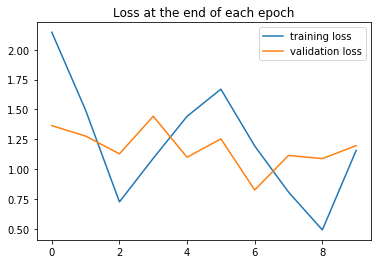

In [19]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

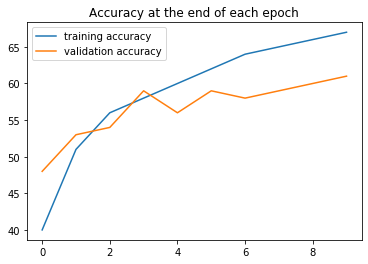

In [20]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [23]:
print(test_correct)
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4897), tensor(5335), tensor(5437), tensor(5920), tensor(5653), tensor(5974), tensor(5888), tensor(5974), tensor(6081), tensor(6129)]

Test accuracy: 61.290%


### Display the confusion matrix

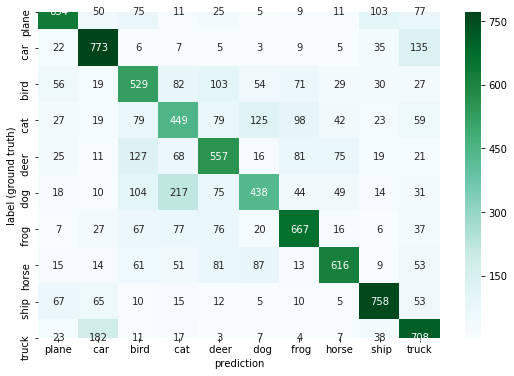

In [25]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
    

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

### Examine the misses